In [2]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.9/989.9 kB 2.4 MB/s eta 0:00:00a 0:00:01


In [3]:
import glob
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging
import visualkeras
import shutil
import glob
import imageio
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

2.6.4


In [4]:
# Load data
#original
np_train_x = np.load('/kaggle/input/homework2/x_train.npy')
np_train_y = np.load('/kaggle/input/homework2/y_train.npy')

#standardized
#np_train_x = np.load('/kaggle/input/homework2standardized/x_train_c_01.npy')
# np_train_x = np.load('/kaggle/input/homework2standardized/x_train_r_01.npy')
#np_train_x = np.load('/kaggle/input/homework2standardized/x_train_c_-11.npy')
# np_train_x = np.load('/kaggle/input/homework2standardized/x_train_r_-11.npy')
#np_train_y = np.load('/kaggle/input/homework2standardized/y_train.npy')

In [5]:
## Split in training and test and save
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(np_train_x, np_train_y, test_size=0.1, random_state=1, stratify=np_train_y)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=1, stratify=y_train_val)


with open('./X_train.npy', 'wb') as f:
    np.save(f, X_train)
    
with open('./y_train.npy', 'wb') as f:
    np.save(f, y_train)
    
with open('./X_val.npy', 'wb') as f:
    np.save(f, X_val)
    
with open('./y_val.npy', 'wb') as f:
    np.save(f, y_val)
    
with open('./X_test.npy', 'wb') as f:
    np.save(f, X_test)
    
with open('./y_test.npy', 'wb') as f:
    np.save(f, y_test)

In [6]:
# OR load splitted prevously

X_train = np.load('/kaggle/working/X_train.npy')
y_train = np.load('/kaggle/working/y_train.npy')
X_val = np.load('/kaggle/working/X_val.npy')
y_val = np.load('/kaggle/working/y_val.npy')
X_test = np.load('/kaggle/working/X_test.npy')
y_test = np.load('/kaggle/working/y_test.npy')

In [7]:
X = X_train
X = np.expand_dims((X),axis=-1).astype('float32')
y = np.array(y_train)
X.shape, y.shape

print('Data shape', X.shape)
print('Data min {:0.2f}\nData max {:0.2f}\nData mean {:0.2f}\nData std {:0.2f}'.format(
    X.min(), X.max(), X.mean(), X.std()))

input_shape = X.shape[1:]
input_shape

y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)
print(X_train.shape)
print(X_test.shape)

Data shape (1967, 36, 6, 1)
Data min -10855.00
Data max 53020.00
Data mean 25.43
Data std 647.89
(1967, 36, 6)
(243, 36, 6)


### Generative Adversarial Network

In [8]:
def get_dc_discriminator(input_shape, seed=seed):
    tf.random.set_seed(seed)

    # Build the discriminator layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    x = tfkl.ZeroPadding2D((2,2), name='padding')(input_layer)

    x = tfkl.Conv2D(64, 3, padding='same', strides=2, name='conv1')(x)
    x = tfkl.BatchNormalization(name='bn1')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation1')(x)

    x = tfkl.Conv2D(128, 3, padding='same', strides=2, name='conv2')(x)
    x = tfkl.BatchNormalization(name='bn2')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation2')(x)

    x = tfkl.Conv2D(256, 3, padding='same', strides=2, name='conv3')(x)
    x = tfkl.BatchNormalization(name='bn3')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation3')(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)
    x = tfkl.Dropout(.5, seed=seed, name='dropout')(x)
    x = tfkl.Dense(1, name='dense_out')(x)
    output_layer = tfkl.Activation('sigmoid', name='output_layer')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='discriminator')

    # Return the discriminator
    return model
discriminator = get_dc_discriminator(input_shape)
discriminator.summary()
#display(visualkeras.layered_view(discriminator, legend=True, scale_xy=6))
#tfk.utils.plot_model(discriminator, show_shapes=True, expand_nested=True, to_file='vanilla_discriminator.png')

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 36, 6, 1)]        0         
_________________________________________________________________
padding (ZeroPadding2D)      (None, 40, 10, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 20, 5, 64)         640       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 20, 5, 64)         256       
_________________________________________________________________
activation1 (LeakyReLU)      (None, 20, 5, 64)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 10, 3, 128)        73856     
_________________________________________________________________
bn2 (BatchNormalization)     (None, 10, 3, 128)      

In [9]:
latent_dim = 128

def get_dc_generator(input_shape, seed=seed):
    tf.random.set_seed(seed)

    # Build the generator layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    x = tfkl.Dense(4*4*64, use_bias=False, name='dense0')(input_layer)
    x = tfkl.BatchNormalization(name='bn0')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation0')(x)
    x = tfkl.Reshape((4,4,64))(x)

    x = tfkl.UpSampling2D(name='upsampling1', size=(2, 2))(x)
    x = tfkl.Conv2D(64, 3, padding='same', use_bias=False, name='conv1')(x)
    x = tfkl.BatchNormalization(name='bn1')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation1')(x)

    x = tfkl.UpSampling2D(name='upsampling2', size=(2, 1))(x)
    x = tfkl.Conv2D(128, 3, padding='same', use_bias=False, name='conv2')(x)
    x = tfkl.BatchNormalization(name='bn2')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation2')(x)

    x = tfkl.UpSampling2D(name='upsampling3', size=(2, 1))(x)
    x = tfkl.Conv2D(256, 3, padding='same', use_bias=False, name='conv3')(x)
    x = tfkl.BatchNormalization(name='bn3')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation3')(x)

    x = tfkl.Conv2D(1, 3, padding='same', use_bias=False, name='conv_out')(x)
    x = tfkl.Activation('tanh', name='activation_out')(x)
    x = tfkl.ZeroPadding2D((2,0), name='zeropadding')(x) 
    x = tfkl.Cropping2D((0,1), name='cropping')(x)
    output_layer = x
    #output_layer = tfkl.Cropping2D((2,2), name='cropping')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='generator')

    # Return the model
    return model
generator = get_dc_generator(latent_dim)
generator.summary()
#display(visualkeras.layered_view(generator, legend=True, scale_xy=6))
#tfk.utils.plot_model(generator, show_shapes=True, expand_nested=True, to_file='vanilla_generator.png')

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 128)]             0         
_________________________________________________________________
dense0 (Dense)               (None, 1024)              131072    
_________________________________________________________________
bn0 (BatchNormalization)     (None, 1024)              4096      
_________________________________________________________________
activation0 (LeakyReLU)      (None, 1024)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 64)          0         
_________________________________________________________________
upsampling1 (UpSampling2D)   (None, 8, 8, 64)          0         
_________________________________________________________________
conv1 (Conv2D)               (None, 8, 8, 64)          36

#### Conditional Gan

In [10]:
image_size = input_shape[0]
num_classes = len(np.unique(y))
num_channels = input_shape[-1]
print(image_size)
print(num_classes)
print(num_channels)

generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

conditional_generator_input = (generator_in_channels)
conditional_discriminator_input = (image_size, 6, discriminator_in_channels)
conditional_discriminator_input, conditional_generator_input

36
12
1
140 13


((36, 6, 13), 140)

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 36, 6, 13)]       0         
_________________________________________________________________
padding (ZeroPadding2D)      (None, 40, 10, 13)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 20, 5, 64)         7552      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 20, 5, 64)         256       
_________________________________________________________________
activation1 (LeakyReLU)      (None, 20, 5, 64)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 10, 3, 128)        73856     
_________________________________________________________________
bn2 (BatchNormalization)     (None, 10, 3, 128)      

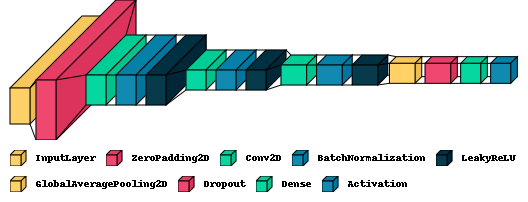

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 140)]             0         
_________________________________________________________________
dense0 (Dense)               (None, 1024)              143360    
_________________________________________________________________
bn0 (BatchNormalization)     (None, 1024)              4096      
_________________________________________________________________
activation0 (LeakyReLU)      (None, 1024)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 64)          0         
_________________________________________________________________
upsampling1 (UpSampling2D)   (None, 8, 8, 64)          0         
_________________________________________________________________
conv1 (Conv2D)               (None, 8, 8, 64)          36

In [11]:
discriminator = get_dc_discriminator(conditional_discriminator_input)
discriminator.summary()
display(visualkeras.layered_view(discriminator, legend=True, scale_xy=6))
tfk.utils.plot_model(discriminator, show_shapes=True, expand_nested=True, to_file='conditional_discriminator.png')

generator = get_dc_generator(conditional_generator_input)
generator.summary()
#display(visualkeras.layered_view(generator, legend=True, scale_xy=6))
#tfk.utils.plot_model(generator, show_shapes=True, expand_nested=True, to_file='conditional_generator.png')

In [12]:
class ConditionalGAN(tfk.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

        self.loss_tracker = tfk.metrics.Mean(name="loss")
        self.d_loss_tracker = tfk.metrics.Mean(name="d_loss")
        self.g_loss_tracker = tfk.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer

    @property
    def metrics(self):
        return [
            self.loss_tracker,
            self.d_loss_tracker,
            self.g_loss_tracker
        ]

    @tf.function
    def train_step(self, data):
        real_images, one_hot_labels = data
        batch_size = tf.shape(real_images)[0]
        
        image_one_hot_labels = one_hot_labels[:, :, None, None]
#         image_one_hot_labels = tf.repeat(image_one_hot_labels, repeats=[image_size * image_size])
#         image_one_hot_labels = tf.reshape(image_one_hot_labels, (-1, image_size, image_size, num_classes))
        image_one_hot_labels = tf.repeat(image_one_hot_labels, repeats=[36*6])
        image_one_hot_labels = tf.reshape(image_one_hot_labels, (-1, 36, 6, num_classes))
        
        # Sample random points in the latent space
        z = tf.random.normal(shape=(batch_size, self.latent_dim))
        #print("here01")
        z = tf.concat([z, one_hot_labels], -1)
        #print("here02")

        # Generate fake images from z
        generated_images = self.generator(z)

#         print("here022")
#         print(generated_images.shape)
#         print(image_one_hot_labels.shape)
#         "here022(None, 36, 6, 1) (None, 36, 36, 12)"
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
#         print("here023")
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
#         print("here024")
        # Combine generated images and real ones
        combined_images = tf.concat([fake_image_and_labels, real_image_and_labels], axis=0)
#         print("here025")
#         print("here025b")

        # Create labels so that fake images correspond to class 0 and real images to class 1
        labels = tf.concat([tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0)
#         print("here026")
#         print("here026b")

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = tf.reduce_mean(tfk.losses.binary_crossentropy(labels, predictions))
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        loss = d_loss

        # Sample random points in the latent space
        z = tf.random.normal(shape=(batch_size, self.latent_dim))
        #print("here027")
        #print(z.shape)
        #print(one_hot_labels.shape)
        z = tf.concat([z, one_hot_labels], axis=1)
        #print("here028")

        # Create misleading labels for fake images so that they correspond to class 1
        misleading_labels = tf.ones((batch_size, 1))

        # Train the generator 
        with tf.GradientTape() as tape:
            fake_images = self.generator(z)
            #print("here028a")
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            #print("here028b")
            misleading_predictions = self.discriminator(fake_image_and_labels)
            g_loss = tf.reduce_mean(tfk.losses.binary_crossentropy(misleading_labels, misleading_predictions))
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        loss += g_loss

        # Update metrics
        self.loss_tracker.update_state(loss)
        self.d_loss_tracker.update_state(d_loss)
        self.g_loss_tracker.update_state(g_loss)
        return {
            "loss": self.loss_tracker.result(),
            "d_loss": self.d_loss_tracker.result(),
            "g_loss": self.g_loss_tracker.result(),
        }

In [13]:
class ConditionalGANMonitor(tfk.callbacks.Callback):
    def __init__(self, num_img=10, latent_dim=latent_dim, name='', gray=False):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.name = name
        self.gray = gray

    def on_epoch_end(self, epoch, logs=None):
        tf.random.set_seed(seed)
        os.makedirs(self.name+'temp', exist_ok=True)
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        labels = tf.cast(tf.math.floormod(tf.range(0,self.num_img), num_classes), 'float32')
        labels = tfk.utils.to_categorical(labels, num_classes)
       # print("here29")
        random_latent_vectors = tf.concat([random_latent_vectors,labels],-1)
       # print("here30")
        generated_images = self.model.generator(random_latent_vectors).numpy()

        fig, axes = plt.subplots(1, self.num_img, figsize=(20,2*self.num_img))
        for i in range(self.num_img):
            img = tfk.preprocessing.image.array_to_img(generated_images[i])
            ax = axes[i%self.num_img]
            if self.gray:
                ax.imshow(np.squeeze(img), cmap='gray')
            else:
                ax.imshow(np.squeeze(img))
            ax.axis('off')
        fig.savefig(self.name+'temp/'+'{:0>5}'.format(epoch)+'.png') 
        plt.tight_layout()
        plt.show()

    def on_train_end(self, logs=None):
        fp_in = self.name+"temp/*.png"
        fp_out = self.name+"_generated_images.gif"
        imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
        img = next(imgs)
        img.save(fp=fp_out, format='GIF', append_images=imgs, save_all=True, duration=100, optimize=False)    
        shutil.rmtree(self.name+"temp")

In [14]:
epochs = 200#100
learning_rate = 5e-5
batch_size = 256#128

all_labels = tfk.utils.to_categorical(y, num_classes)
dataset = tf.data.Dataset.from_tensor_slices((X, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

cgan = ConditionalGAN(
    discriminator = get_dc_discriminator(conditional_discriminator_input), 
    generator = get_dc_generator(conditional_generator_input), 
    latent_dim = latent_dim
)
cgan.compile(
    d_optimizer = tfk.optimizers.Adam(learning_rate=learning_rate),
    g_optimizer = tfk.optimizers.Adam(learning_rate=learning_rate)
)

In [15]:
def conditional_sample(model, num_img, latent_dim, fixed=True, gray=False, label=None):
    if fixed:
        tf.random.set_seed(seed)
    z = tf.random.normal(shape=(num_img, latent_dim))
    if label == None:
        labels = tf.cast(tf.math.floormod(tf.range(0,num_img), num_classes), 'float32')
    else:
        labels = tf.cast(tf.math.floormod(tf.ones(num_img)*label, num_classes), 'float32')
    labels = tfk.utils.to_categorical(labels, num_classes)
    #print("here11")
    z = tf.concat([z,labels],-1)
   #print("here12")
    generated_images = model(z).numpy()

#     fig, axes = plt.subplots(1, num_img, figsize=(20,2*num_img))
#     for i in range(num_img):
#         img = tfk.preprocessing.image.array_to_img(generated_images[i])
#         ax = axes[i%num_img]
#         if gray:
#             ax.imshow(np.squeeze(img), cmap='gray')
#         else:
#             ax.imshow(np.squeeze(img))
#         ax.axis('off')
#     plt.tight_layout()
#     plt.show()
    return generated_images, labels
    
def generate_conditional_dataset(model, num_img, latent_dim, fixed=True, label=None):
    if fixed:
        tf.random.set_seed(seed)
    z = tf.random.normal(shape=(num_img, latent_dim))
    if label == None:
        labels = tf.cast(tf.math.floormod(tf.range(0,num_img), num_classes), 'float32')
    else:
        labels = tf.cast(tf.math.floormod(tf.ones(num_img)*label, num_classes), 'float32')
    labels = tfk.utils.to_categorical(labels, num_classes)
    z = tf.concat([z,labels],-1)
    generated_images = model(z).numpy()
    return generated_images, labels

Epoch 1/200
8/8 - 10s - loss: 1.7478 - d_loss: 1.0608 - g_loss: 0.6869


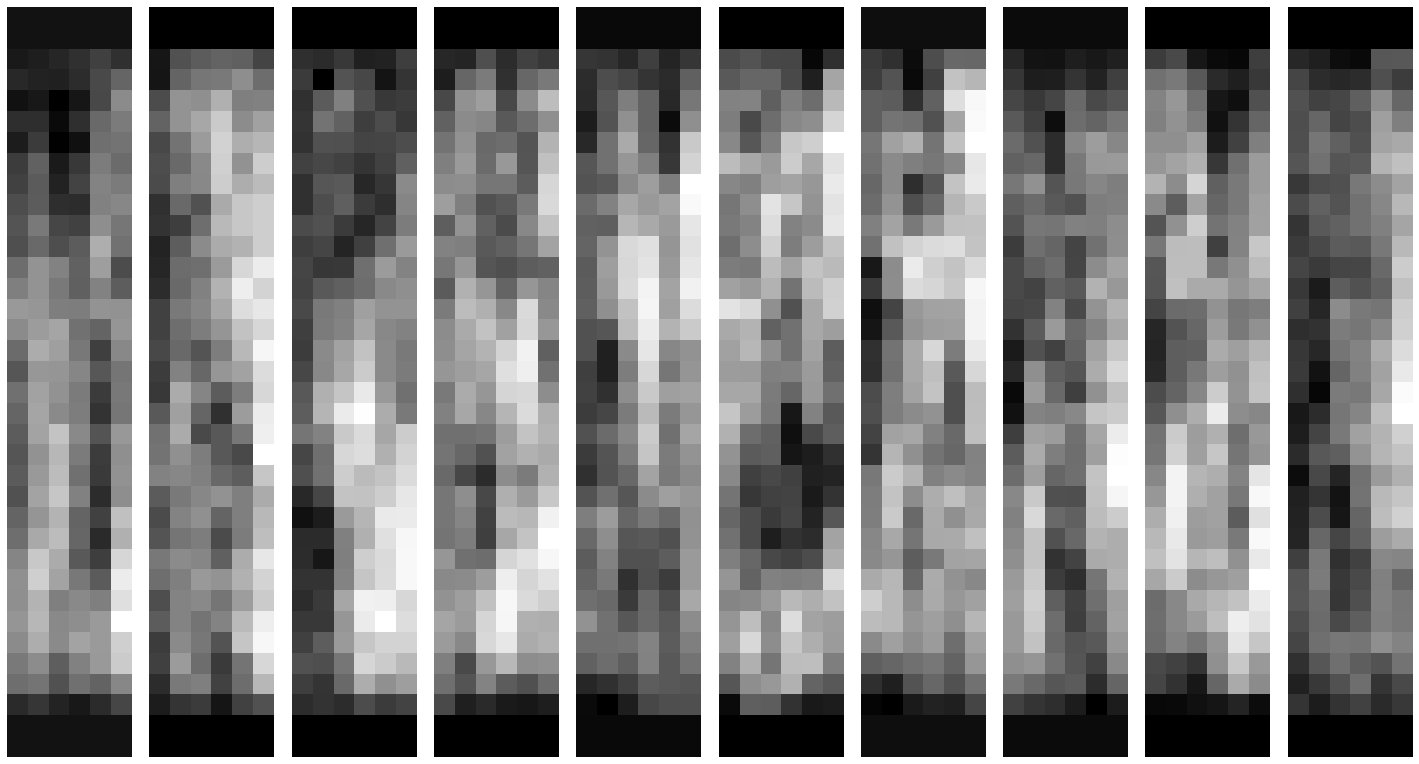

Epoch 2/200
8/8 - 1s - loss: 1.1331 - d_loss: 0.4675 - g_loss: 0.6656


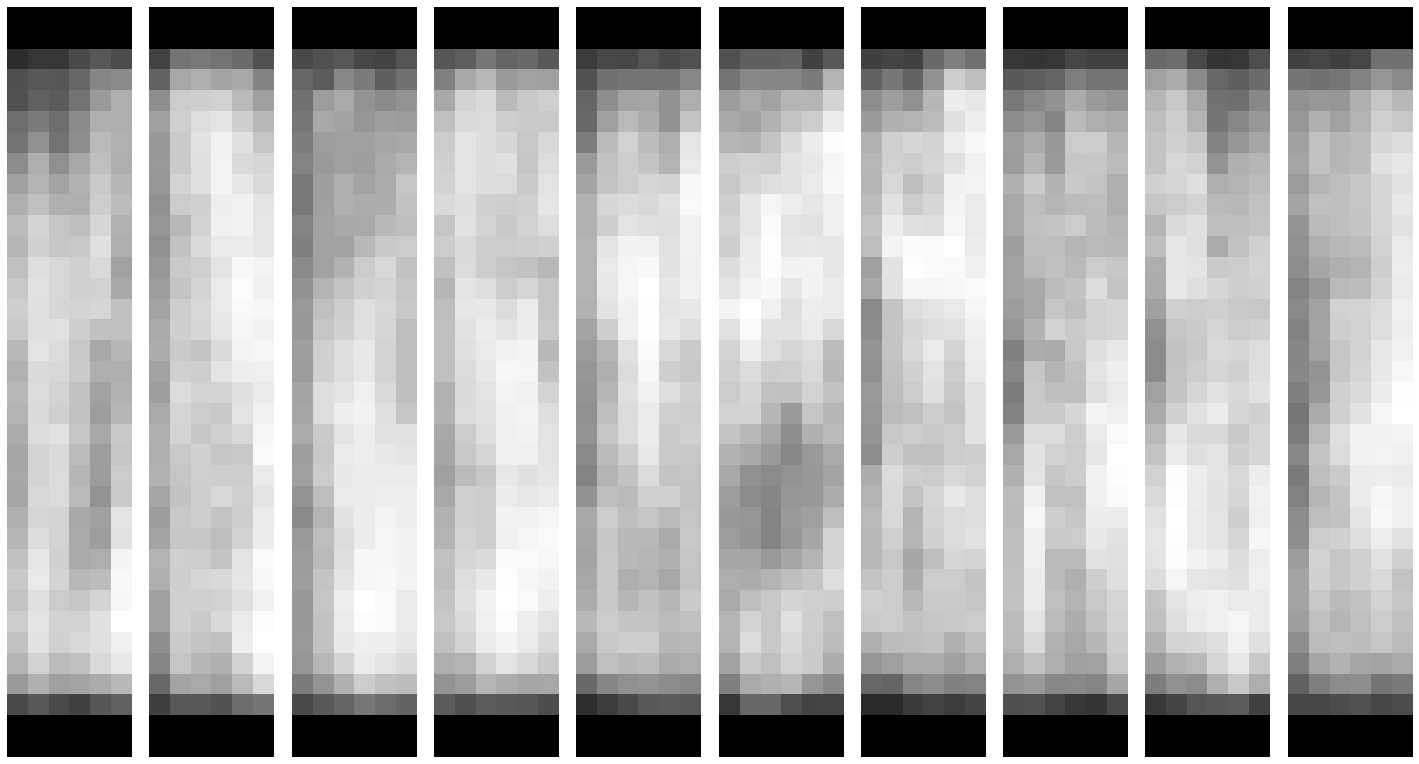

Epoch 3/200
8/8 - 1s - loss: 1.0946 - d_loss: 0.4486 - g_loss: 0.6460


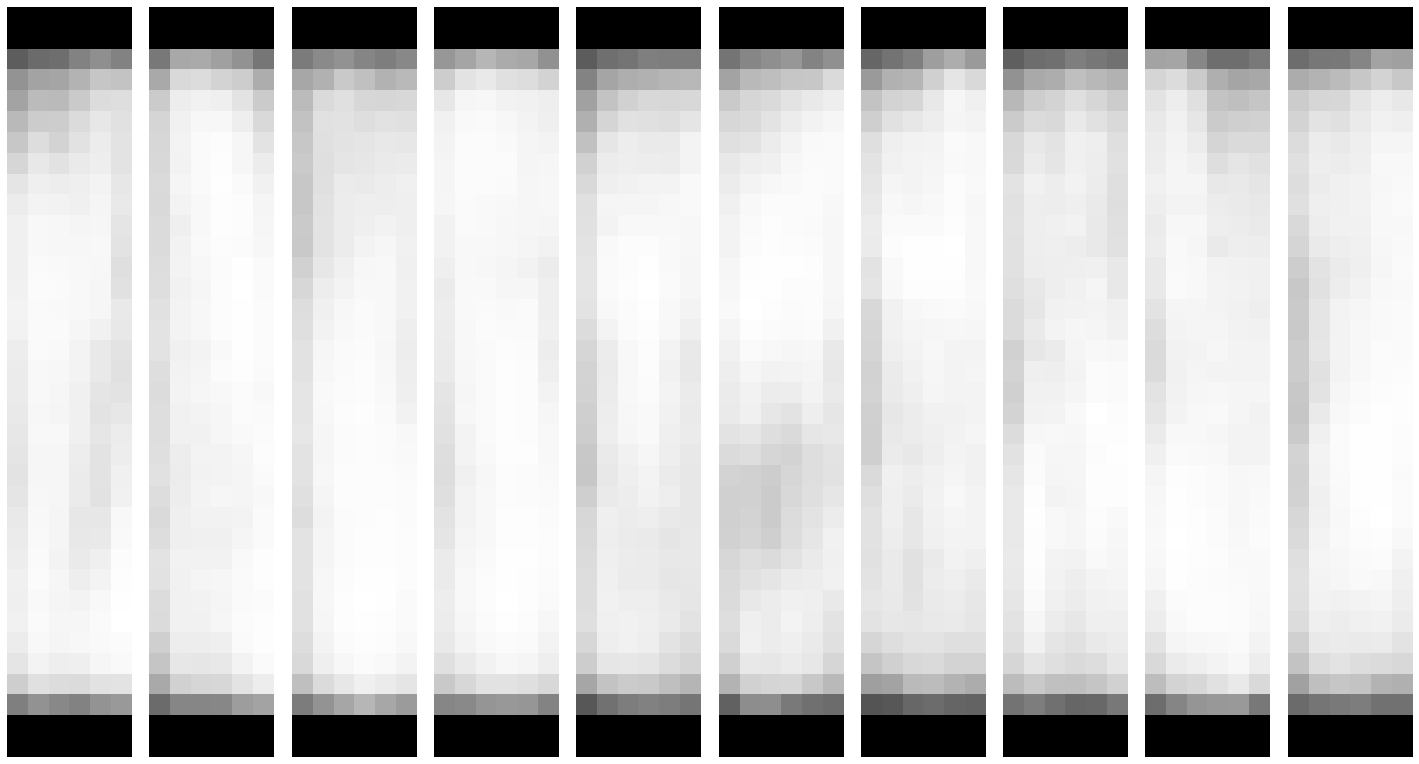

Epoch 4/200
8/8 - 1s - loss: 1.0818 - d_loss: 0.4438 - g_loss: 0.6379


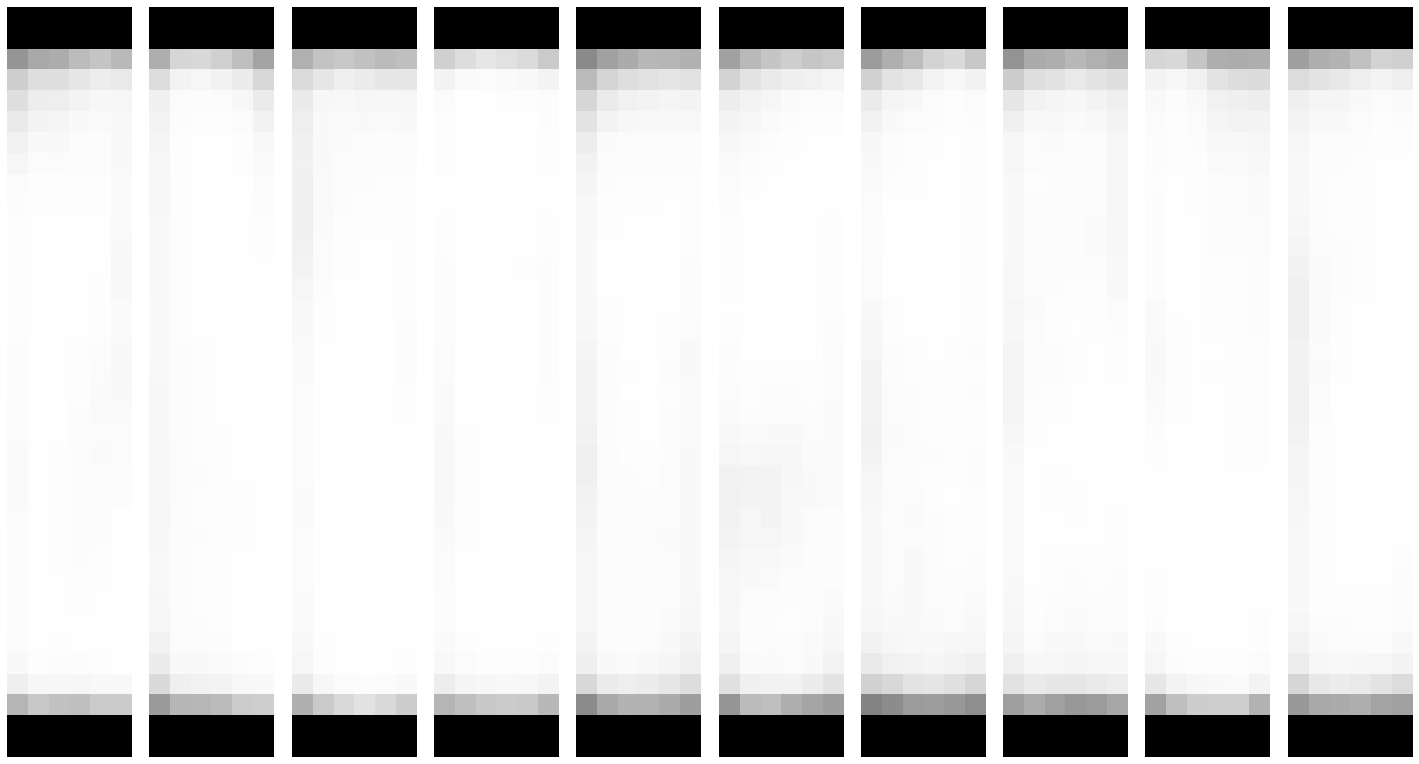

Epoch 5/200
8/8 - 1s - loss: 1.0791 - d_loss: 0.4382 - g_loss: 0.6409


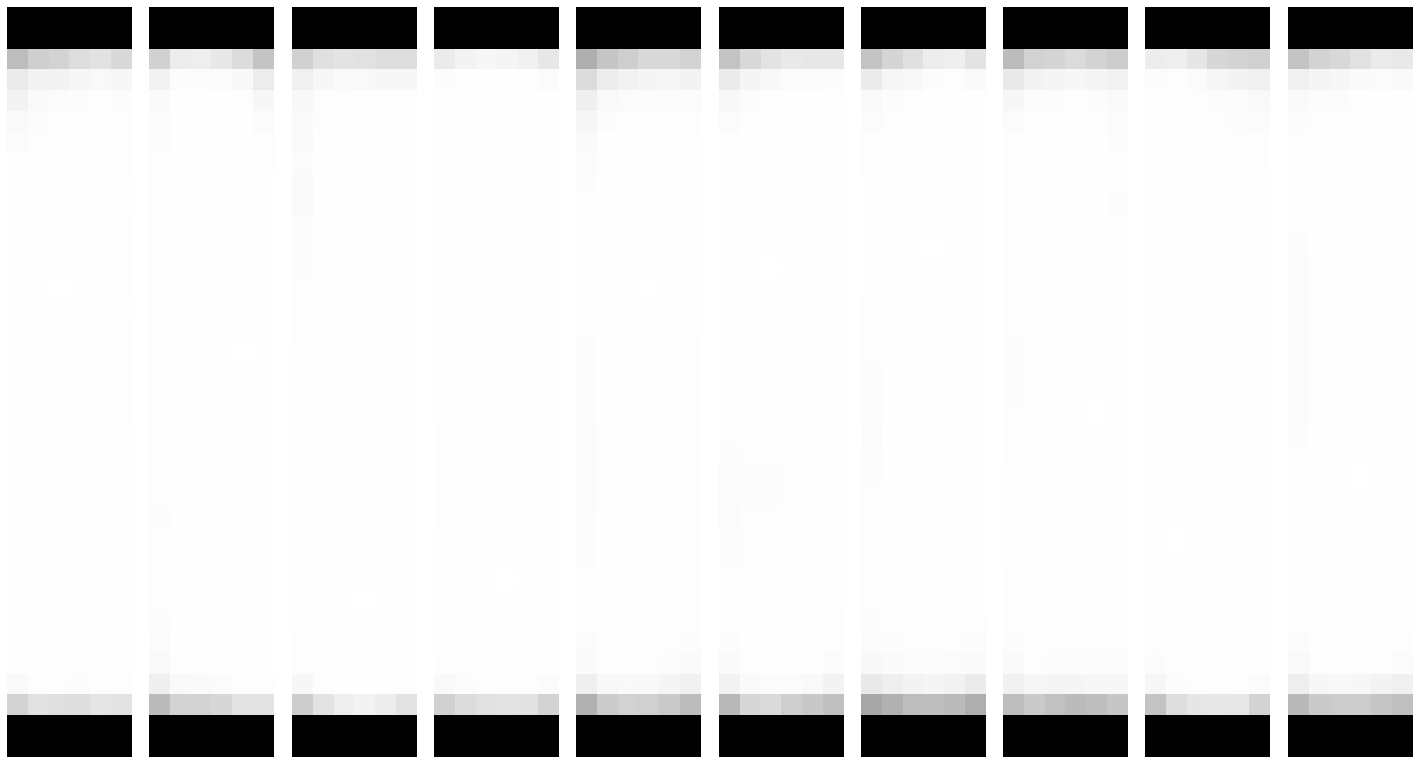

Epoch 6/200
8/8 - 1s - loss: 1.0809 - d_loss: 0.4326 - g_loss: 0.6483


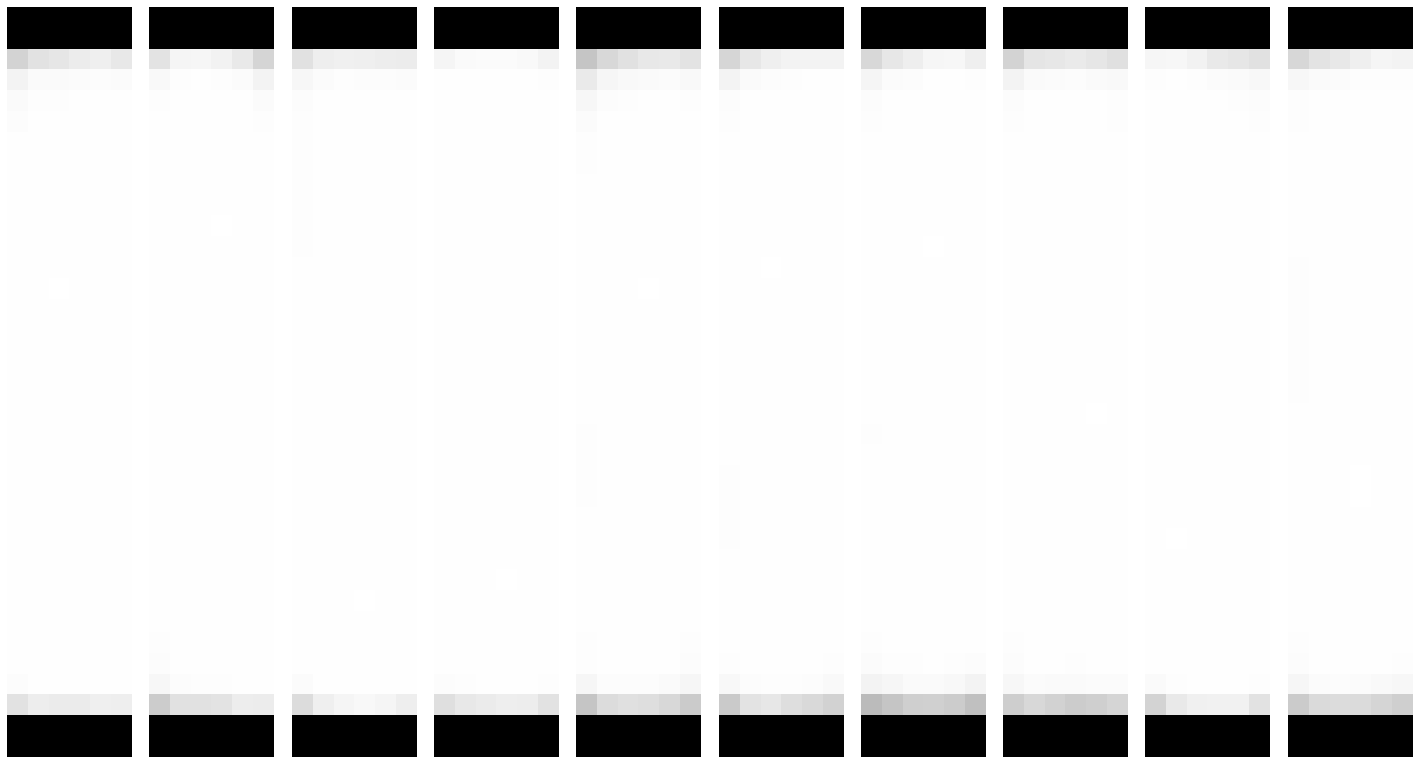

Epoch 7/200
8/8 - 1s - loss: 1.0840 - d_loss: 0.4268 - g_loss: 0.6572


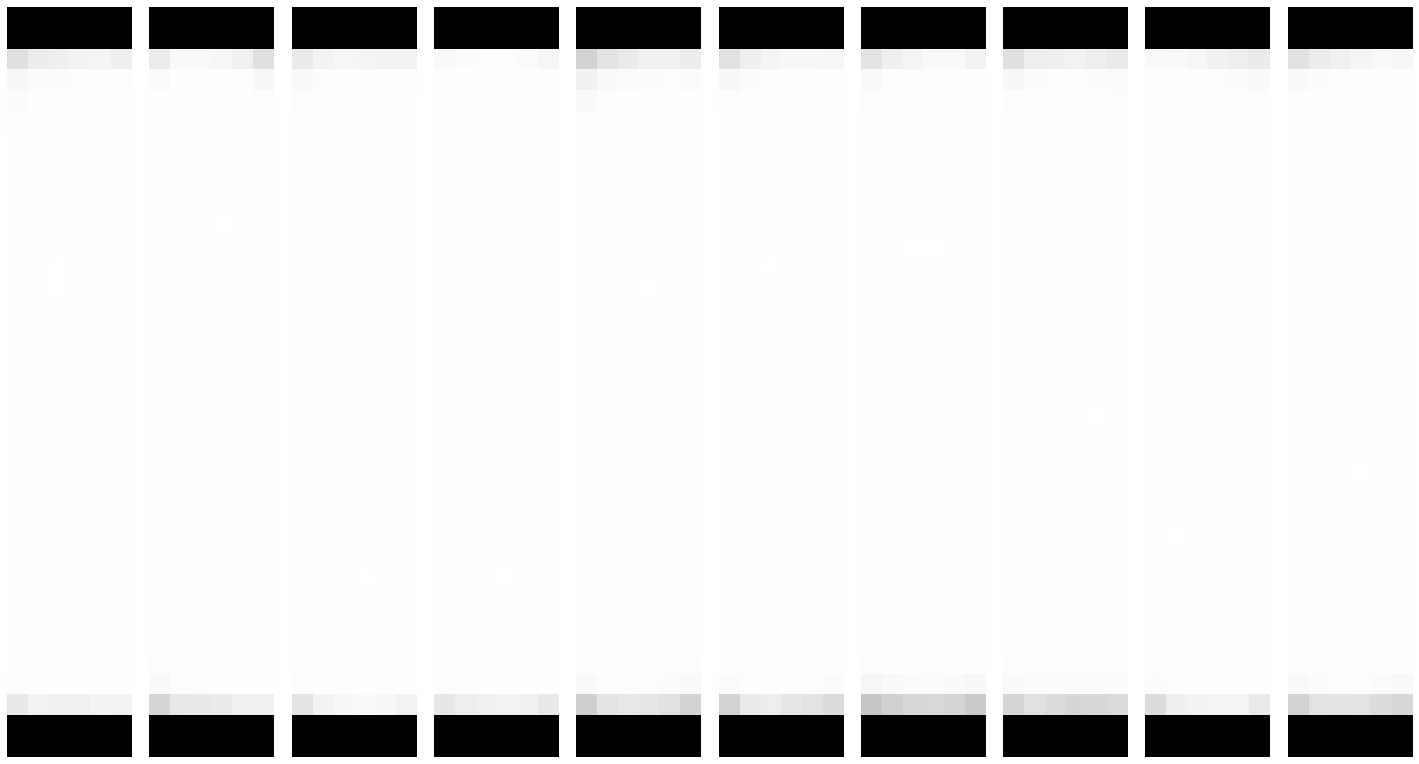

Epoch 8/200
8/8 - 1s - loss: 1.0876 - d_loss: 0.4210 - g_loss: 0.6666


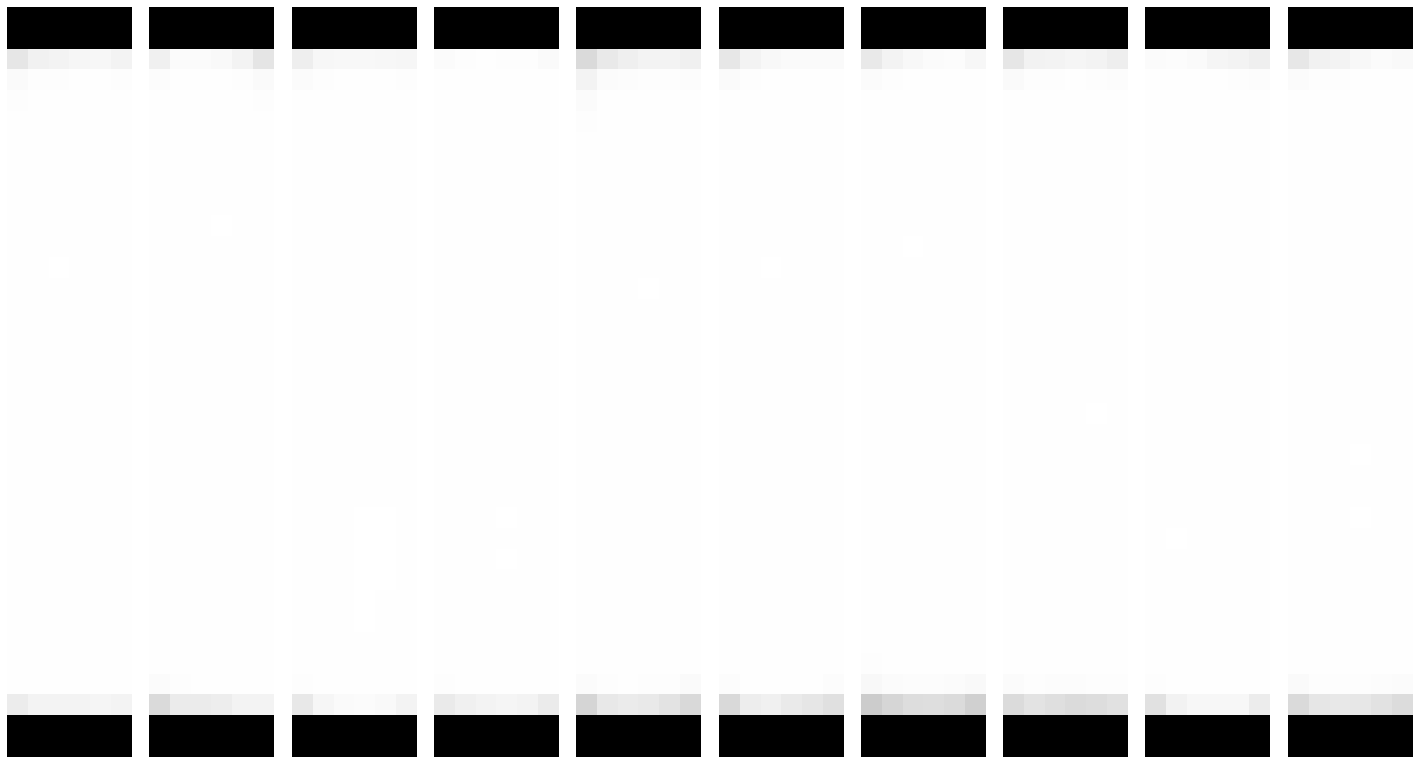

Epoch 9/200
8/8 - 1s - loss: 1.0914 - d_loss: 0.4154 - g_loss: 0.6760


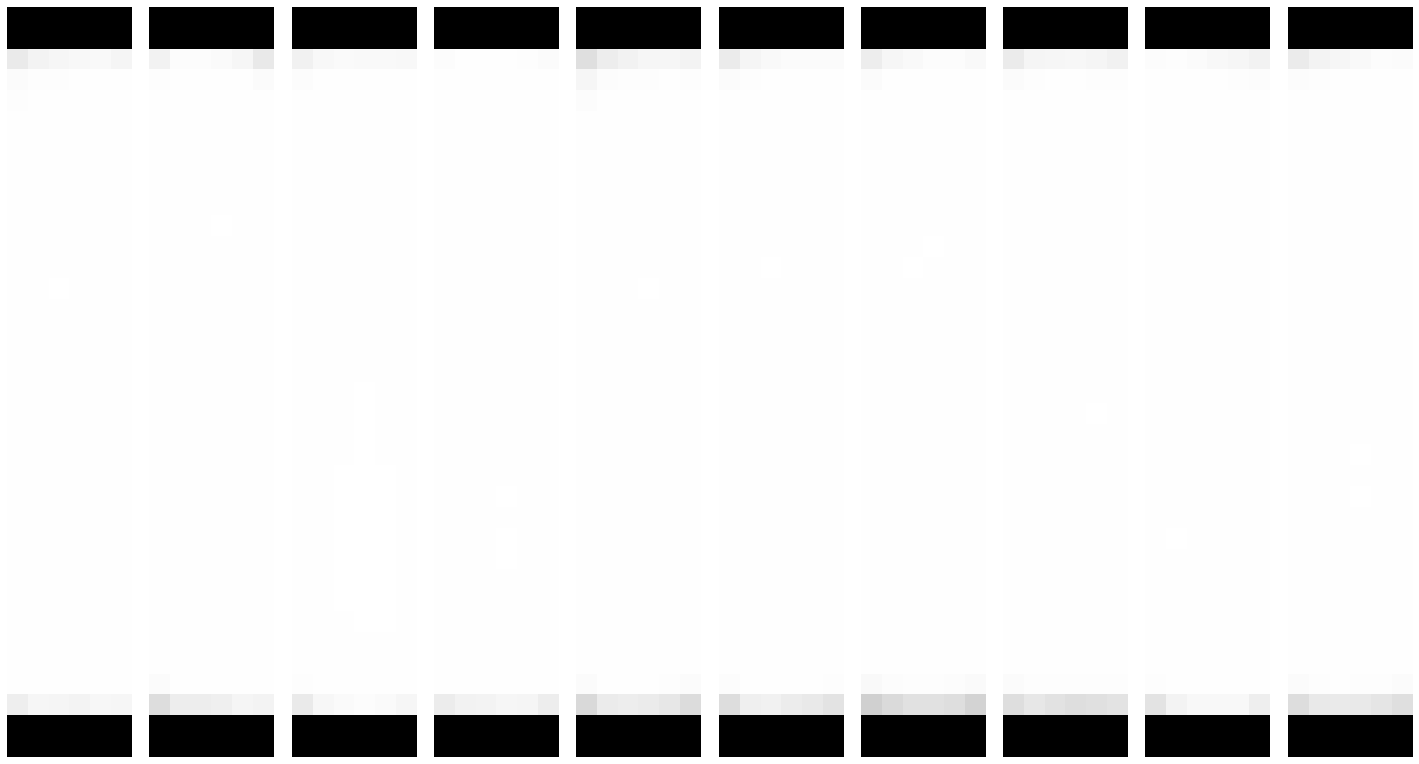

Epoch 10/200
8/8 - 1s - loss: 1.0963 - d_loss: 0.4107 - g_loss: 0.6856


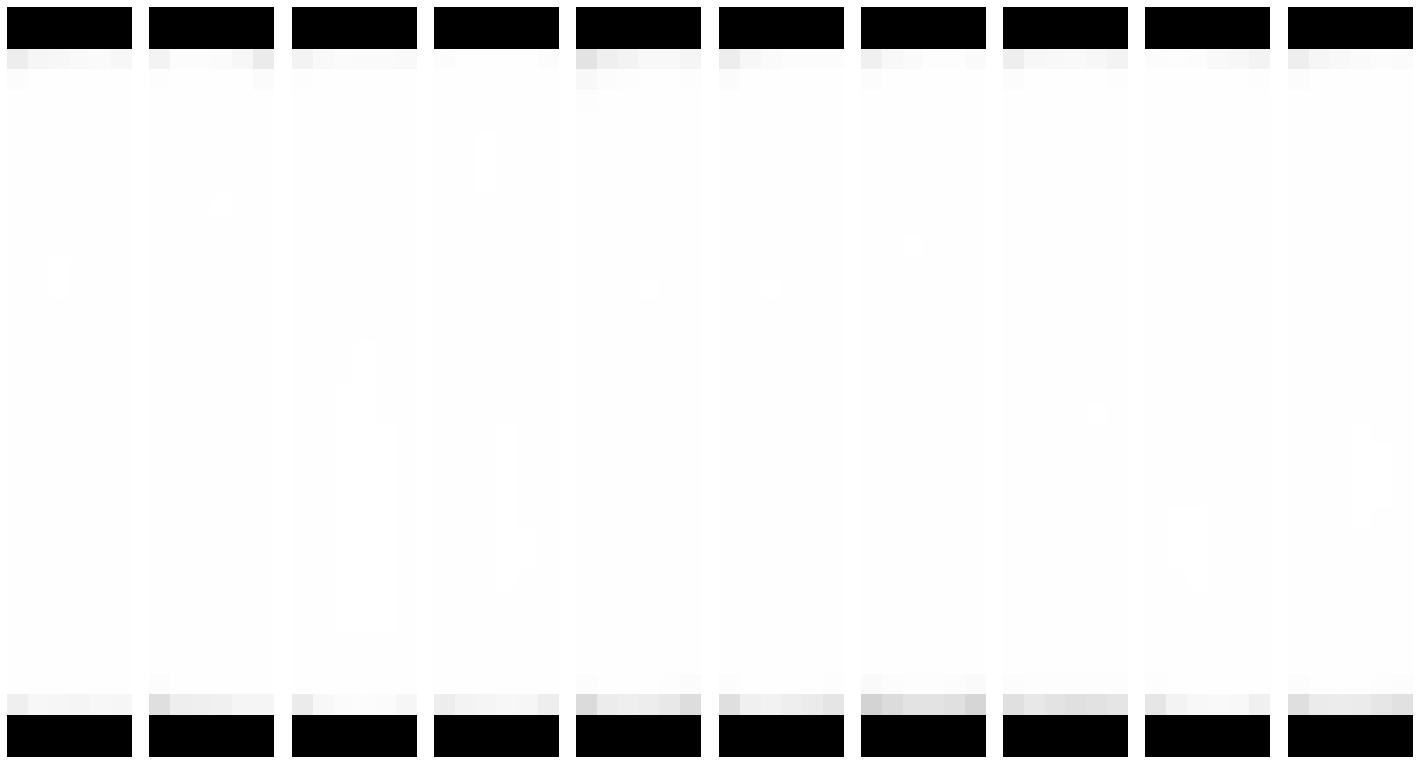

Epoch 11/200
8/8 - 1s - loss: 1.1001 - d_loss: 0.4052 - g_loss: 0.6949


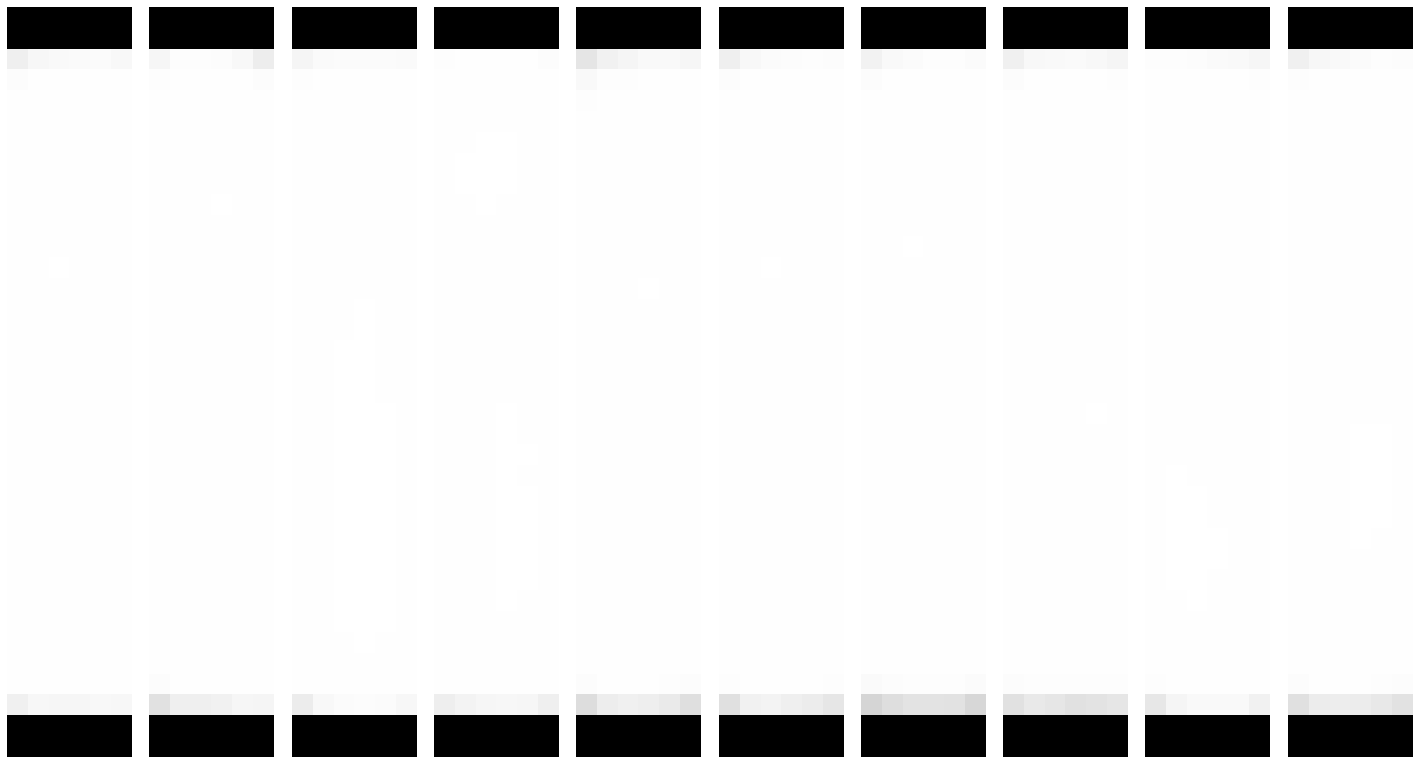

Epoch 12/200
8/8 - 1s - loss: 1.1044 - d_loss: 0.4000 - g_loss: 0.7044


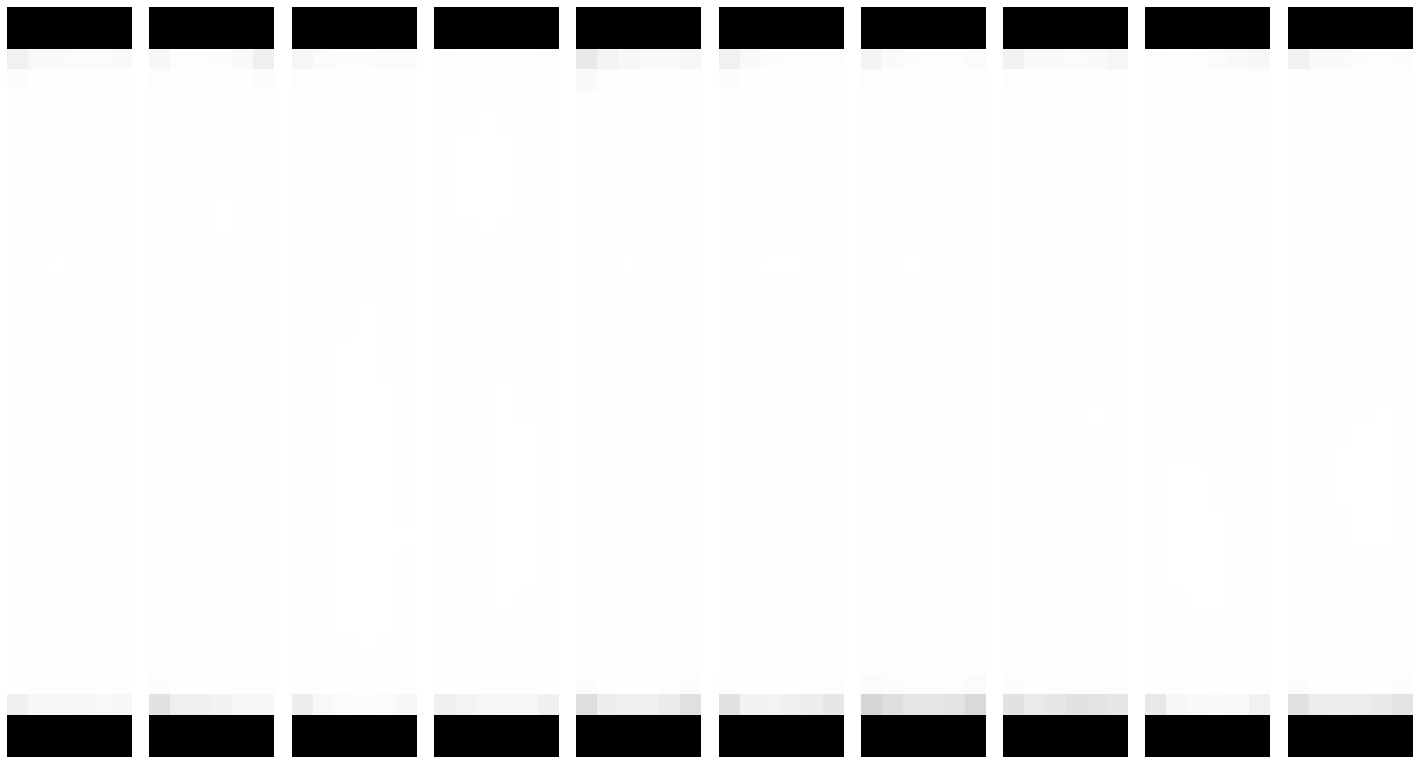

Epoch 13/200
8/8 - 1s - loss: 1.1086 - d_loss: 0.3948 - g_loss: 0.7138


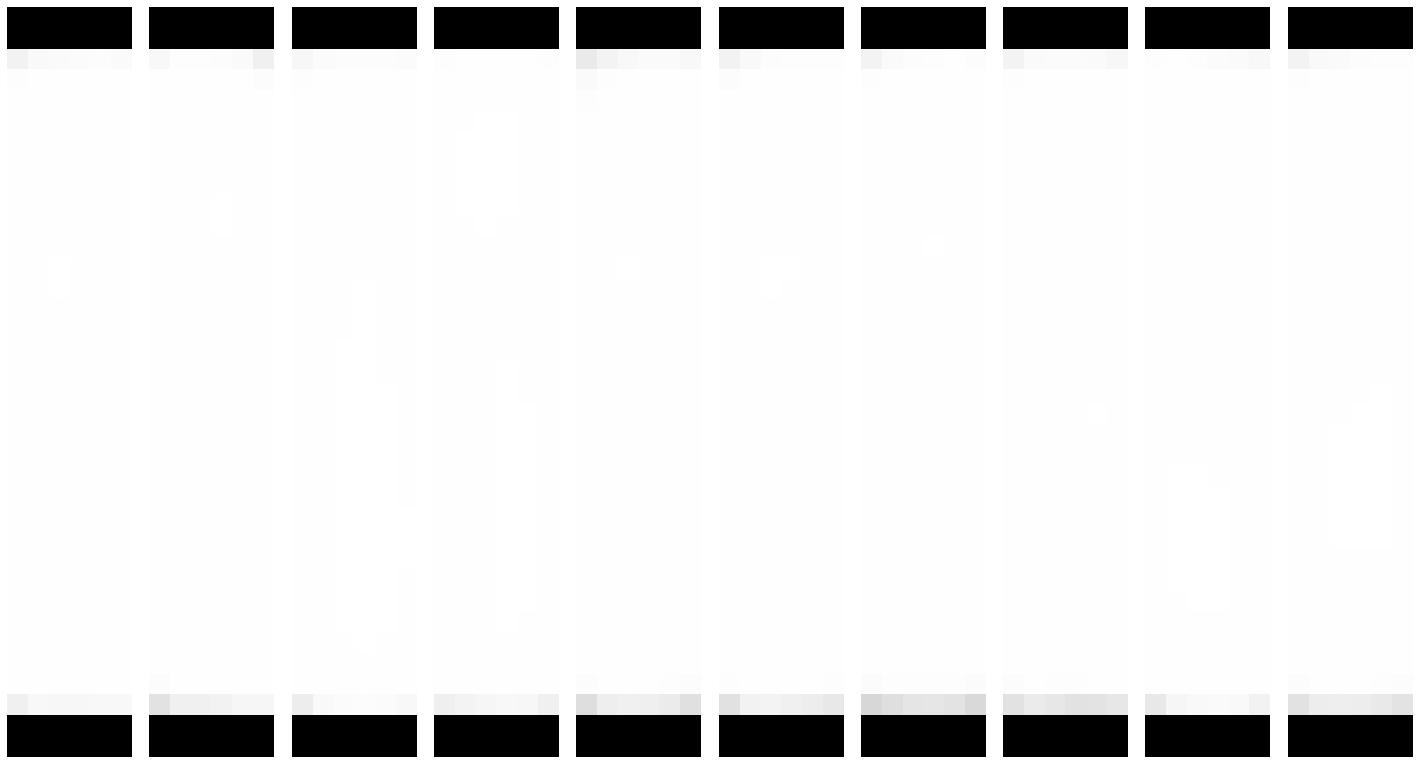

Epoch 14/200
8/8 - 1s - loss: 1.1124 - d_loss: 0.3891 - g_loss: 0.7233


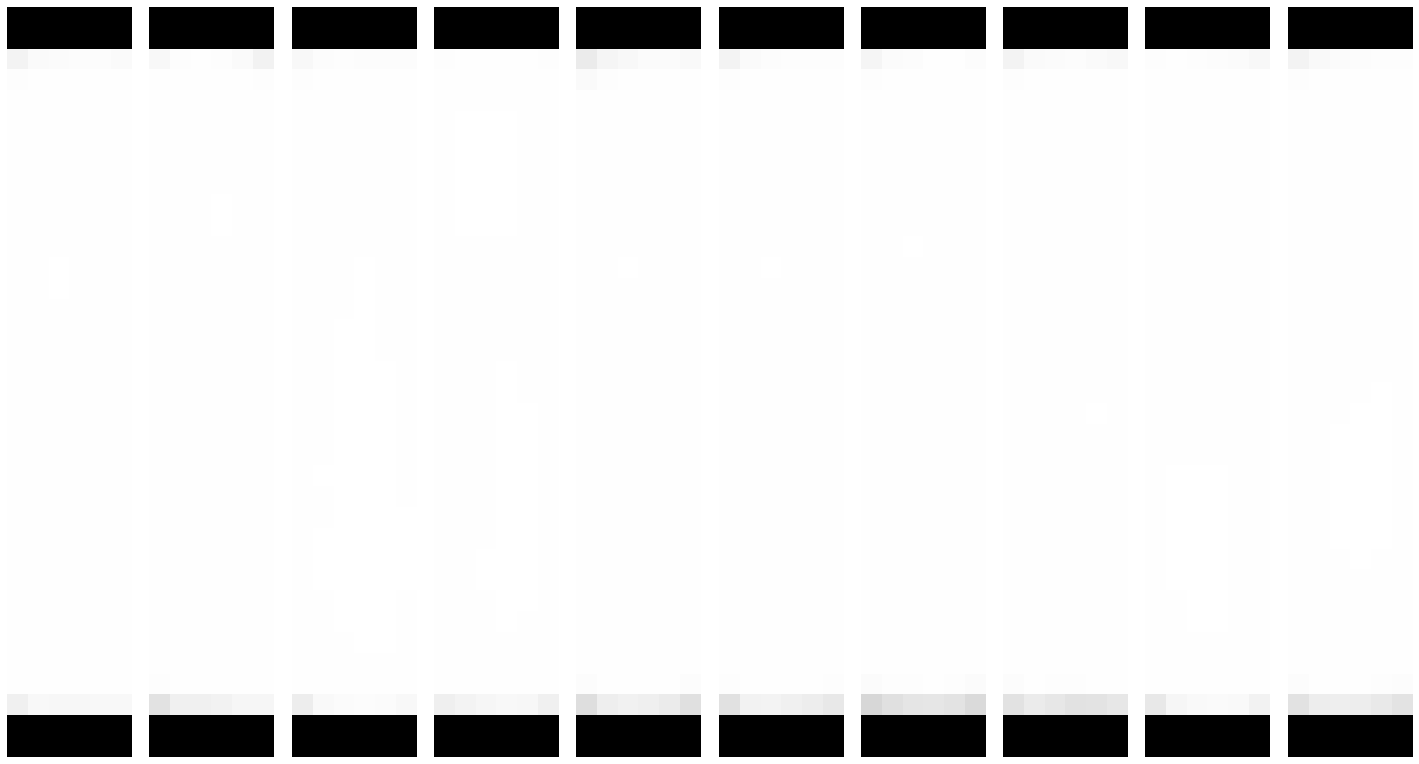

Epoch 15/200
8/8 - 1s - loss: 1.1168 - d_loss: 0.3839 - g_loss: 0.7328


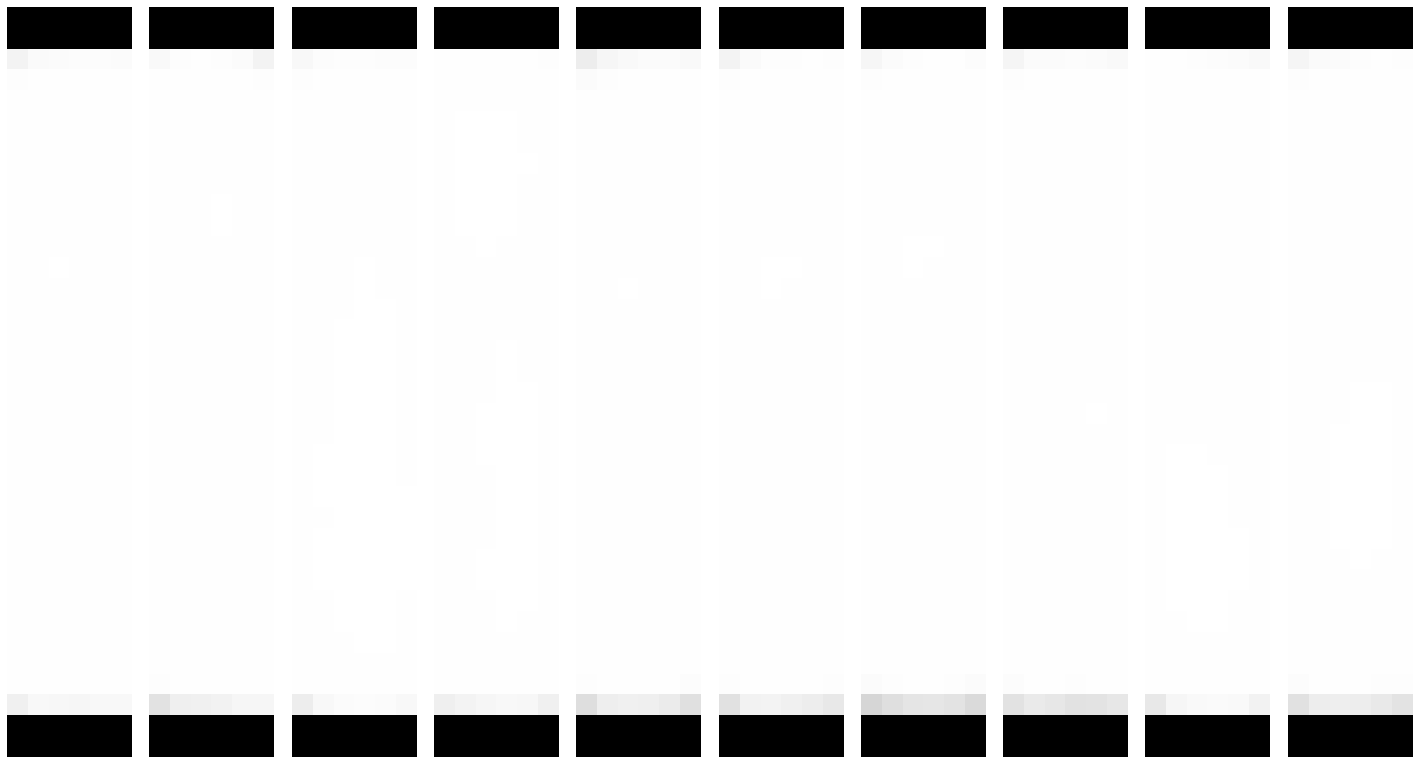

Epoch 16/200
8/8 - 1s - loss: 1.1213 - d_loss: 0.3790 - g_loss: 0.7423


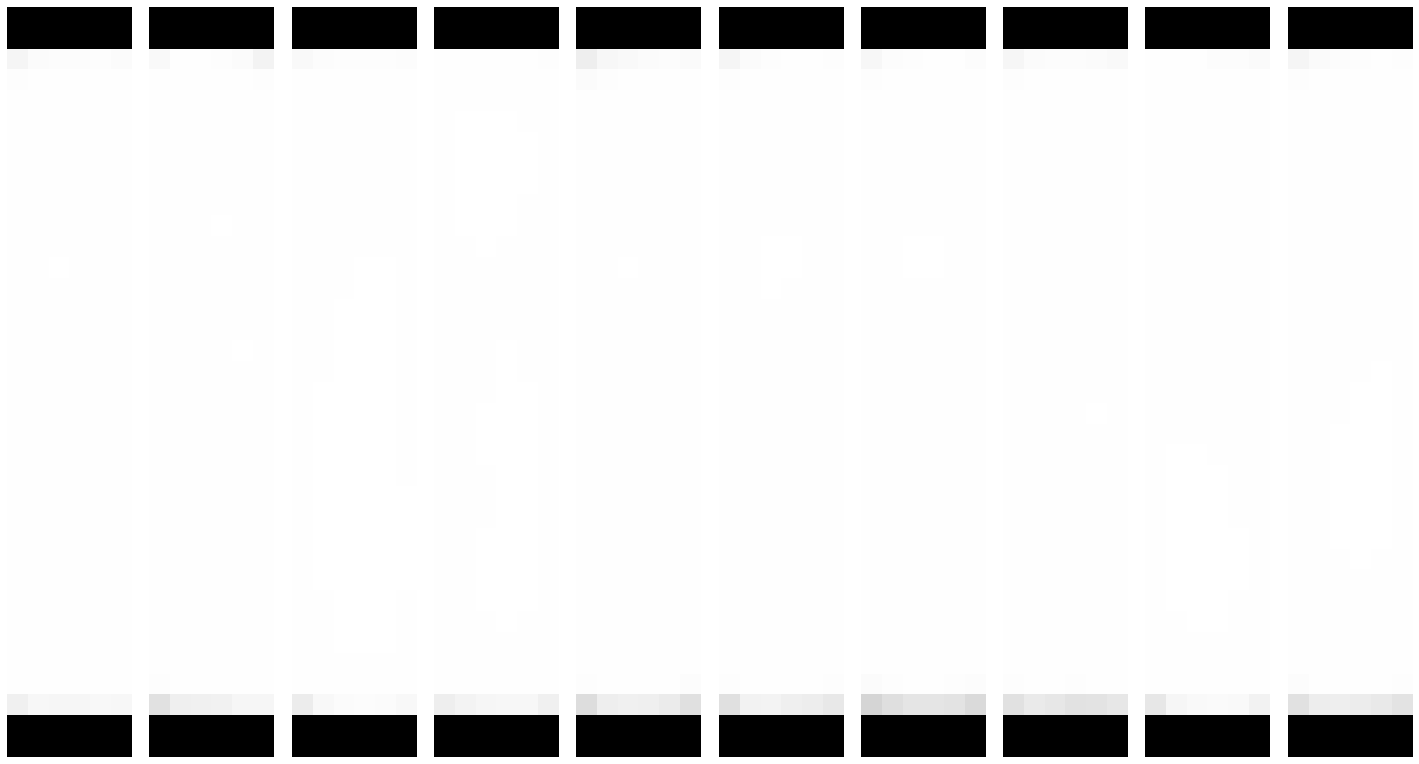

Epoch 17/200
8/8 - 1s - loss: 1.1258 - d_loss: 0.3738 - g_loss: 0.7519


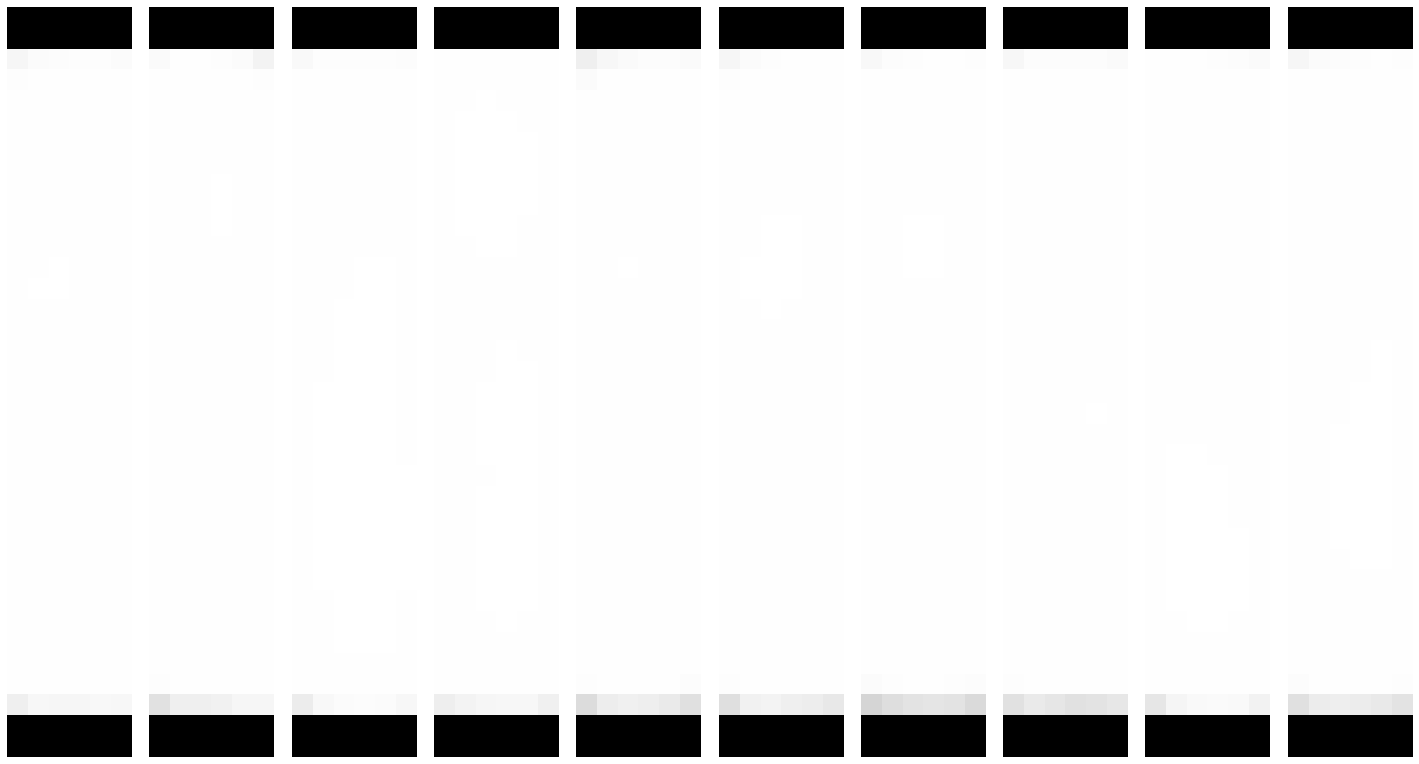

Epoch 18/200
8/8 - 1s - loss: 1.1302 - d_loss: 0.3685 - g_loss: 0.7617


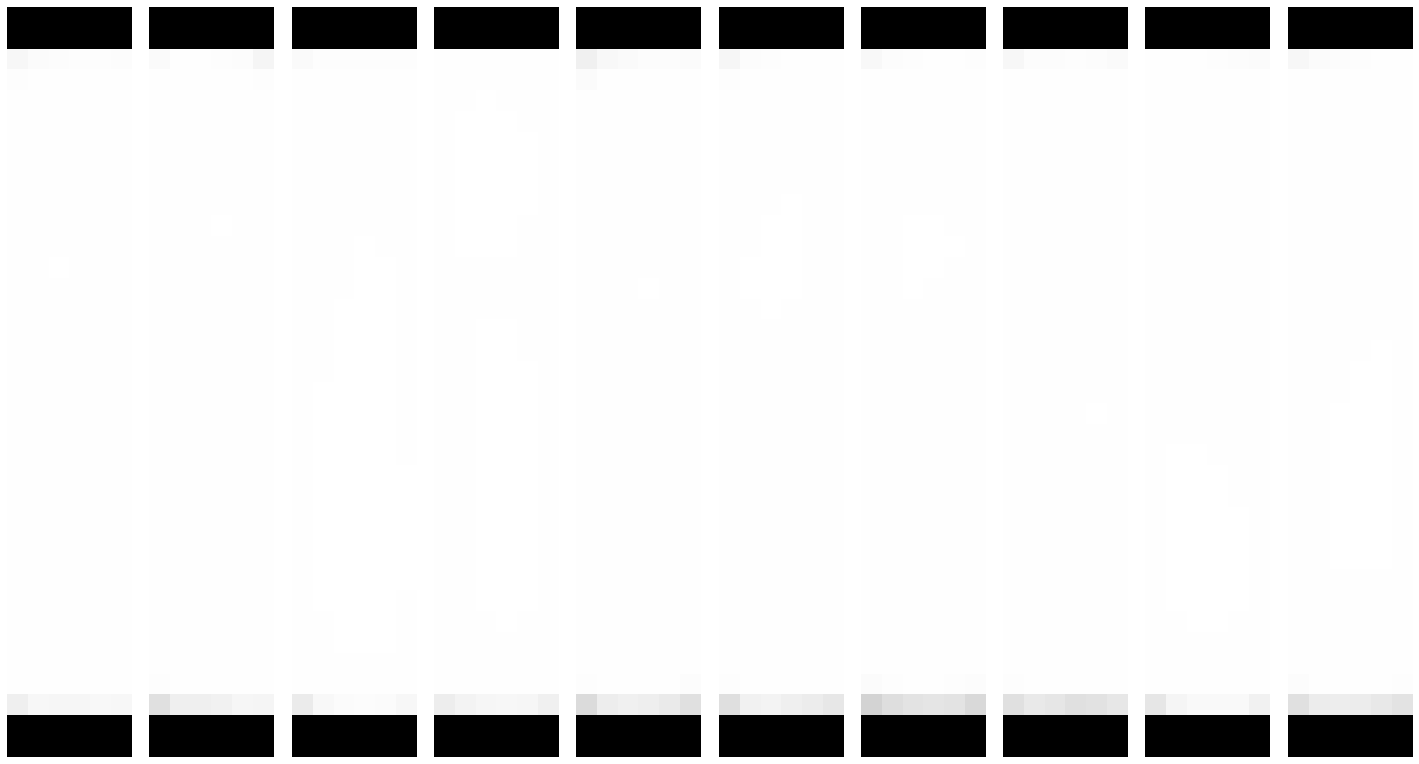

Epoch 19/200
8/8 - 1s - loss: 1.1354 - d_loss: 0.3637 - g_loss: 0.7717


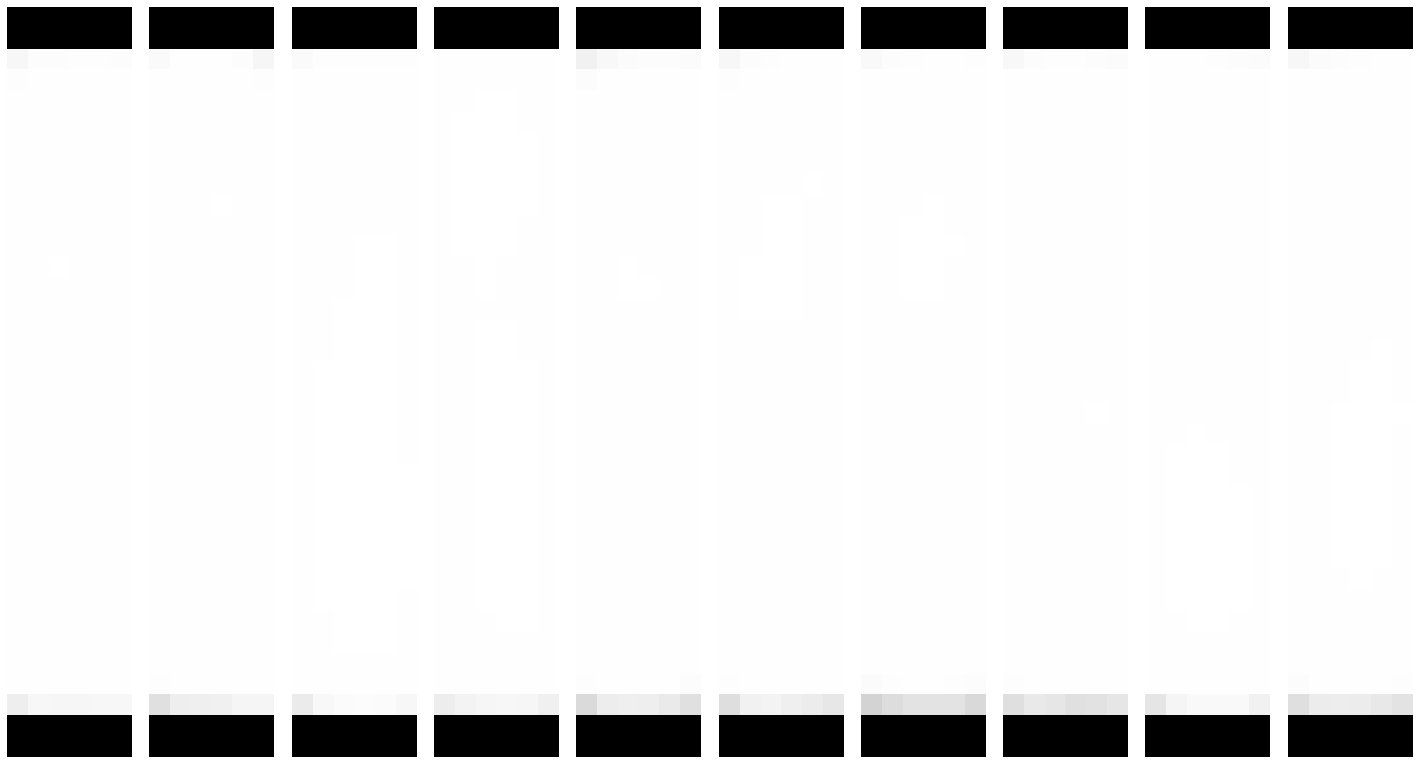

Epoch 20/200
8/8 - 1s - loss: 1.1405 - d_loss: 0.3583 - g_loss: 0.7822


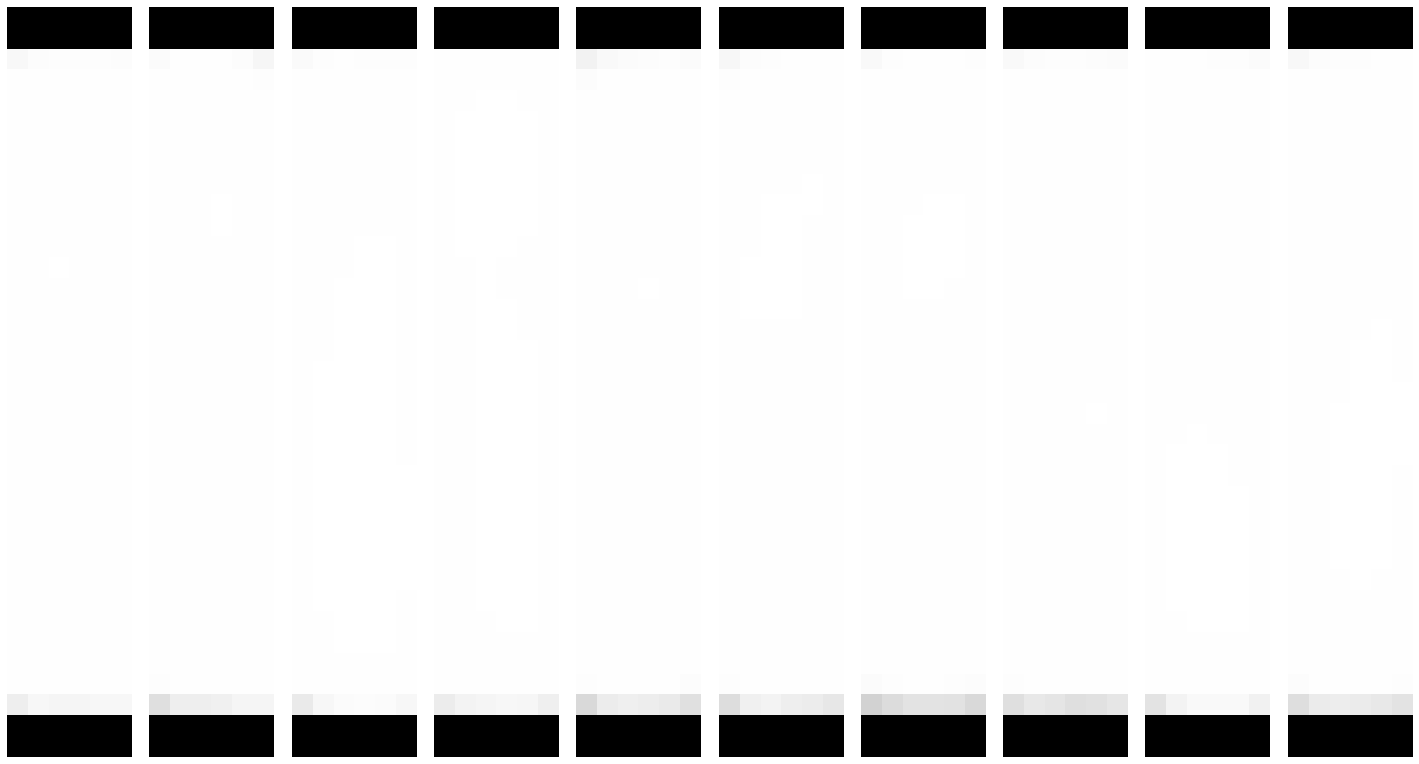

Epoch 21/200
8/8 - 1s - loss: 1.1461 - d_loss: 0.3530 - g_loss: 0.7931


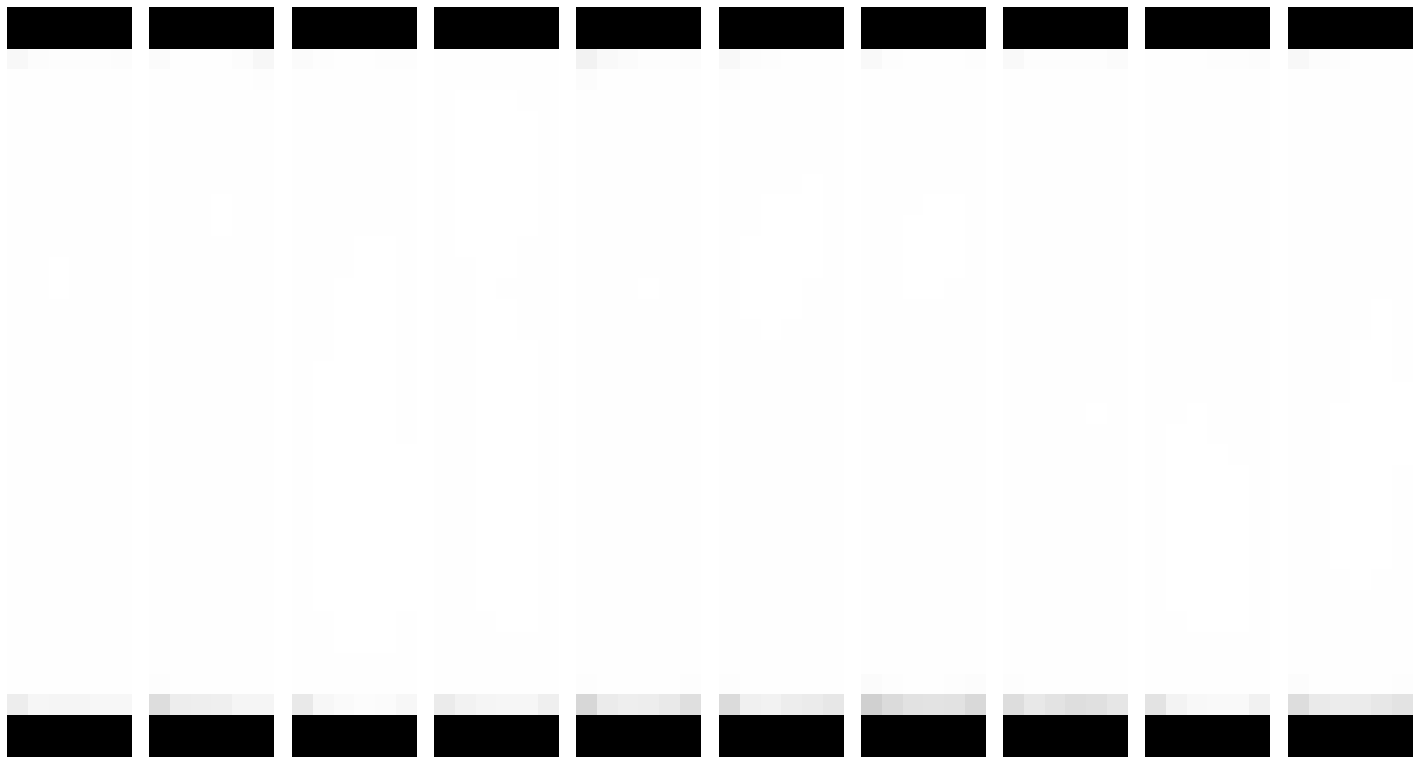

Epoch 22/200
8/8 - 1s - loss: 1.1516 - d_loss: 0.3474 - g_loss: 0.8042


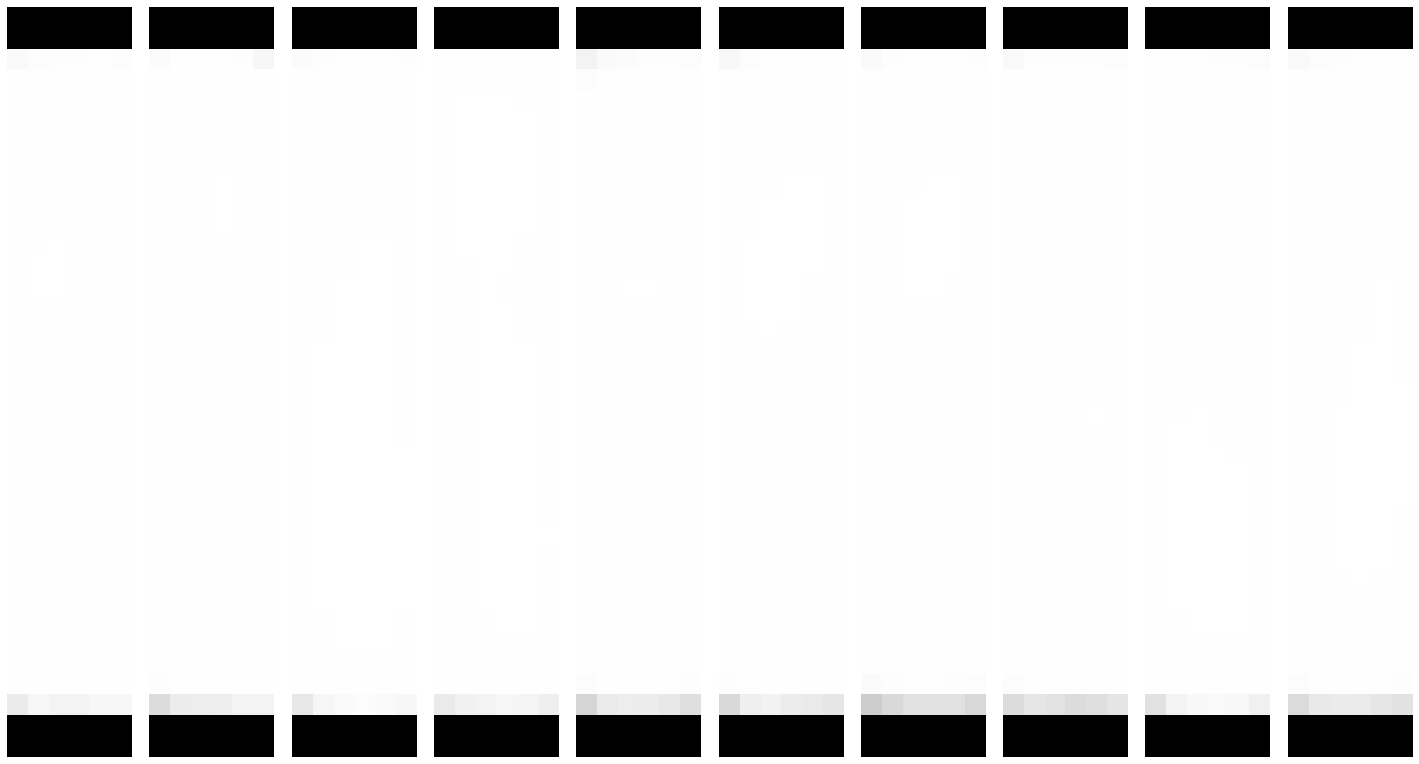

Epoch 23/200
8/8 - 1s - loss: 1.1579 - d_loss: 0.3423 - g_loss: 0.8156


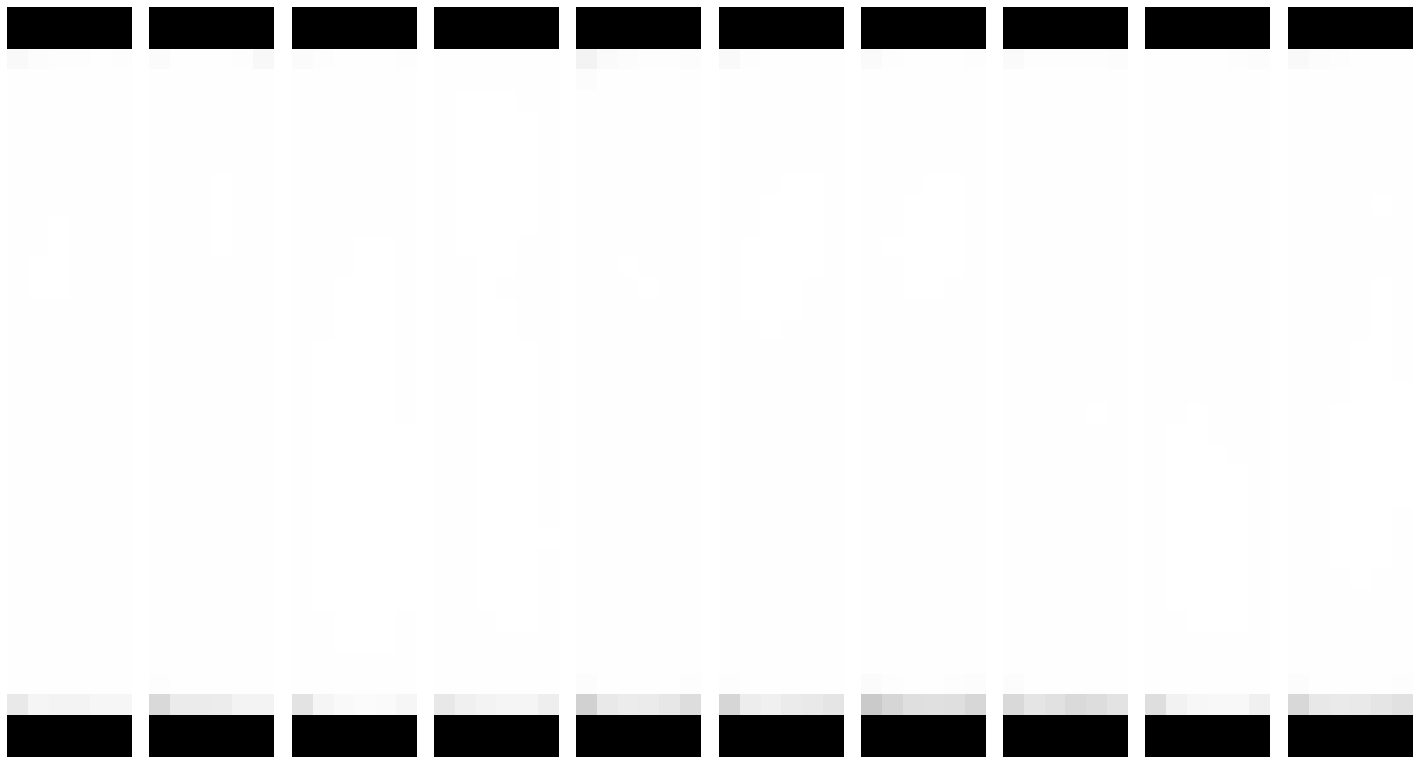

Epoch 24/200
8/8 - 1s - loss: 1.1642 - d_loss: 0.3367 - g_loss: 0.8275


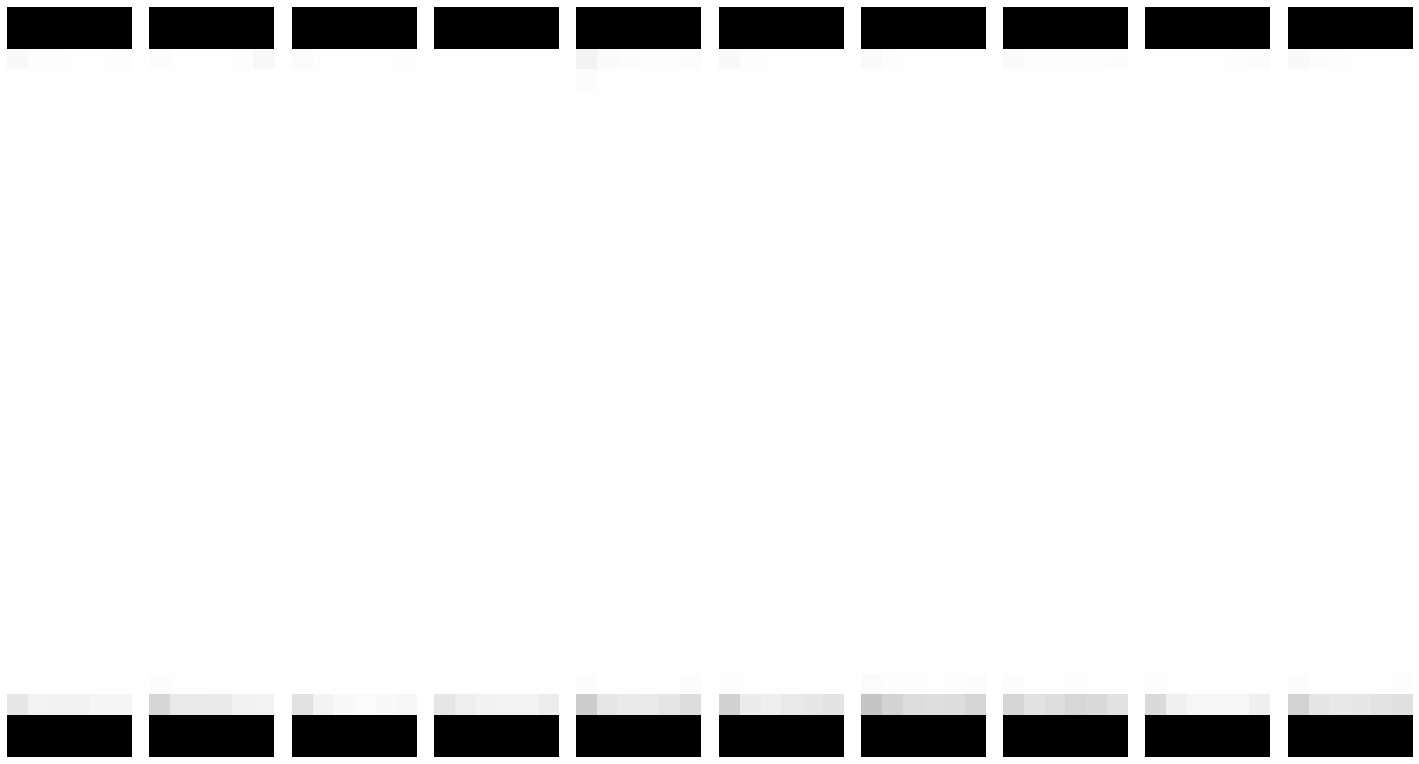

Epoch 25/200
8/8 - 1s - loss: 1.1713 - d_loss: 0.3311 - g_loss: 0.8402


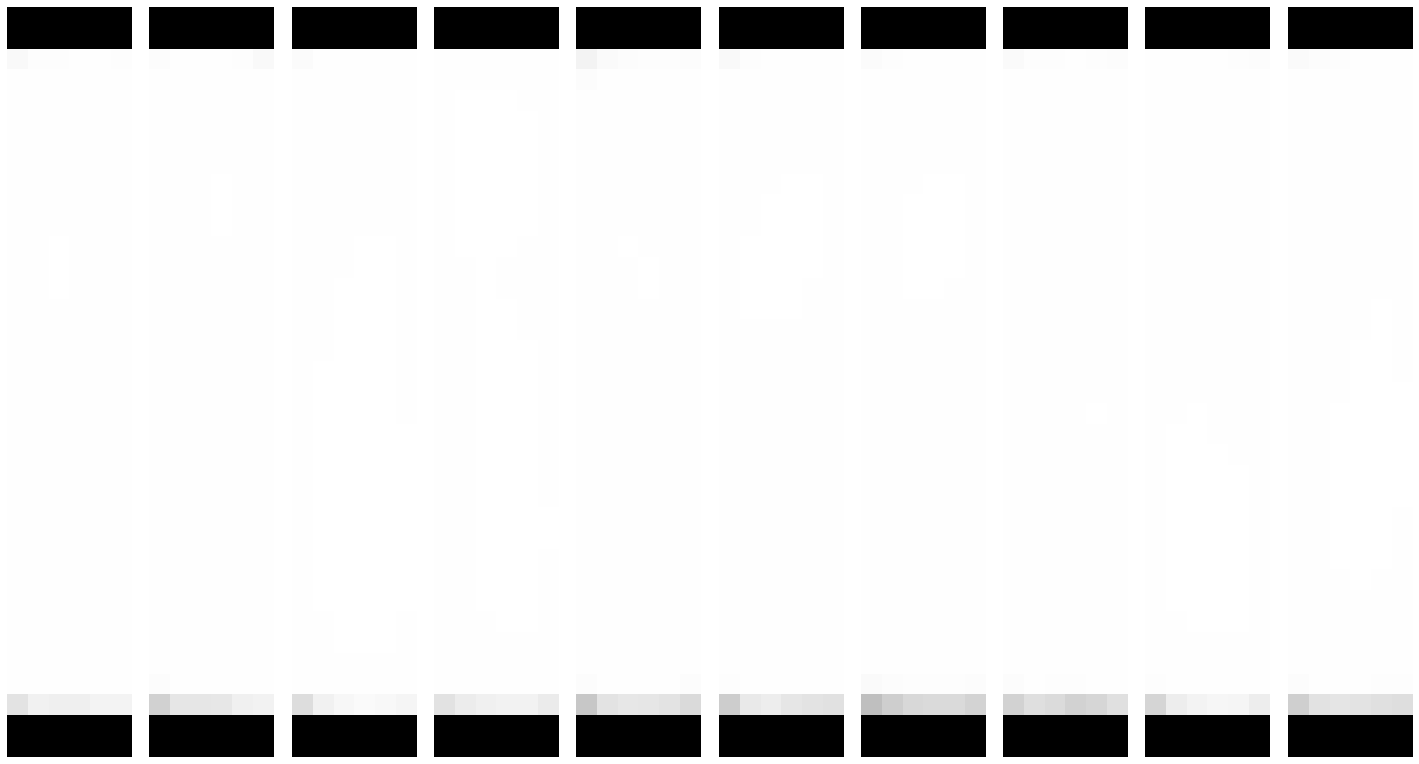

Epoch 26/200
8/8 - 1s - loss: 1.1786 - d_loss: 0.3251 - g_loss: 0.8535


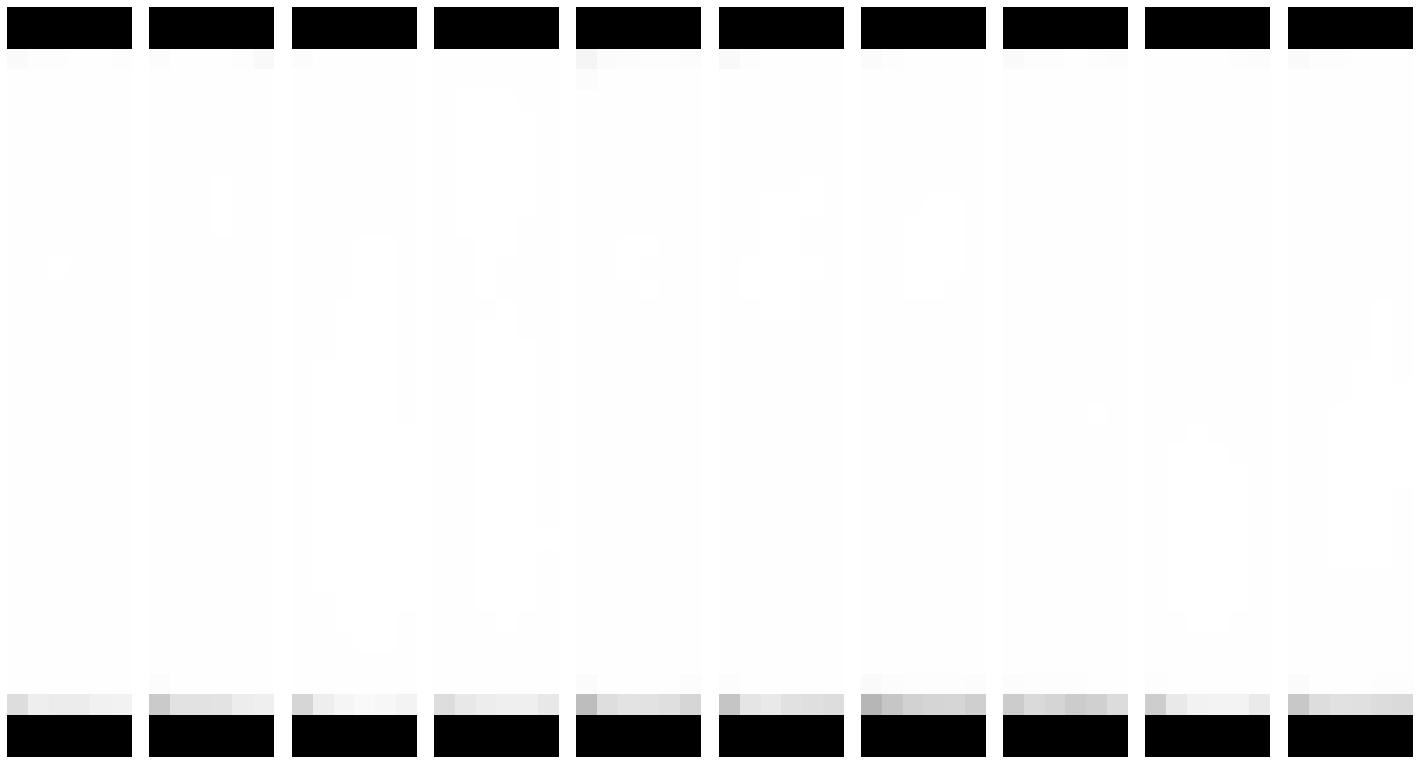

Epoch 27/200
8/8 - 1s - loss: 1.1867 - d_loss: 0.3191 - g_loss: 0.8676


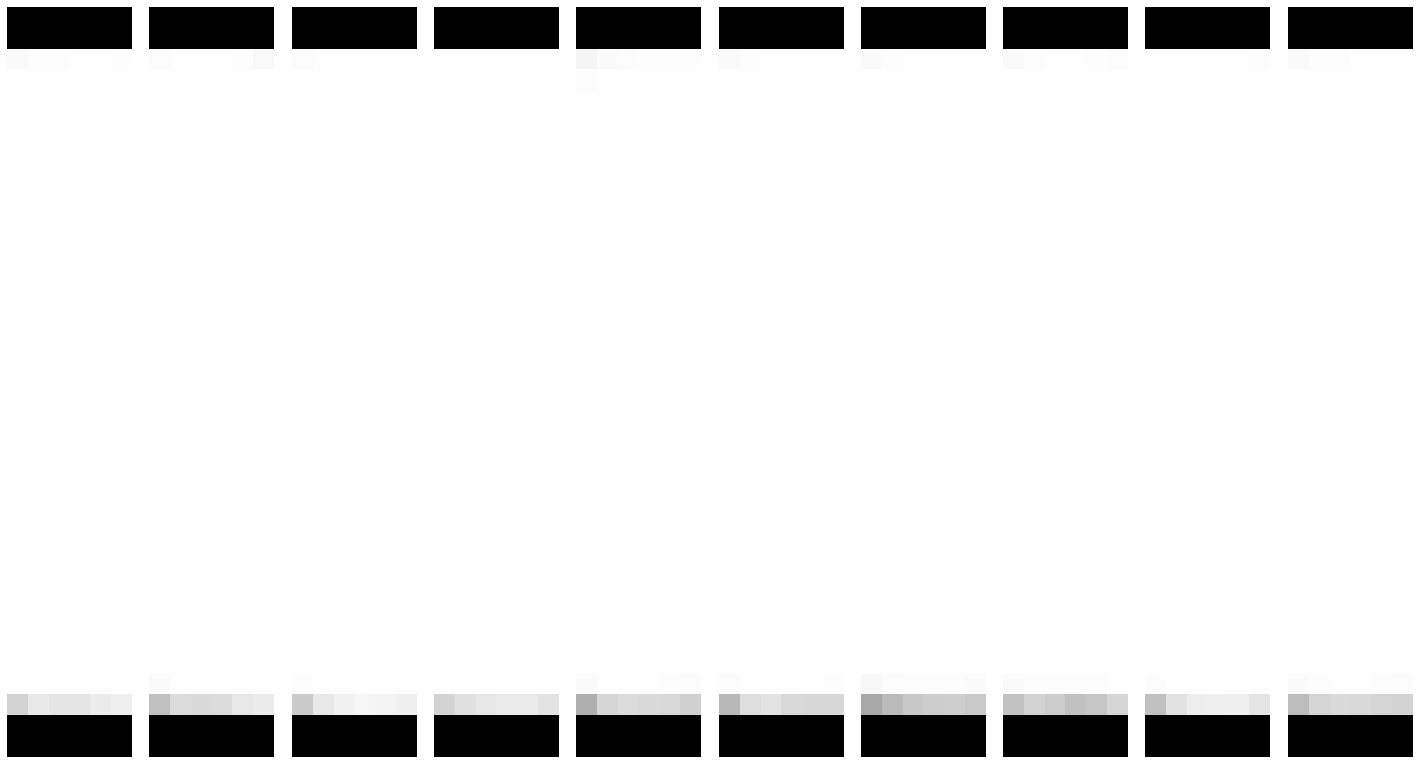

Epoch 28/200
8/8 - 1s - loss: 1.1967 - d_loss: 0.3138 - g_loss: 0.8829


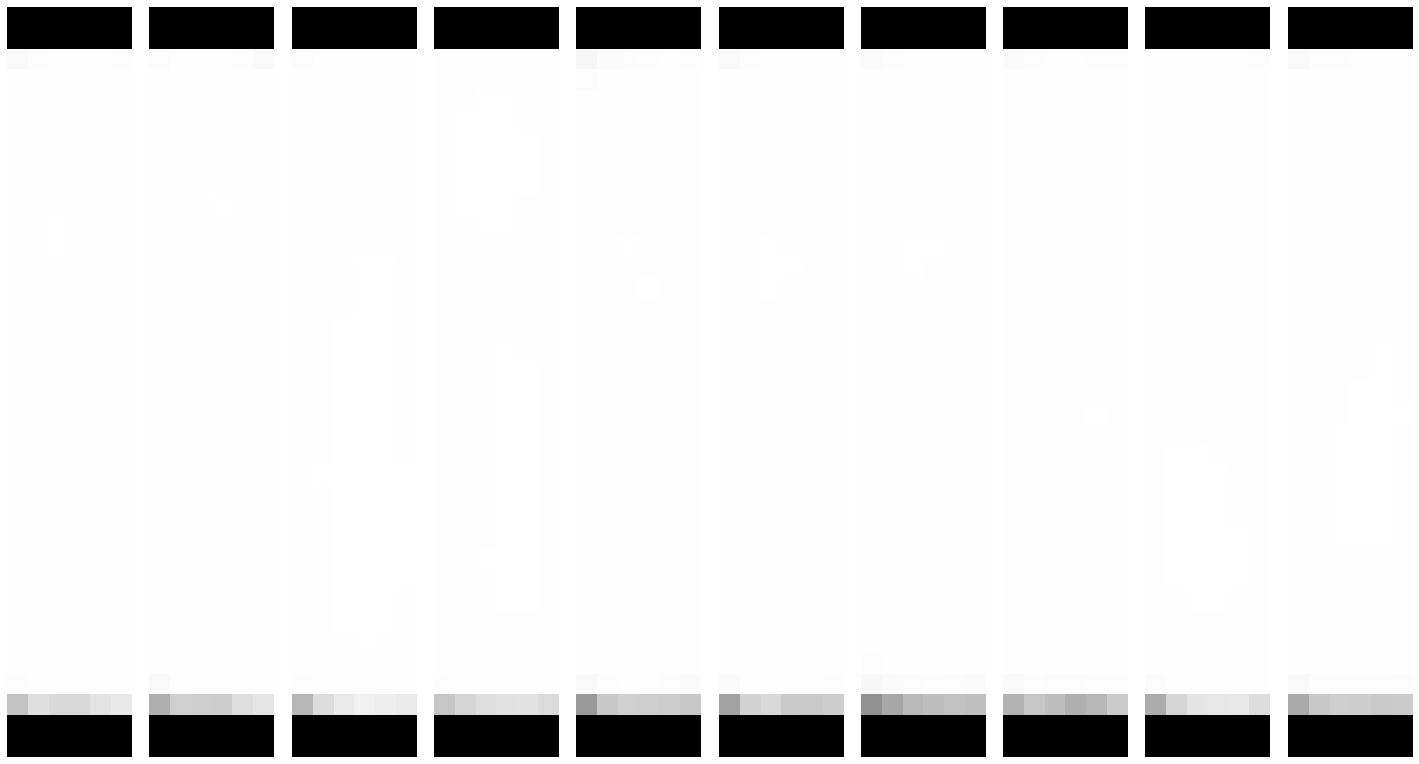

Epoch 29/200
8/8 - 1s - loss: 1.2063 - d_loss: 0.3067 - g_loss: 0.8995


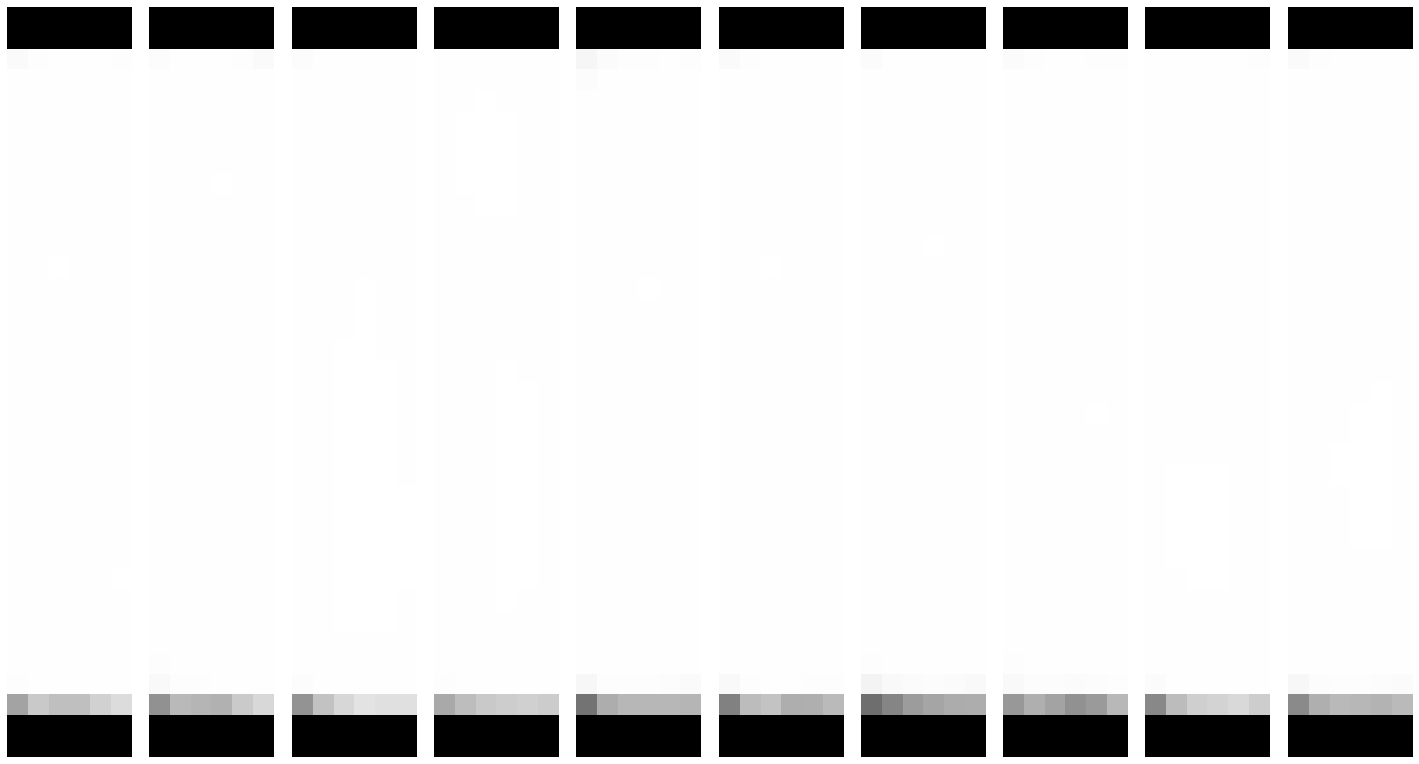

Epoch 30/200
8/8 - 1s - loss: 1.2173 - d_loss: 0.2998 - g_loss: 0.9175


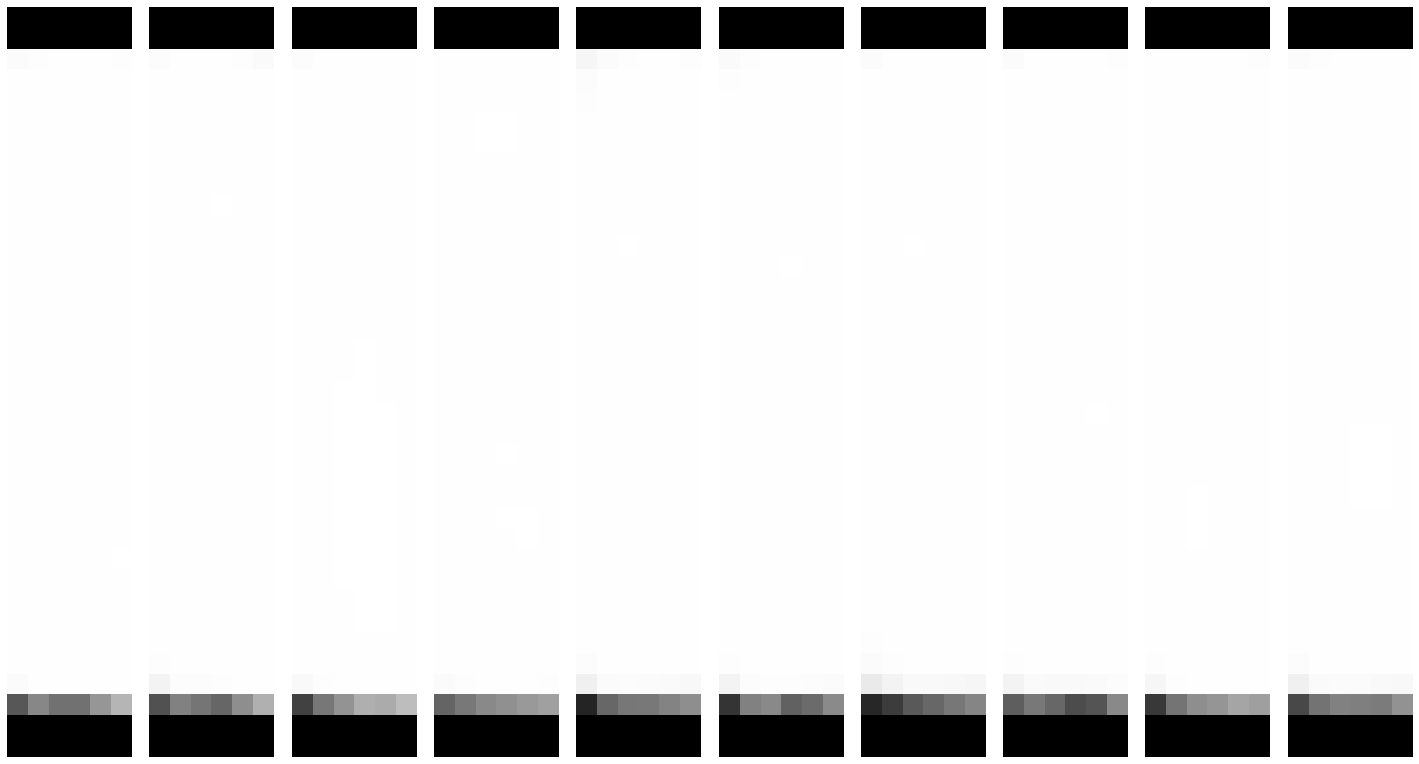

Epoch 31/200
8/8 - 1s - loss: 1.2295 - d_loss: 0.2936 - g_loss: 0.9359


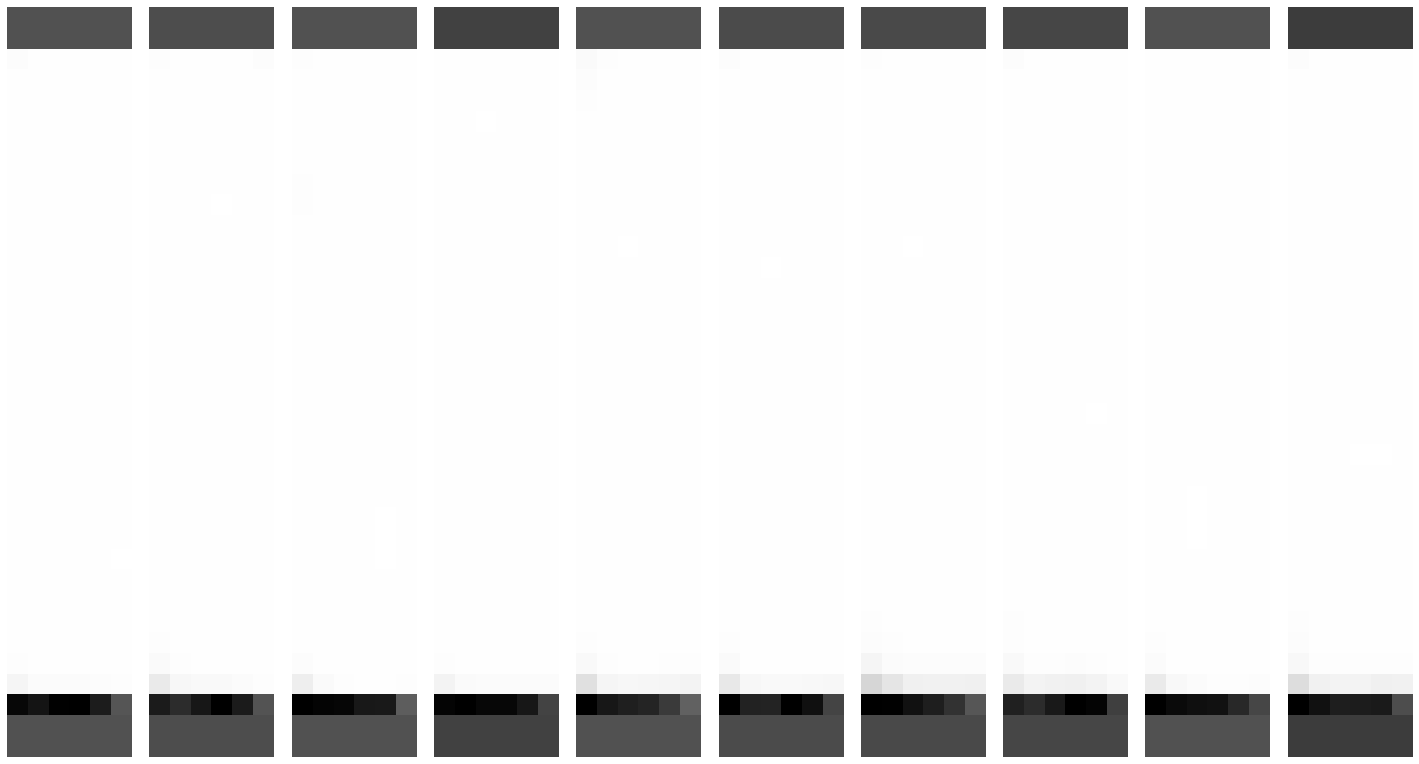

Epoch 32/200
8/8 - 1s - loss: 1.2395 - d_loss: 0.2880 - g_loss: 0.9515


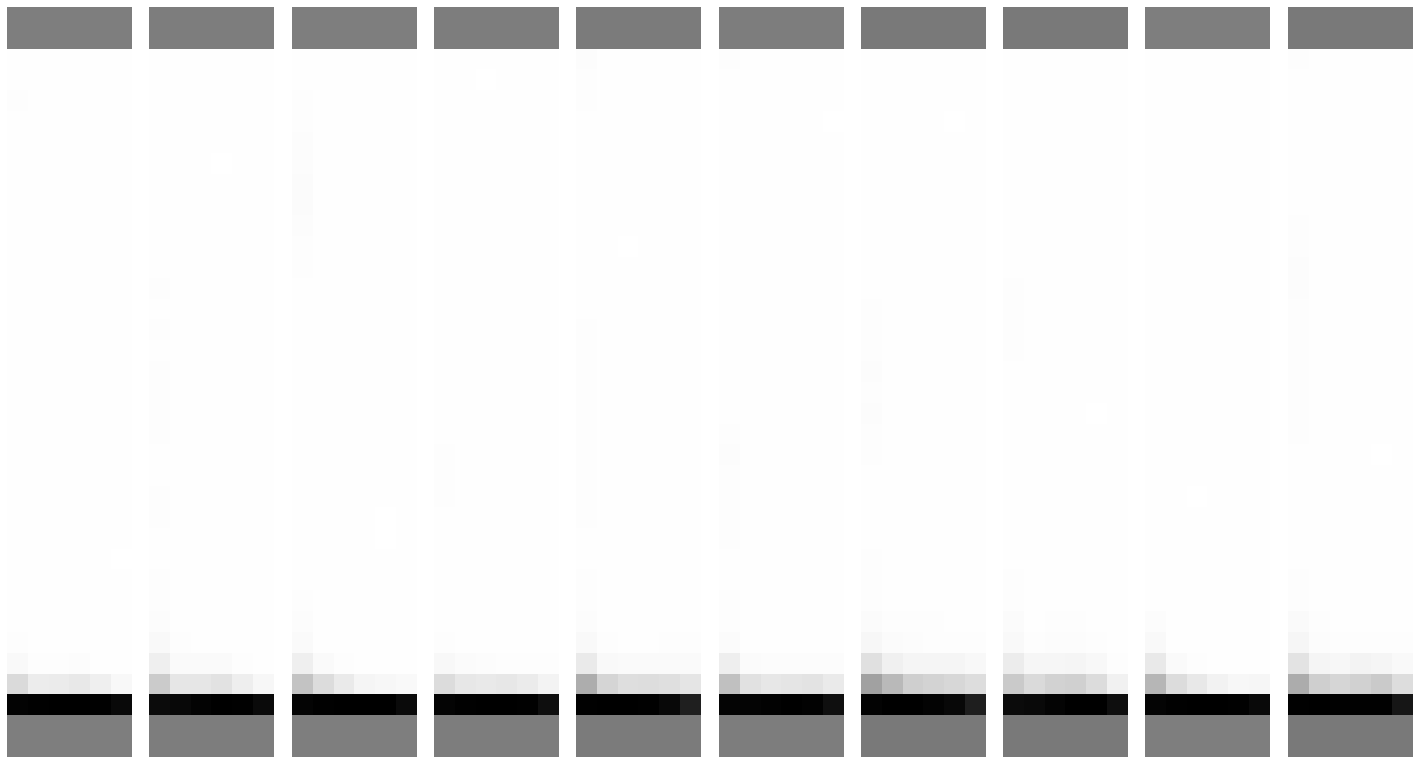

Epoch 33/200
8/8 - 1s - loss: 1.2544 - d_loss: 0.2812 - g_loss: 0.9732


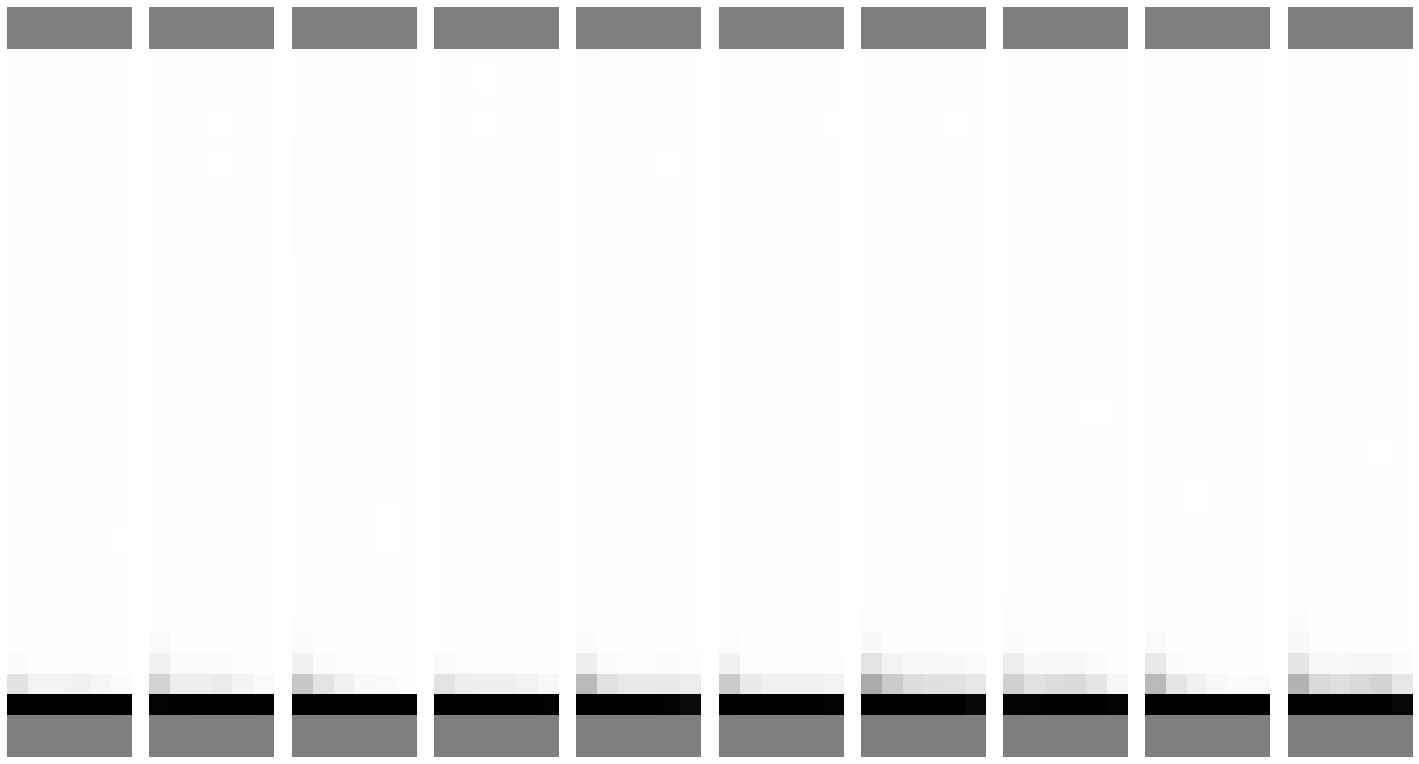

Epoch 34/200
8/8 - 1s - loss: 1.2716 - d_loss: 0.2726 - g_loss: 0.9989


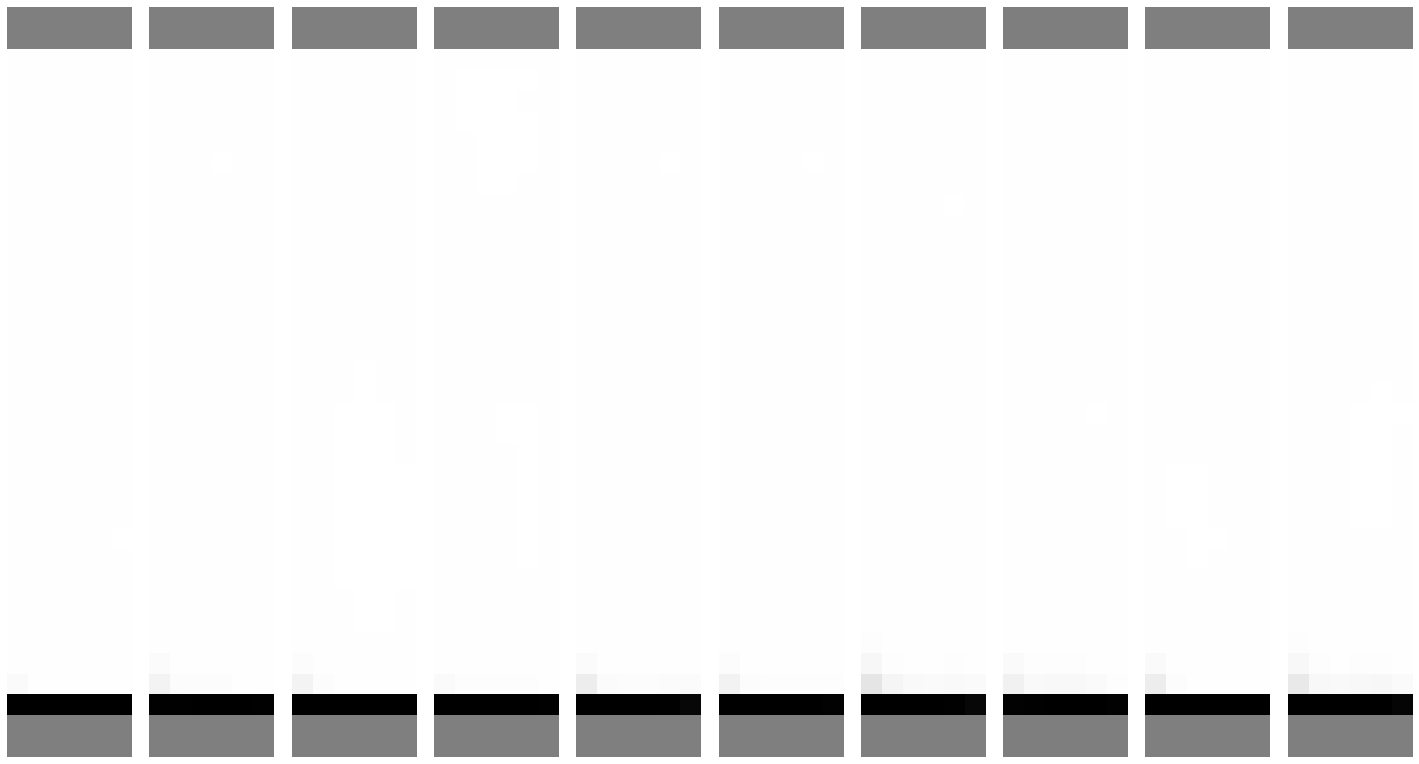

Epoch 35/200
8/8 - 1s - loss: 1.2923 - d_loss: 0.2636 - g_loss: 1.0286


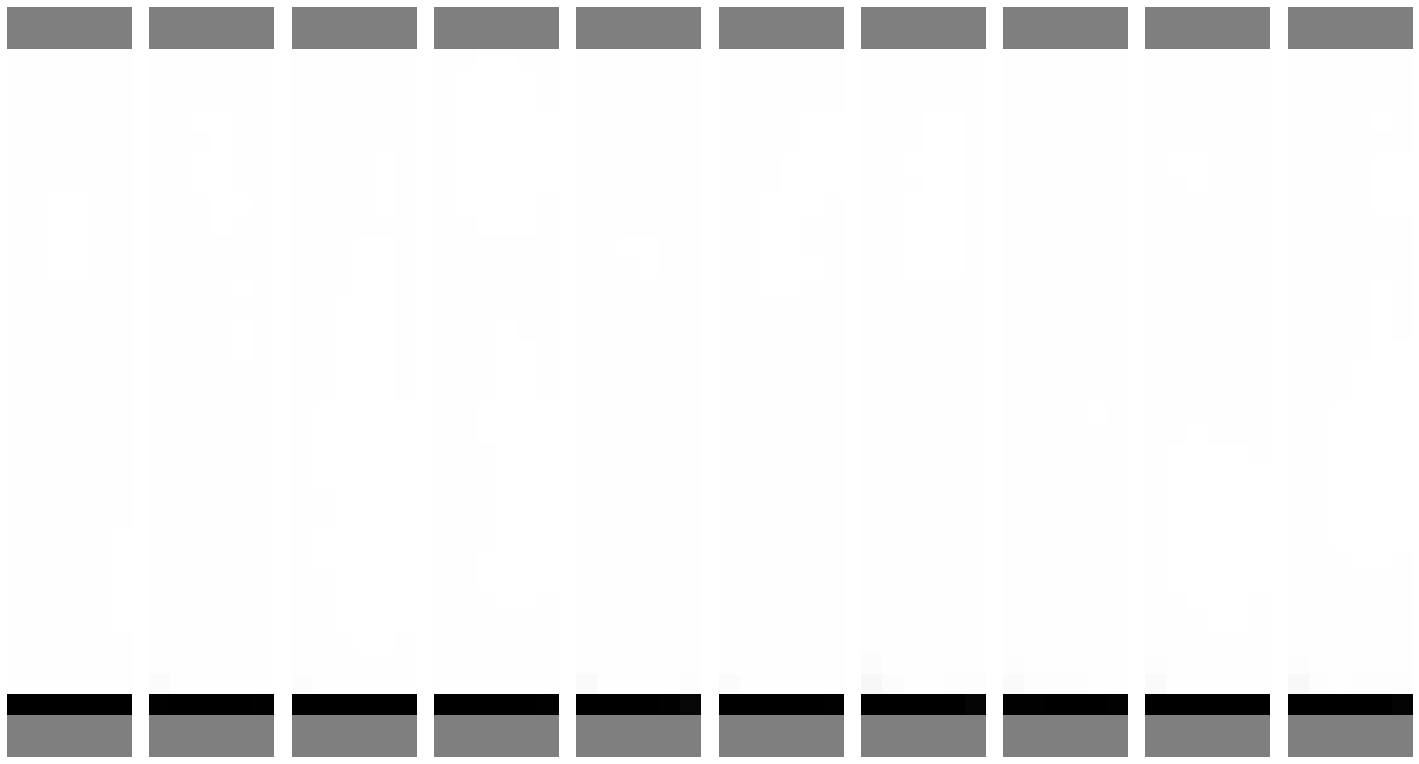

Epoch 36/200
8/8 - 1s - loss: 1.3177 - d_loss: 0.2550 - g_loss: 1.0627


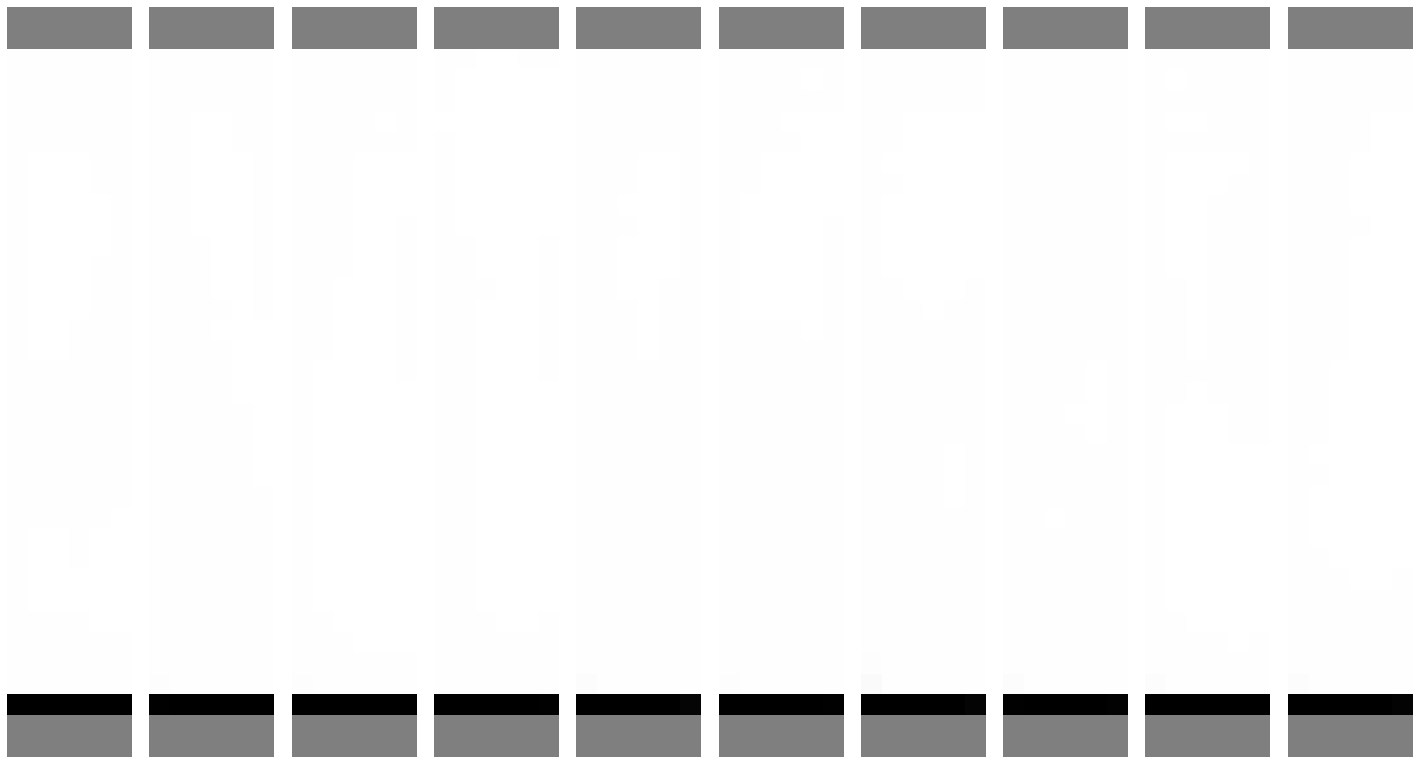

Epoch 37/200
8/8 - 1s - loss: 1.3467 - d_loss: 0.2447 - g_loss: 1.1020


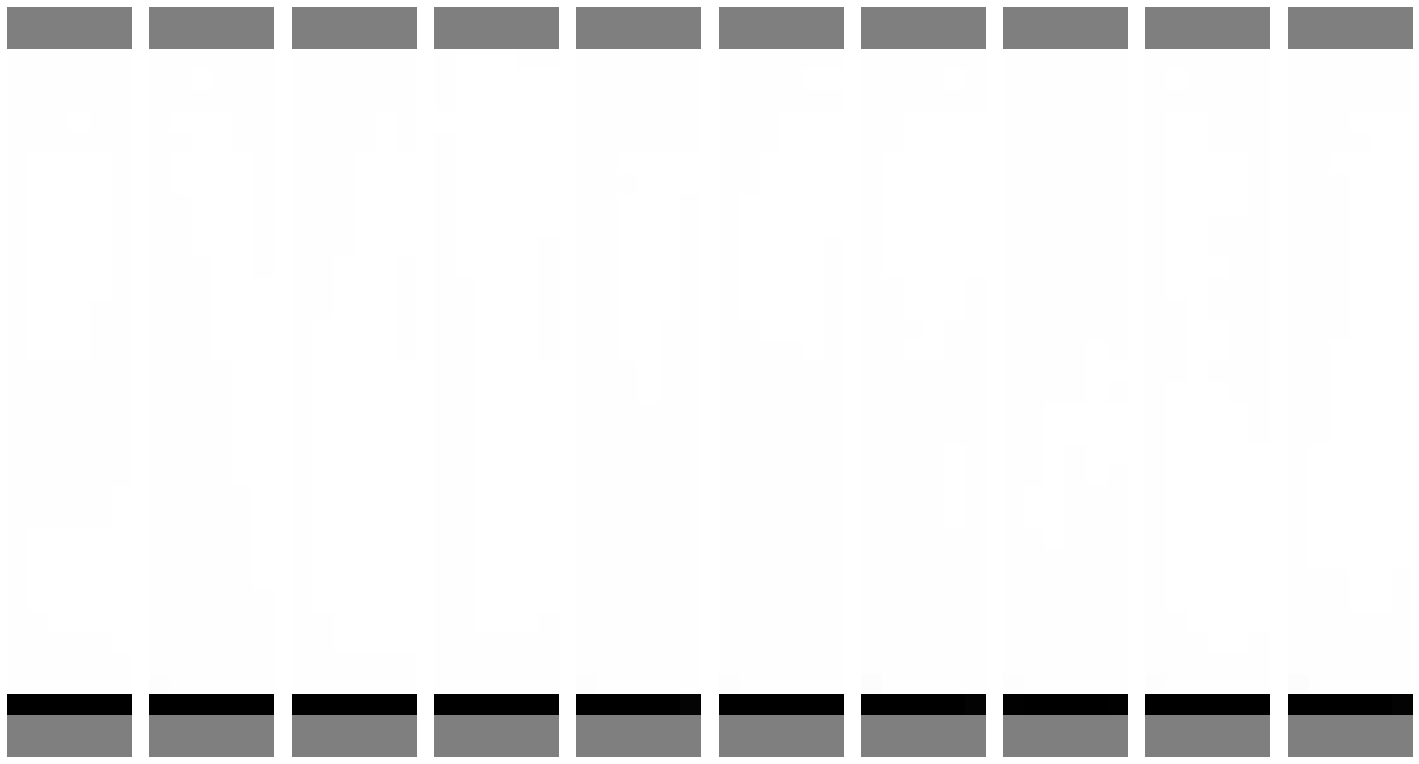

Epoch 38/200
8/8 - 1s - loss: 1.3809 - d_loss: 0.2342 - g_loss: 1.1467


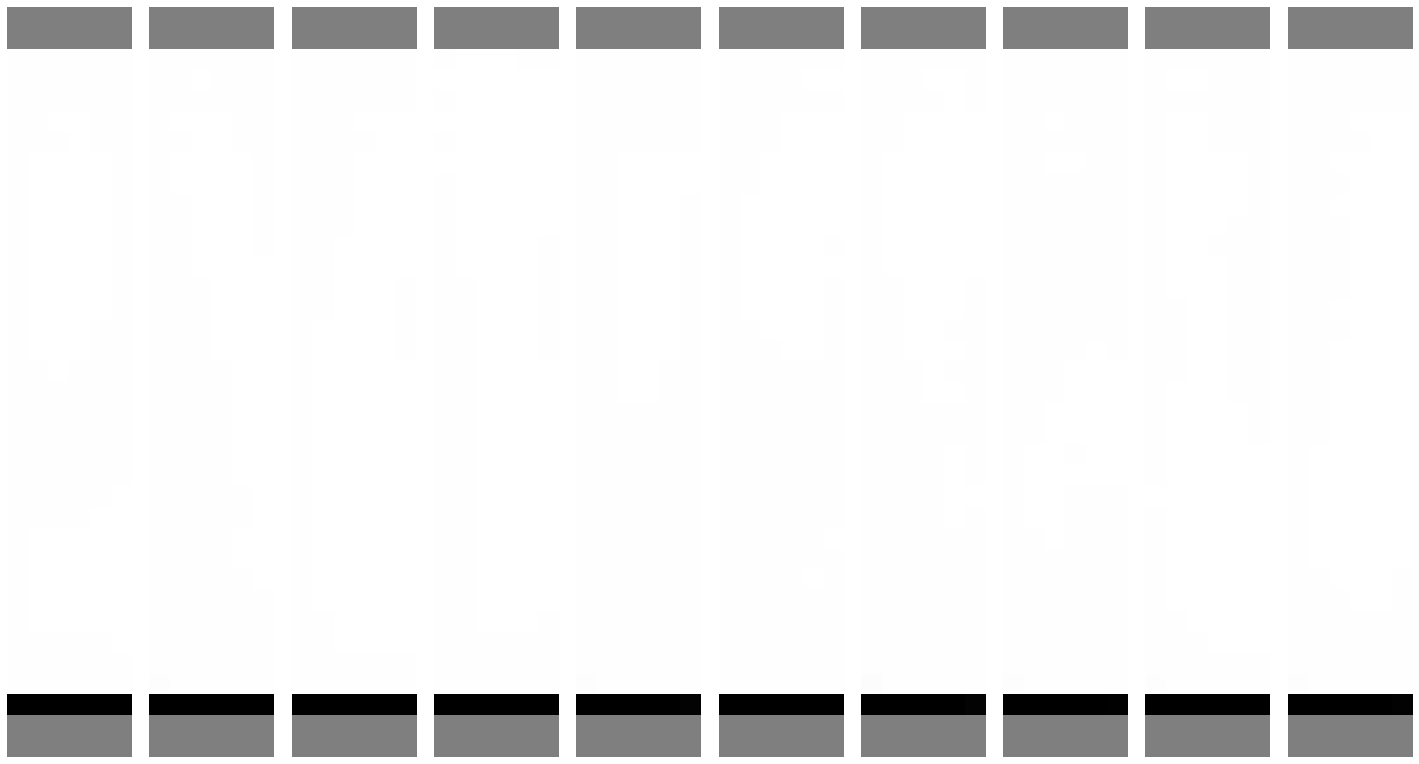

Epoch 39/200
8/8 - 1s - loss: 1.4199 - d_loss: 0.2232 - g_loss: 1.1967


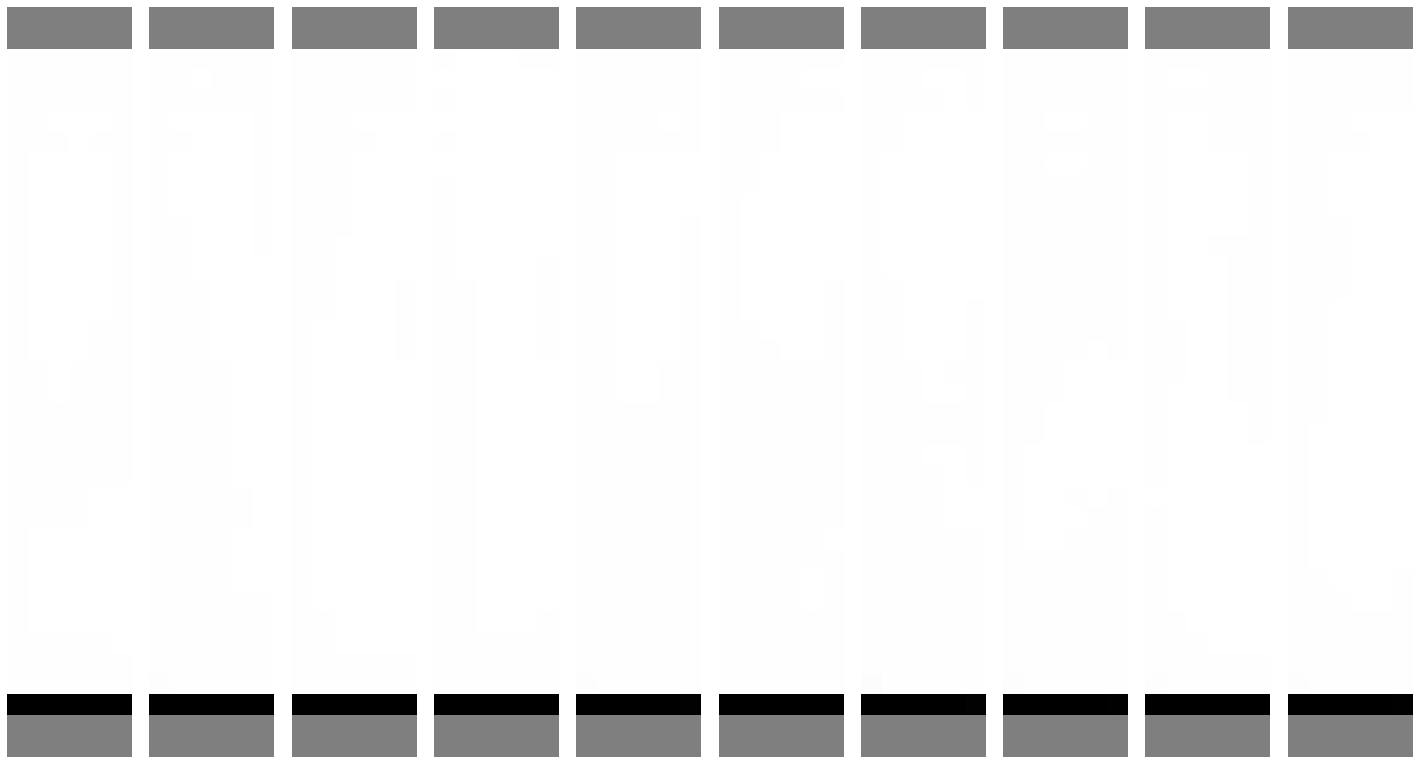

Epoch 40/200
8/8 - 1s - loss: 1.4651 - d_loss: 0.2120 - g_loss: 1.2531


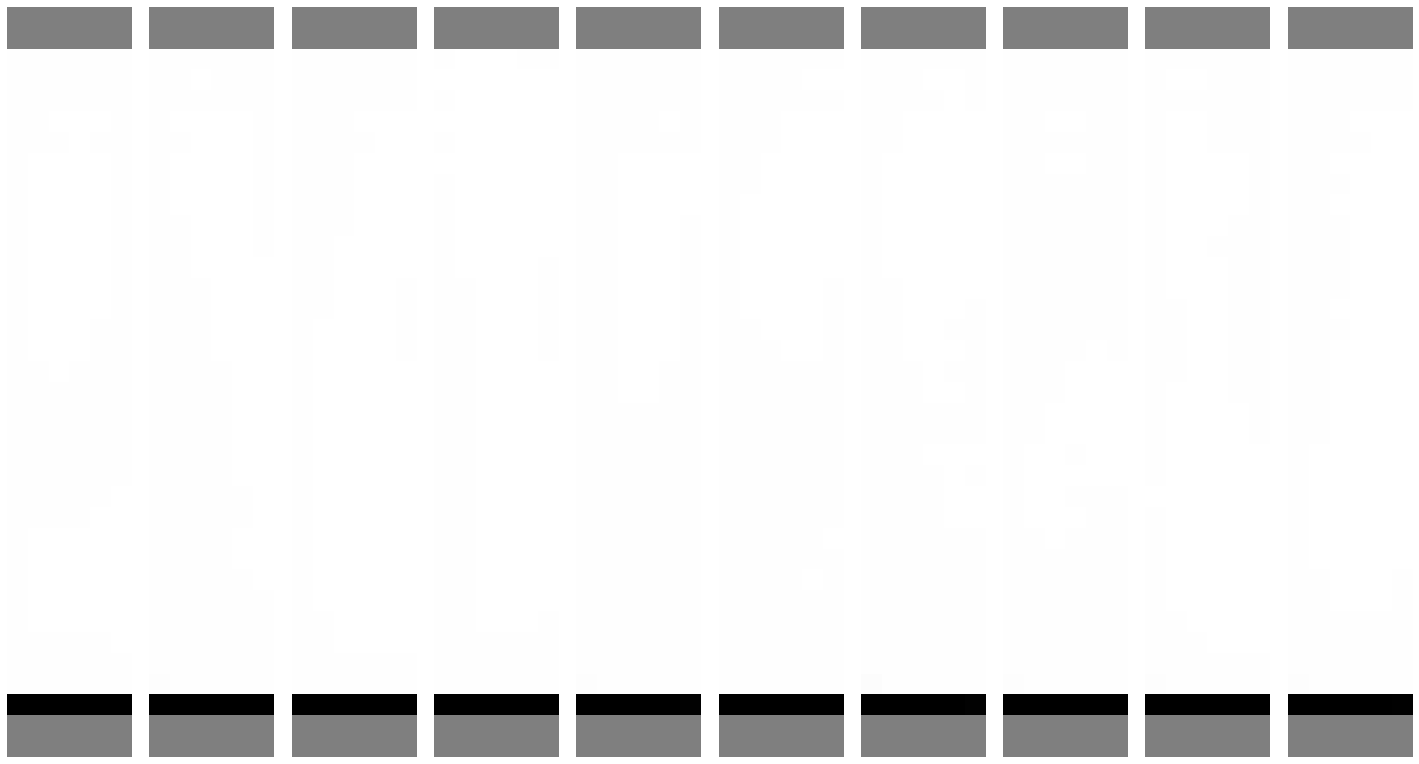

Epoch 41/200
8/8 - 1s - loss: 1.5158 - d_loss: 0.2000 - g_loss: 1.3158


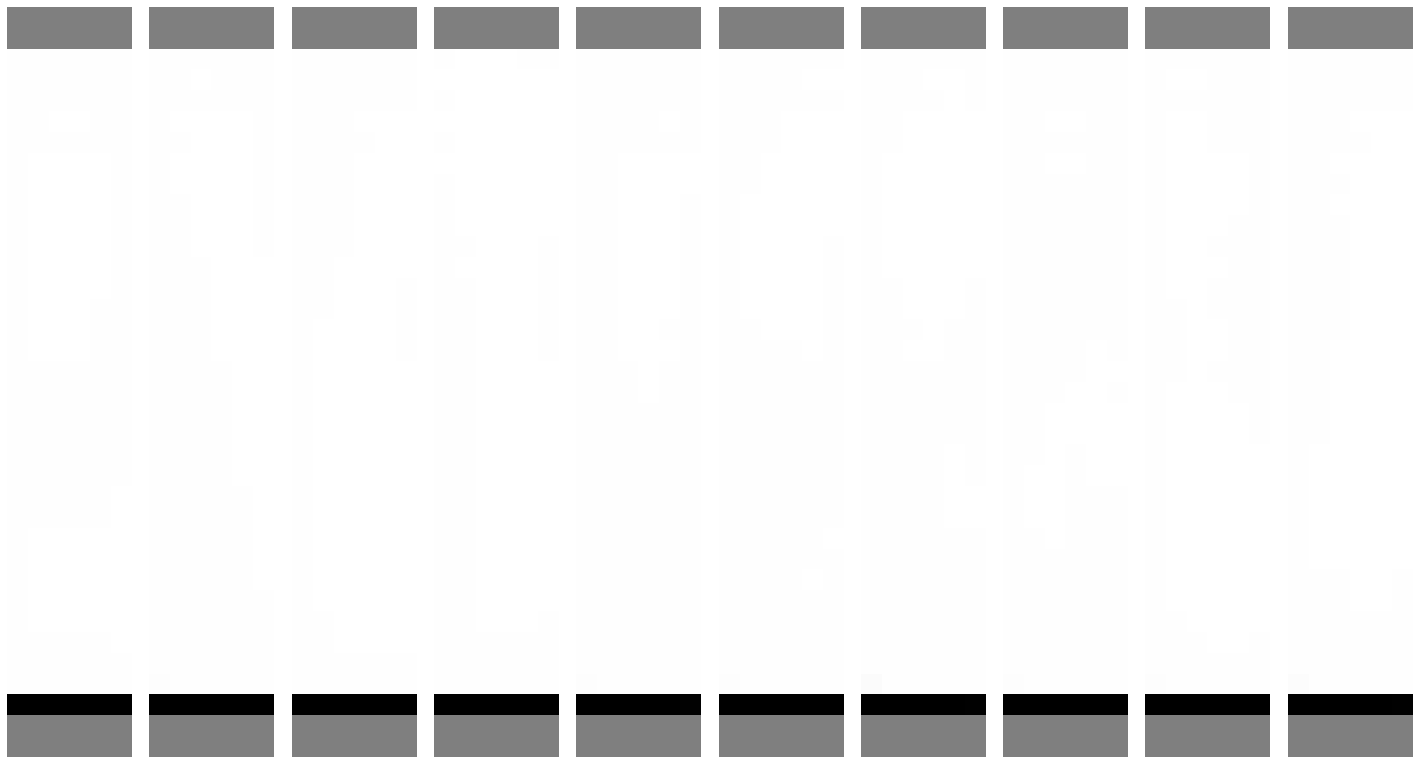

Epoch 42/200
8/8 - 1s - loss: 1.5726 - d_loss: 0.1878 - g_loss: 1.3848


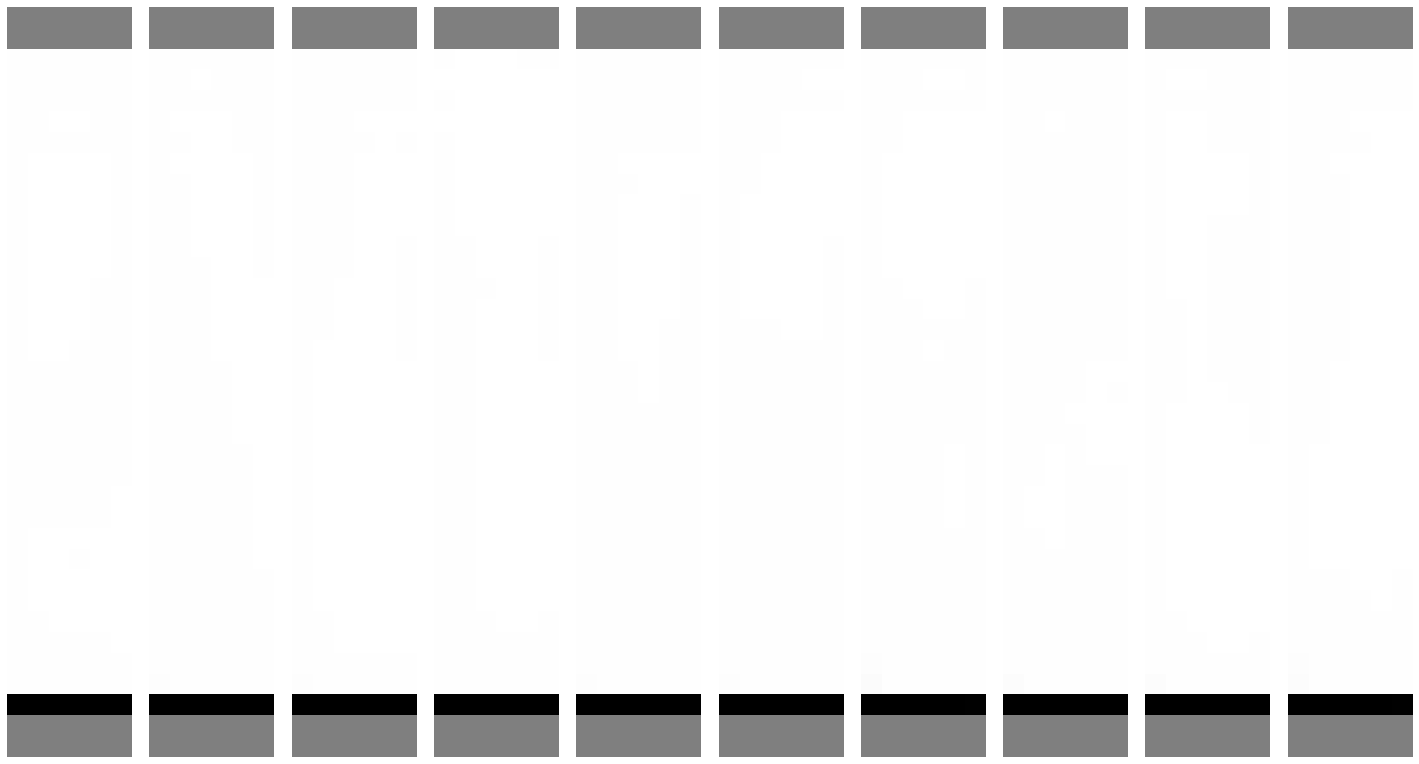

Epoch 43/200
8/8 - 1s - loss: 1.6345 - d_loss: 0.1756 - g_loss: 1.4588


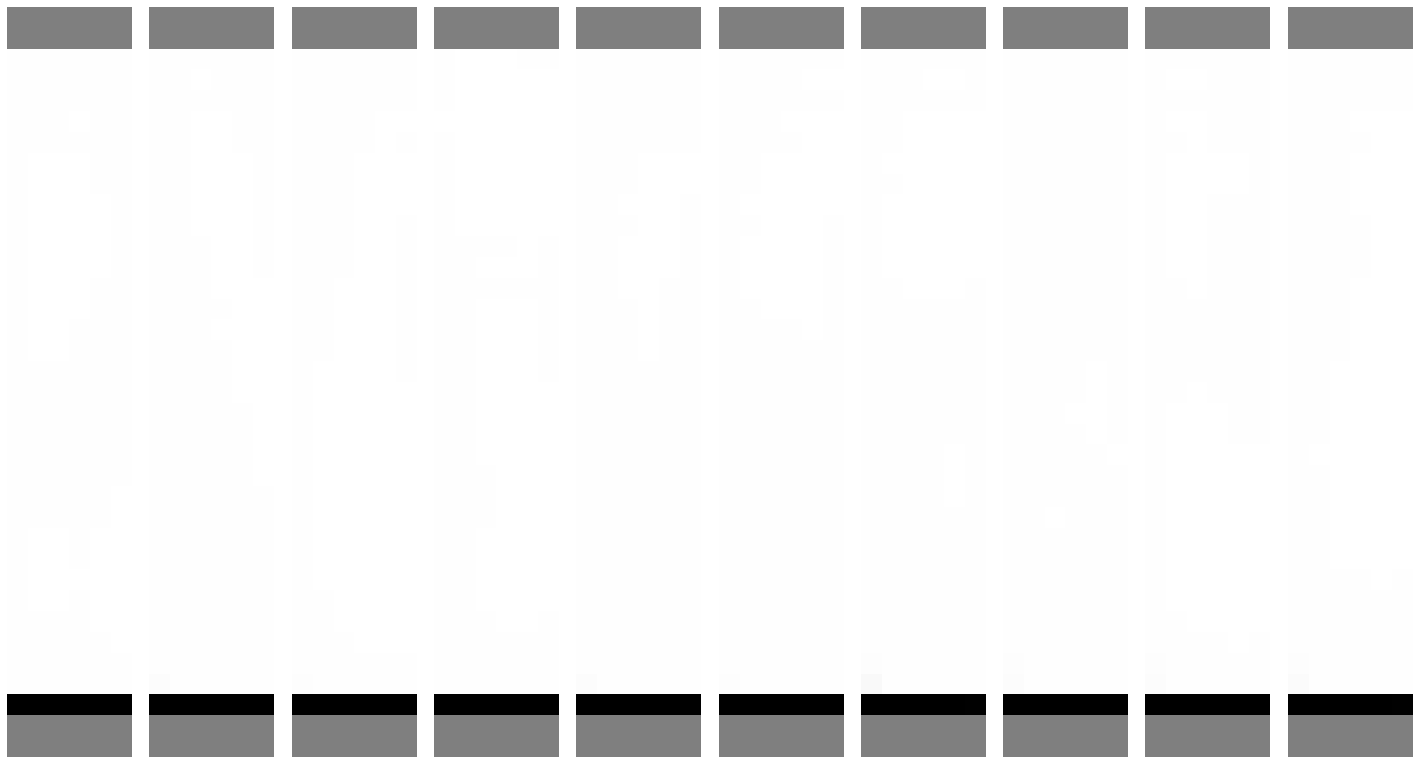

Epoch 44/200
8/8 - 1s - loss: 1.7025 - d_loss: 0.1638 - g_loss: 1.5387


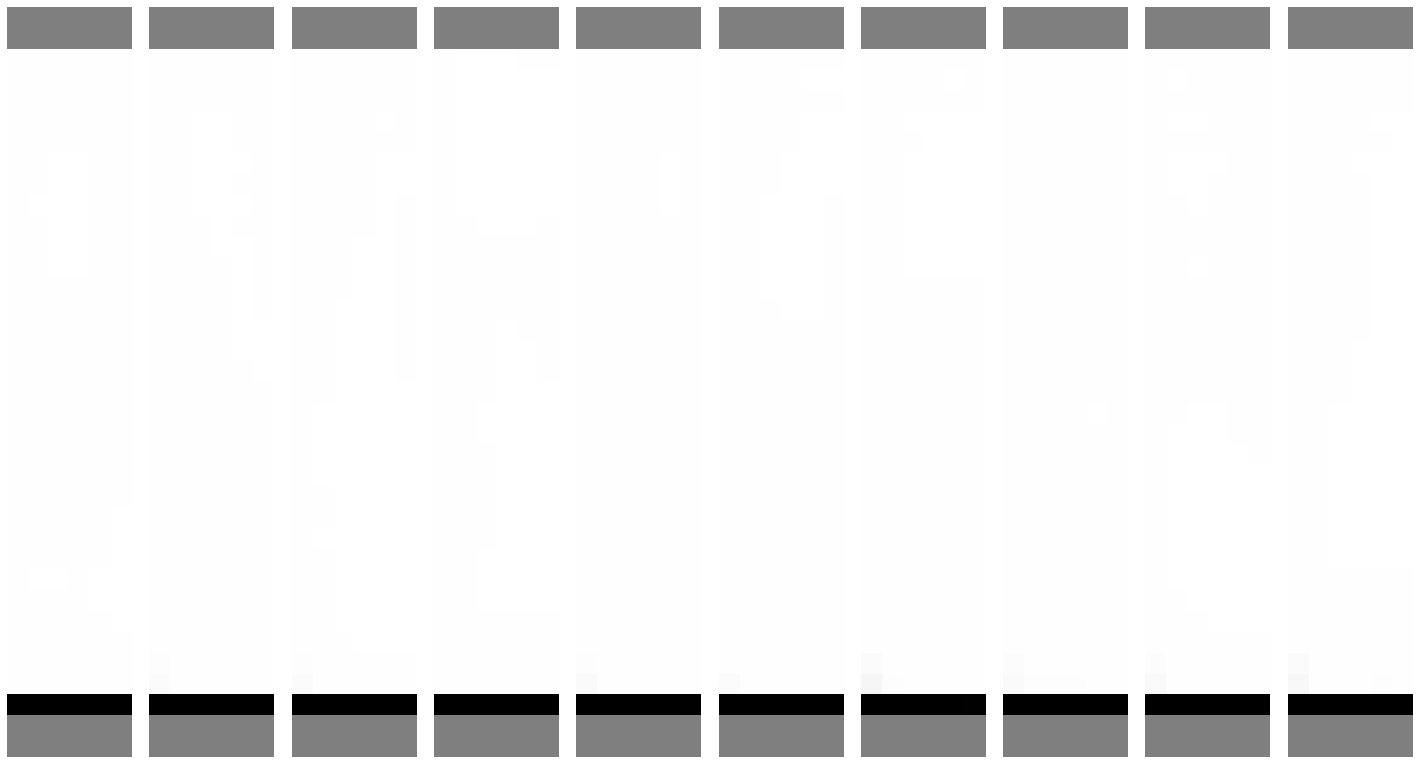

Epoch 45/200
8/8 - 1s - loss: 1.7756 - d_loss: 0.1514 - g_loss: 1.6242


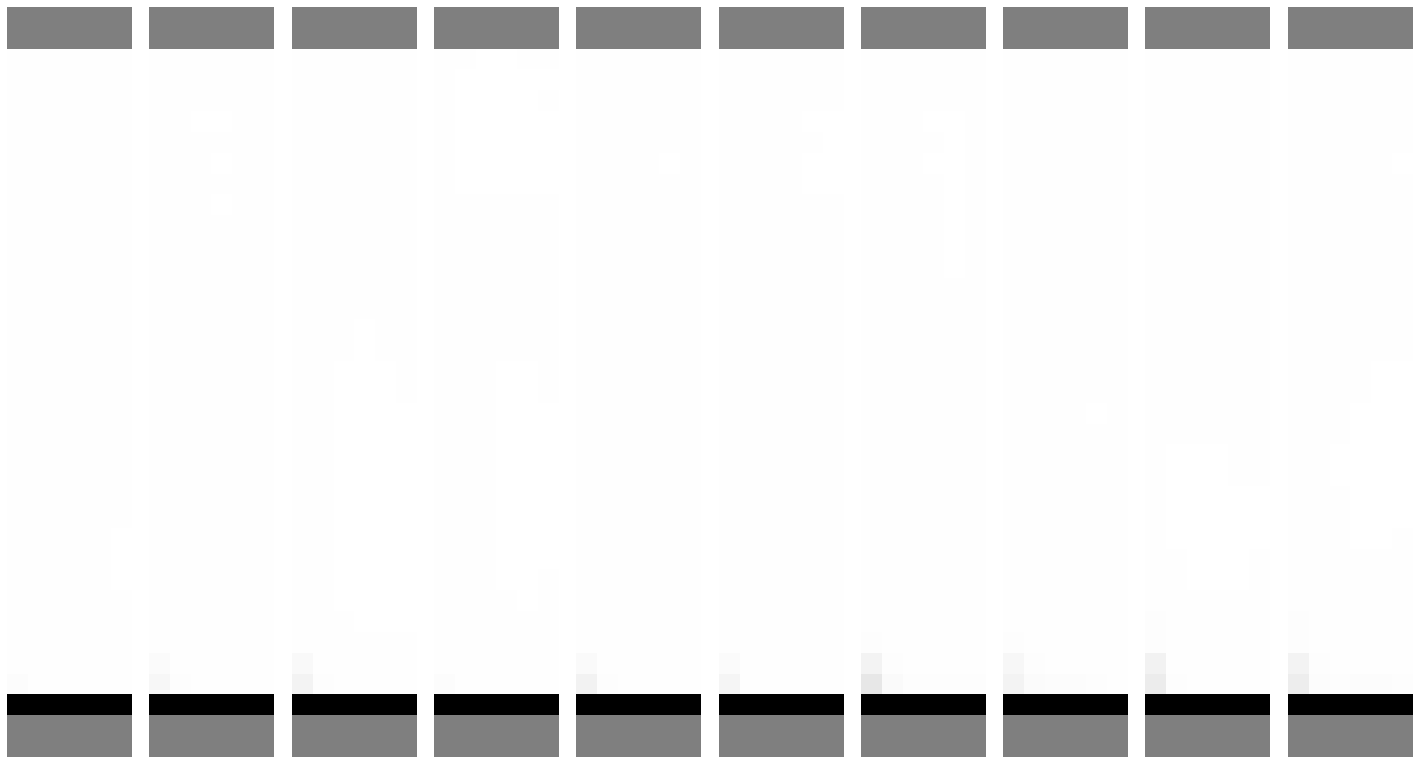

Epoch 46/200
8/8 - 1s - loss: 1.8509 - d_loss: 0.1406 - g_loss: 1.7104


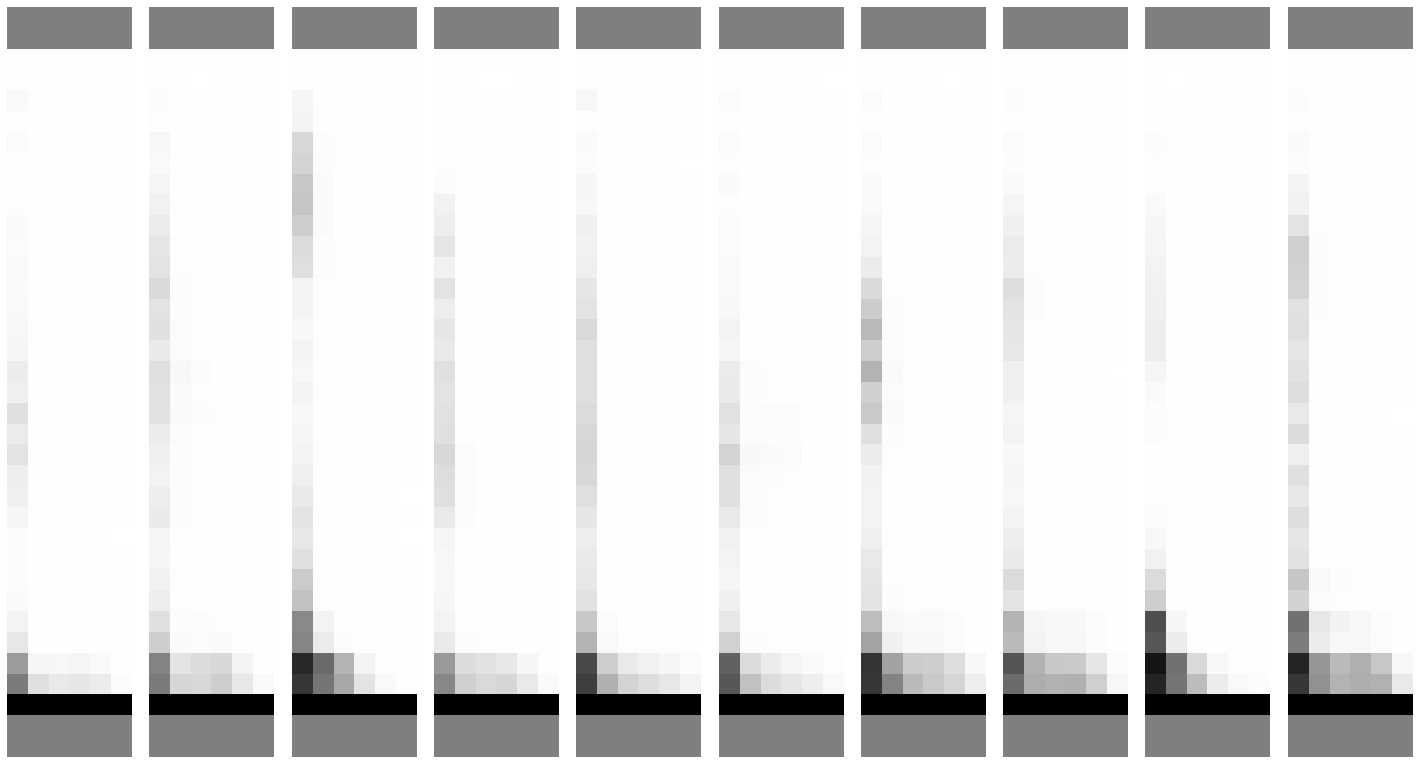

Epoch 47/200
8/8 - 1s - loss: 1.6526 - d_loss: 0.1733 - g_loss: 1.4793


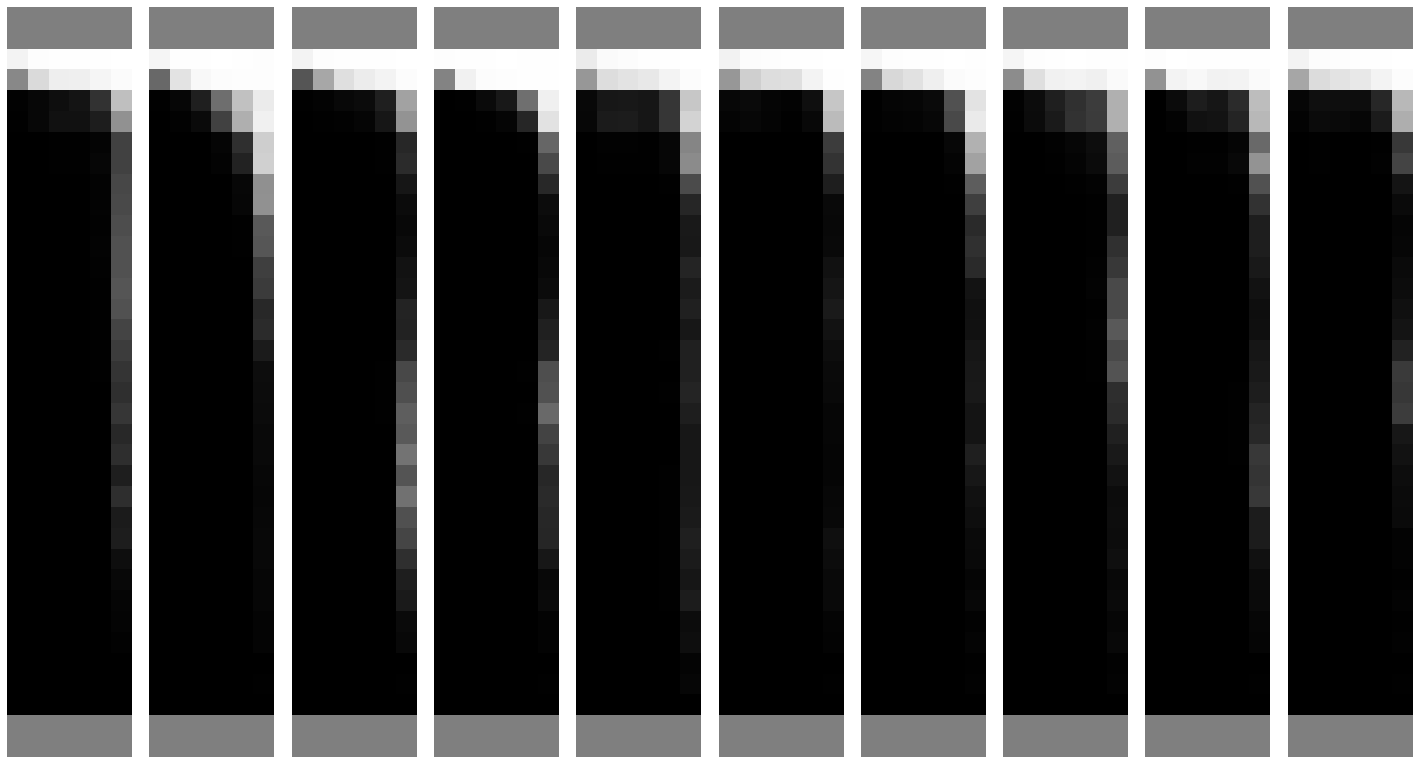

Epoch 48/200
8/8 - 1s - loss: 1.4474 - d_loss: 0.2127 - g_loss: 1.2347


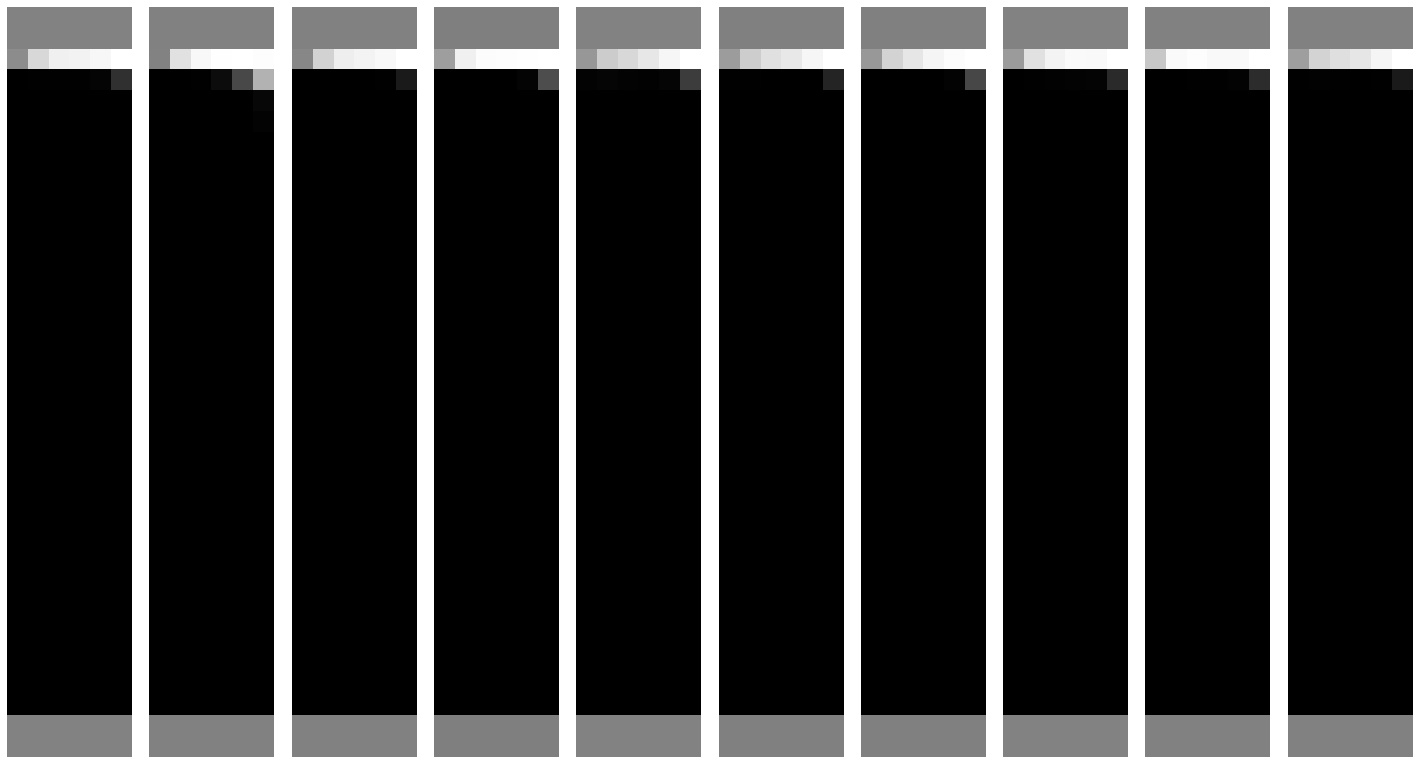

Epoch 49/200
8/8 - 1s - loss: 1.5536 - d_loss: 0.1880 - g_loss: 1.3656


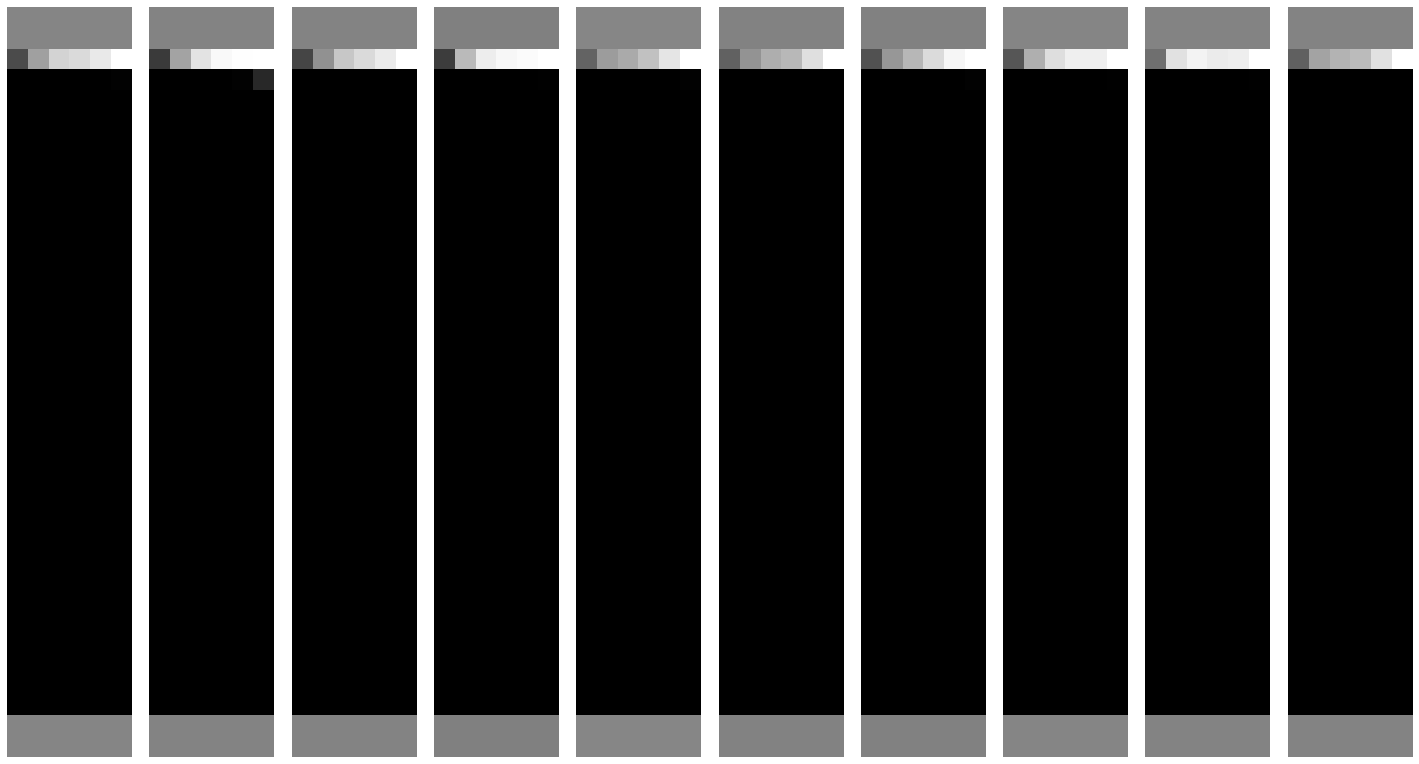

Epoch 50/200
8/8 - 1s - loss: 1.6849 - d_loss: 0.1614 - g_loss: 1.5235


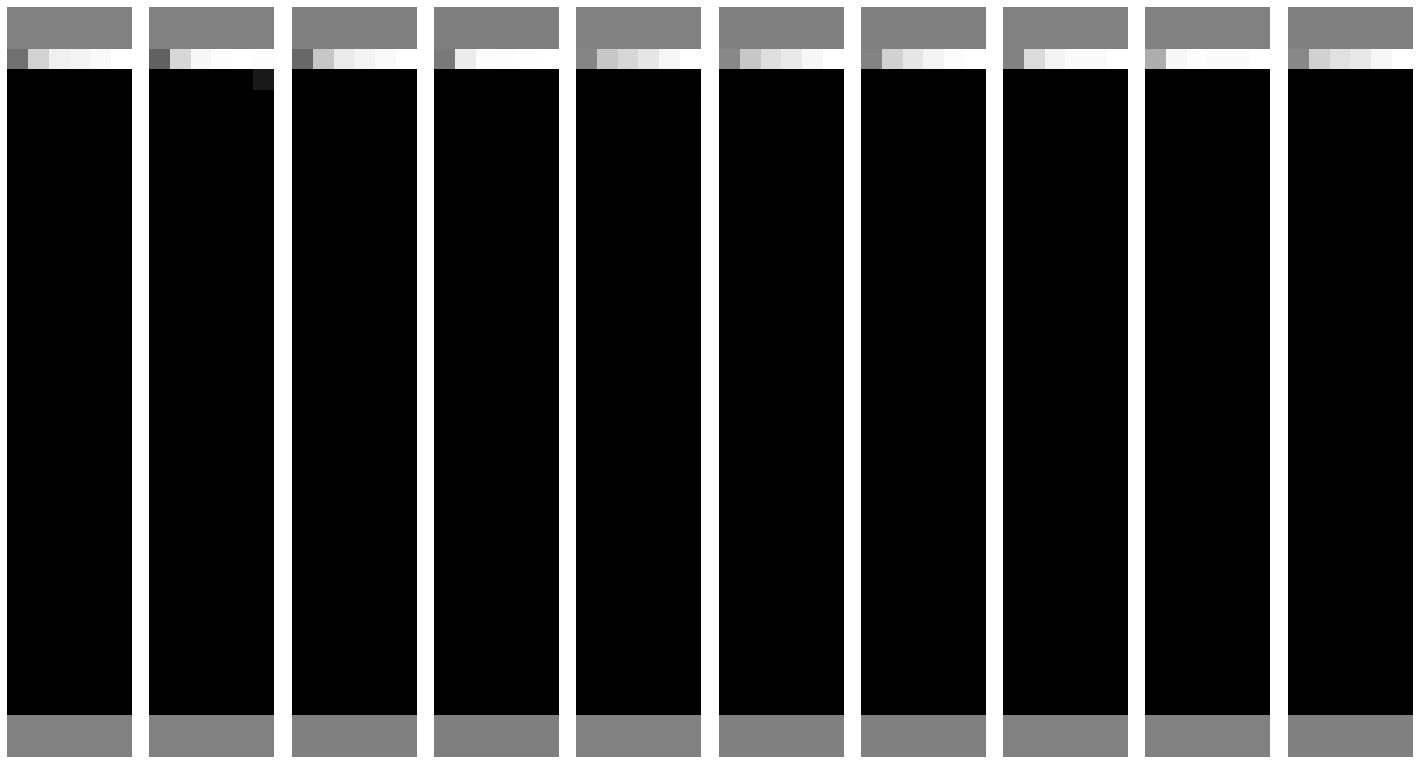

Epoch 51/200
8/8 - 1s - loss: 1.8235 - d_loss: 0.1401 - g_loss: 1.6833


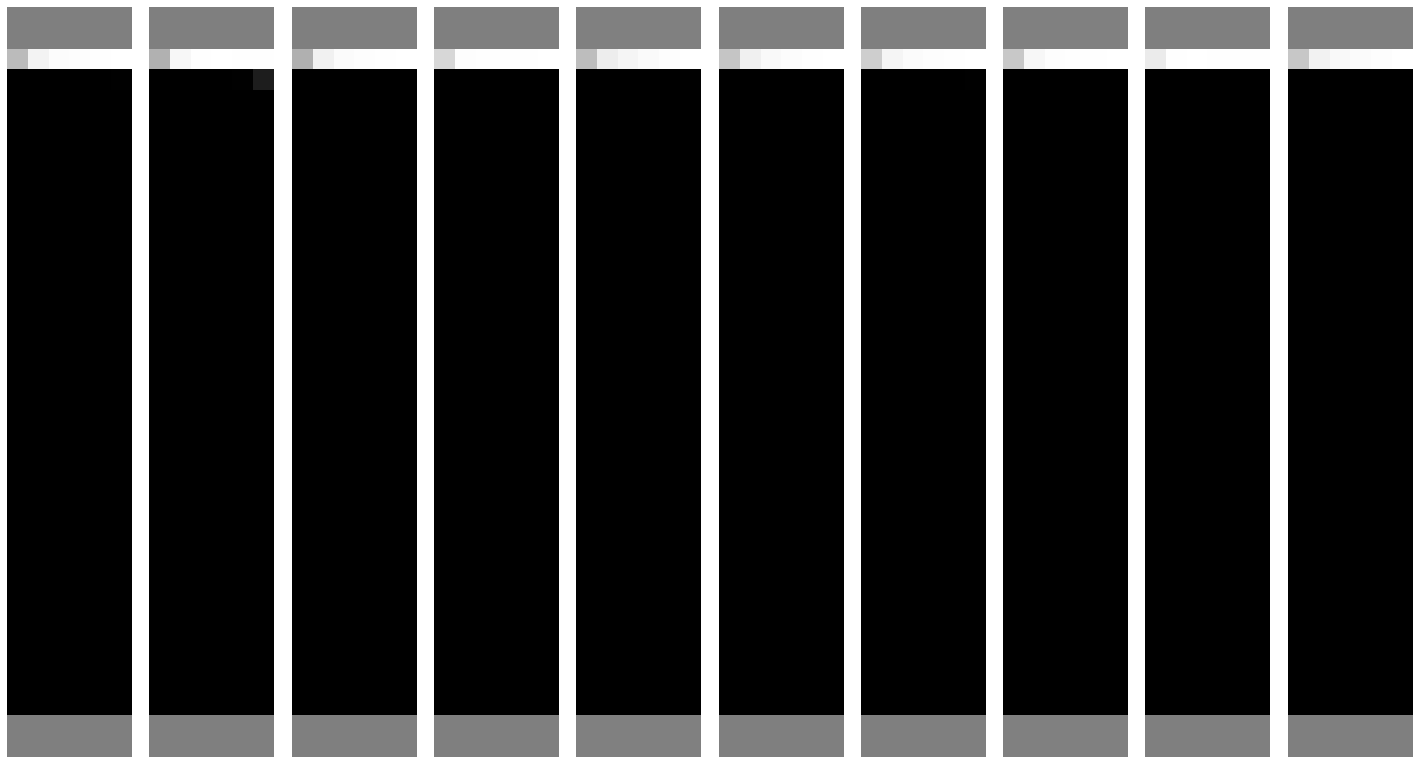

Epoch 52/200
8/8 - 1s - loss: 1.9664 - d_loss: 0.1219 - g_loss: 1.8444


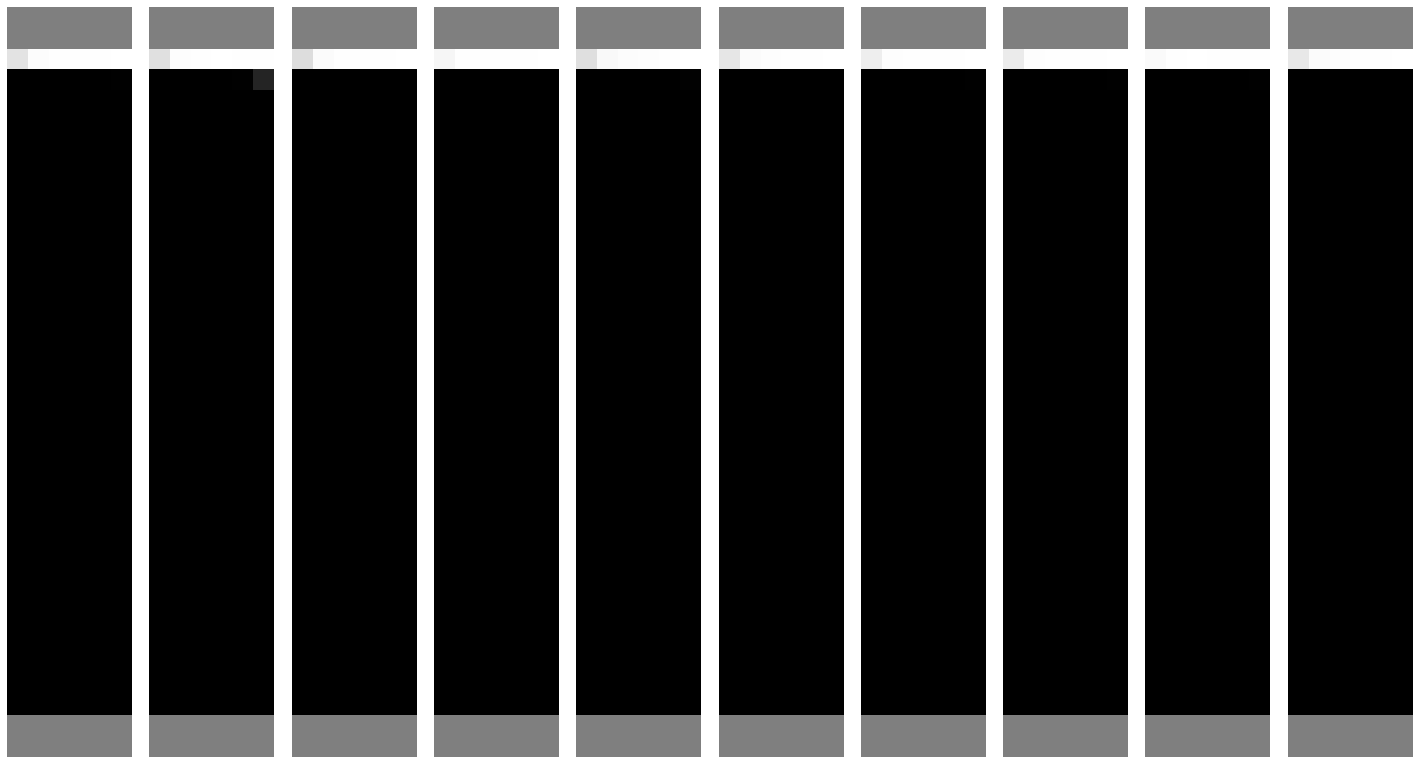

Epoch 53/200
8/8 - 1s - loss: 2.1126 - d_loss: 0.1059 - g_loss: 2.0067


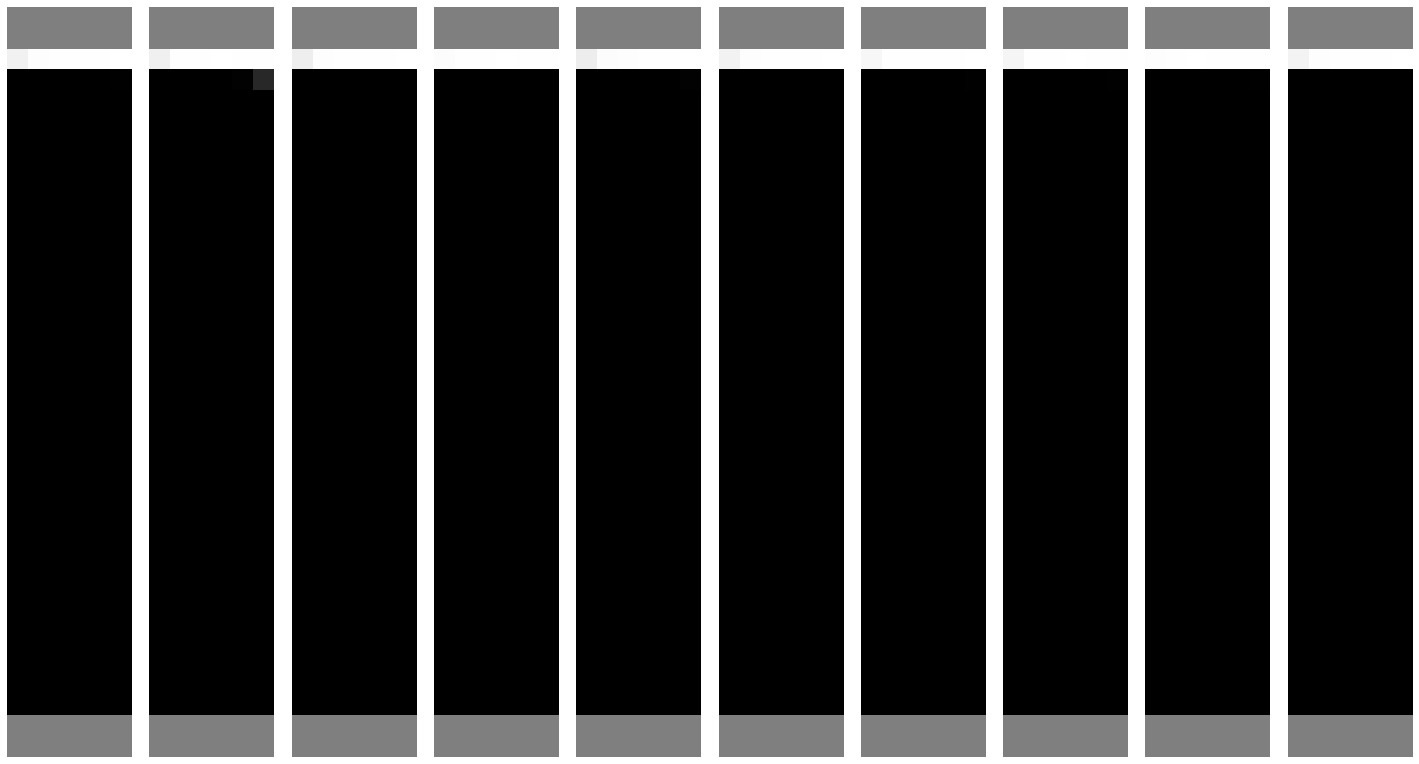

Epoch 54/200
8/8 - 1s - loss: 2.2597 - d_loss: 0.0932 - g_loss: 2.1665


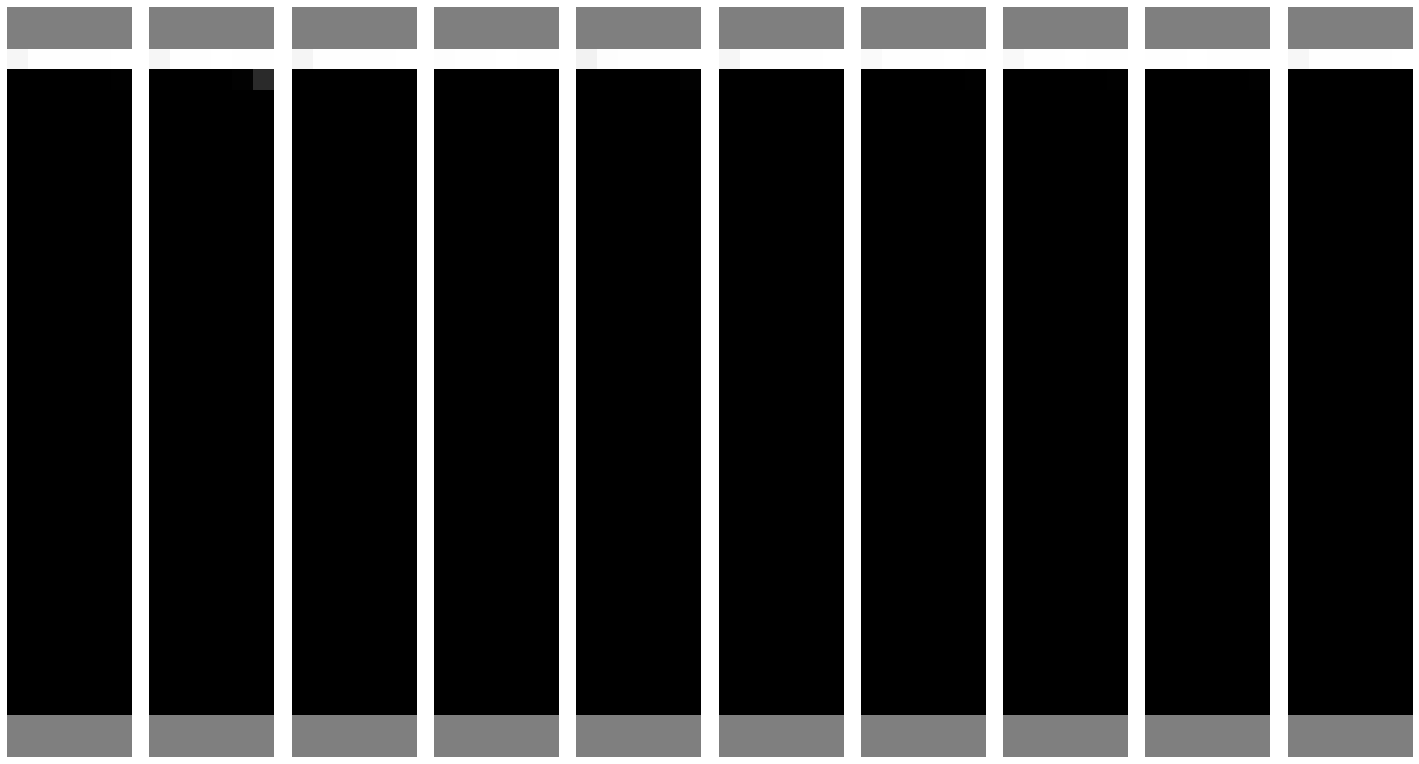

Epoch 55/200
8/8 - 1s - loss: 2.3987 - d_loss: 0.0822 - g_loss: 2.3165


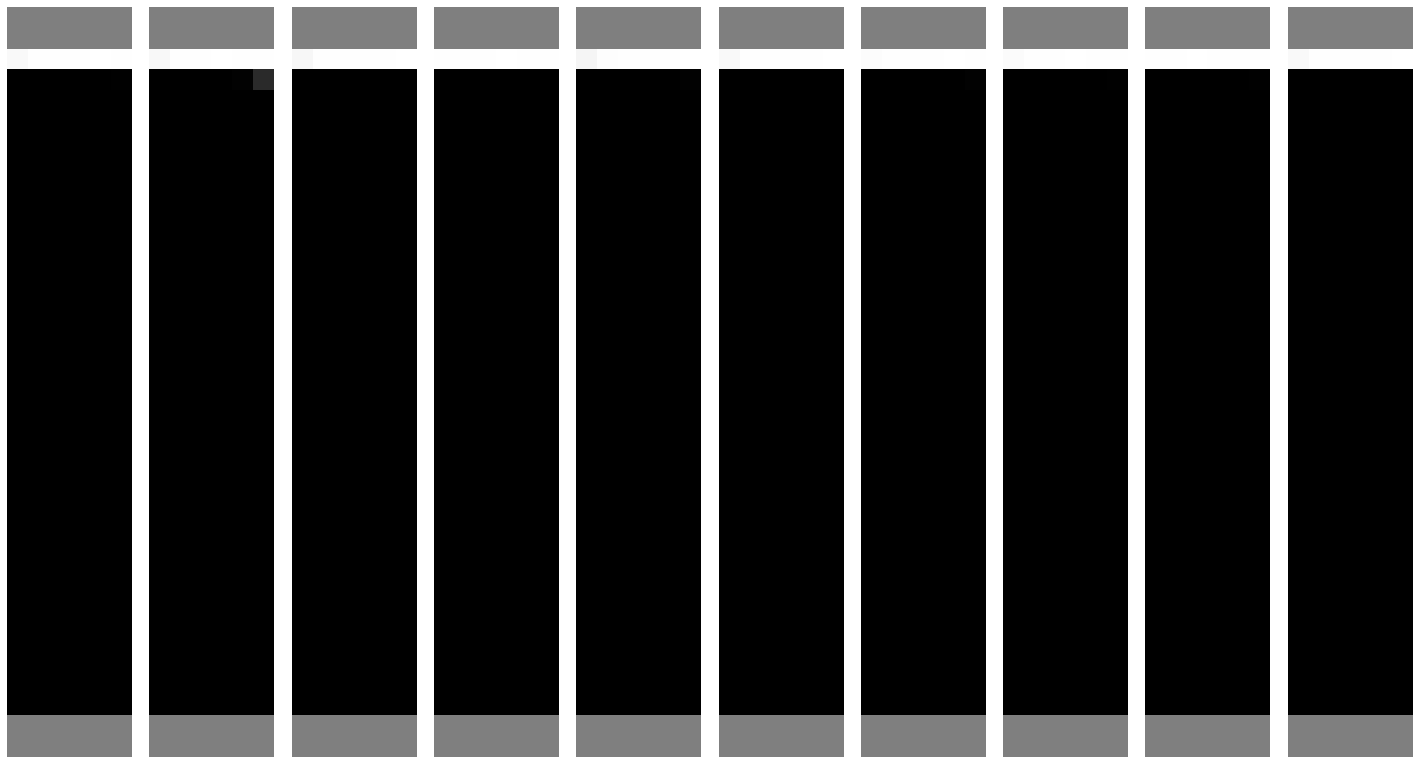

Epoch 56/200
8/8 - 1s - loss: 2.5295 - d_loss: 0.0734 - g_loss: 2.4561


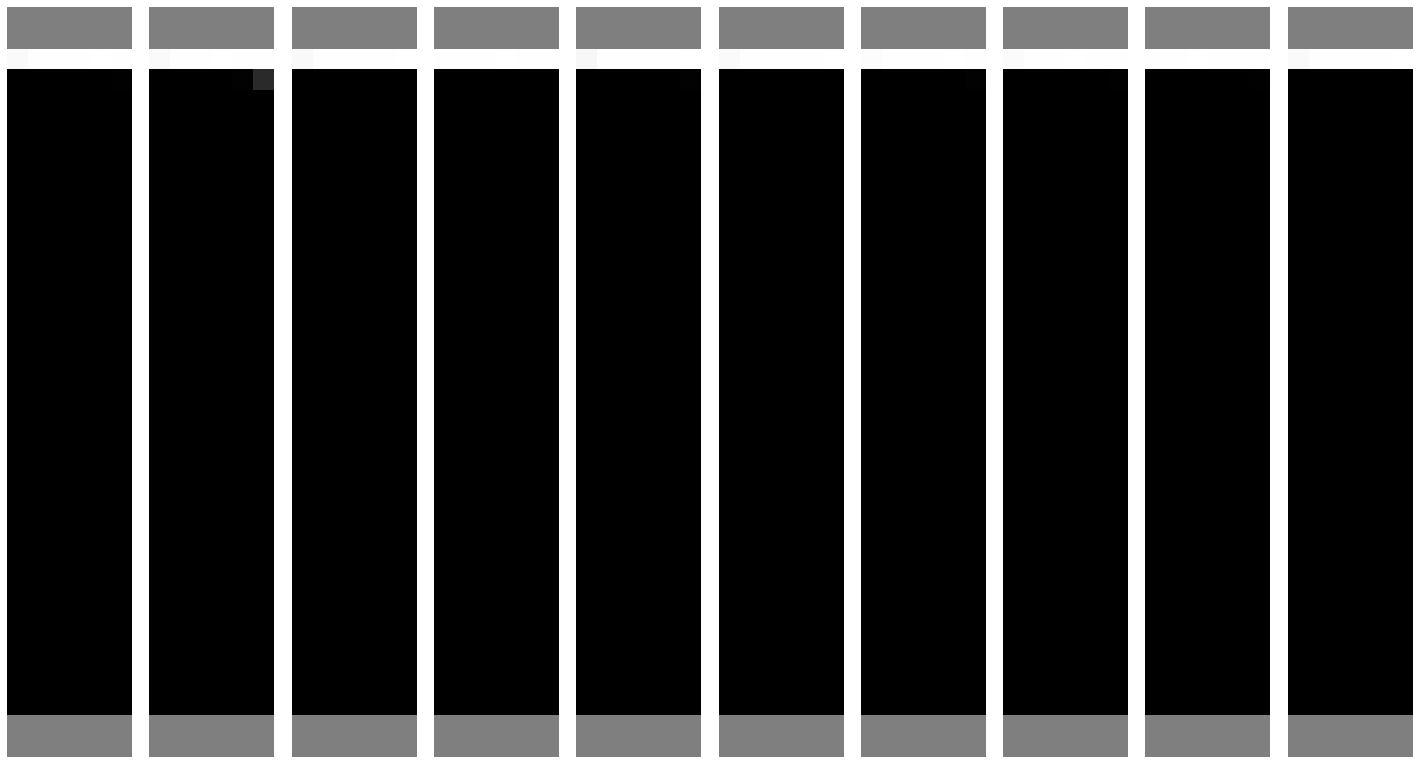

Epoch 57/200
8/8 - 1s - loss: 2.6551 - d_loss: 0.0658 - g_loss: 2.5893


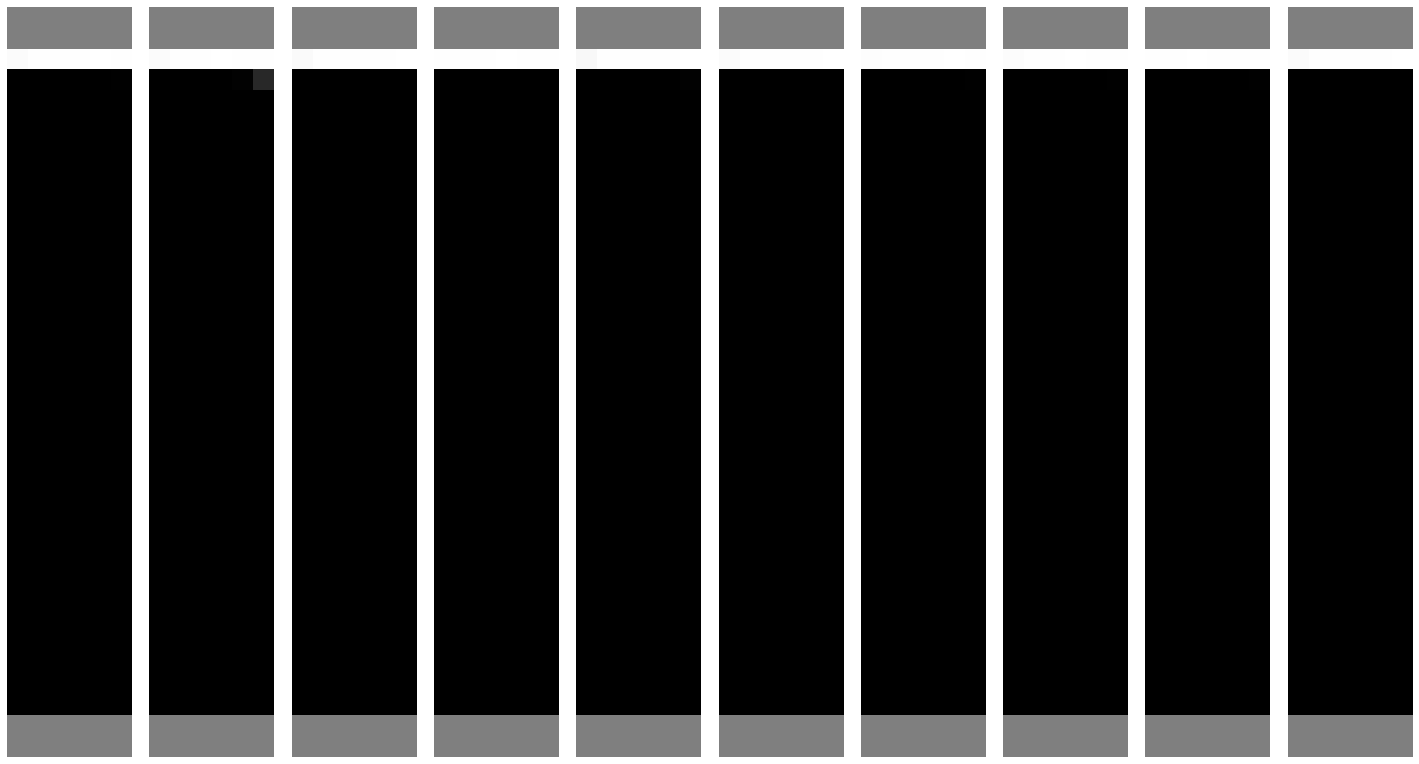

Epoch 58/200
8/8 - 1s - loss: 2.7713 - d_loss: 0.0592 - g_loss: 2.7121


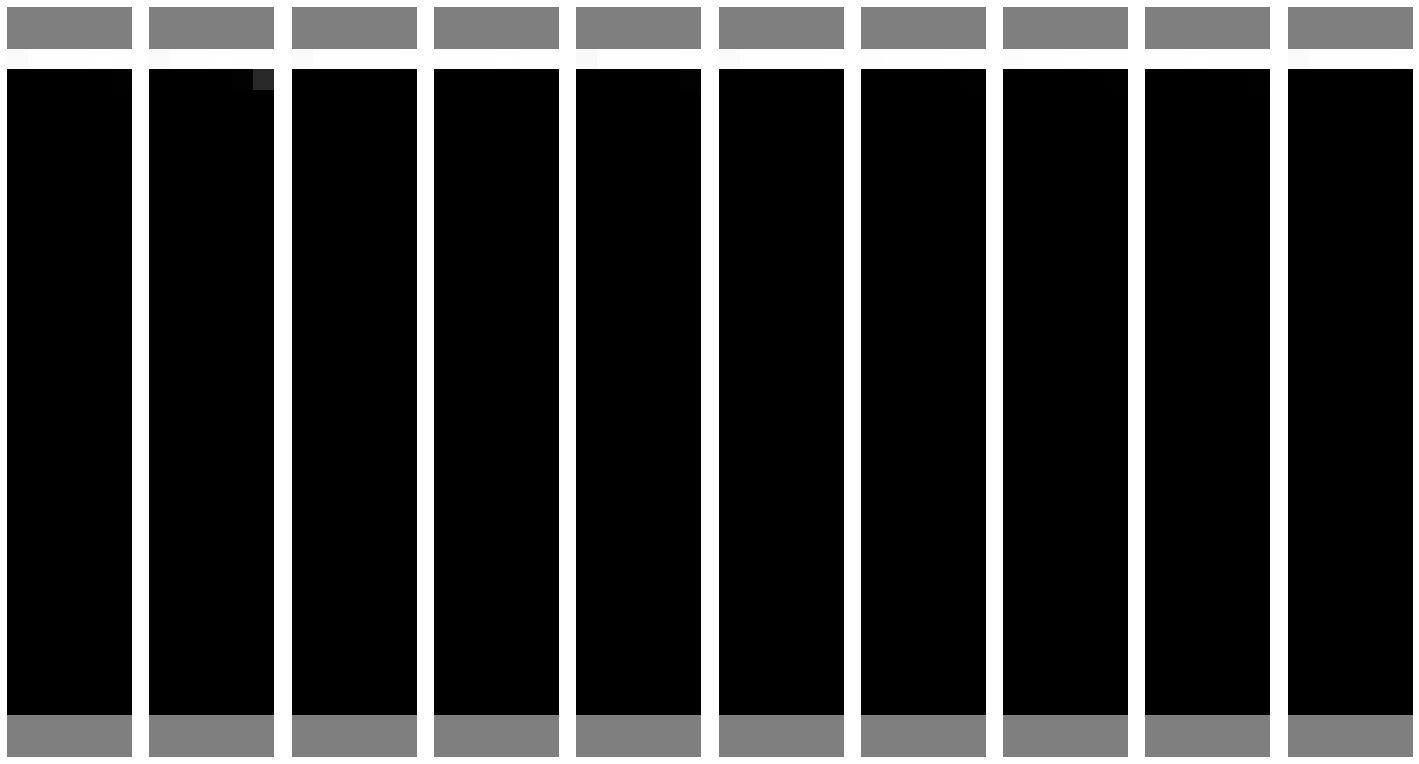

Epoch 59/200
8/8 - 1s - loss: 2.8775 - d_loss: 0.0533 - g_loss: 2.8242


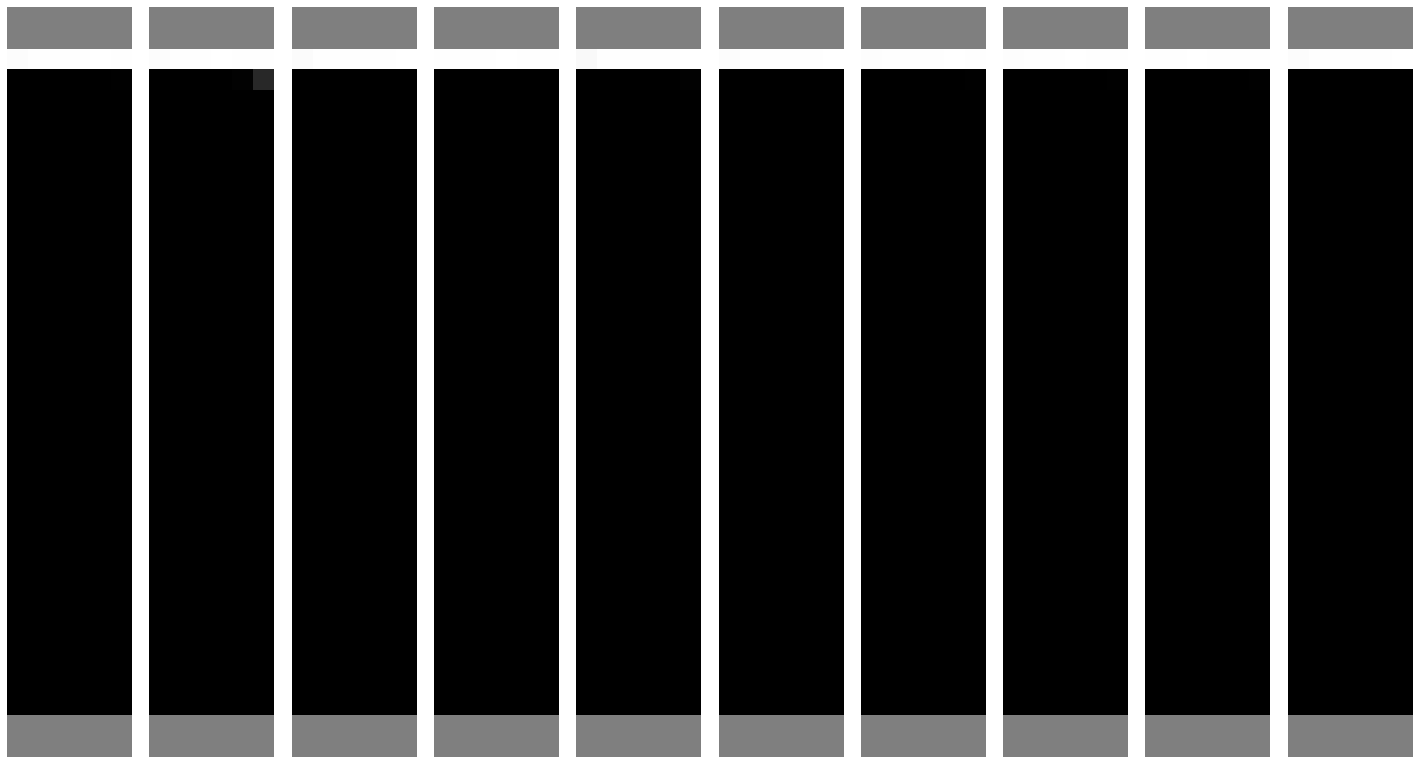

Epoch 60/200
8/8 - 1s - loss: 2.9773 - d_loss: 0.0488 - g_loss: 2.9285


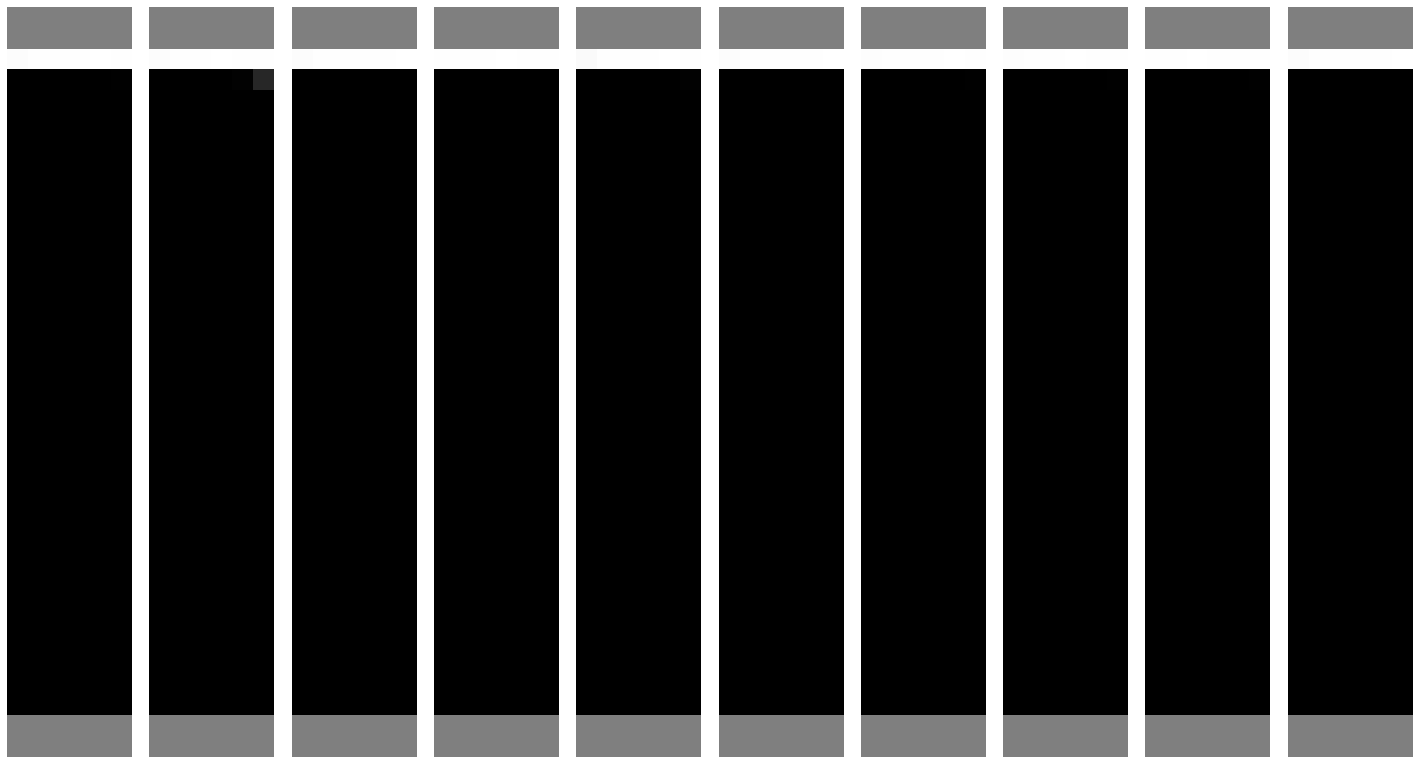

Epoch 61/200
8/8 - 1s - loss: 3.0699 - d_loss: 0.0445 - g_loss: 3.0254


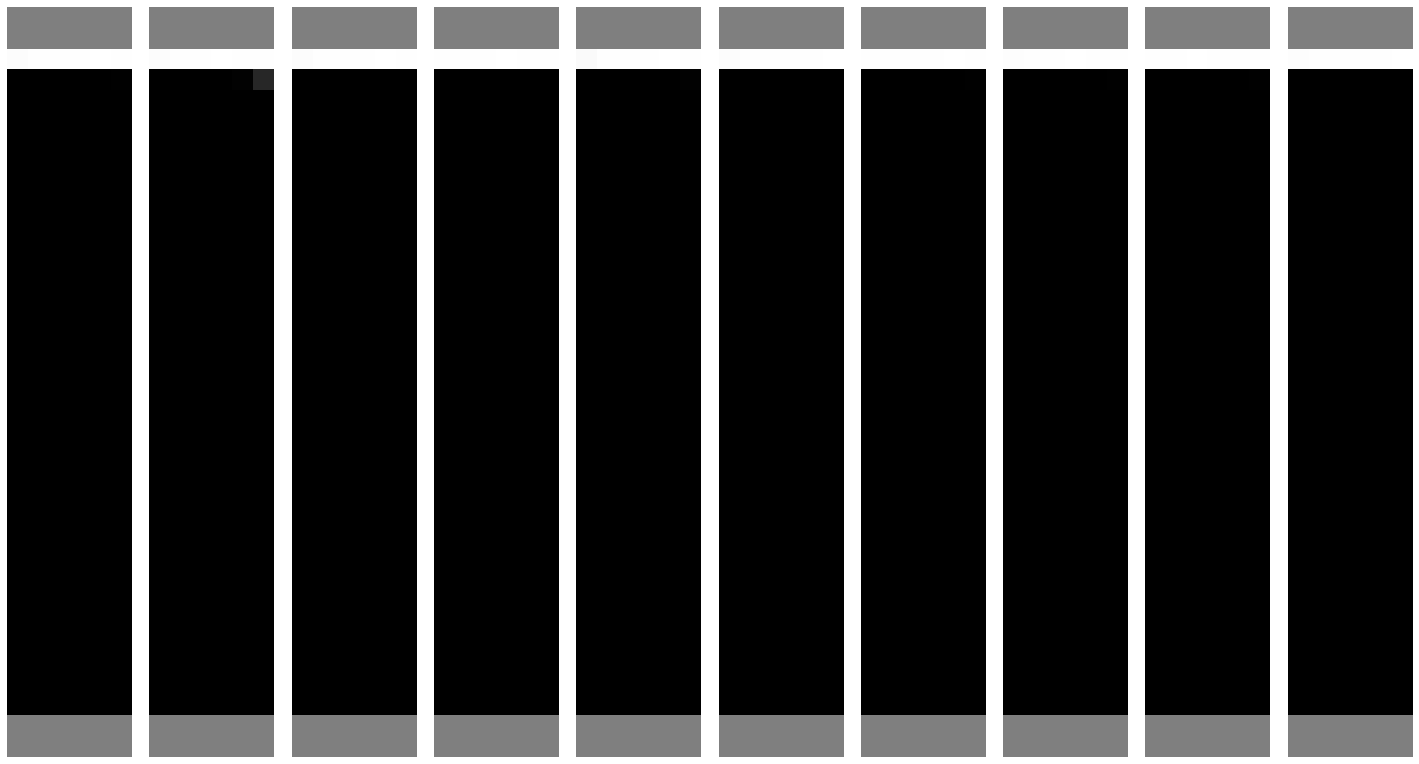

Epoch 62/200
8/8 - 1s - loss: 3.1545 - d_loss: 0.0411 - g_loss: 3.1134


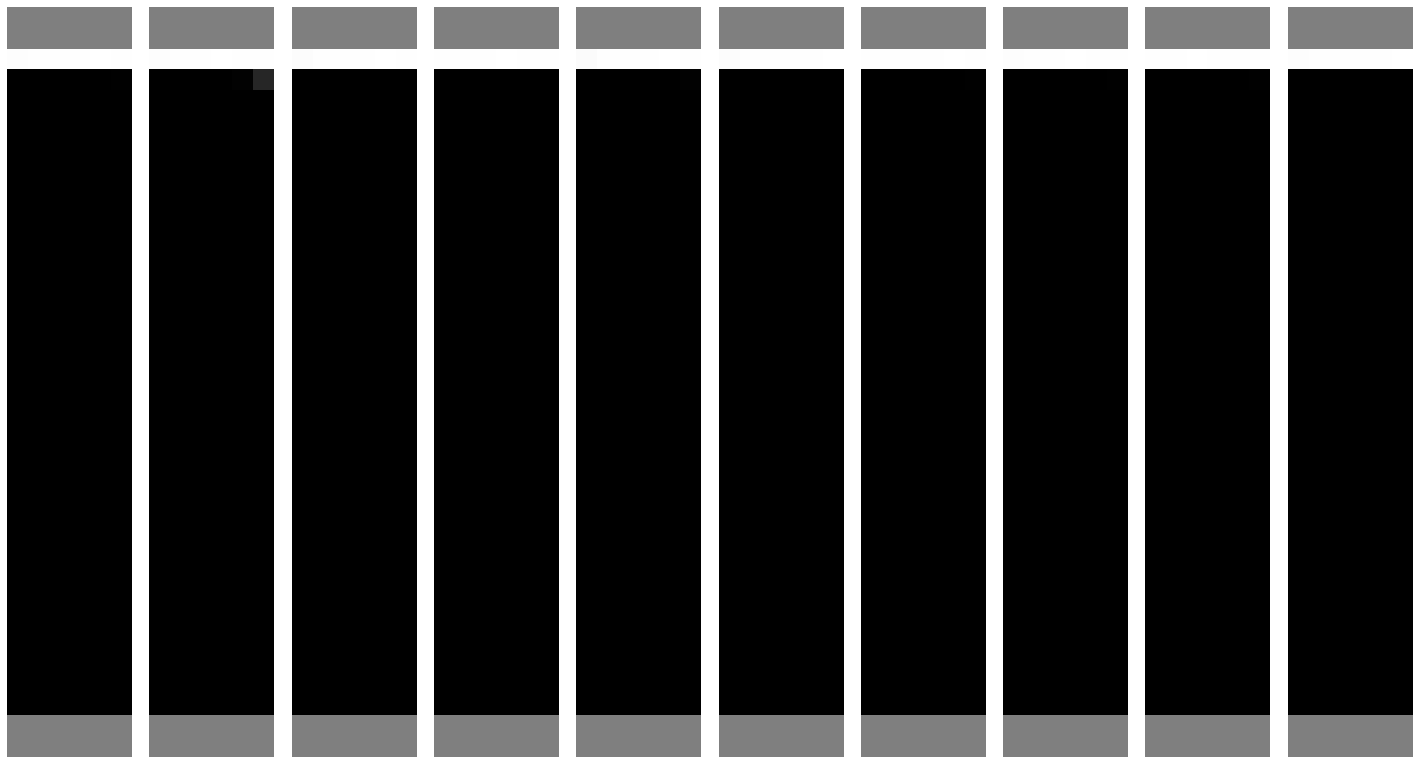

Epoch 63/200
8/8 - 1s - loss: 3.2342 - d_loss: 0.0379 - g_loss: 3.1963


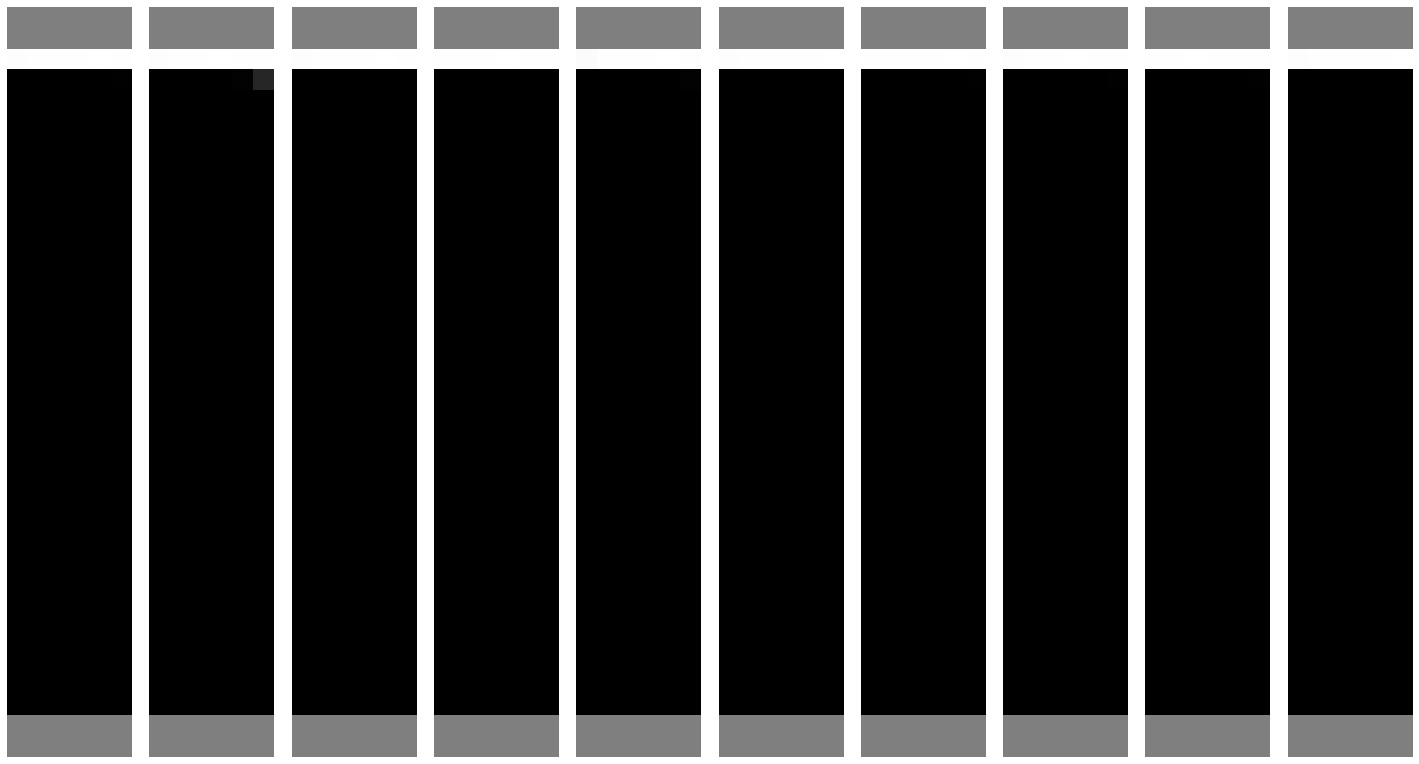

Epoch 64/200
8/8 - 1s - loss: 3.3083 - d_loss: 0.0351 - g_loss: 3.2732


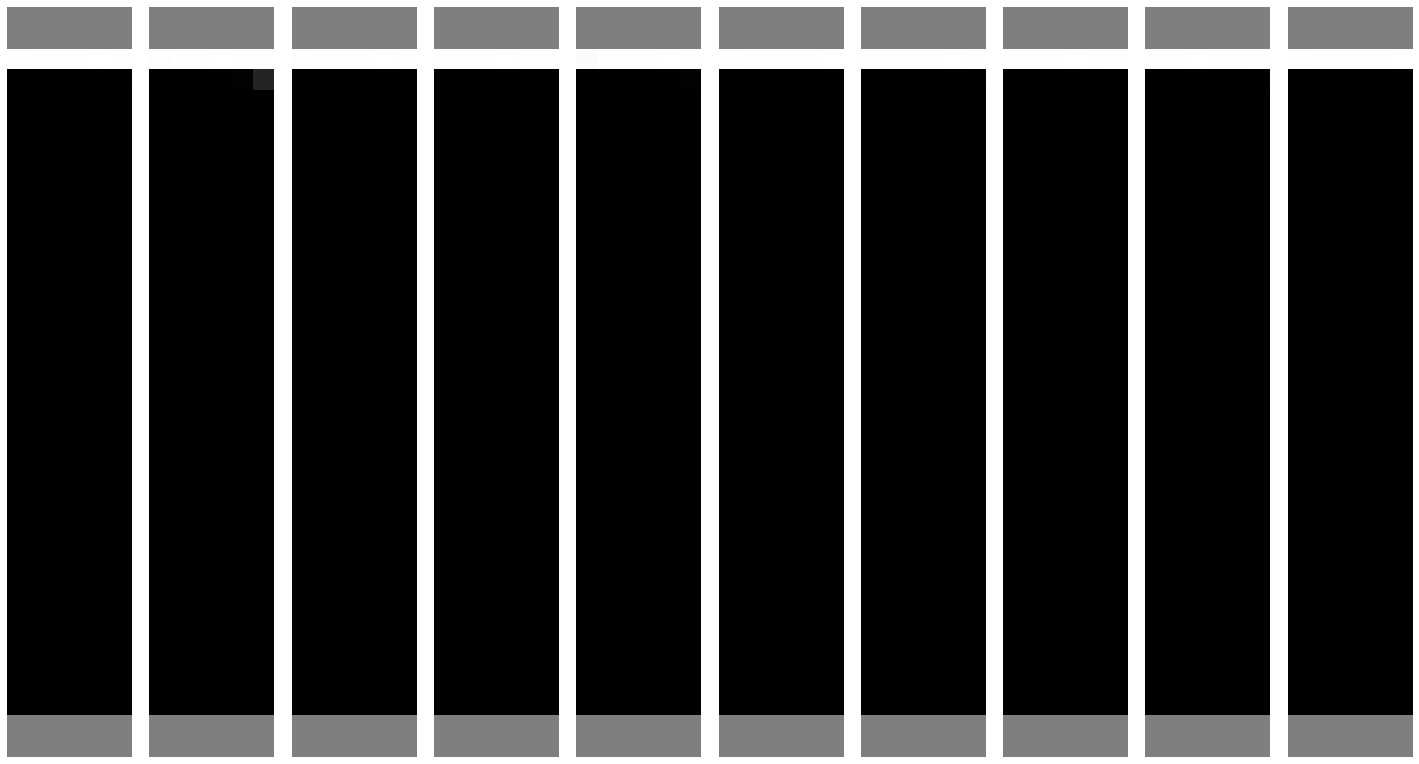

Epoch 65/200
8/8 - 1s - loss: 3.3747 - d_loss: 0.0331 - g_loss: 3.3416


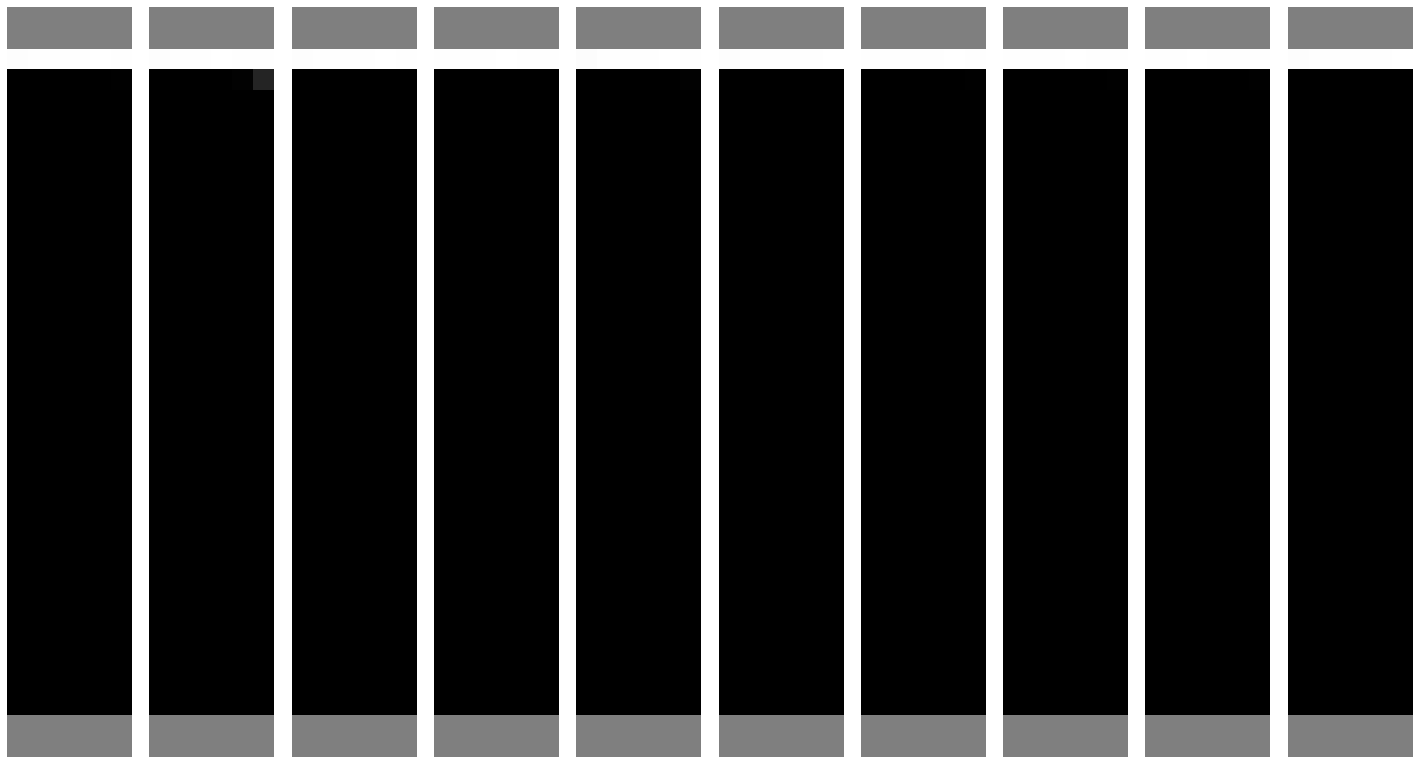

Epoch 66/200
8/8 - 1s - loss: 3.4335 - d_loss: 0.0309 - g_loss: 3.4026


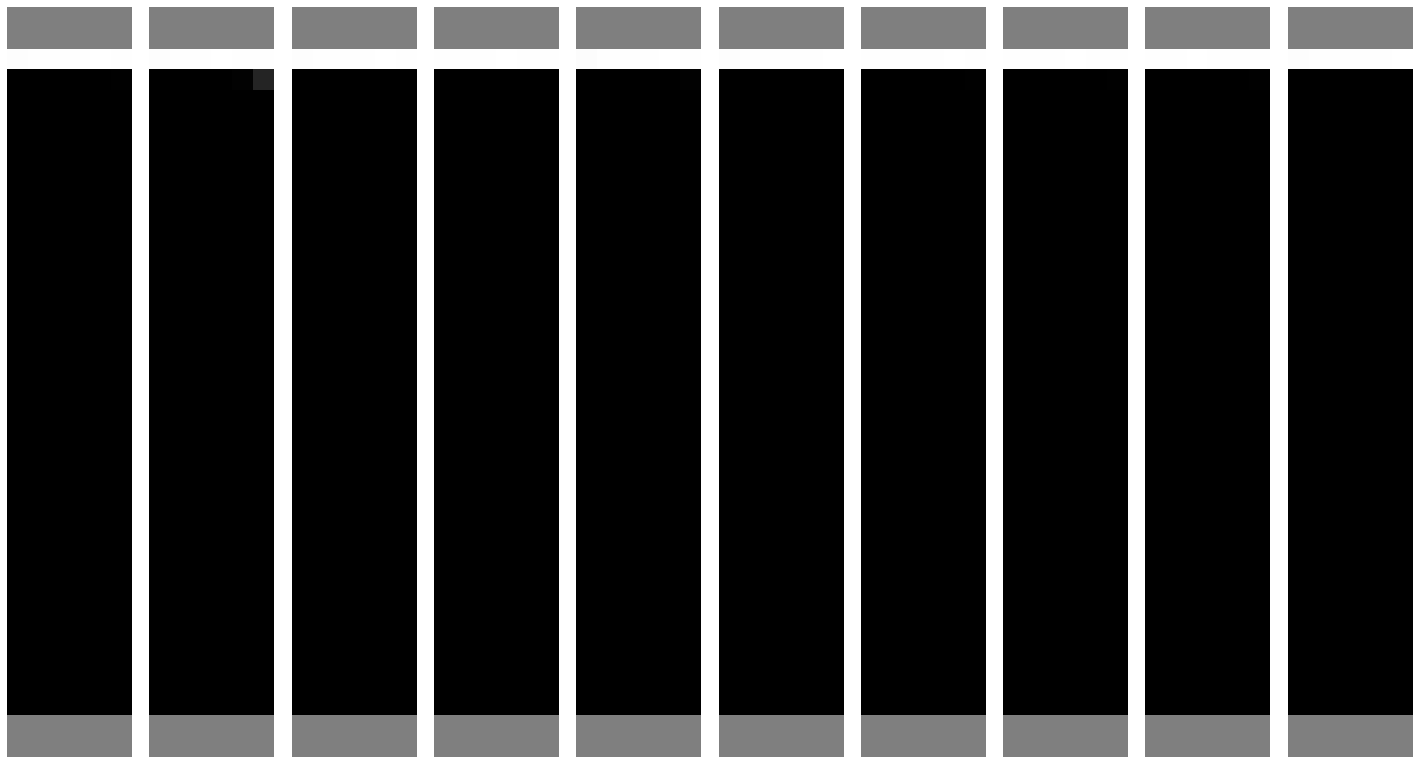

Epoch 67/200
8/8 - 1s - loss: 3.4908 - d_loss: 0.0288 - g_loss: 3.4620


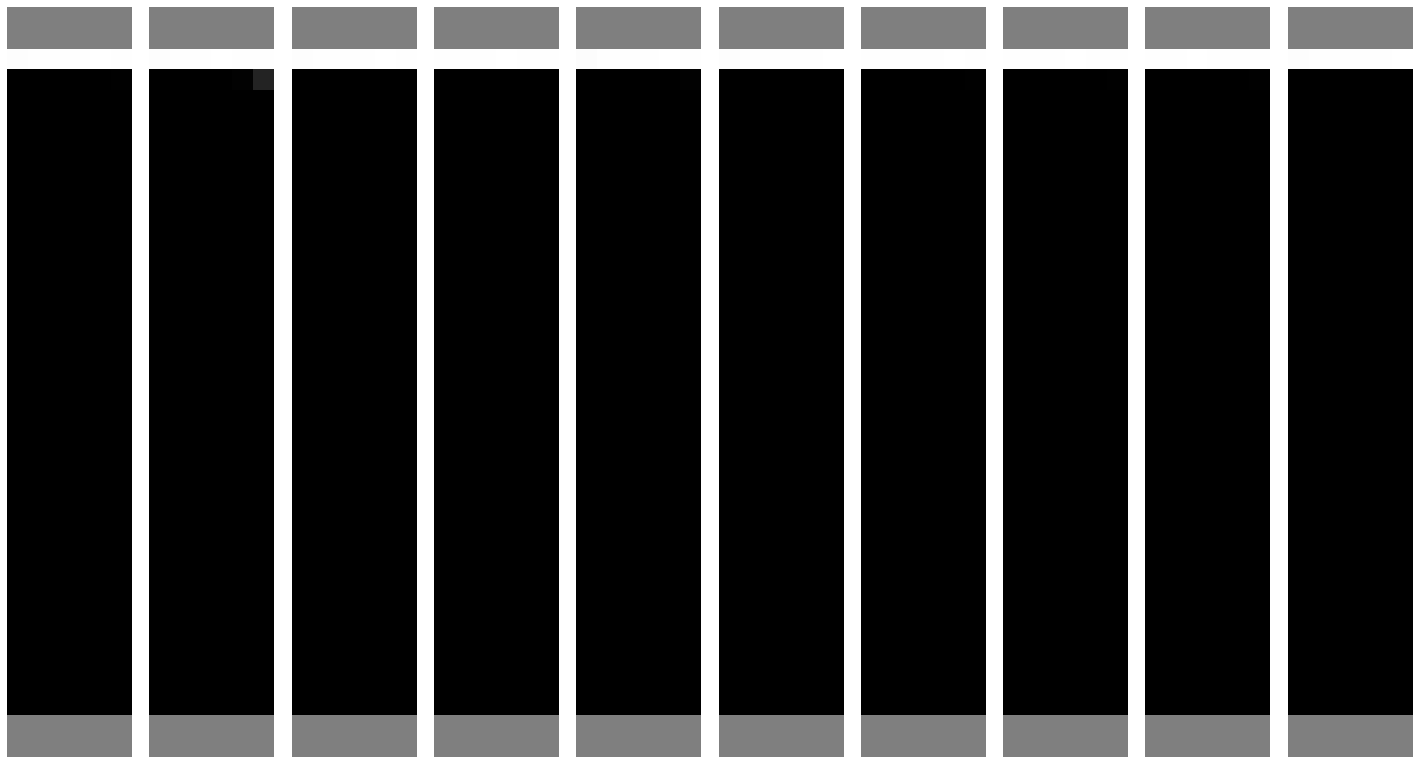

Epoch 68/200
8/8 - 1s - loss: 3.5504 - d_loss: 0.0272 - g_loss: 3.5232


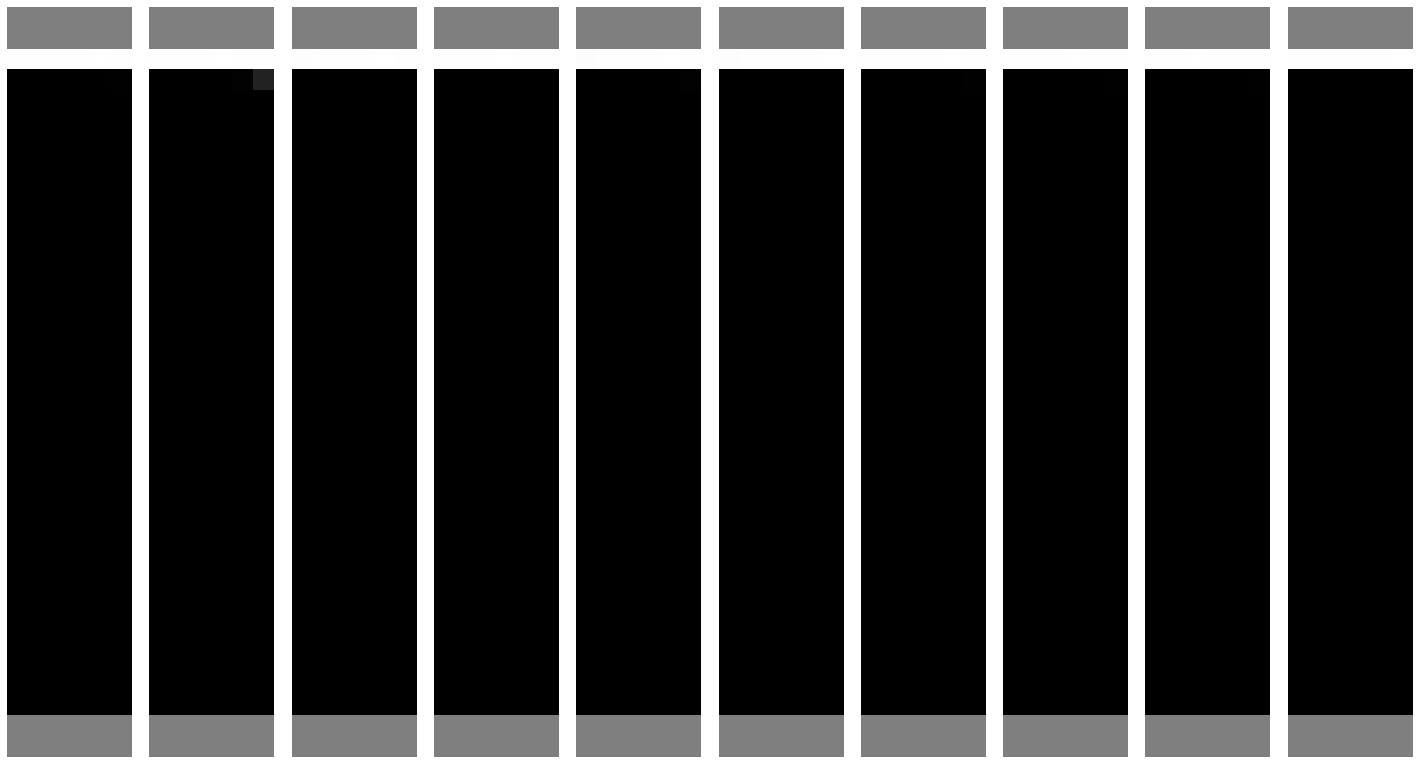

Epoch 69/200
8/8 - 1s - loss: 3.6044 - d_loss: 0.0254 - g_loss: 3.5790


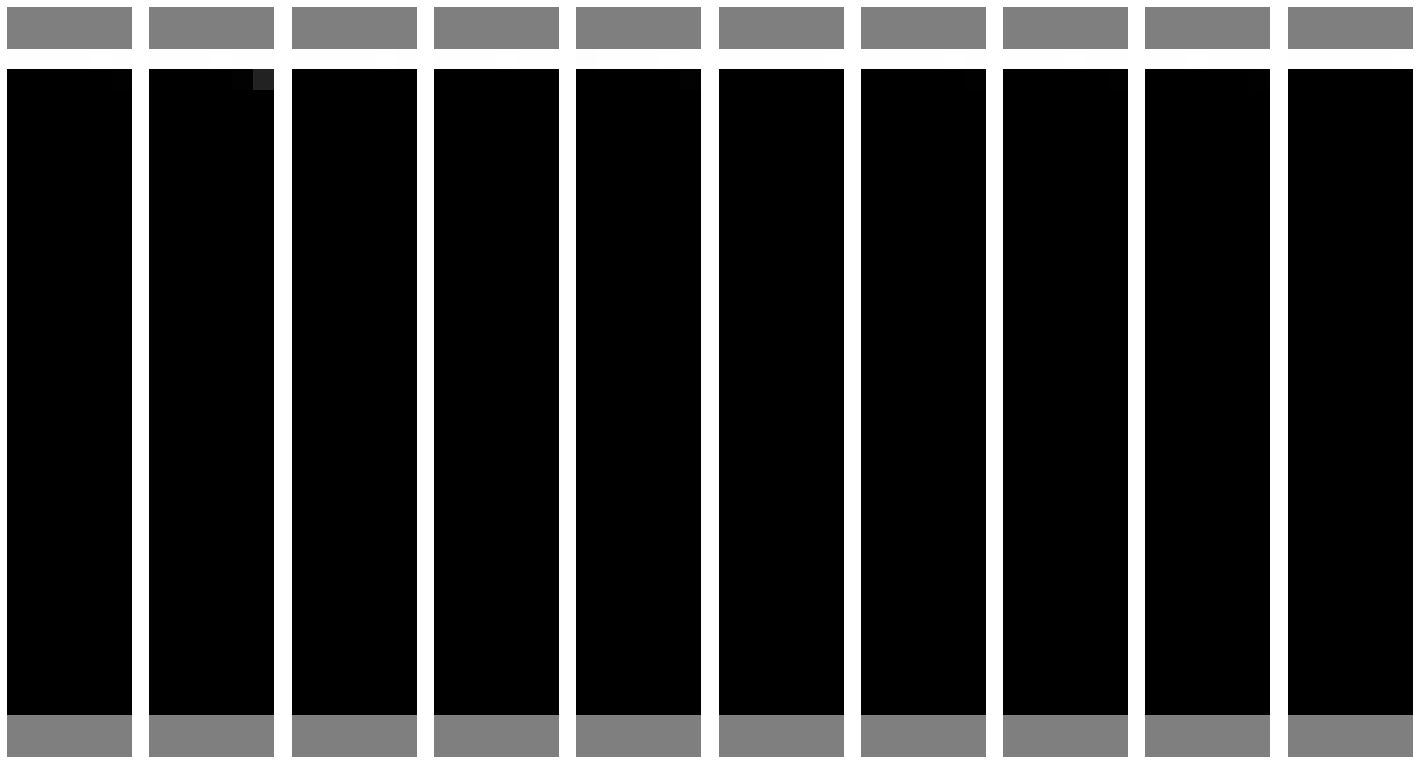

Epoch 70/200
8/8 - 1s - loss: 3.6597 - d_loss: 0.0238 - g_loss: 3.6358


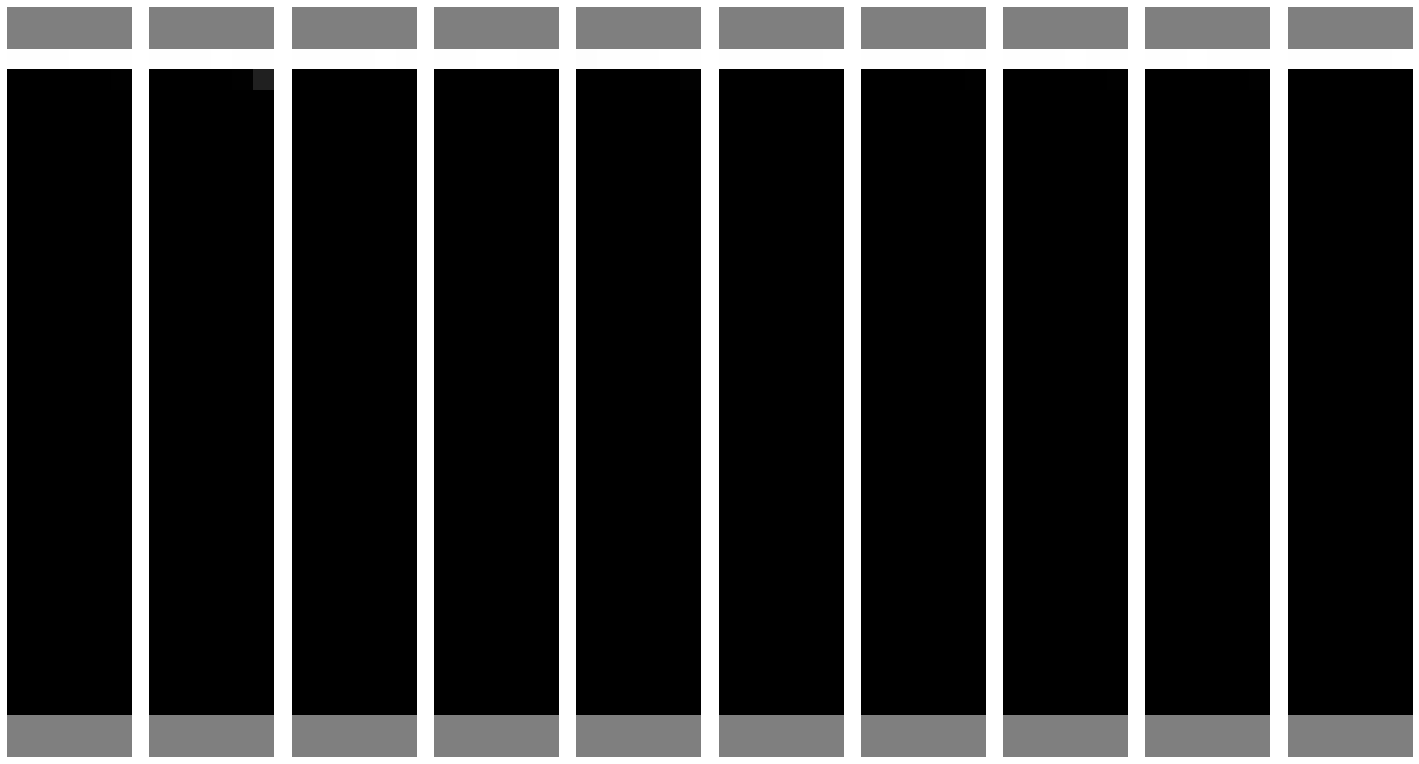

Epoch 71/200
8/8 - 1s - loss: 3.7188 - d_loss: 0.0228 - g_loss: 3.6960


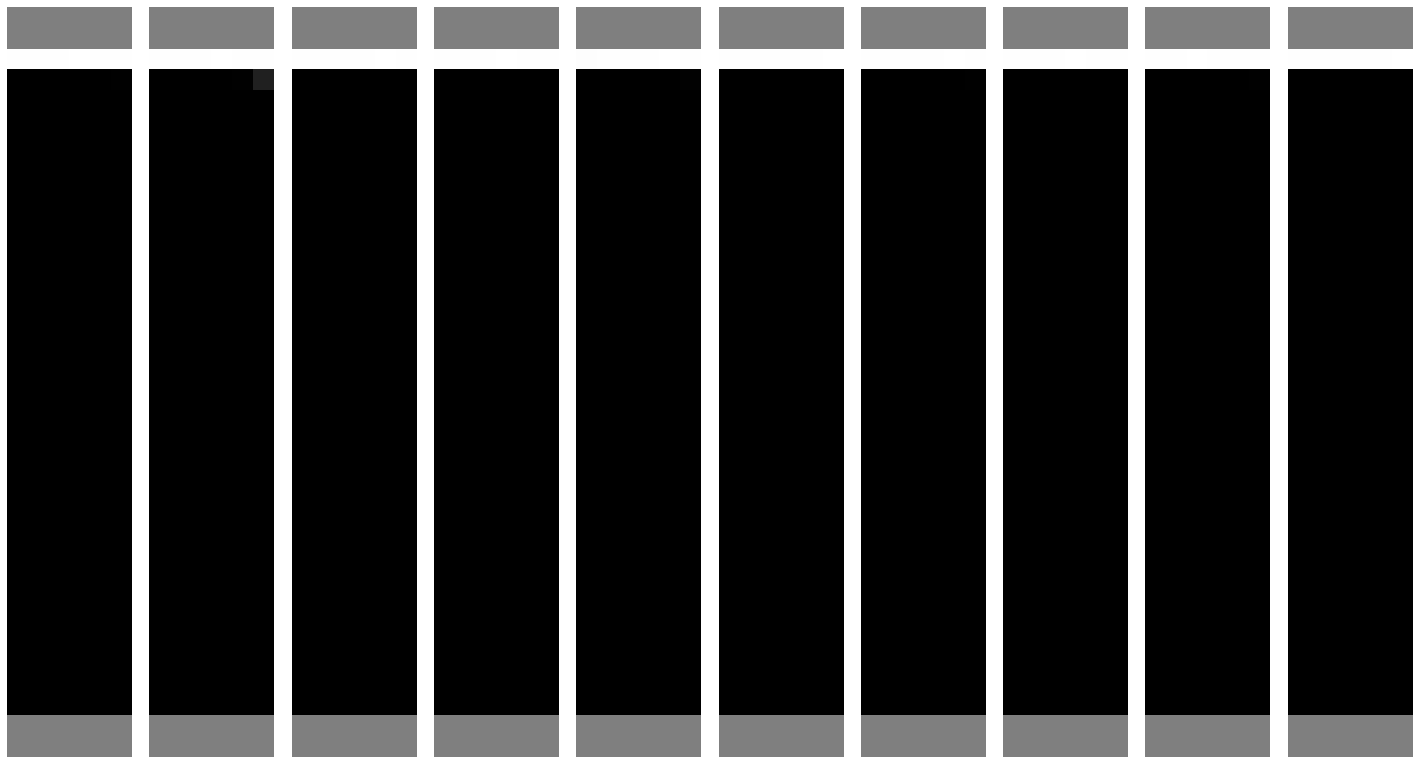

Epoch 72/200
8/8 - 1s - loss: 3.7760 - d_loss: 0.0212 - g_loss: 3.7548


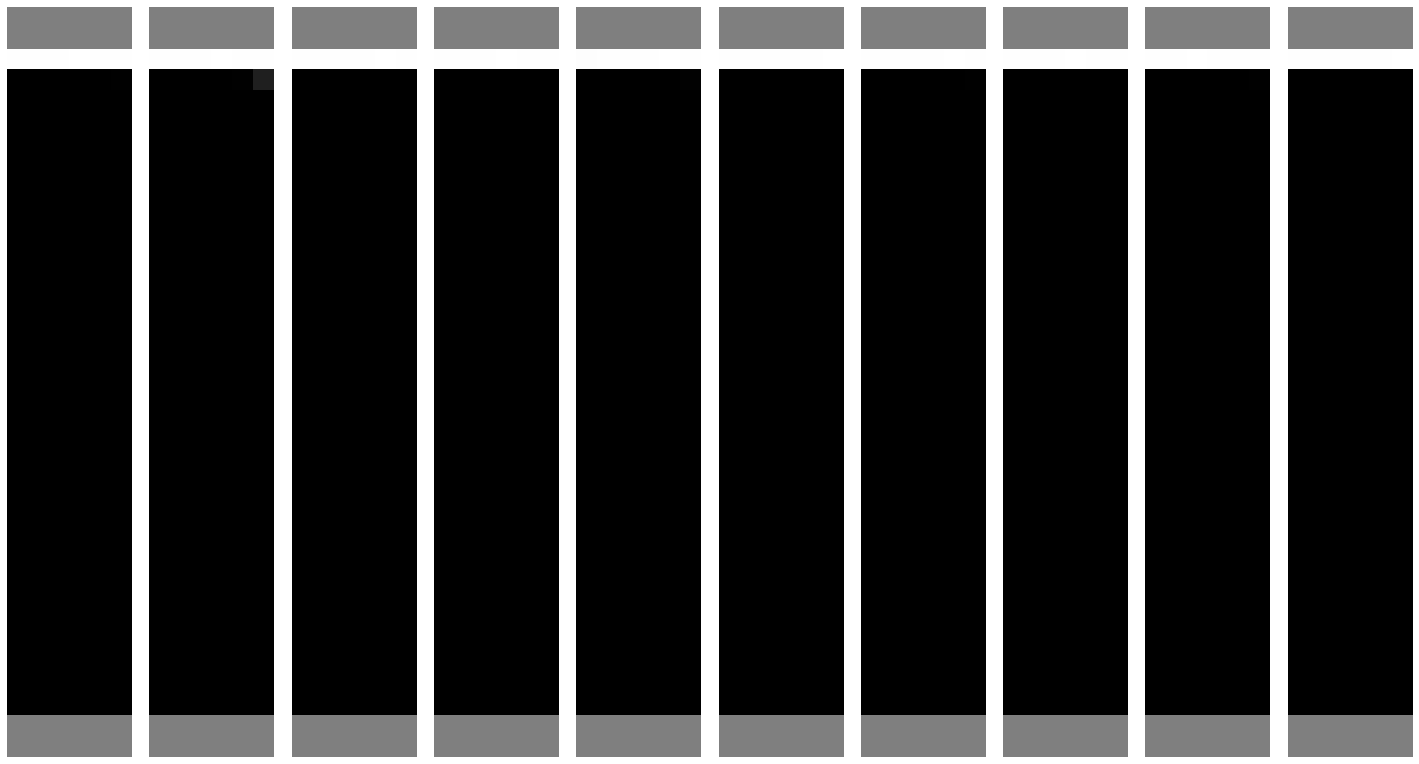

Epoch 73/200
8/8 - 1s - loss: 3.8328 - d_loss: 0.0204 - g_loss: 3.8124


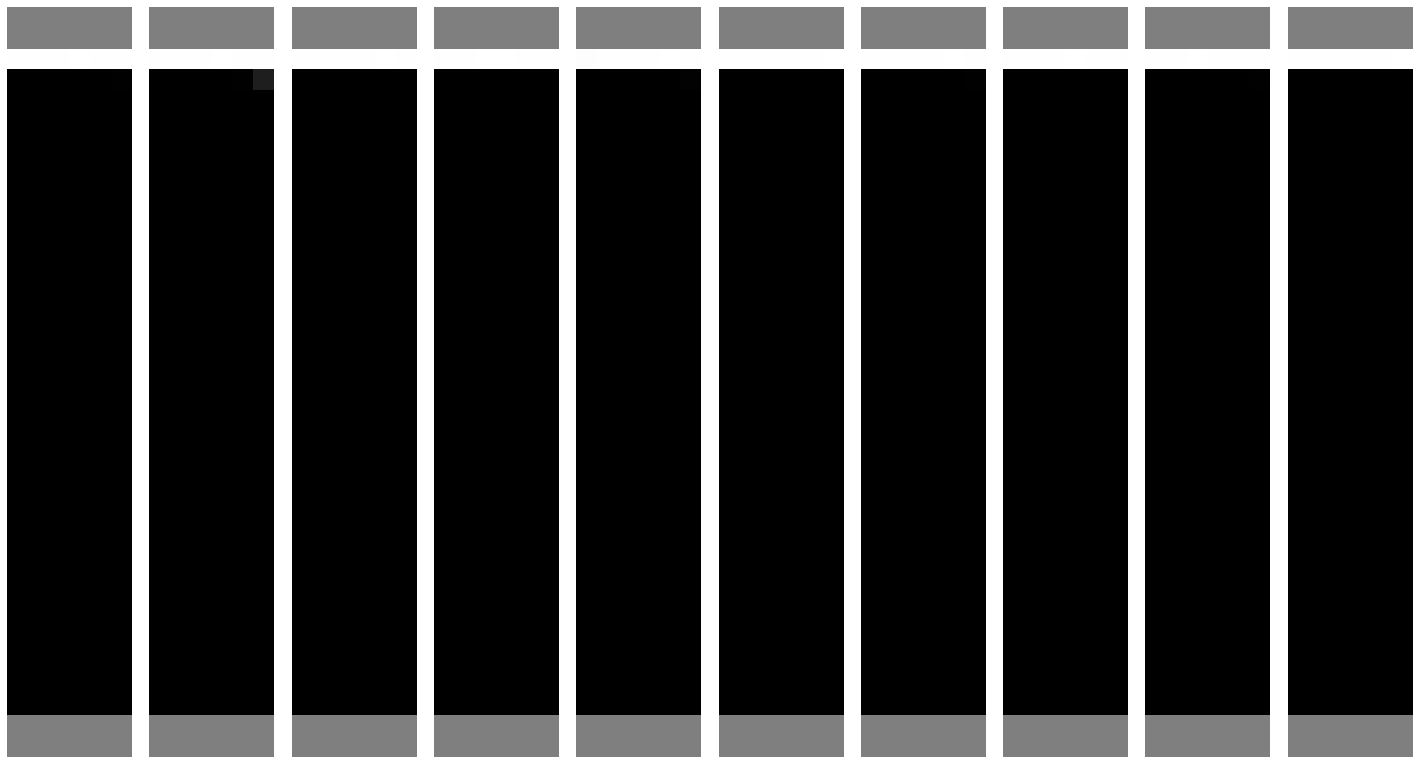

Epoch 74/200
8/8 - 1s - loss: 3.8936 - d_loss: 0.0193 - g_loss: 3.8743


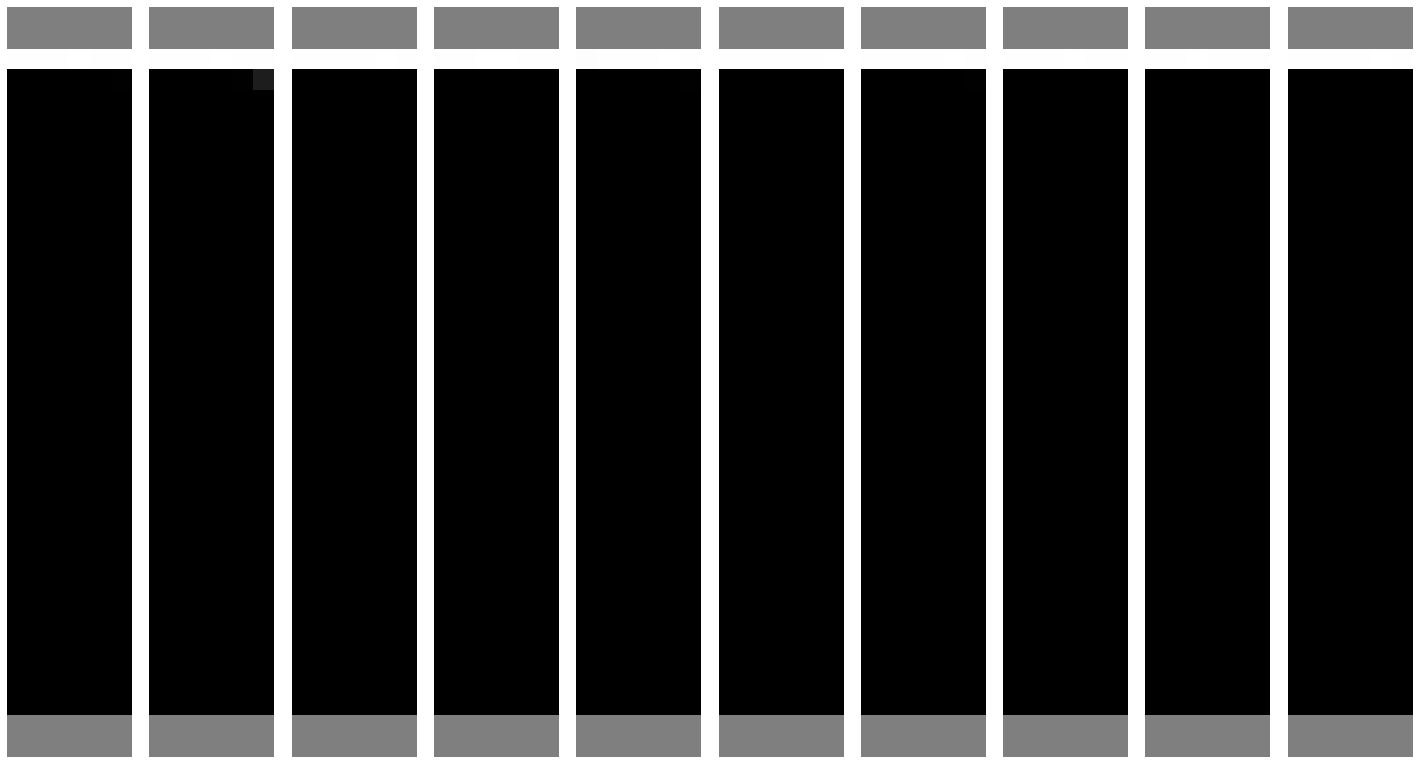

Epoch 75/200
8/8 - 1s - loss: 3.9424 - d_loss: 0.0178 - g_loss: 3.9245


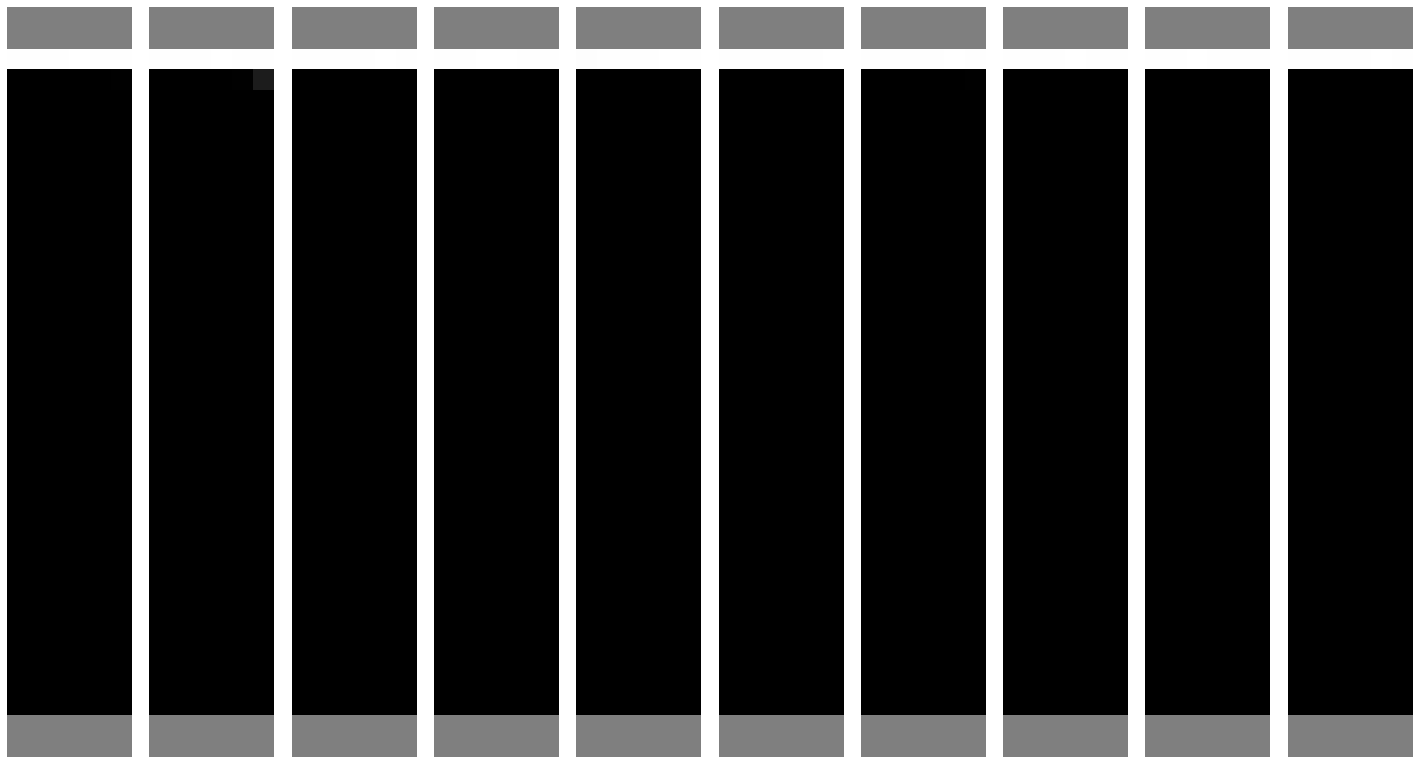

Epoch 76/200
8/8 - 1s - loss: 3.9848 - d_loss: 0.0172 - g_loss: 3.9676


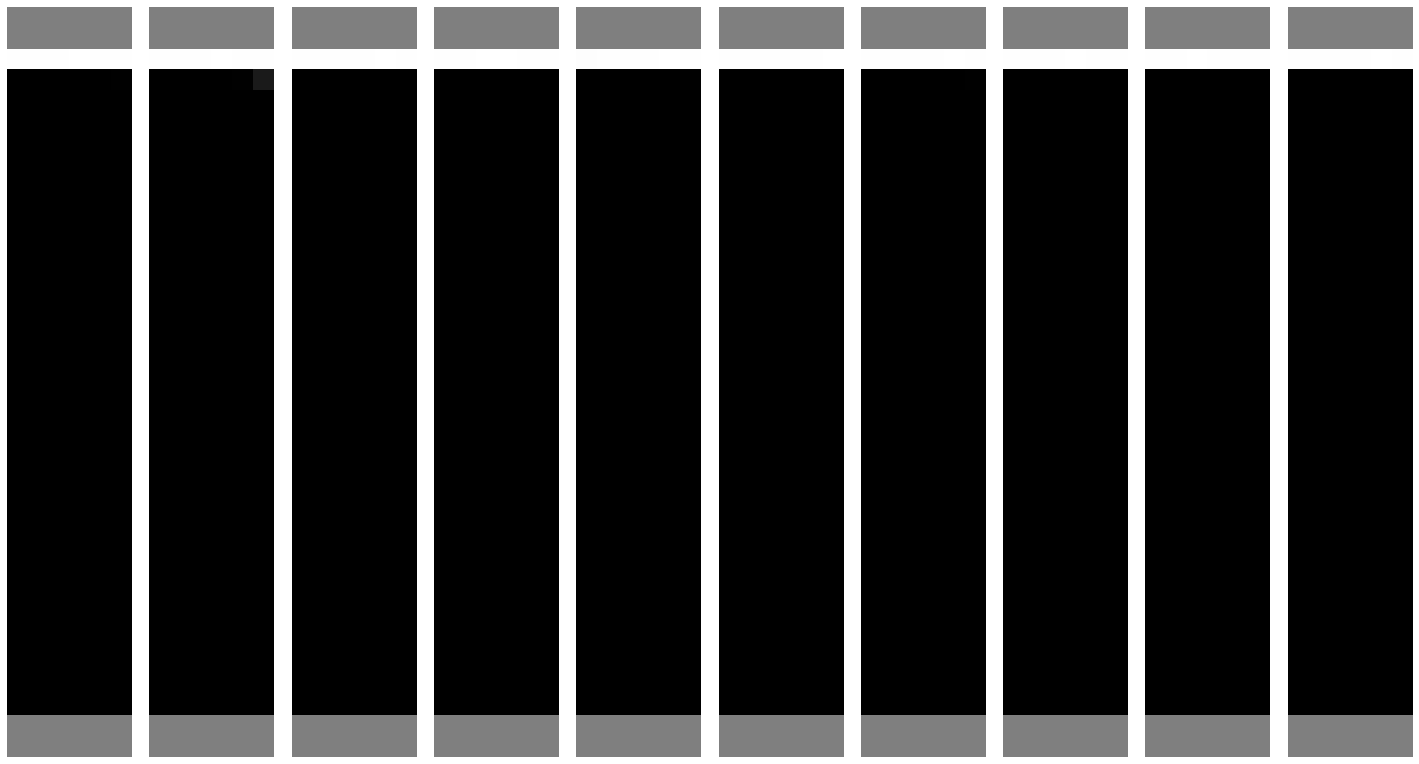

Epoch 77/200
8/8 - 1s - loss: 4.0302 - d_loss: 0.0162 - g_loss: 4.0140


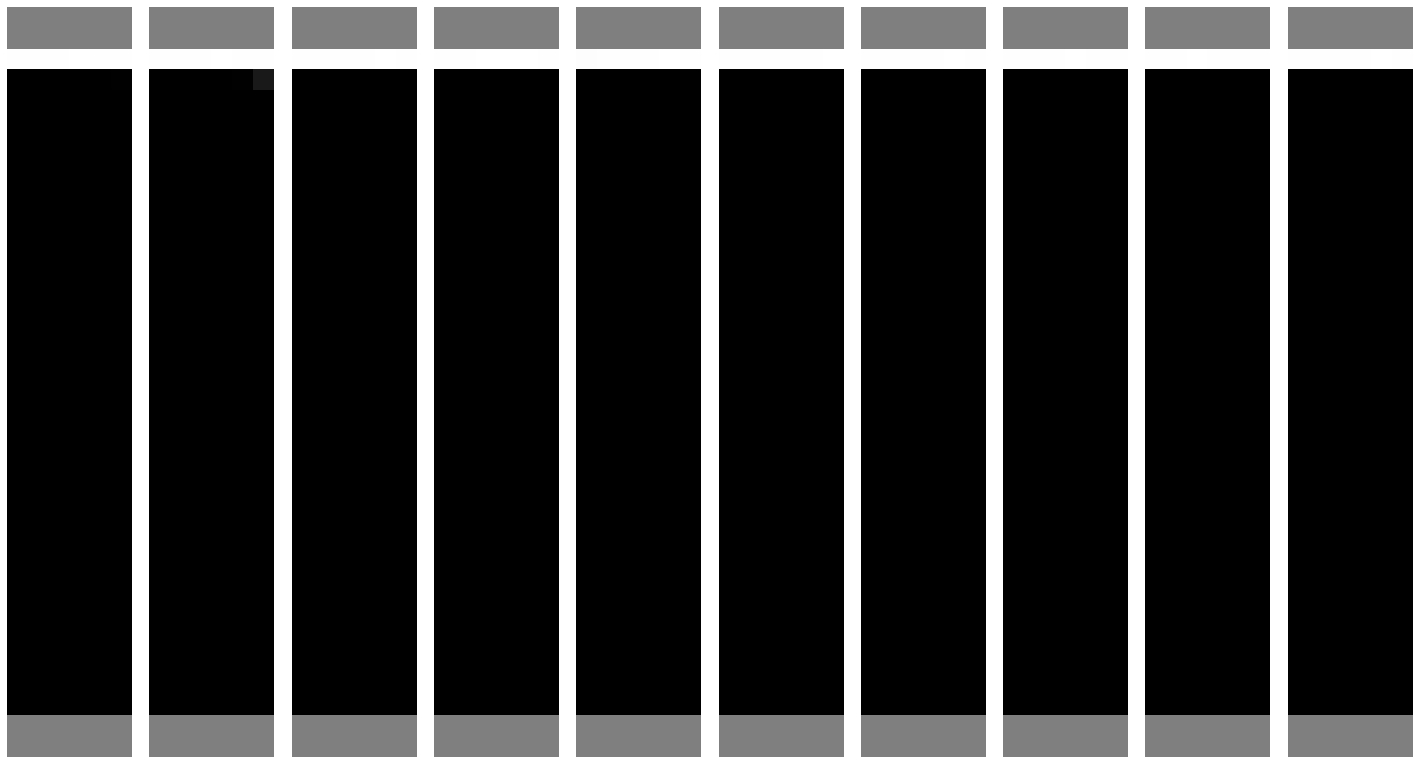

Epoch 78/200
8/8 - 1s - loss: 4.0833 - d_loss: 0.0153 - g_loss: 4.0680


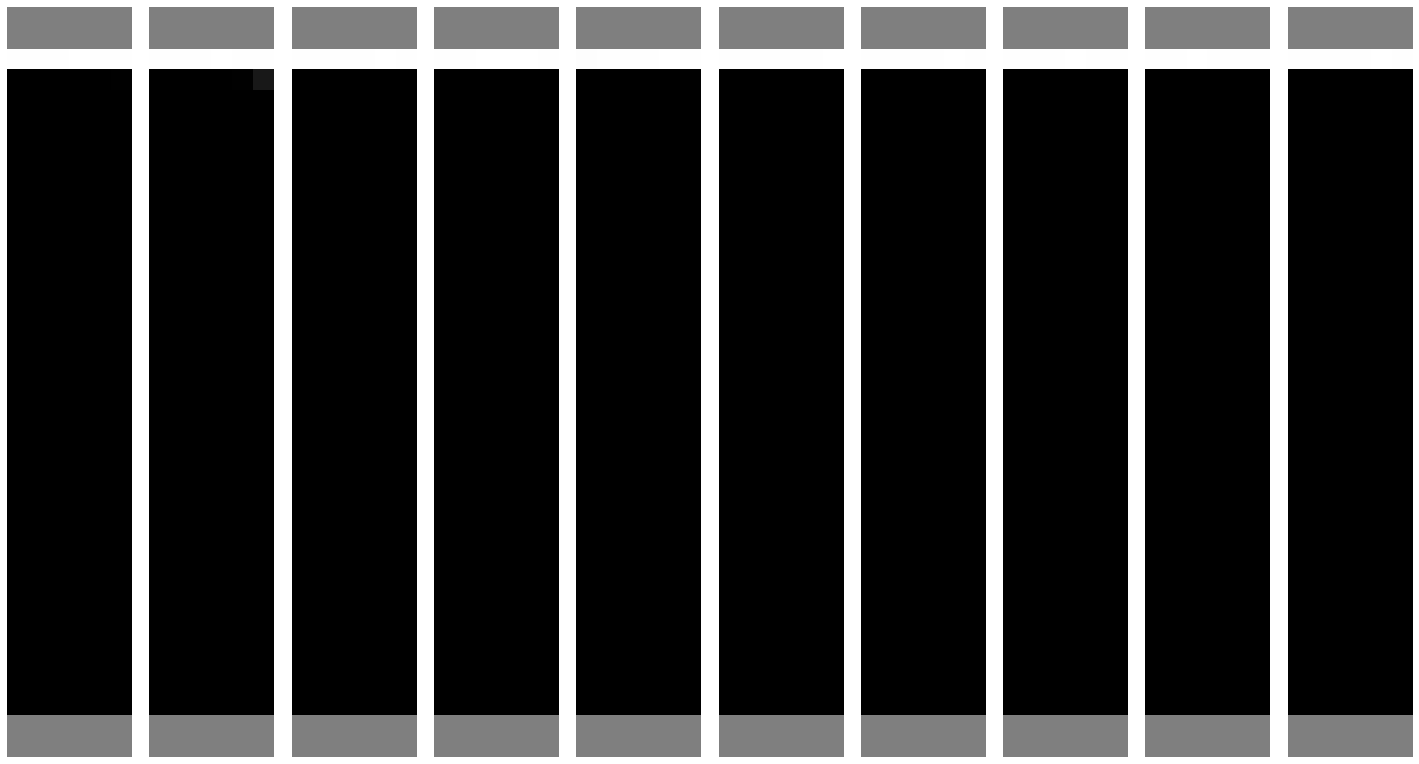

Epoch 79/200
8/8 - 1s - loss: 4.1465 - d_loss: 0.0149 - g_loss: 4.1316


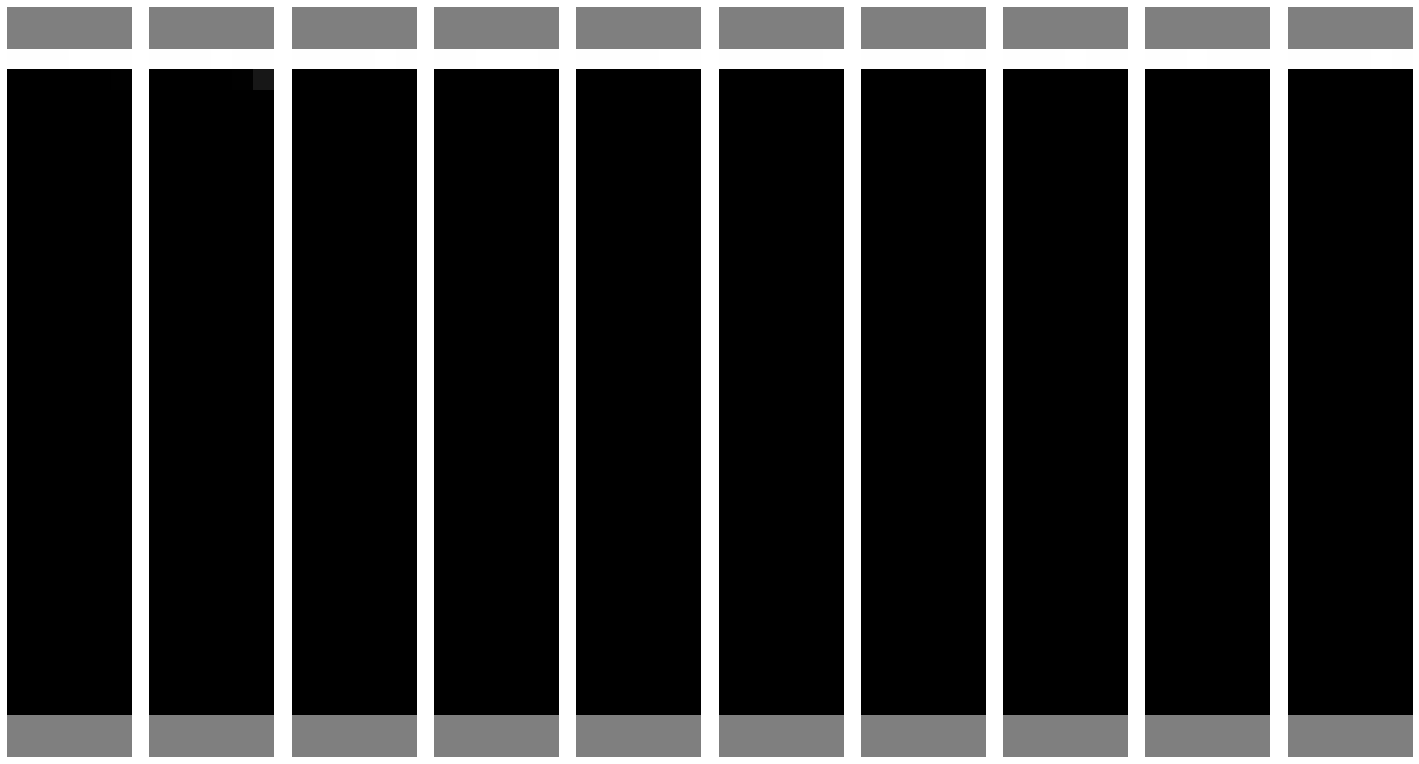

Epoch 80/200
8/8 - 1s - loss: 4.1968 - d_loss: 0.0140 - g_loss: 4.1828


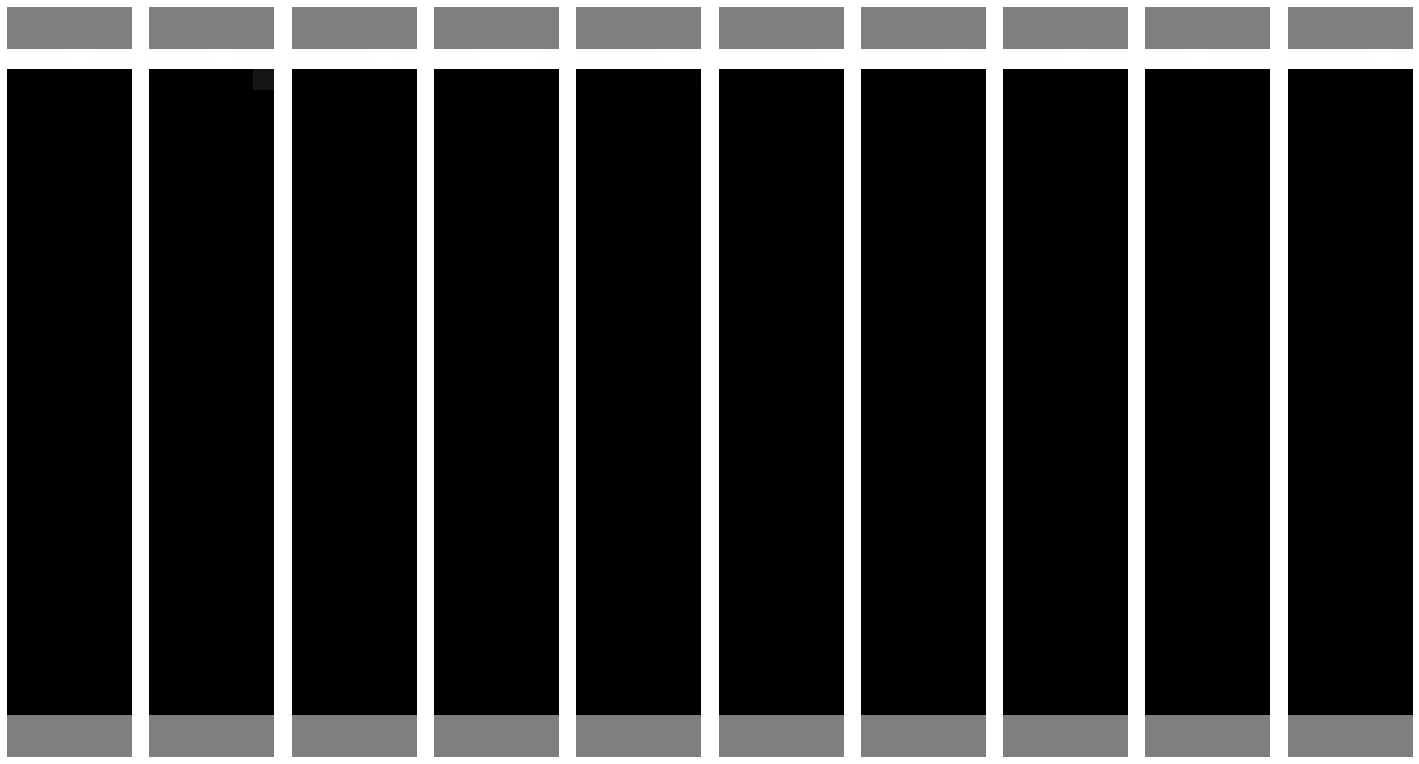

Epoch 81/200
8/8 - 1s - loss: 4.2335 - d_loss: 0.0133 - g_loss: 4.2202


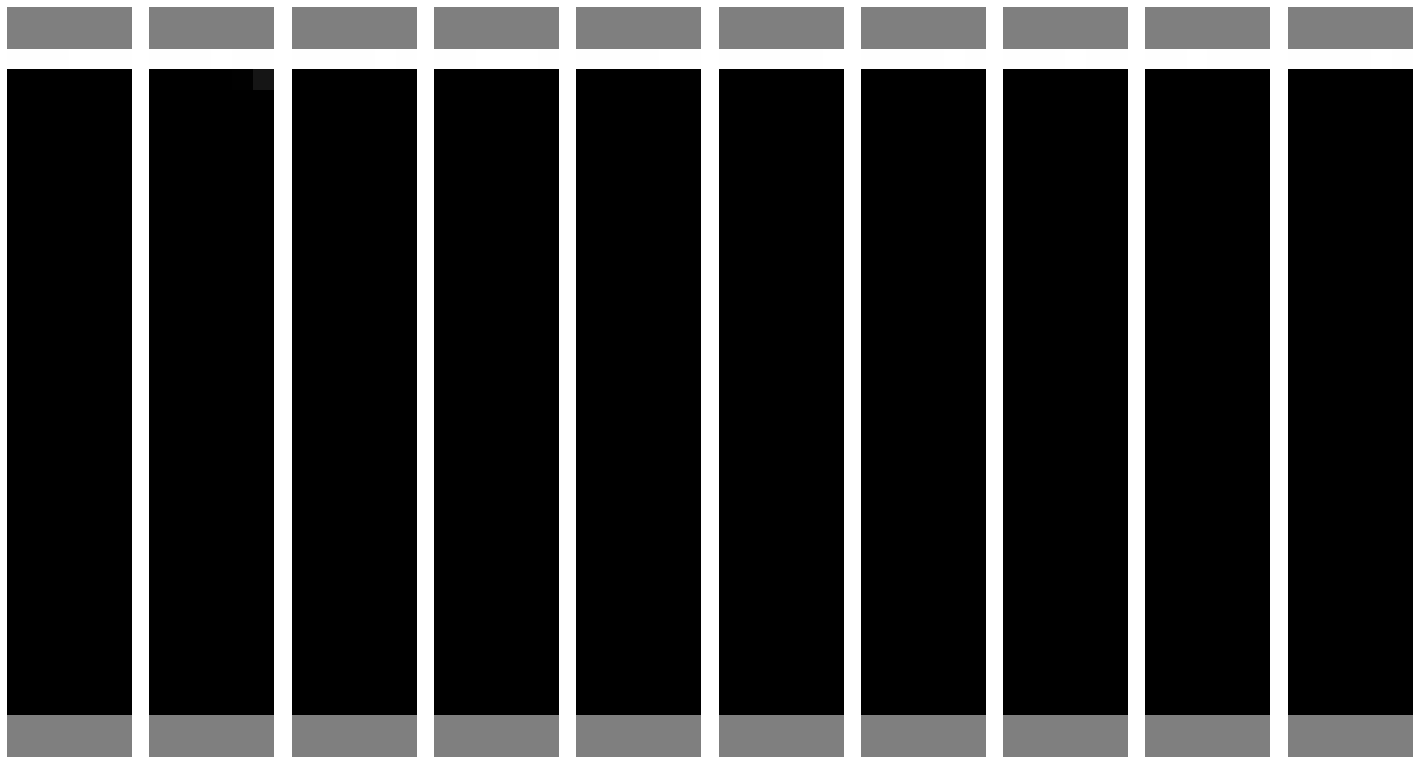

Epoch 82/200
8/8 - 1s - loss: 4.2786 - d_loss: 0.0128 - g_loss: 4.2658


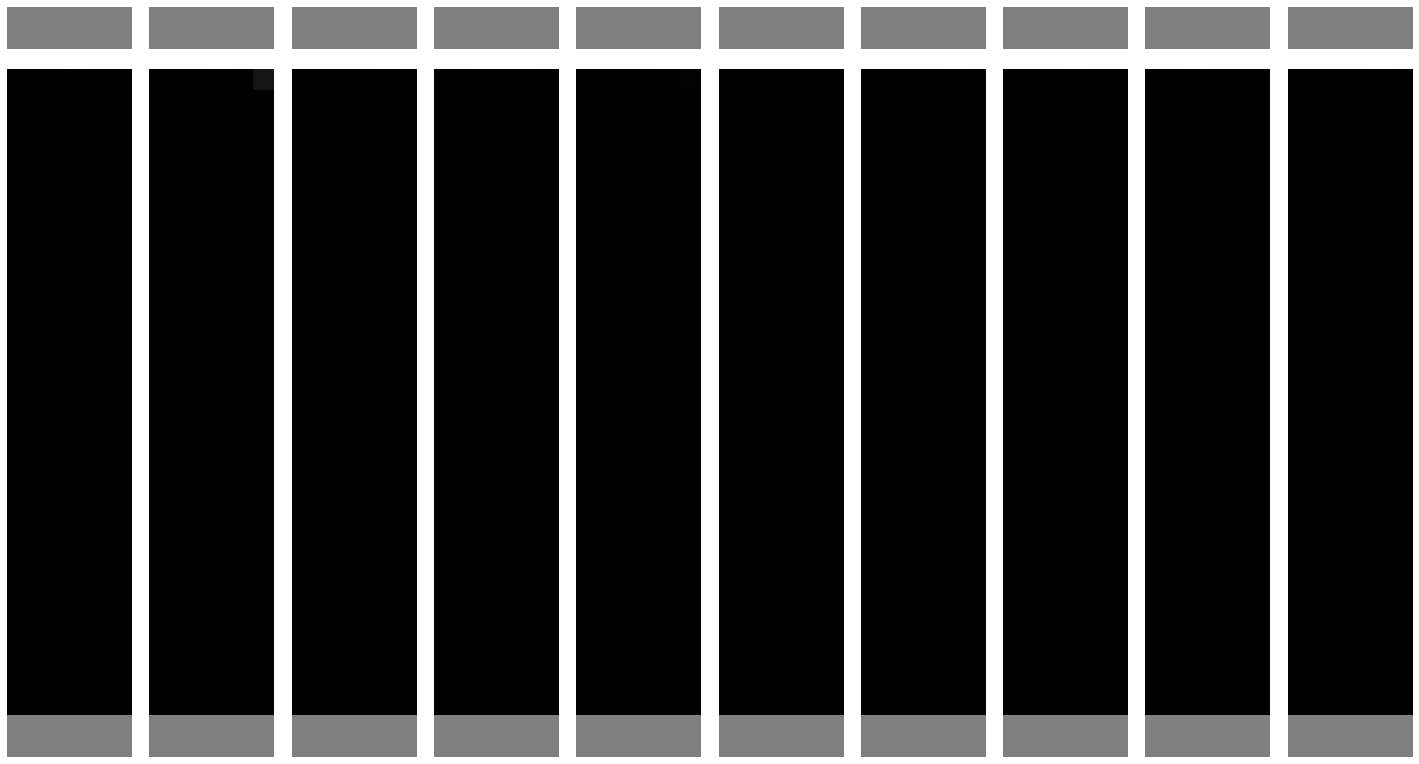

Epoch 83/200
8/8 - 1s - loss: 4.3170 - d_loss: 0.0123 - g_loss: 4.3047


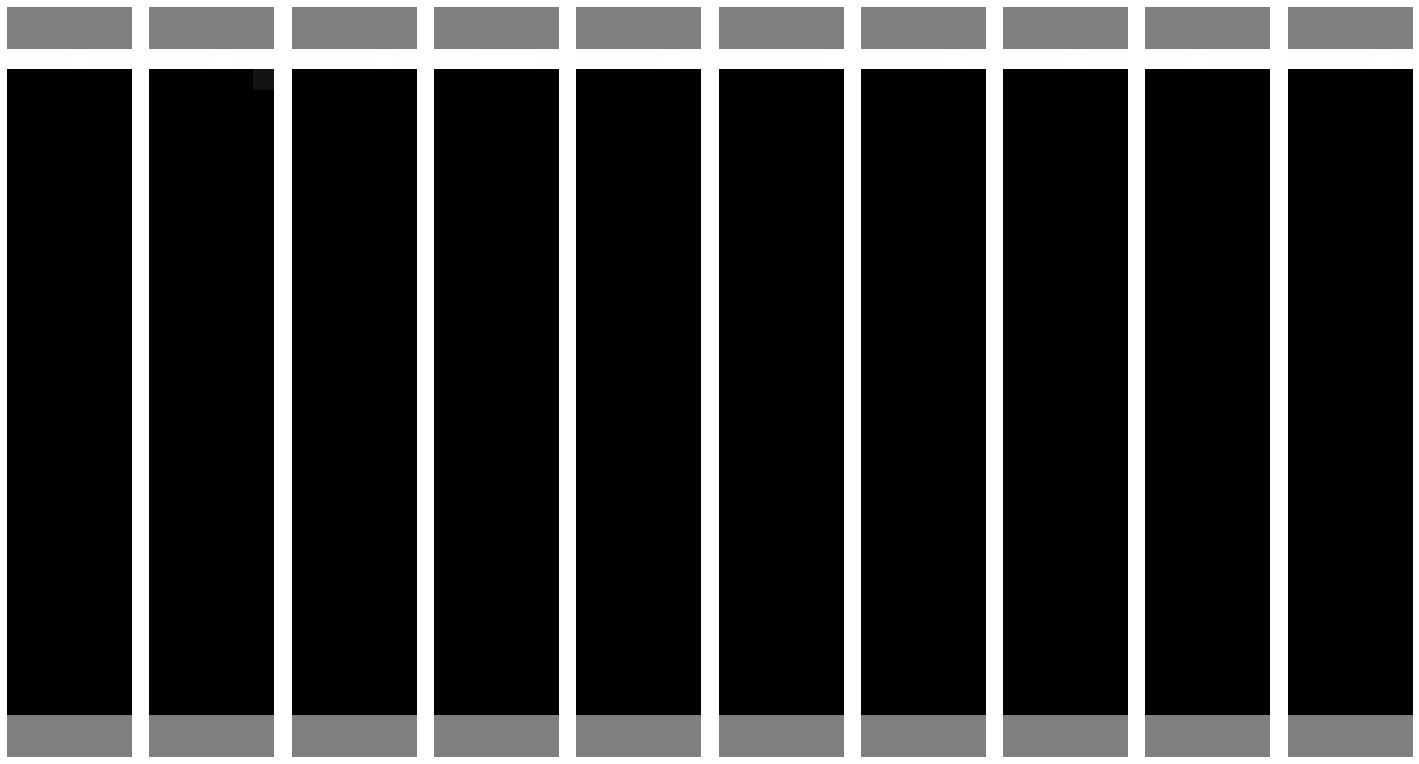

Epoch 84/200
8/8 - 1s - loss: 4.3613 - d_loss: 0.0117 - g_loss: 4.3496


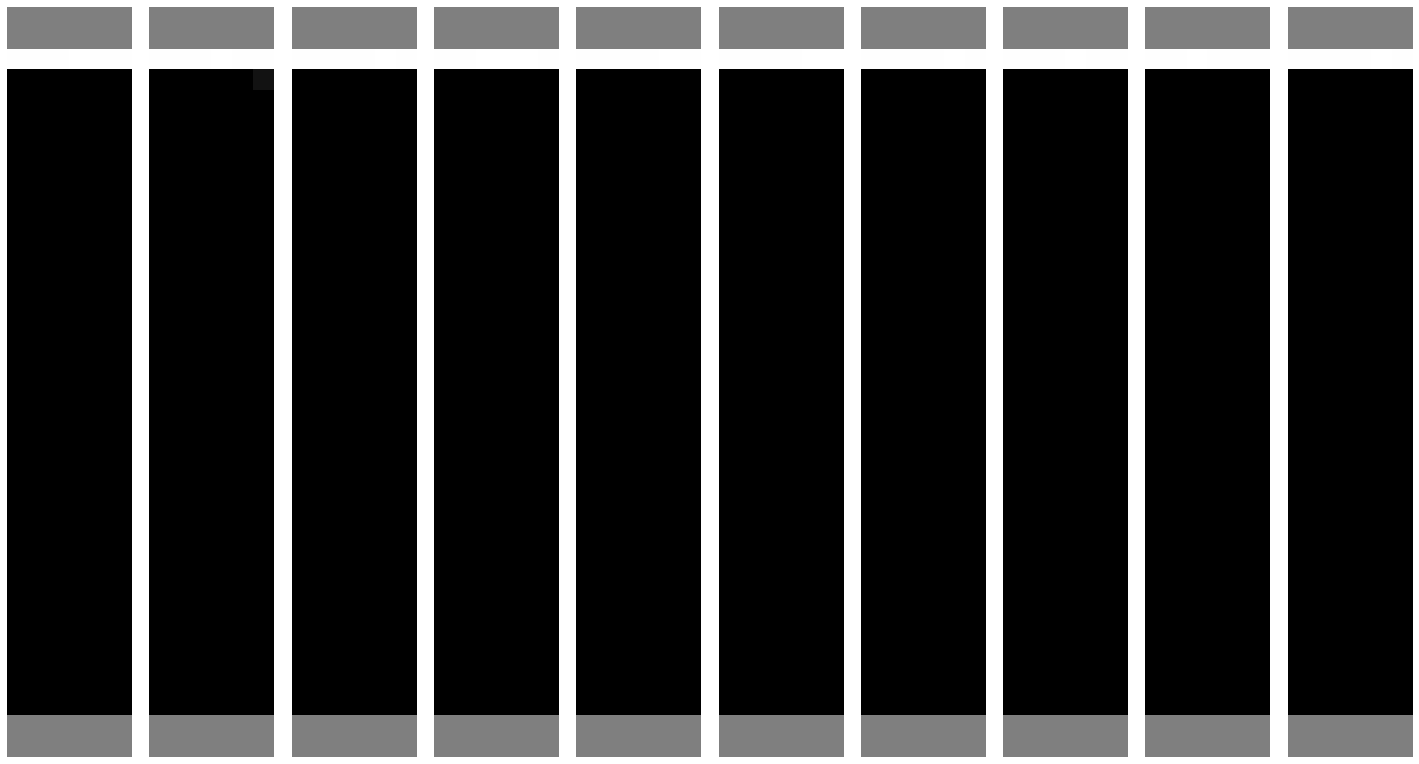

Epoch 85/200
8/8 - 1s - loss: 4.4052 - d_loss: 0.0111 - g_loss: 4.3940


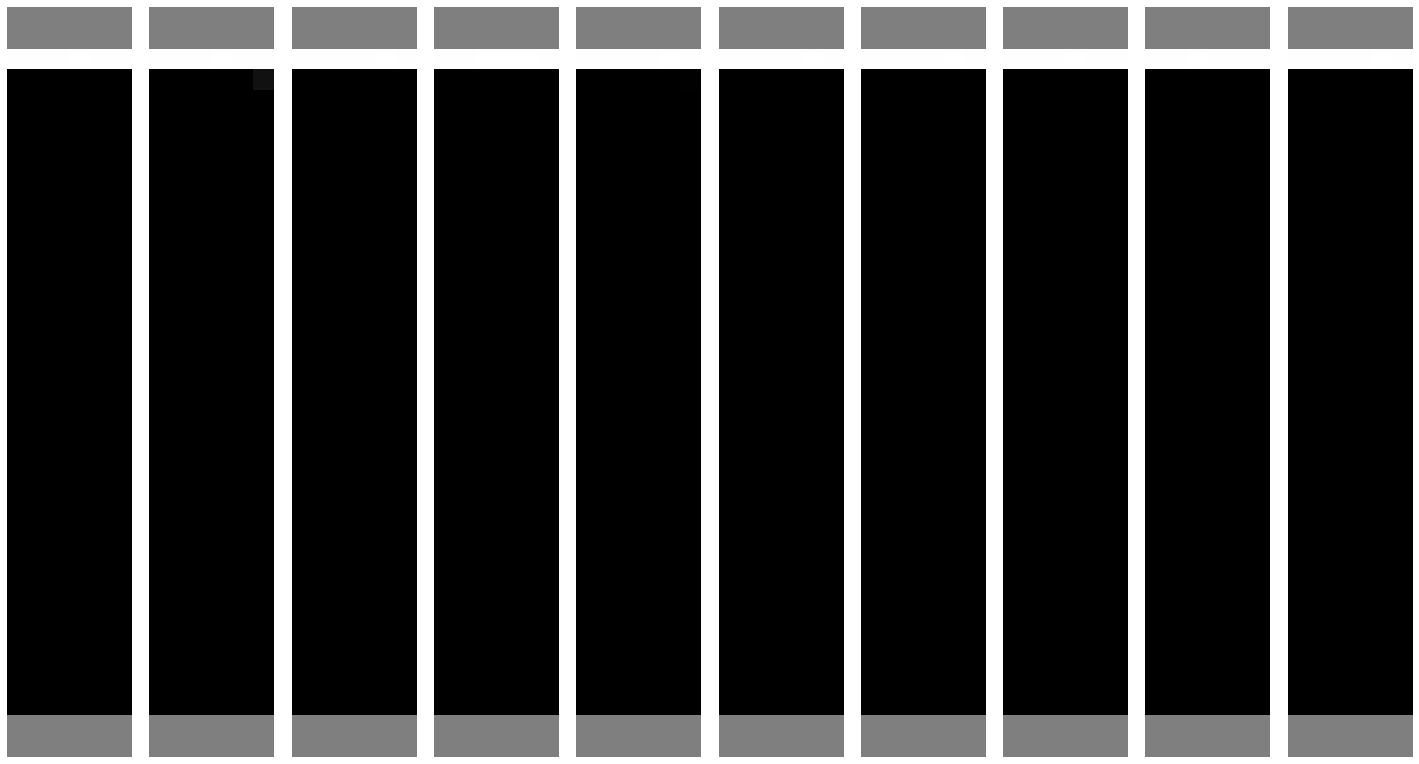

Epoch 86/200
8/8 - 1s - loss: 4.4550 - d_loss: 0.0107 - g_loss: 4.4444


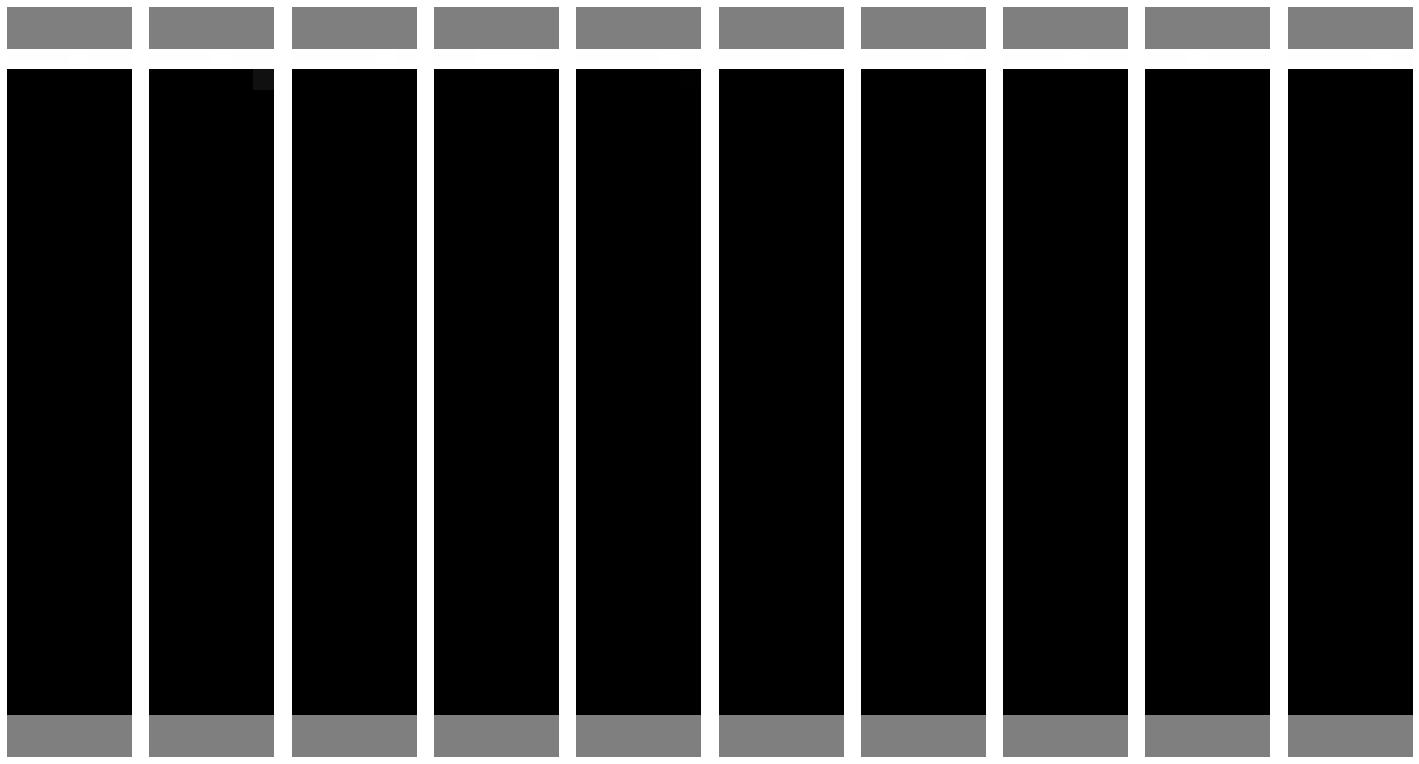

Epoch 87/200
8/8 - 1s - loss: 4.4908 - d_loss: 0.0102 - g_loss: 4.4806


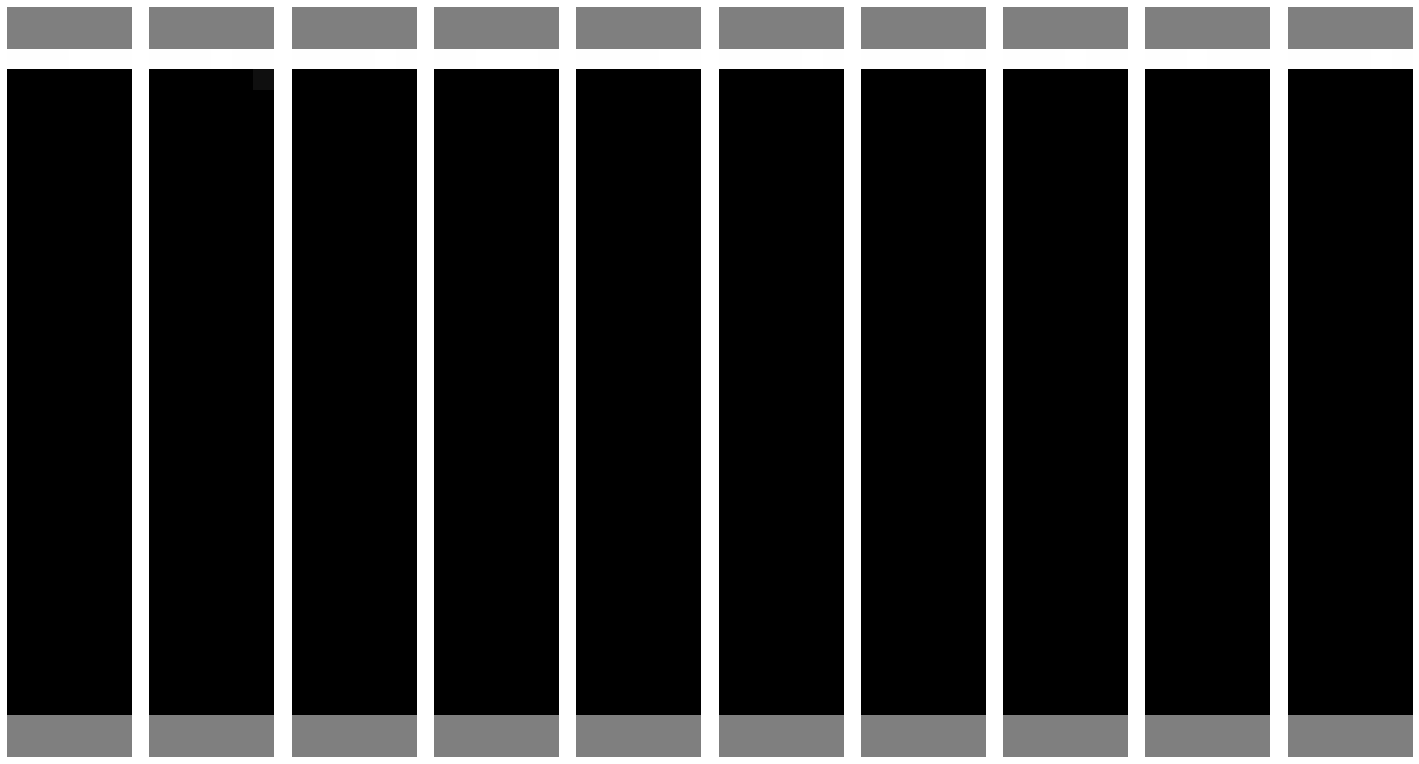

Epoch 88/200
8/8 - 1s - loss: 4.5349 - d_loss: 0.0098 - g_loss: 4.5251


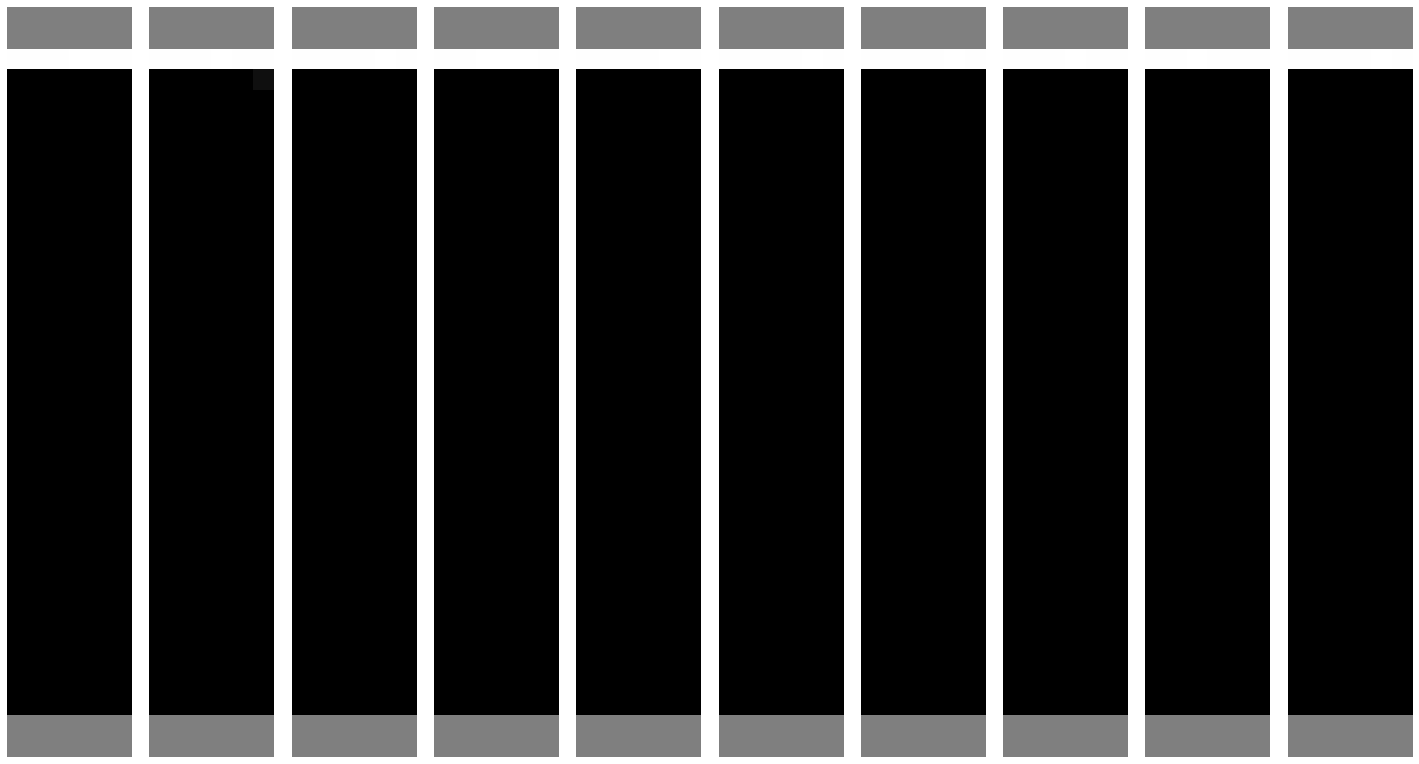

Epoch 89/200
8/8 - 1s - loss: 4.5801 - d_loss: 0.0095 - g_loss: 4.5706


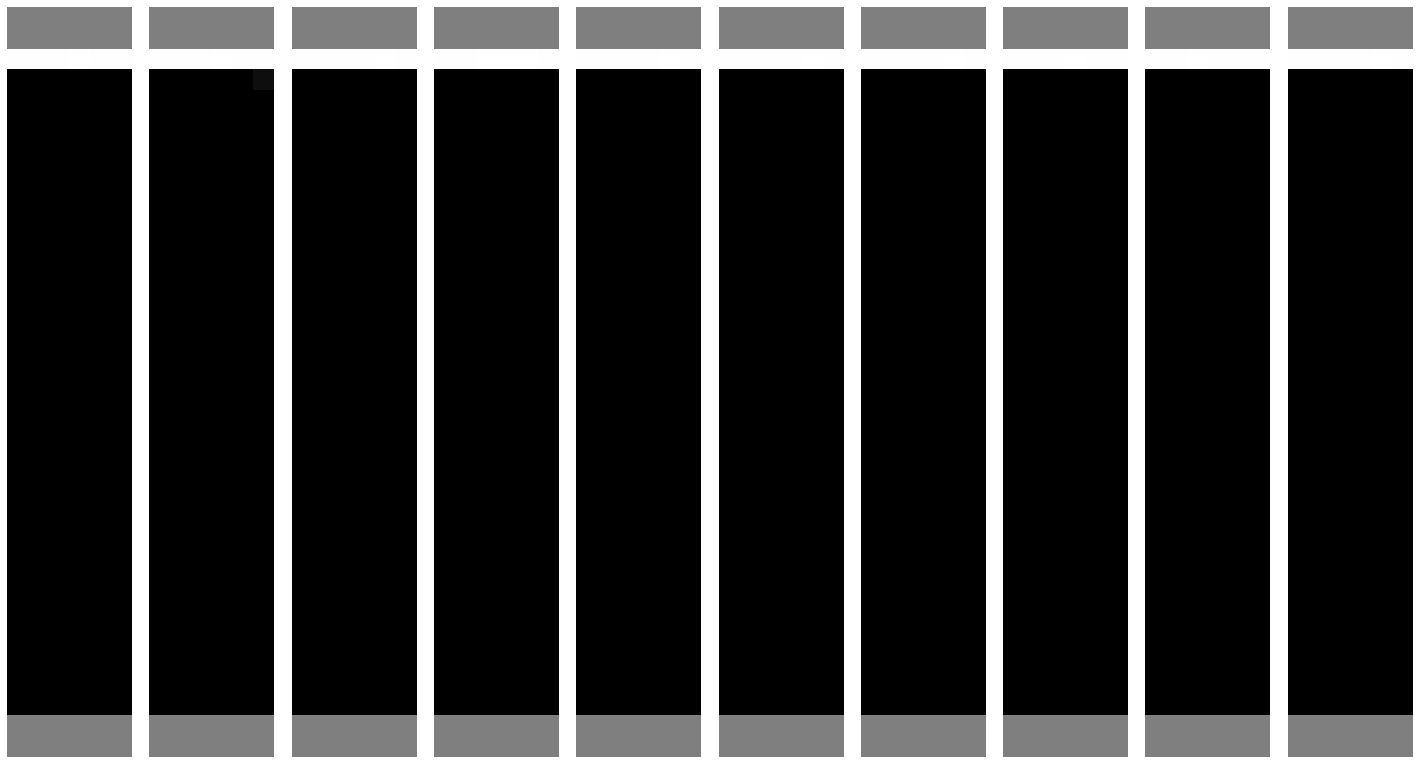

Epoch 90/200
8/8 - 1s - loss: 4.6162 - d_loss: 0.0089 - g_loss: 4.6073


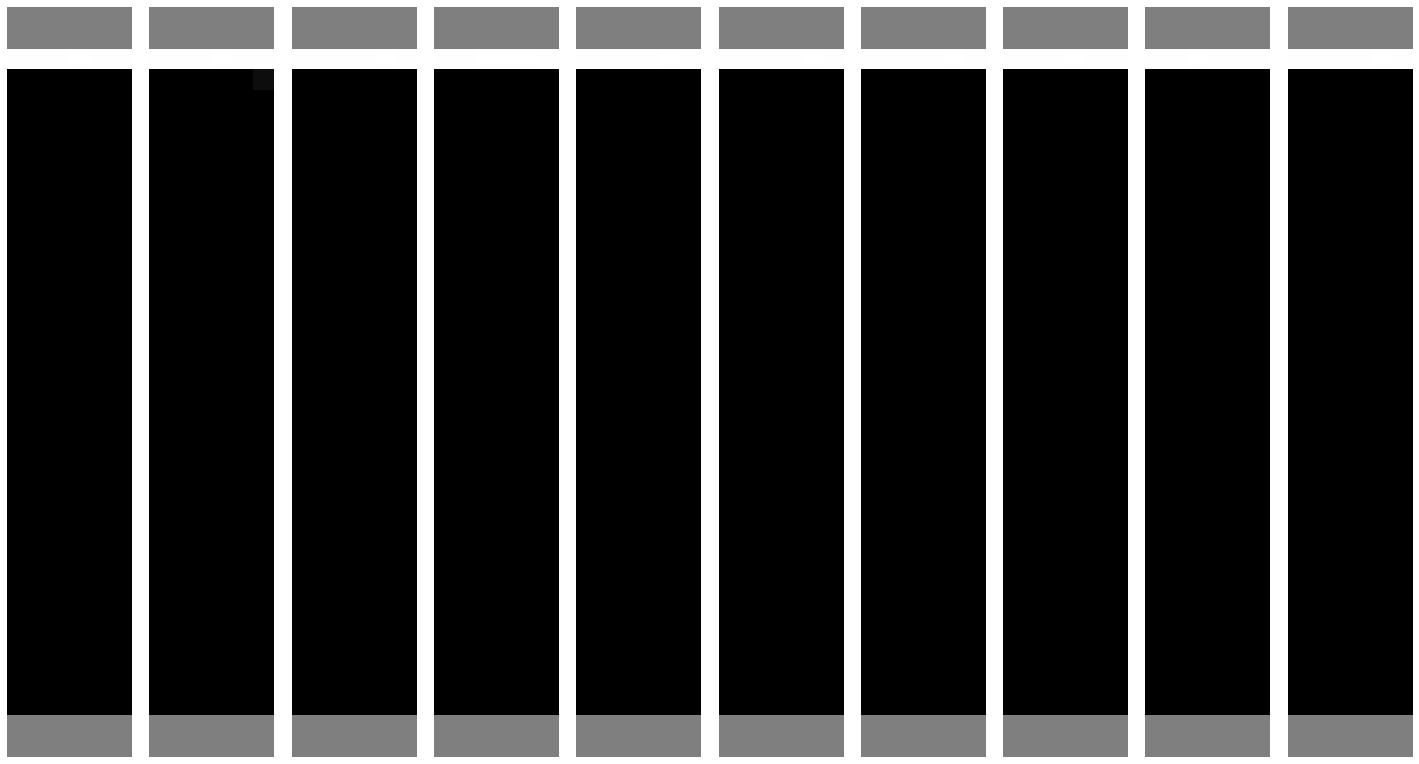

Epoch 91/200
8/8 - 1s - loss: 4.6525 - d_loss: 0.0087 - g_loss: 4.6439


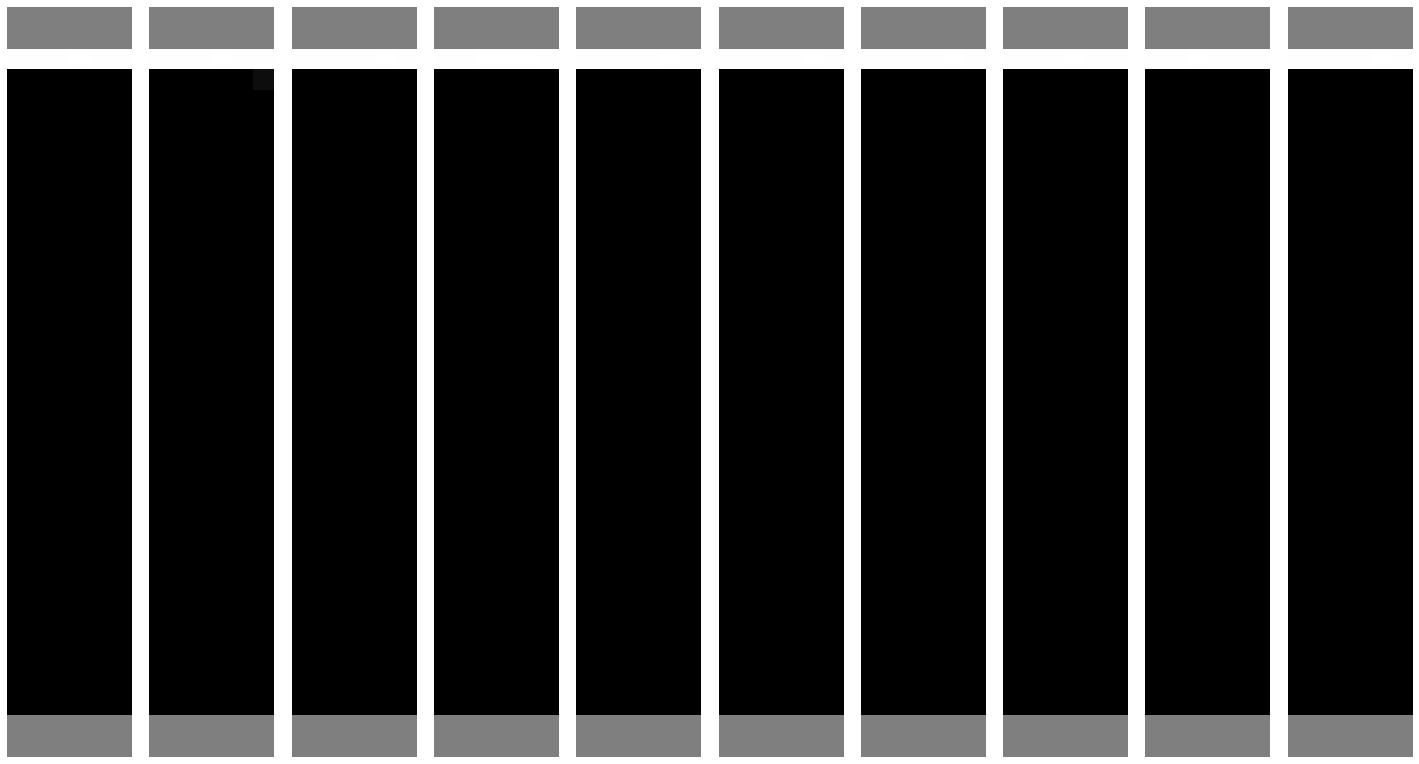

Epoch 92/200
8/8 - 1s - loss: 4.6963 - d_loss: 0.0083 - g_loss: 4.6880


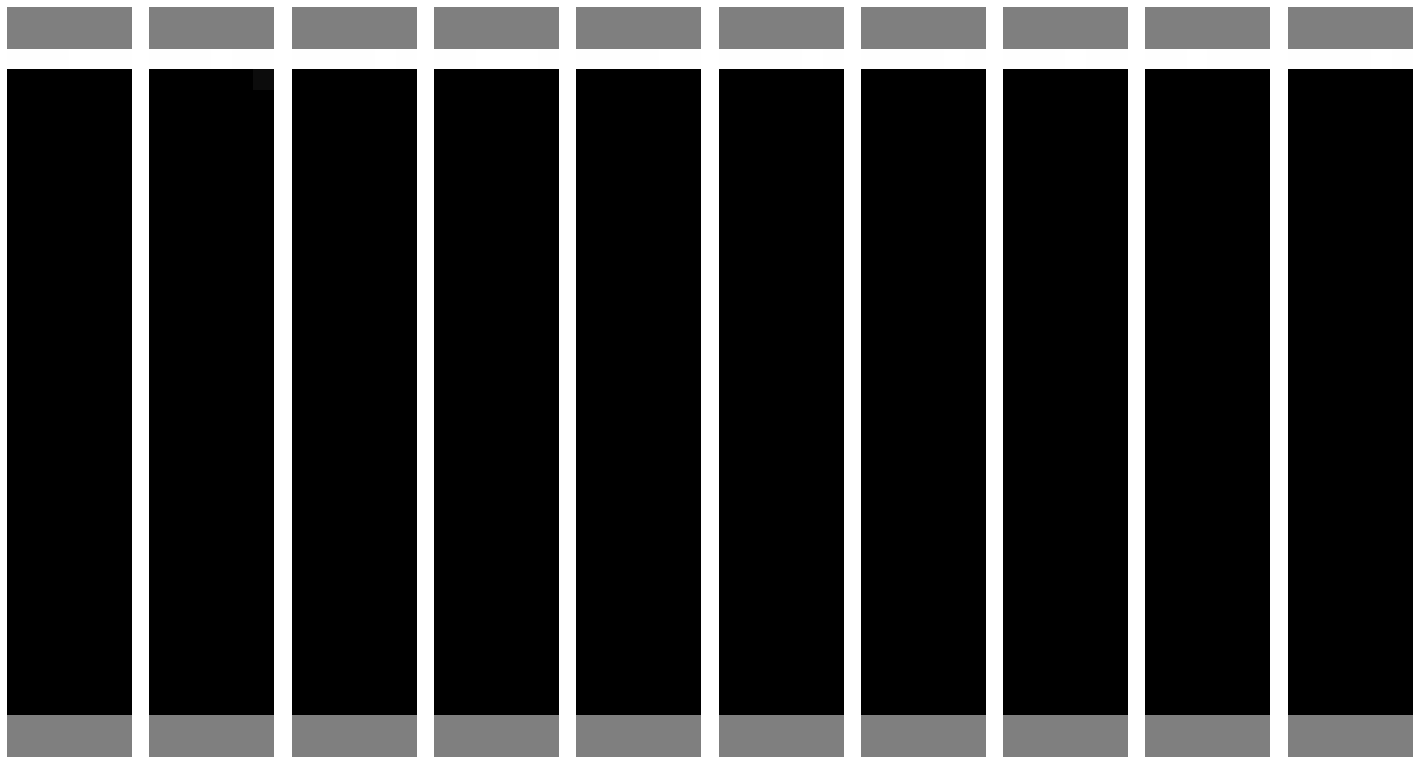

Epoch 93/200
8/8 - 1s - loss: 4.7368 - d_loss: 0.0080 - g_loss: 4.7287


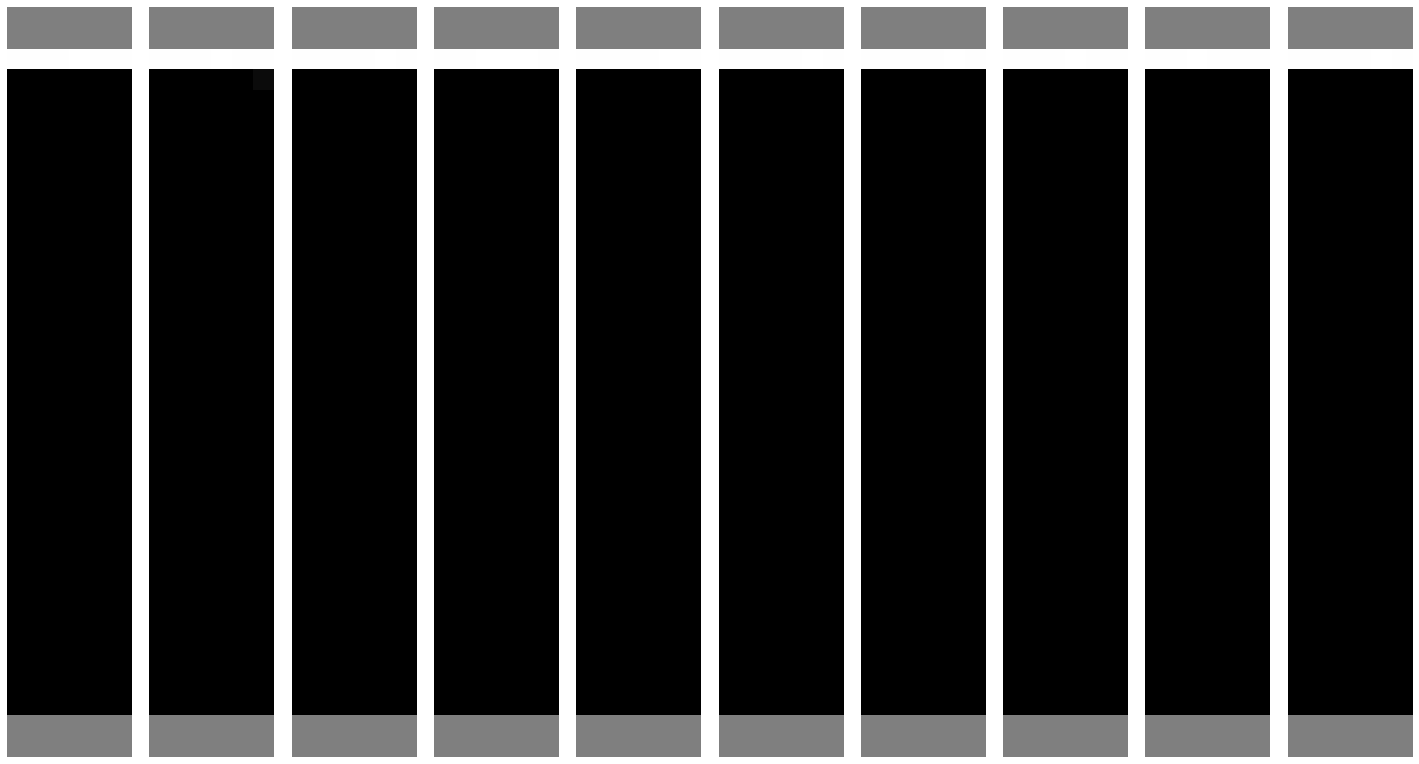

Epoch 94/200
8/8 - 1s - loss: 4.7720 - d_loss: 0.0077 - g_loss: 4.7643


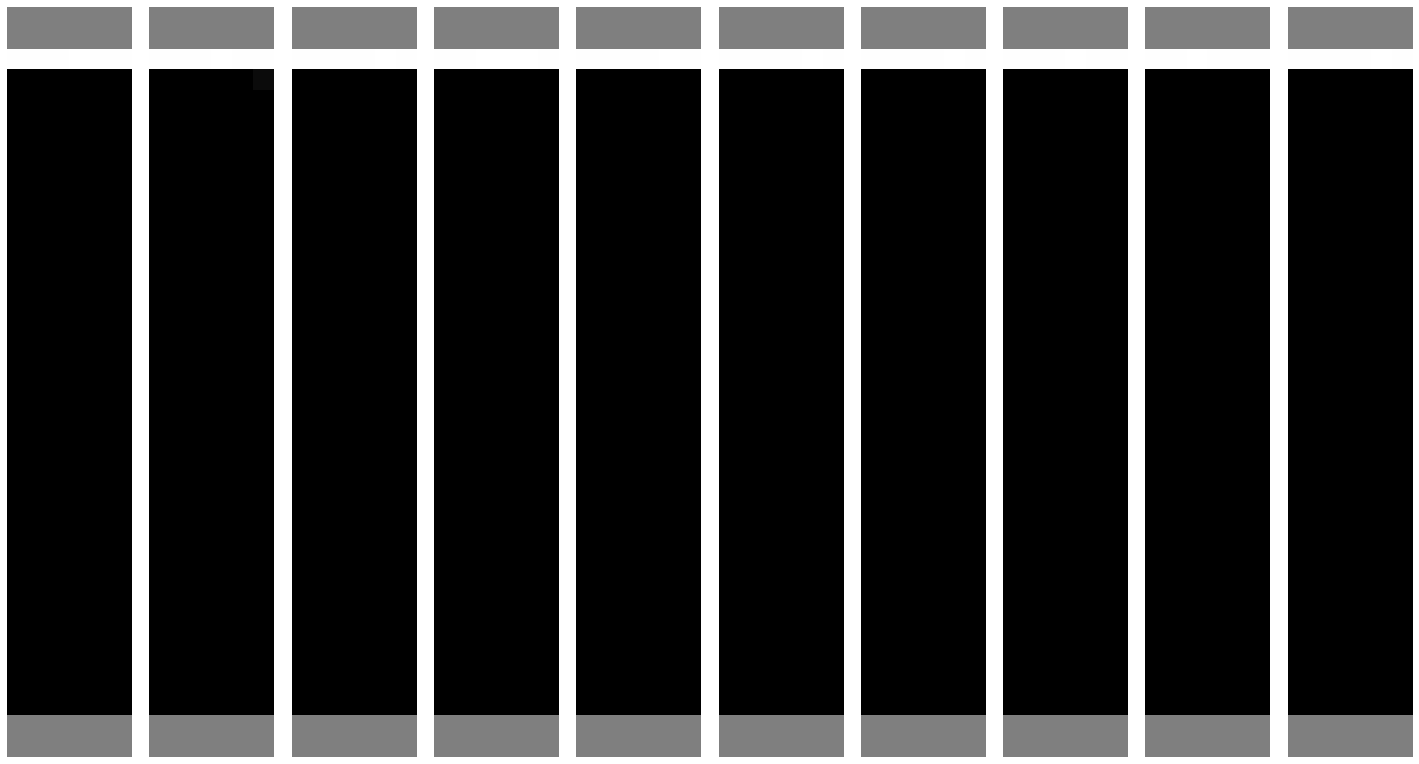

Epoch 95/200
8/8 - 1s - loss: 4.8057 - d_loss: 0.0074 - g_loss: 4.7983


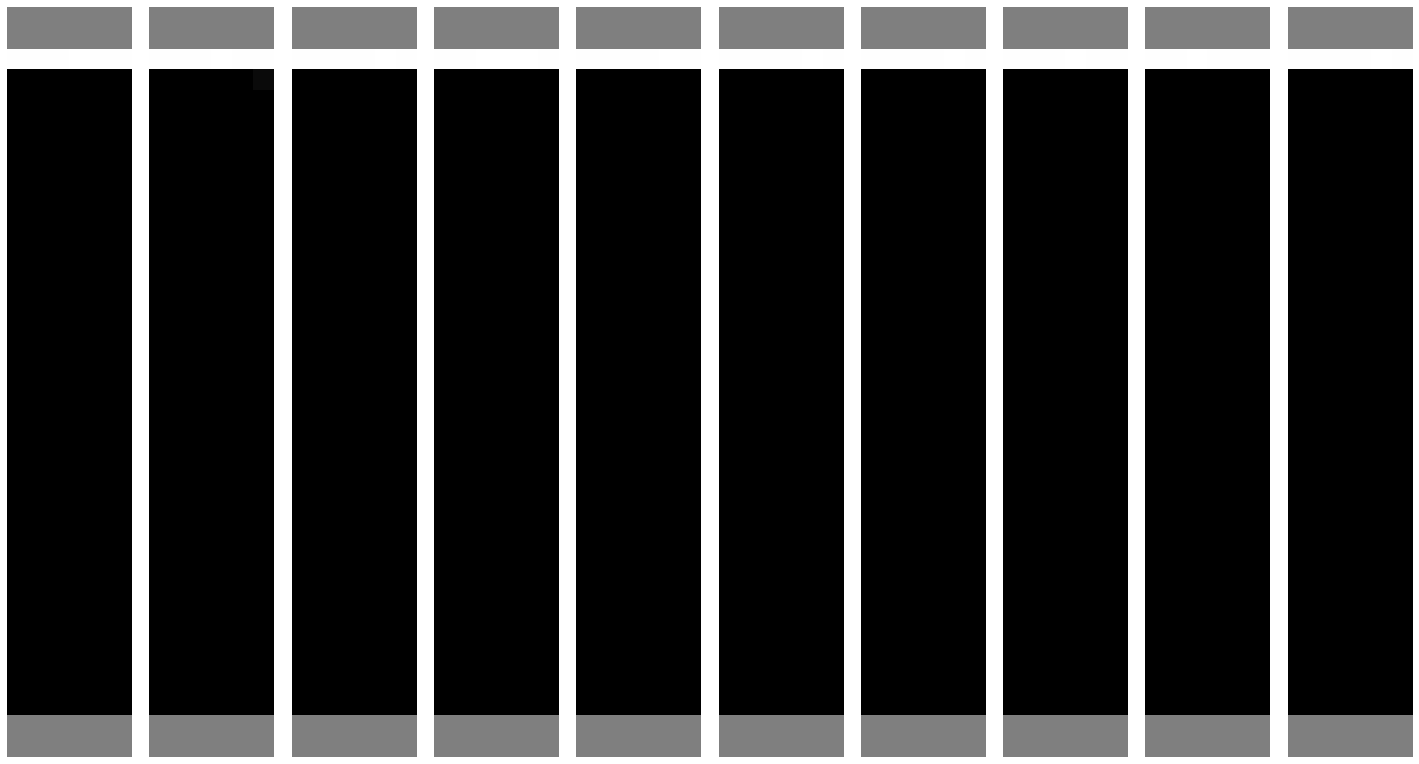

Epoch 96/200
8/8 - 1s - loss: 4.8421 - d_loss: 0.0072 - g_loss: 4.8349


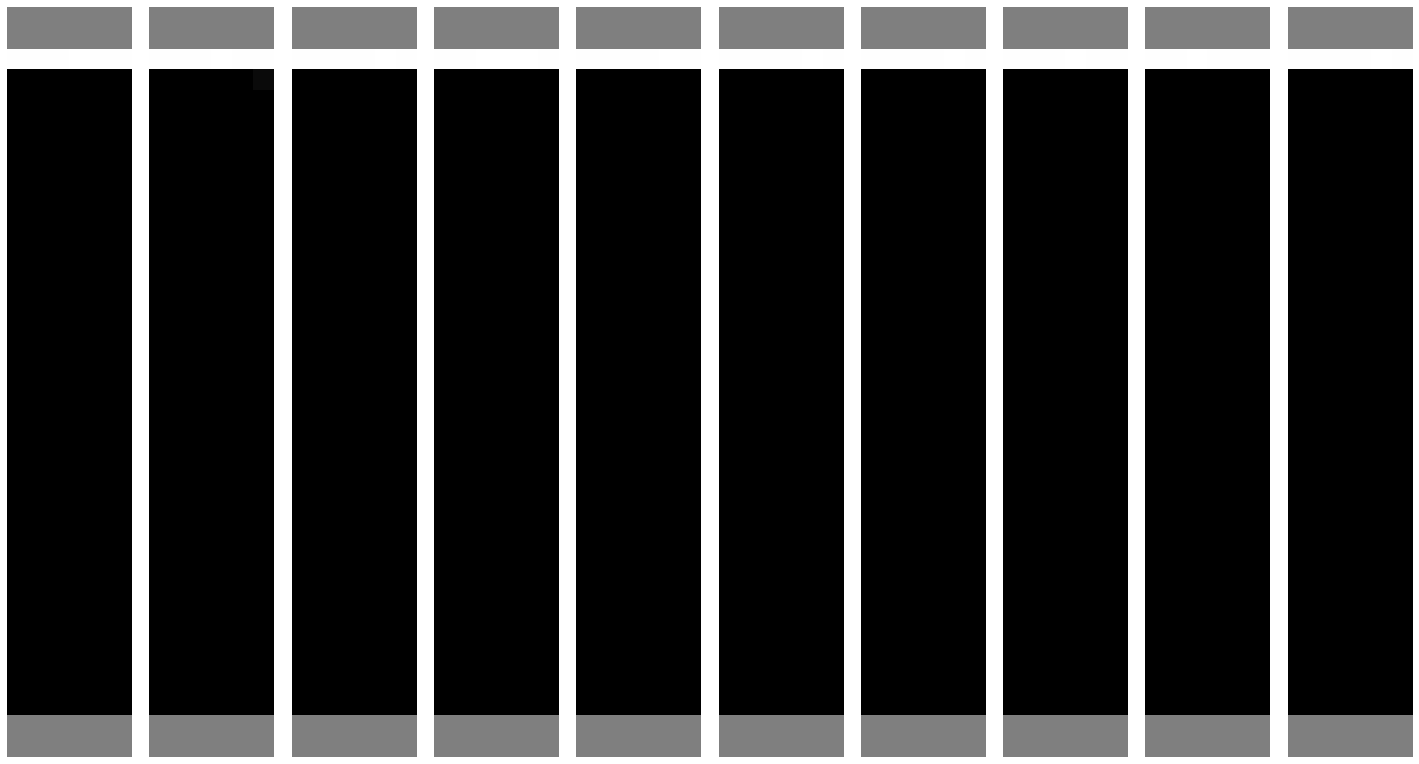

Epoch 97/200
8/8 - 1s - loss: 4.8823 - d_loss: 0.0068 - g_loss: 4.8754


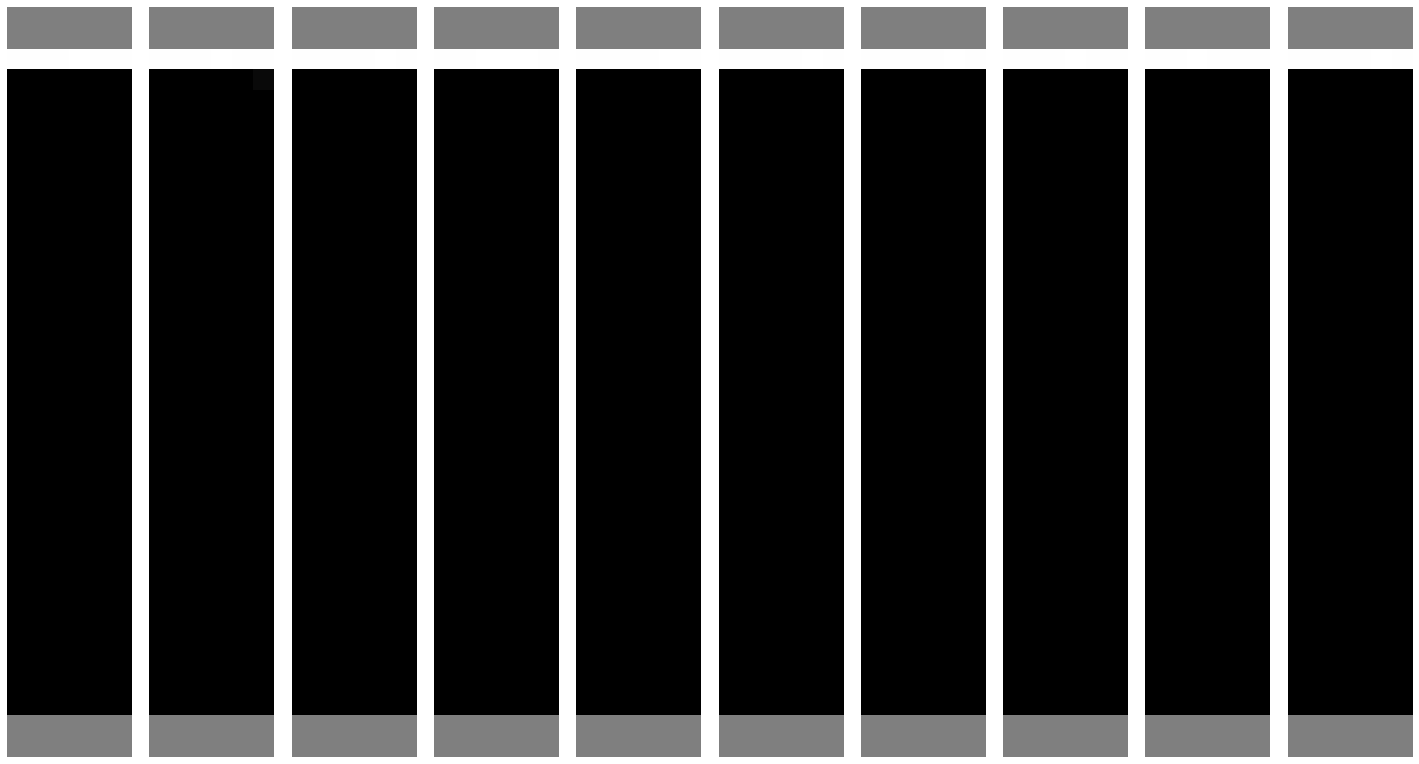

Epoch 98/200
8/8 - 1s - loss: 4.9173 - d_loss: 0.0067 - g_loss: 4.9106


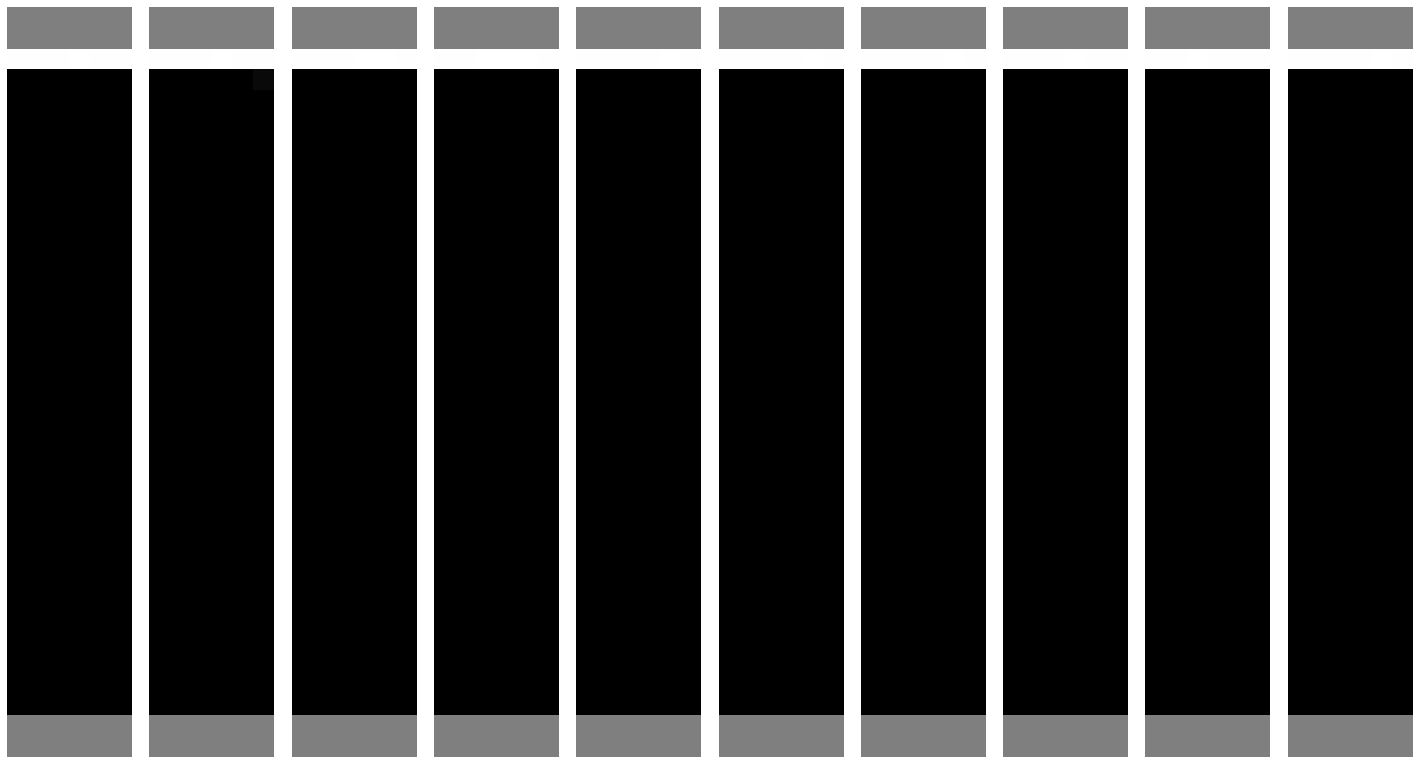

Epoch 99/200
8/8 - 1s - loss: 4.9476 - d_loss: 0.0064 - g_loss: 4.9412


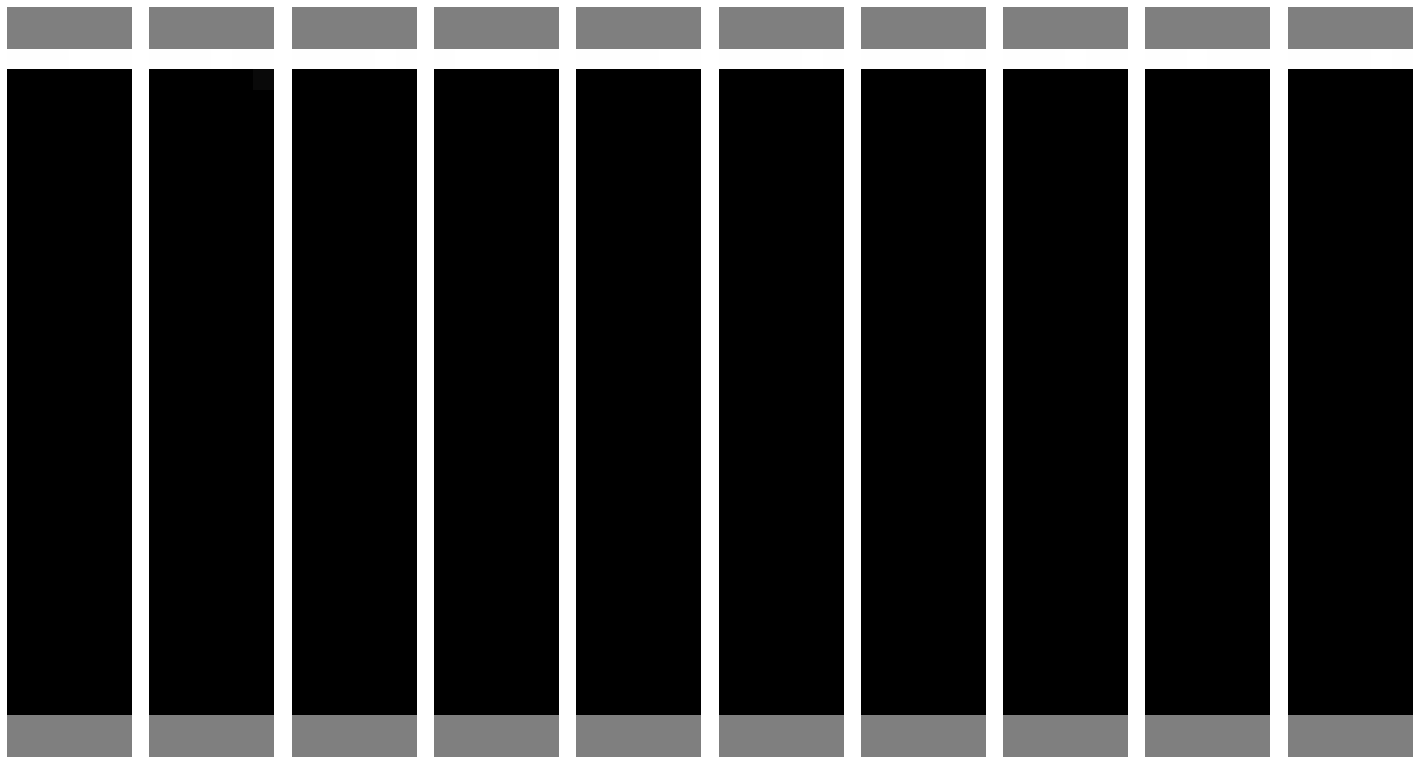

Epoch 100/200
8/8 - 1s - loss: 4.9834 - d_loss: 0.0062 - g_loss: 4.9772


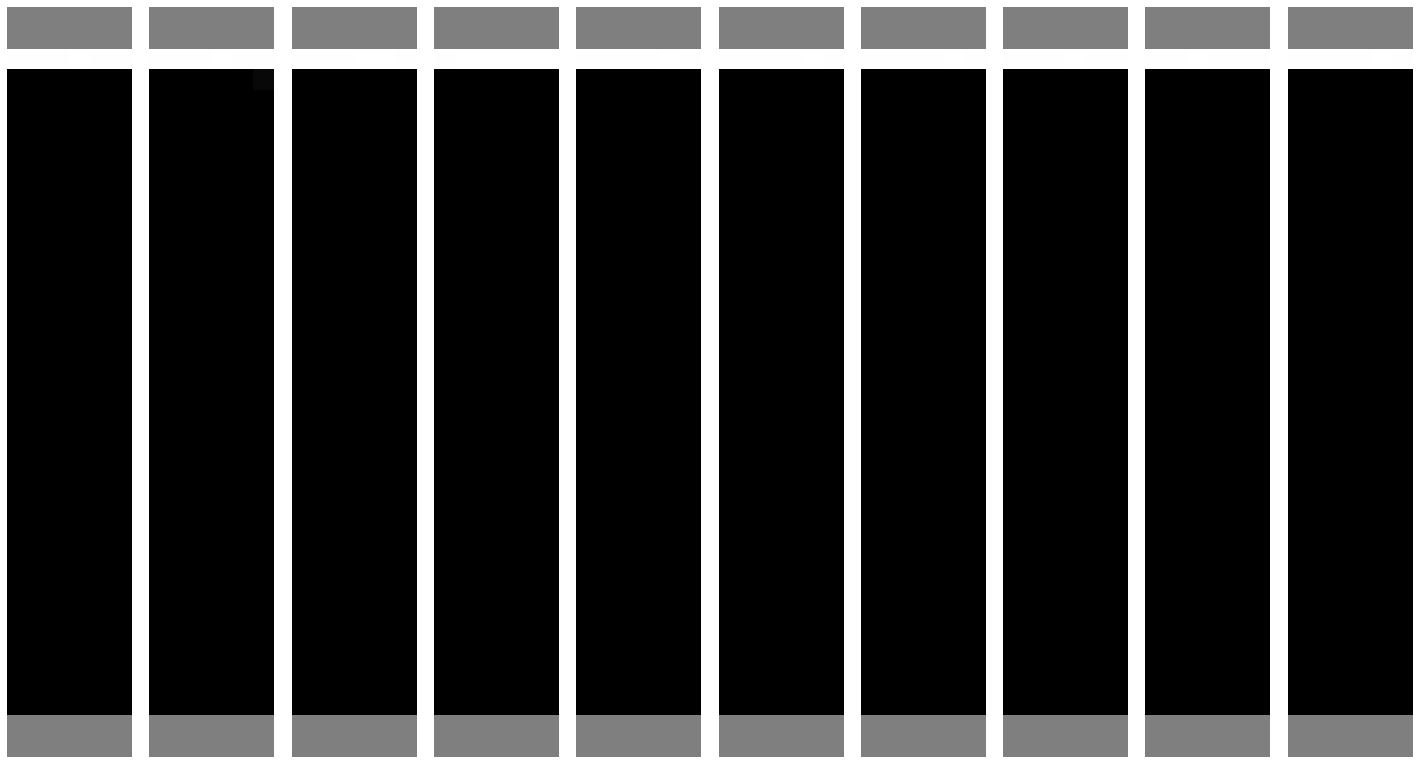

Epoch 101/200
8/8 - 1s - loss: 5.0196 - d_loss: 0.0059 - g_loss: 5.0137


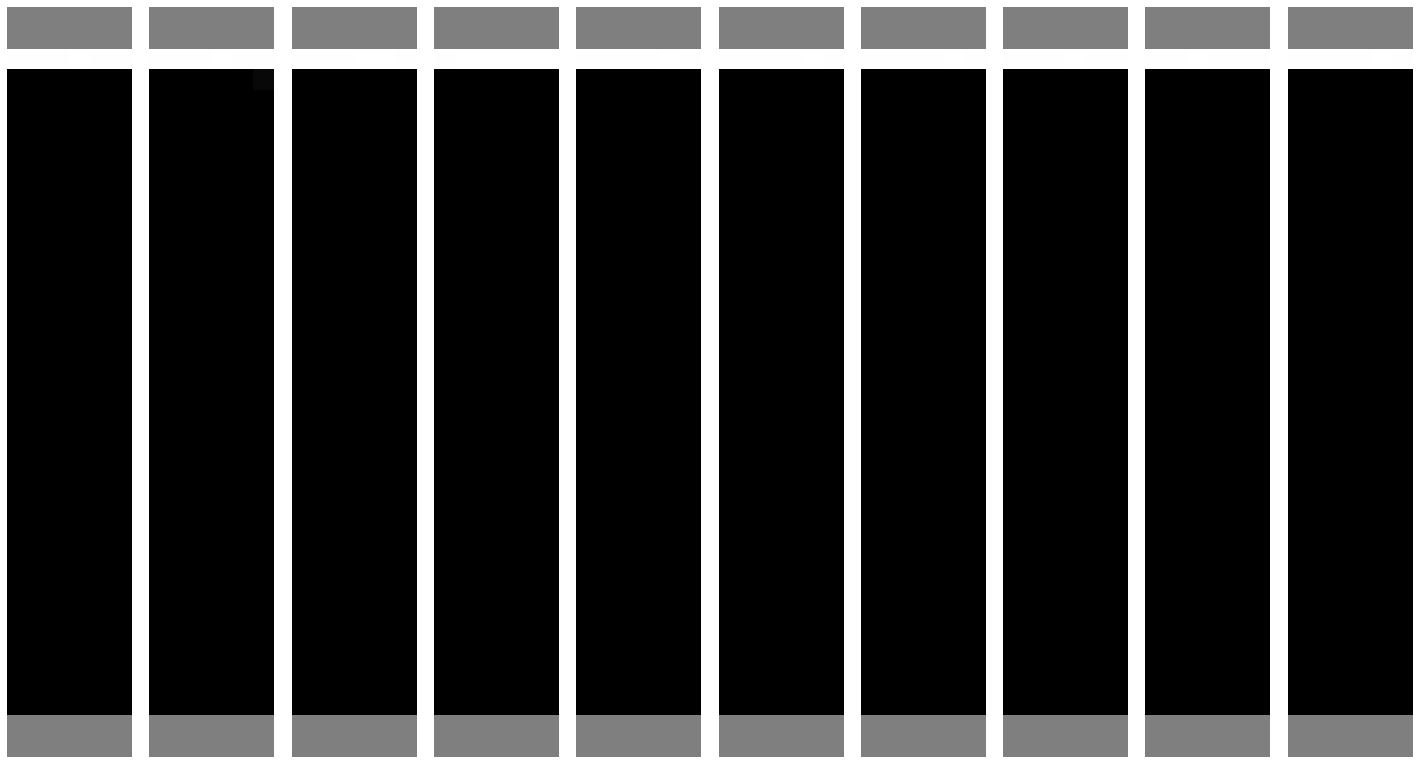

Epoch 102/200
8/8 - 1s - loss: 5.0551 - d_loss: 0.0058 - g_loss: 5.0494


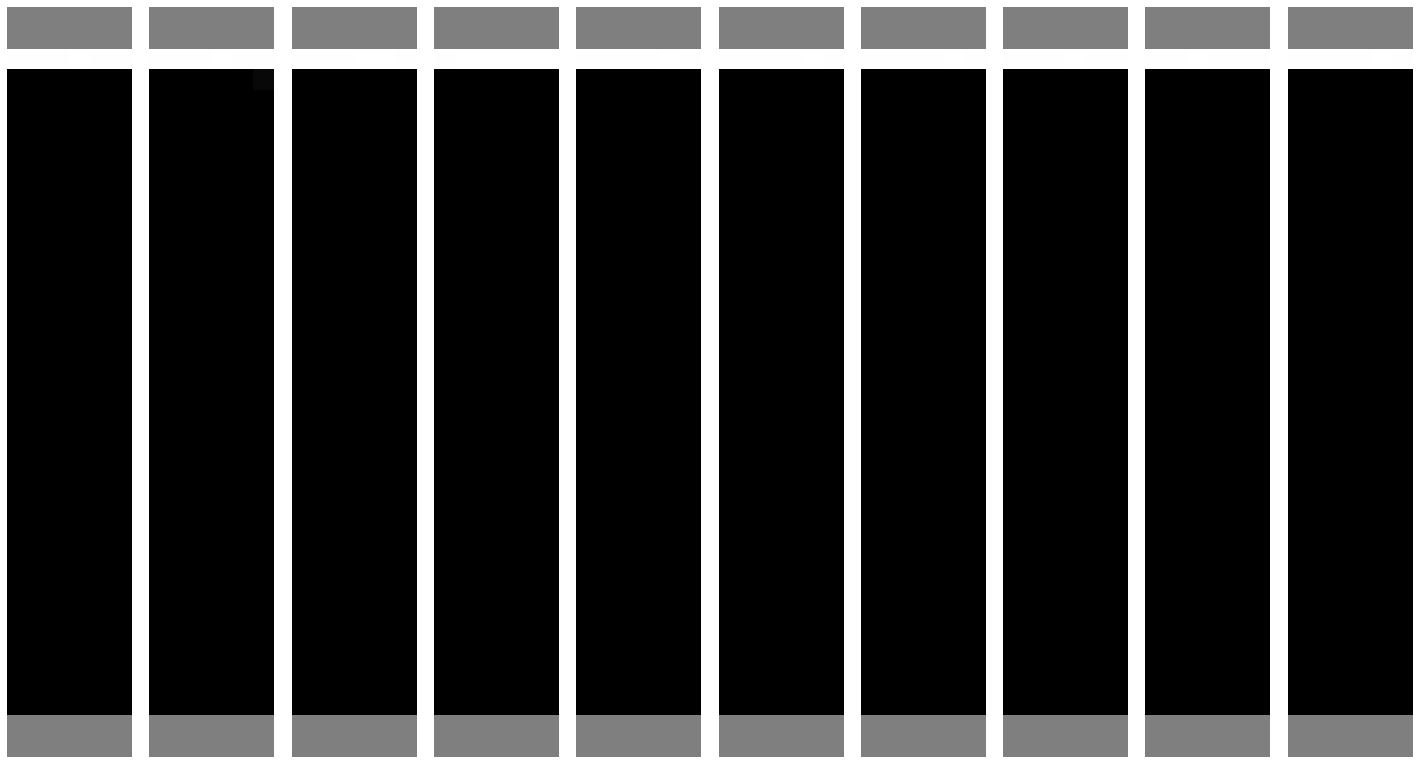

Epoch 103/200
8/8 - 1s - loss: 5.0940 - d_loss: 0.0057 - g_loss: 5.0883


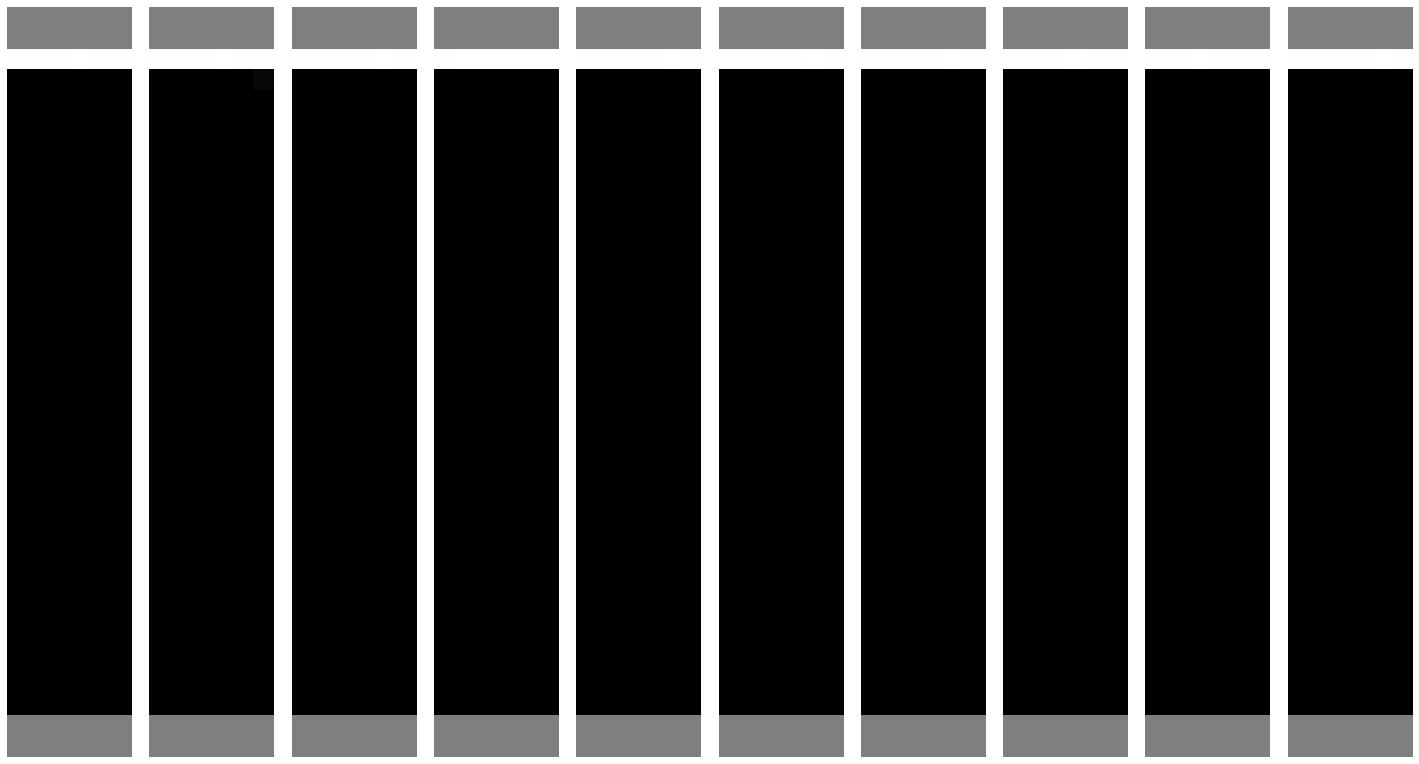

Epoch 104/200
8/8 - 1s - loss: 5.1256 - d_loss: 0.0054 - g_loss: 5.1202


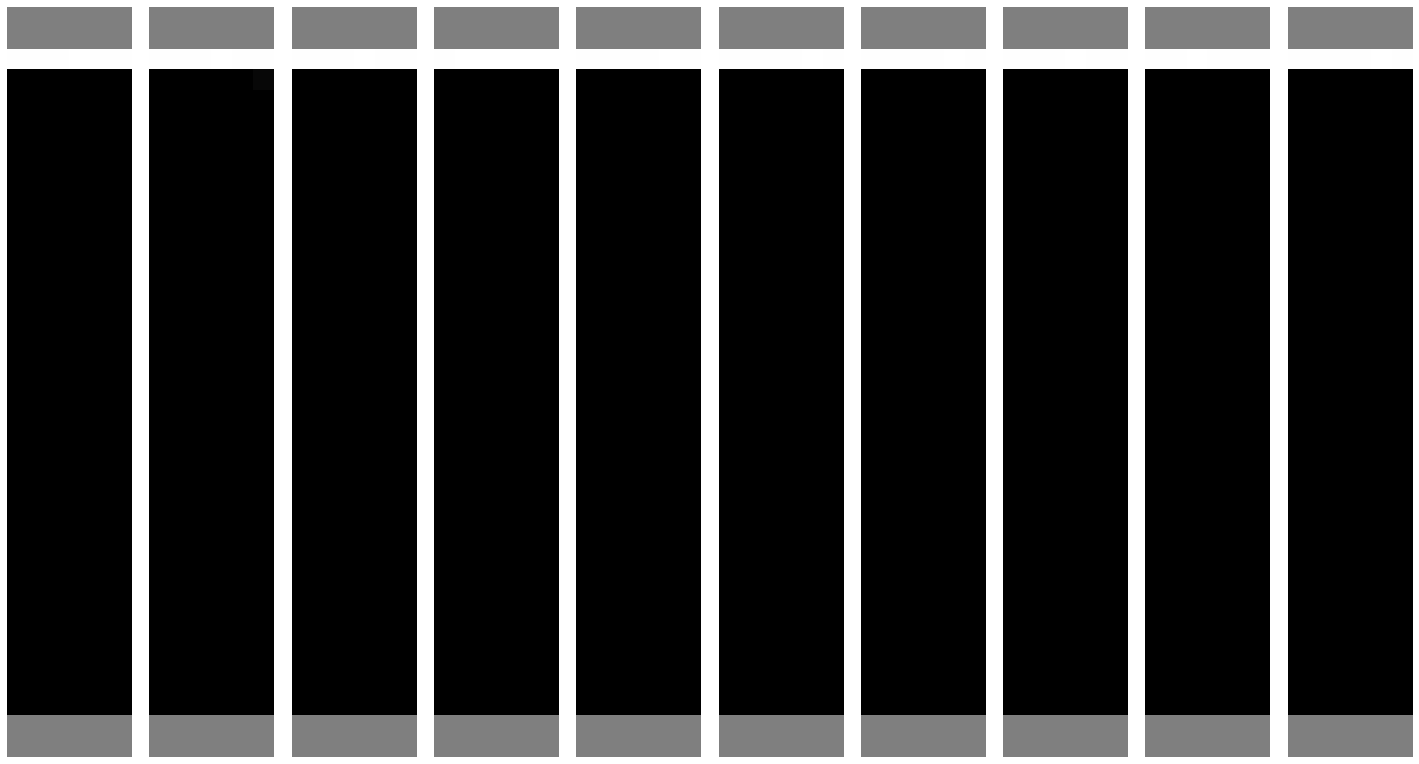

Epoch 105/200
8/8 - 1s - loss: 5.1522 - d_loss: 0.0052 - g_loss: 5.1470


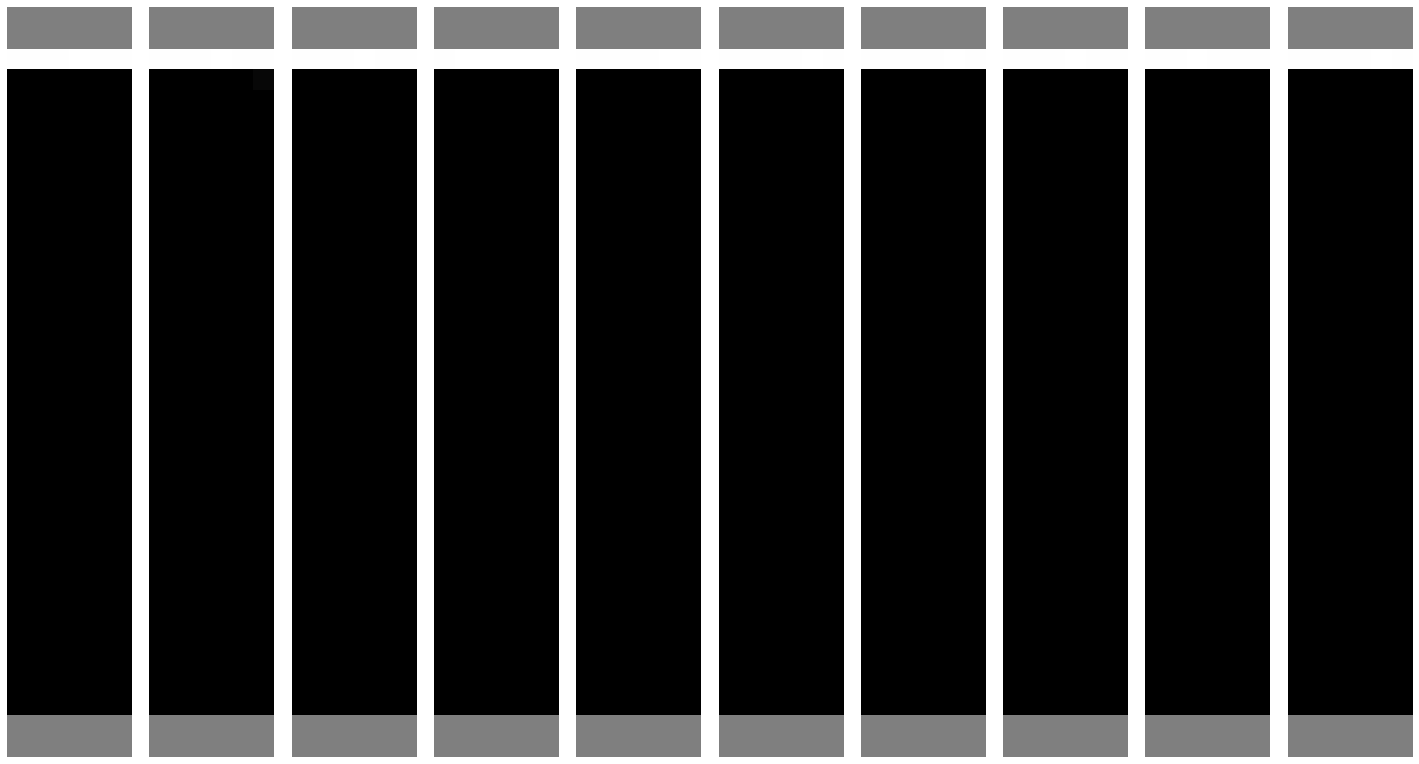

Epoch 106/200
8/8 - 1s - loss: 5.1797 - d_loss: 0.0050 - g_loss: 5.1747


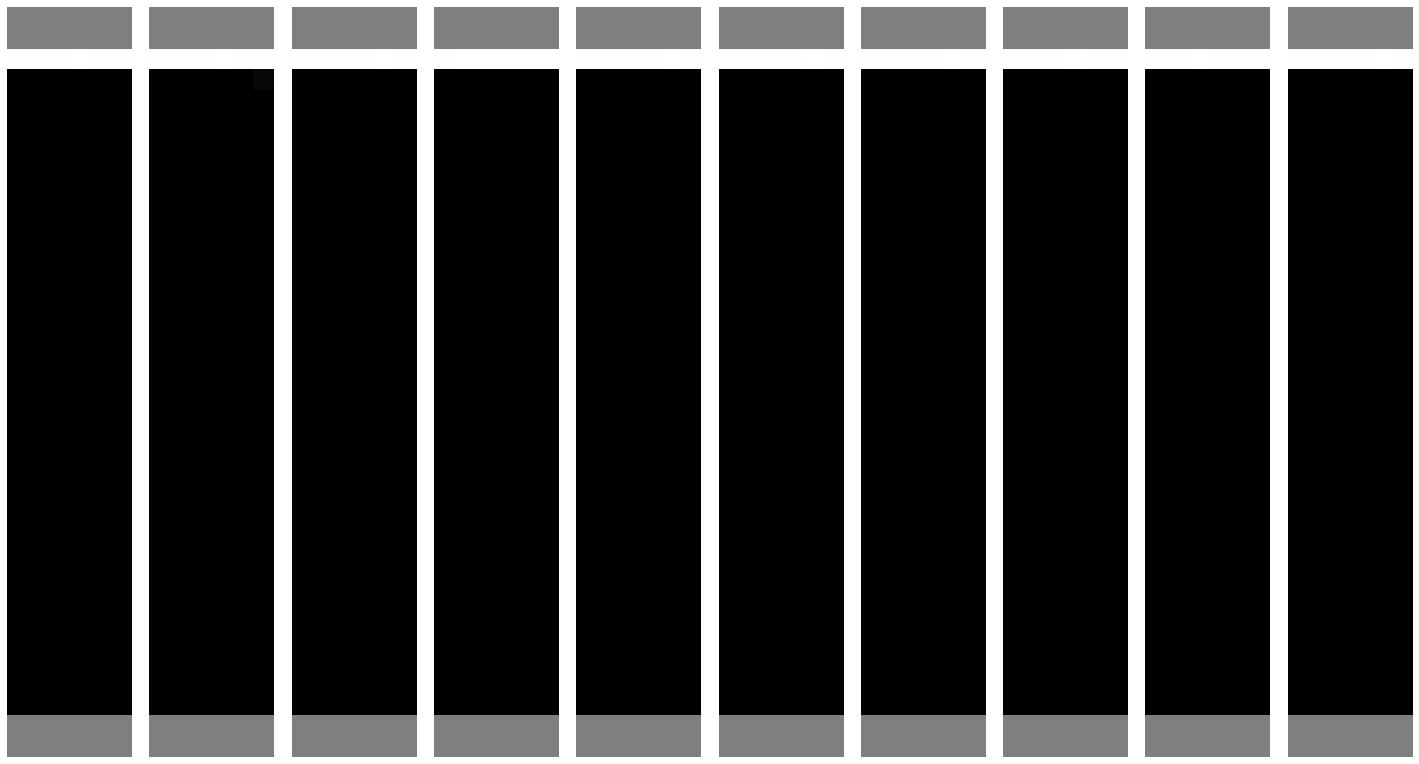

Epoch 107/200
8/8 - 1s - loss: 5.2213 - d_loss: 0.0049 - g_loss: 5.2164


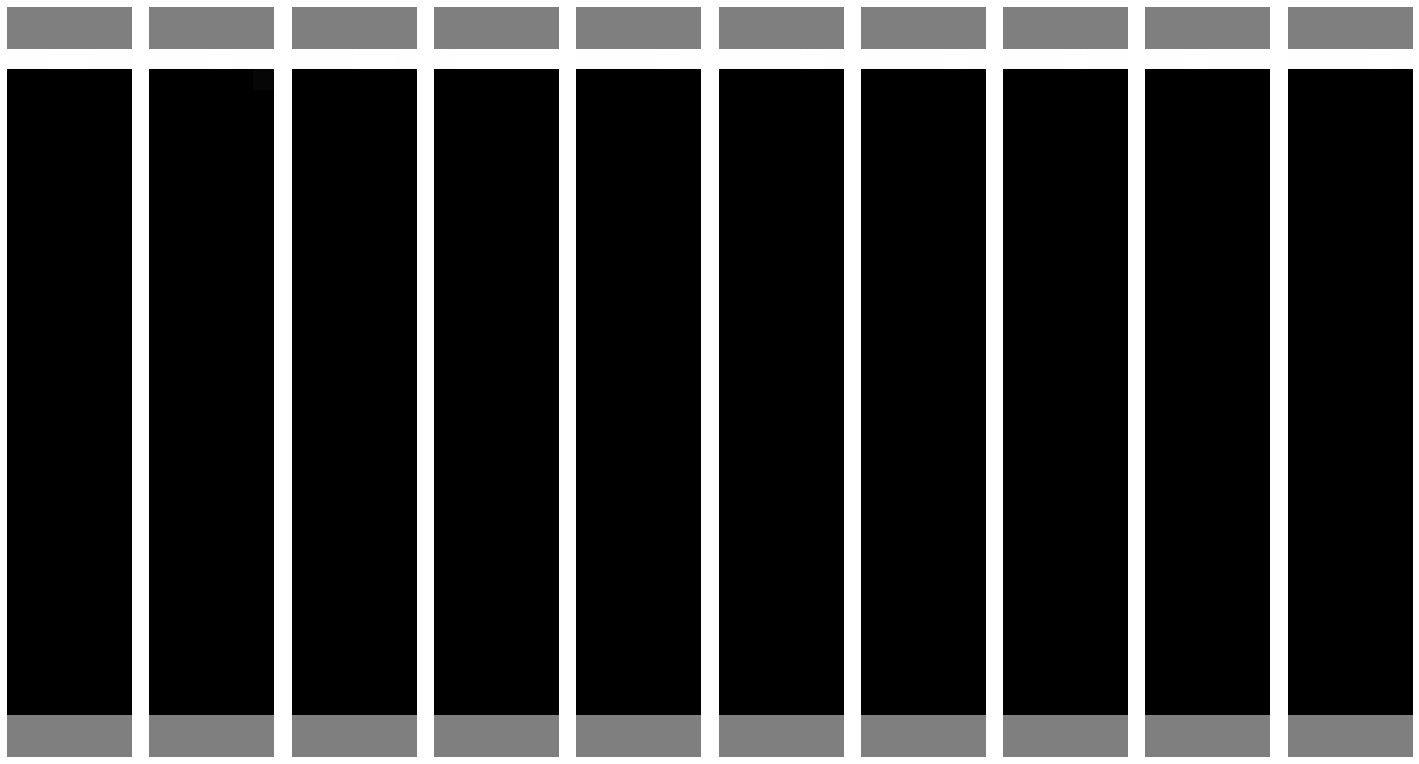

Epoch 108/200
8/8 - 1s - loss: 5.2521 - d_loss: 0.0048 - g_loss: 5.2473


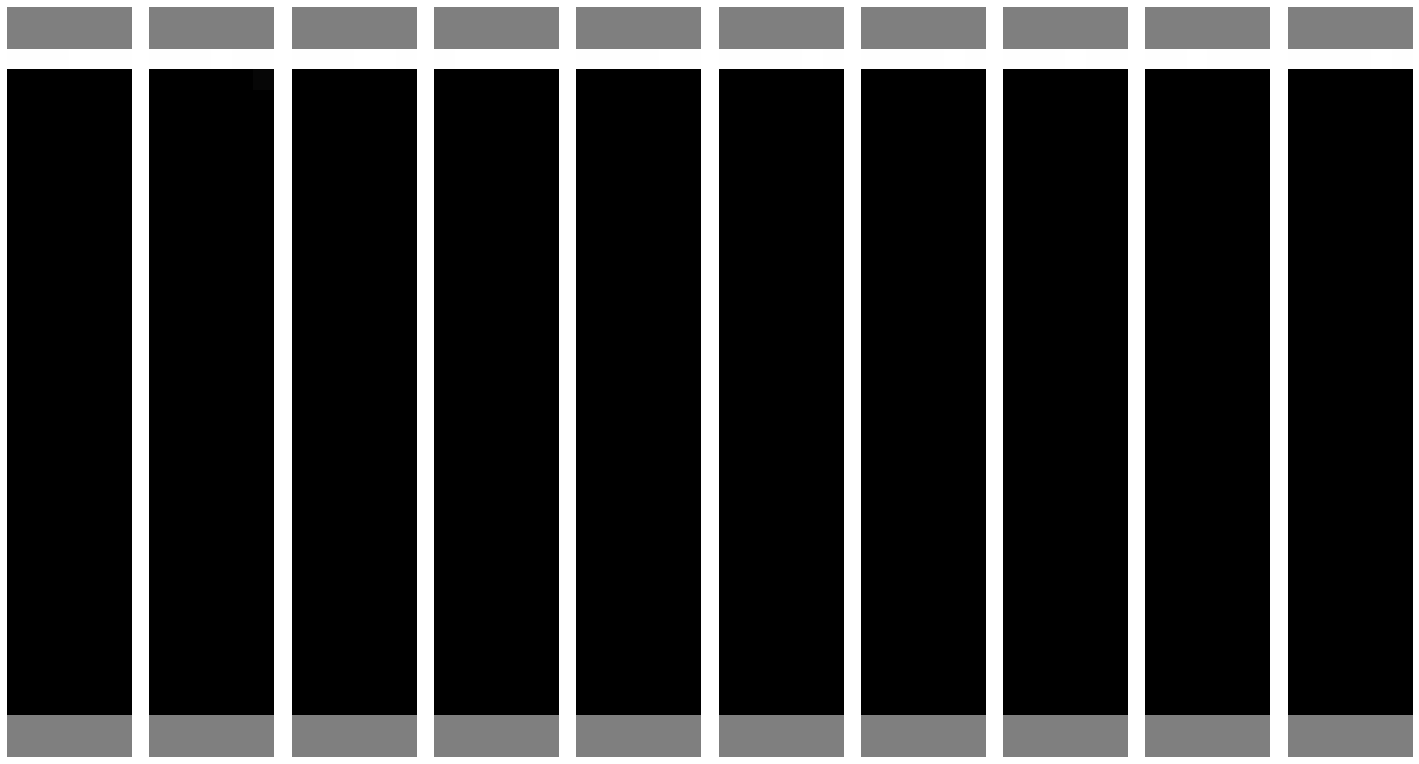

Epoch 109/200
8/8 - 1s - loss: 5.2868 - d_loss: 0.0046 - g_loss: 5.2822


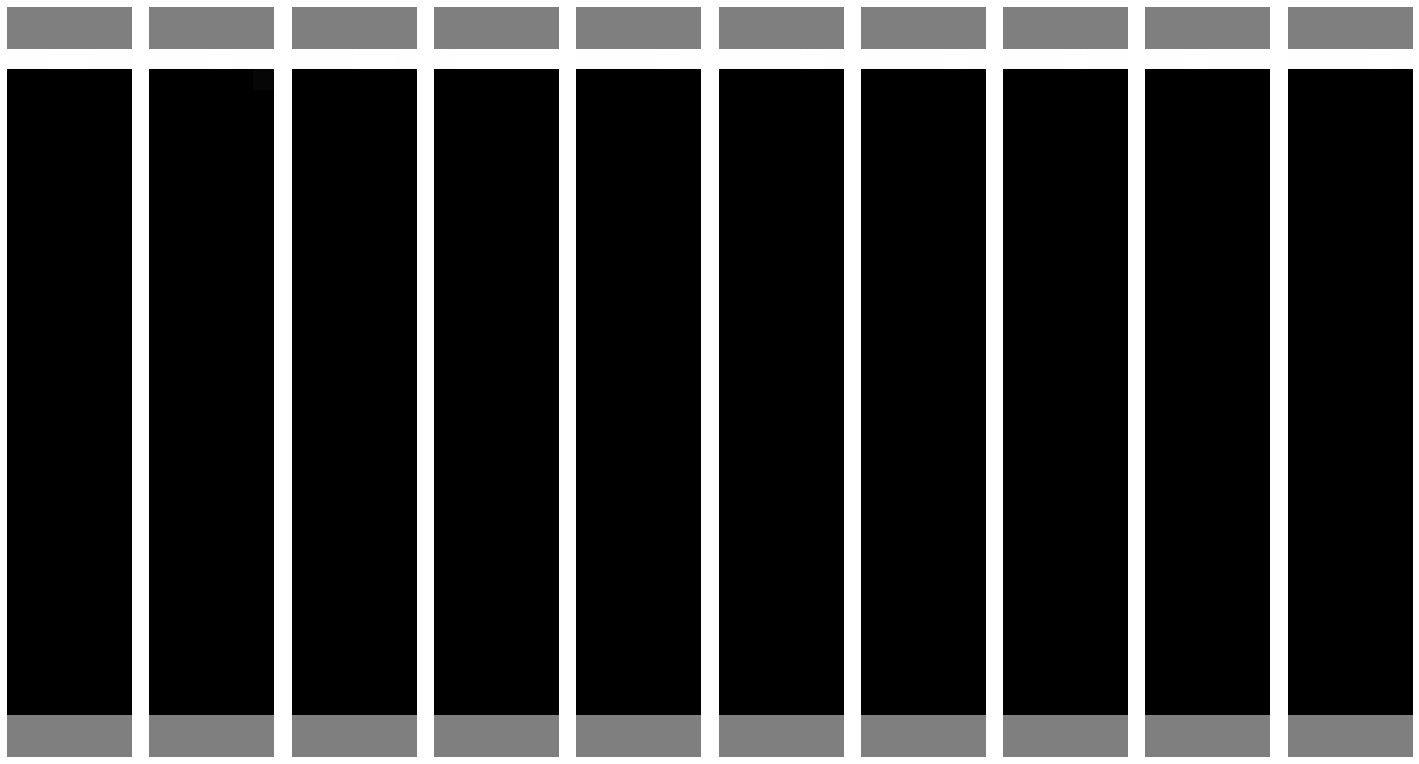

Epoch 110/200
8/8 - 1s - loss: 5.3154 - d_loss: 0.0045 - g_loss: 5.3109


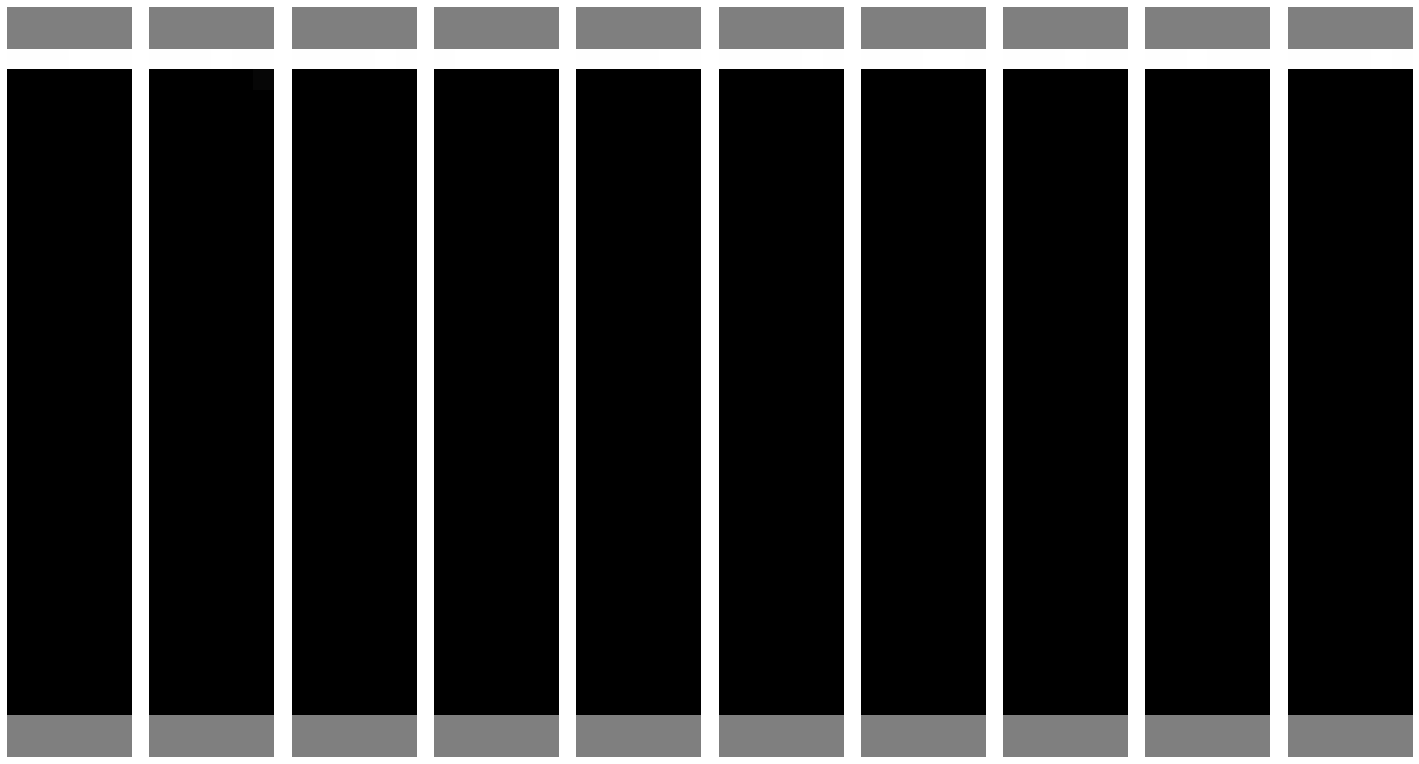

Epoch 111/200
8/8 - 1s - loss: 5.3416 - d_loss: 0.0044 - g_loss: 5.3372


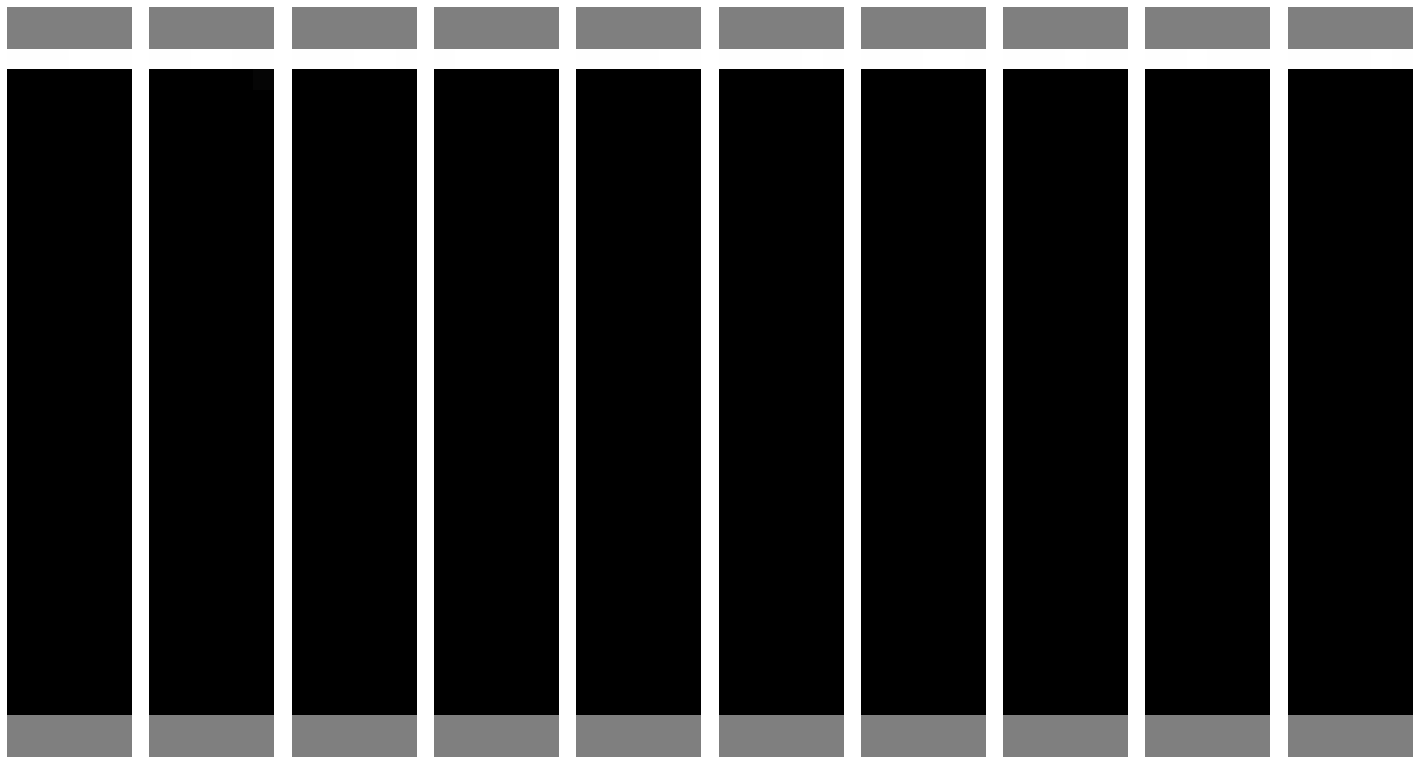

Epoch 112/200
8/8 - 1s - loss: 5.3707 - d_loss: 0.0042 - g_loss: 5.3664


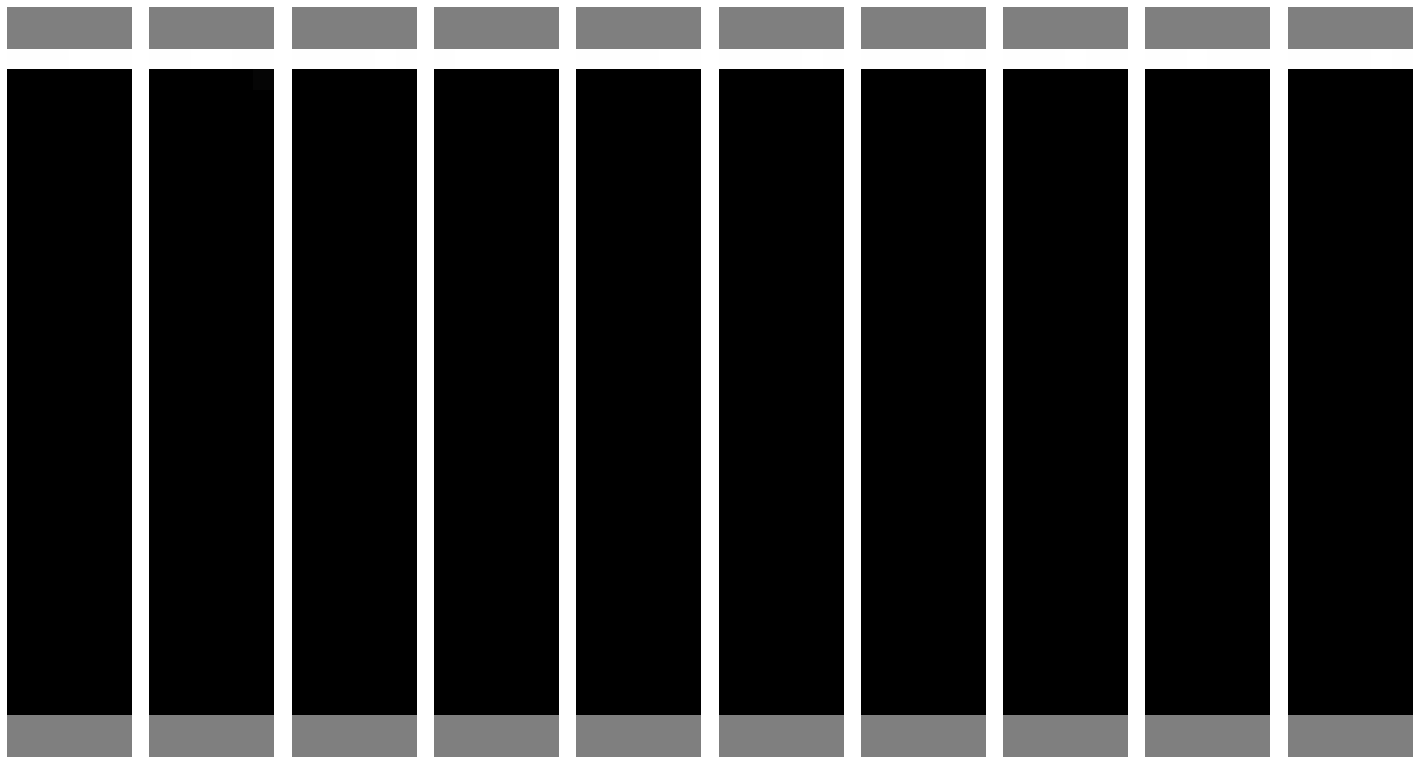

Epoch 113/200
8/8 - 1s - loss: 5.3982 - d_loss: 0.0041 - g_loss: 5.3941


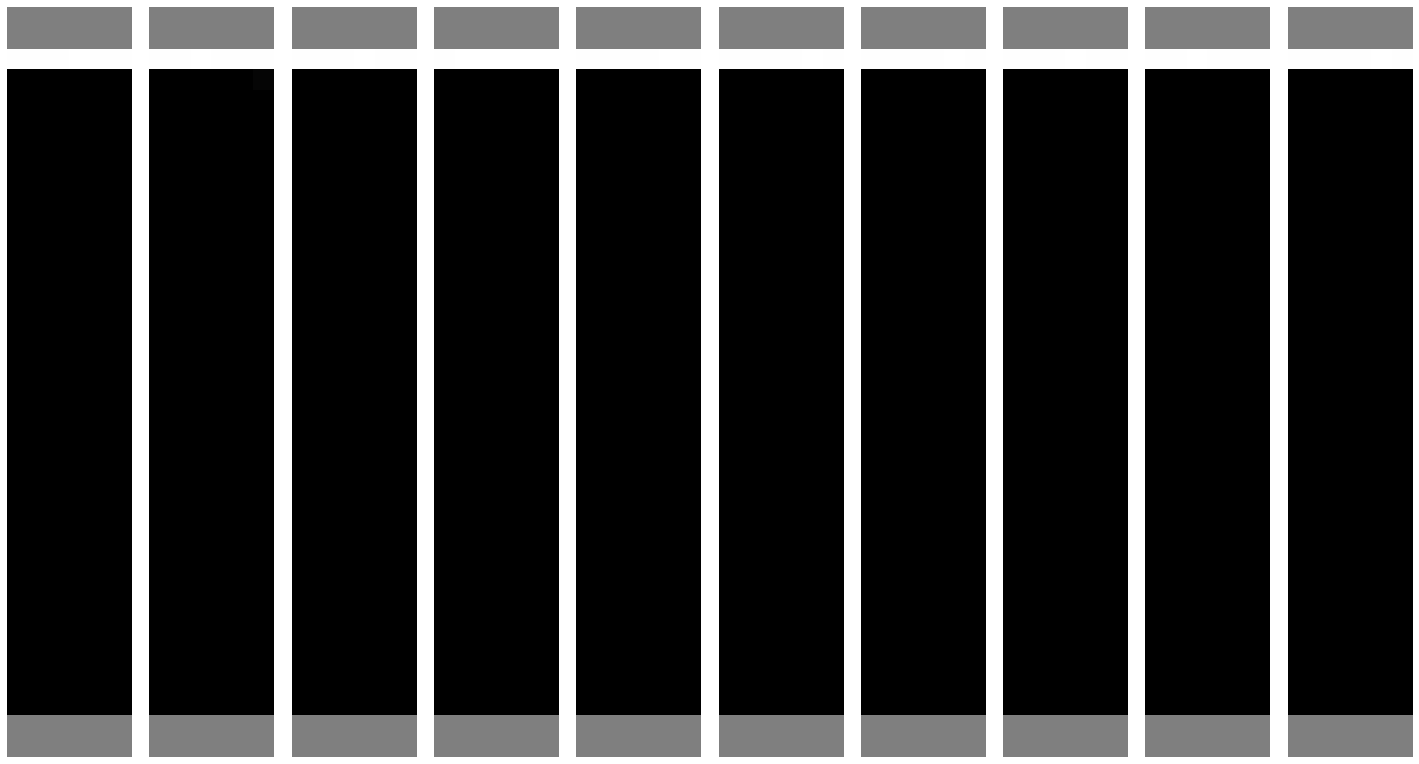

Epoch 114/200
8/8 - 1s - loss: 5.4178 - d_loss: 0.0040 - g_loss: 5.4138


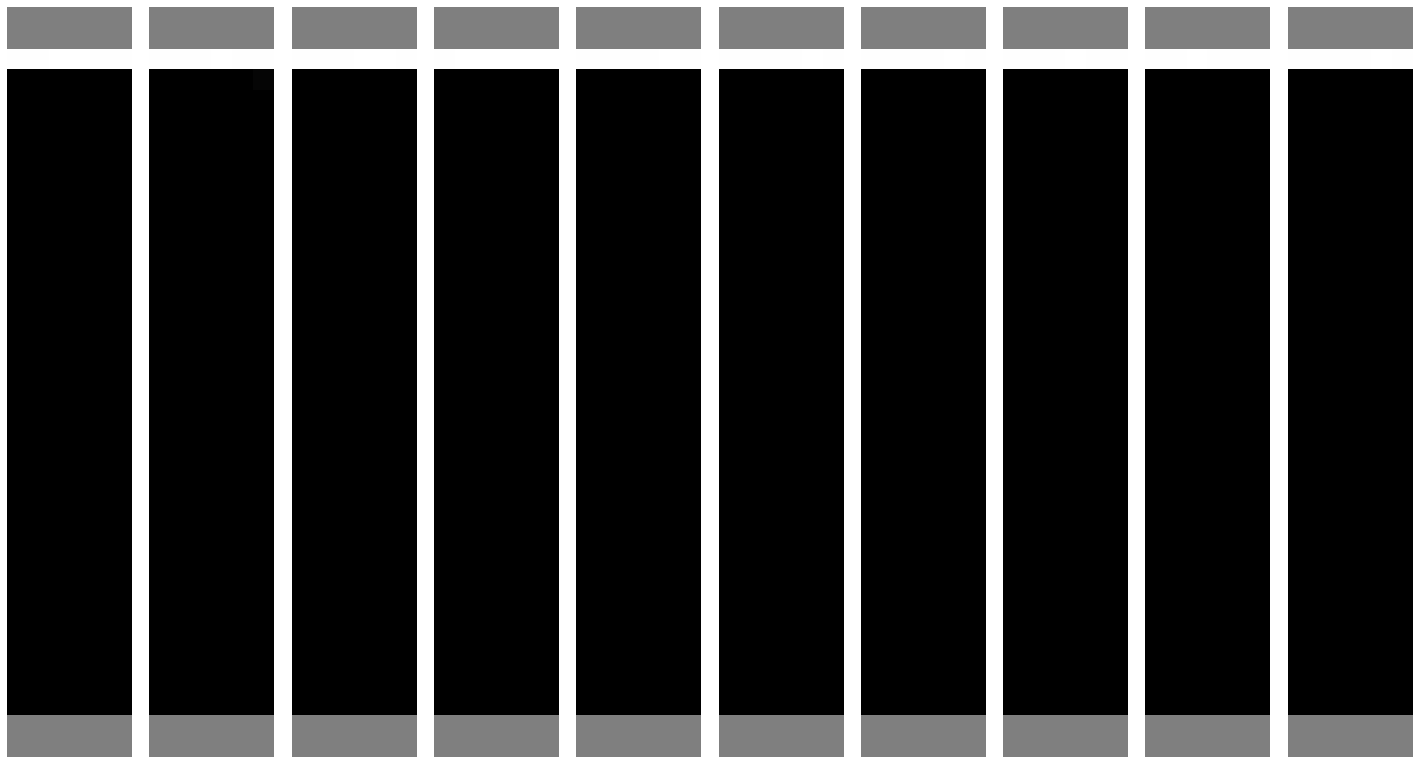

Epoch 115/200
8/8 - 1s - loss: 5.4484 - d_loss: 0.0039 - g_loss: 5.4445


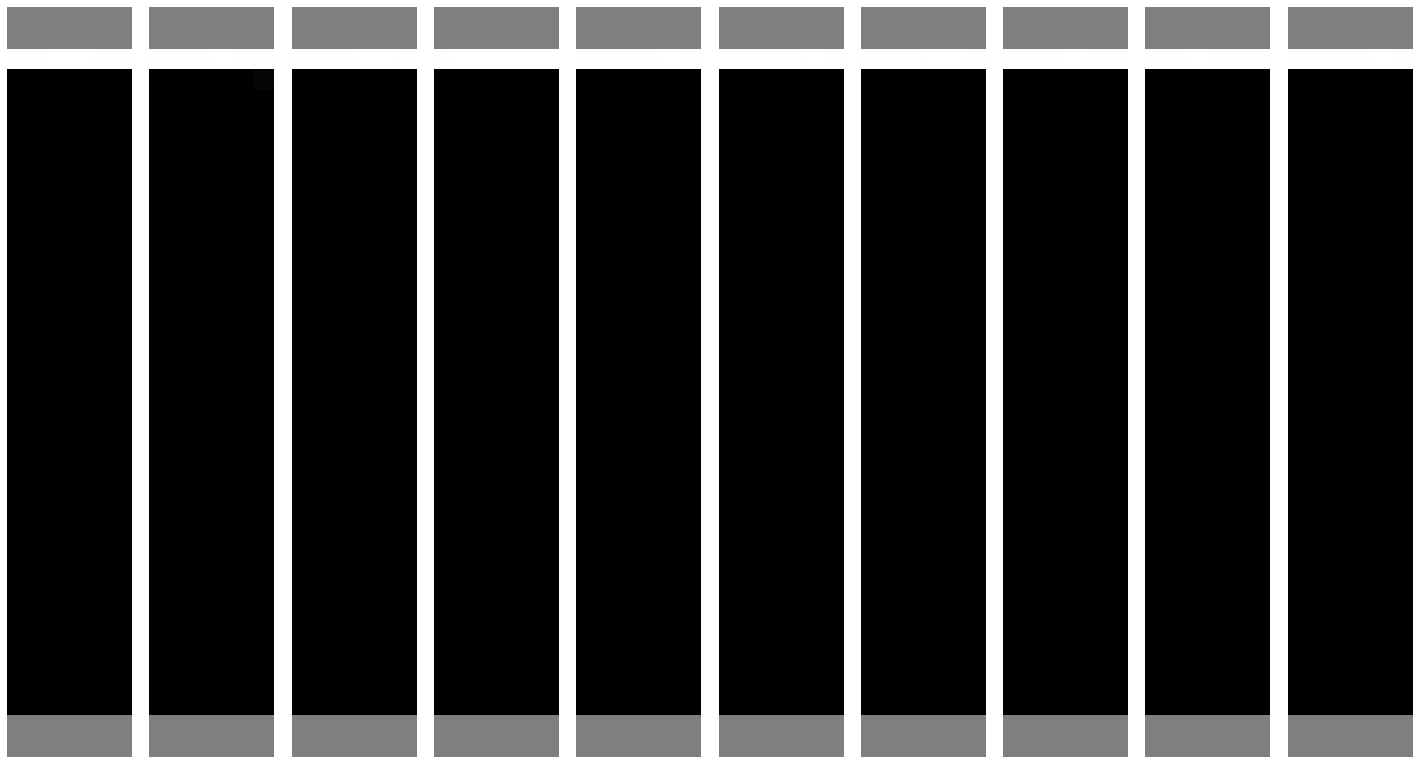

Epoch 116/200
8/8 - 1s - loss: 5.4802 - d_loss: 0.0038 - g_loss: 5.4764


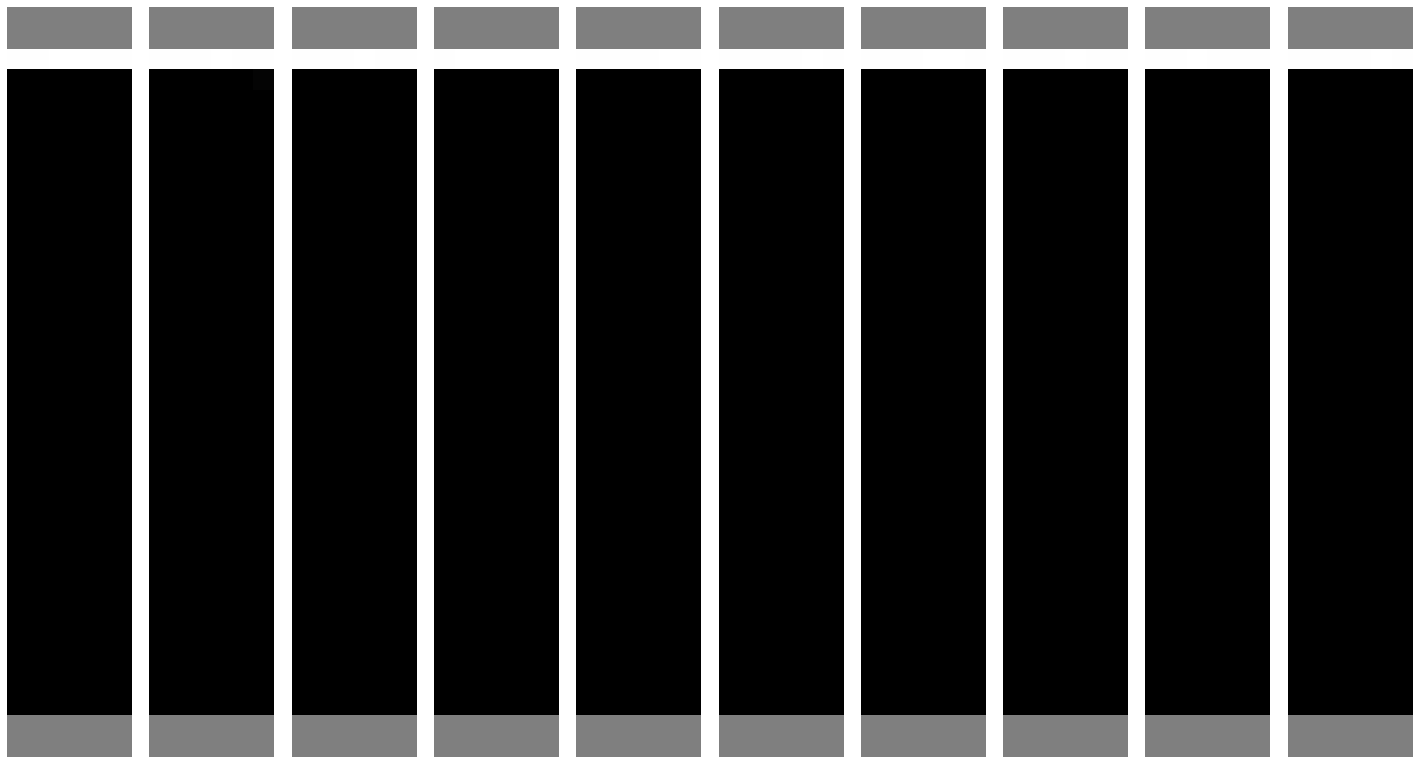

Epoch 117/200
8/8 - 1s - loss: 5.5094 - d_loss: 0.0037 - g_loss: 5.5057


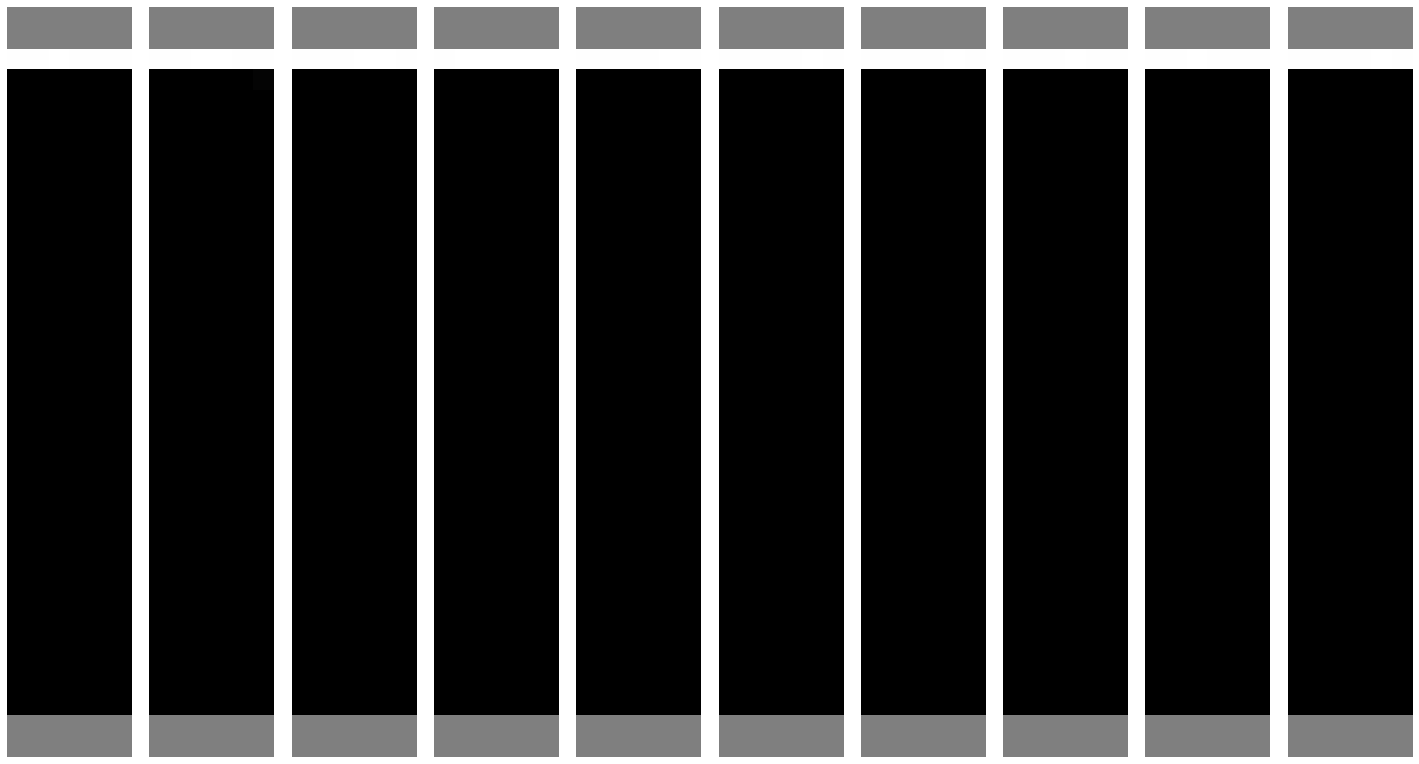

Epoch 118/200
8/8 - 1s - loss: 5.5420 - d_loss: 0.0036 - g_loss: 5.5384


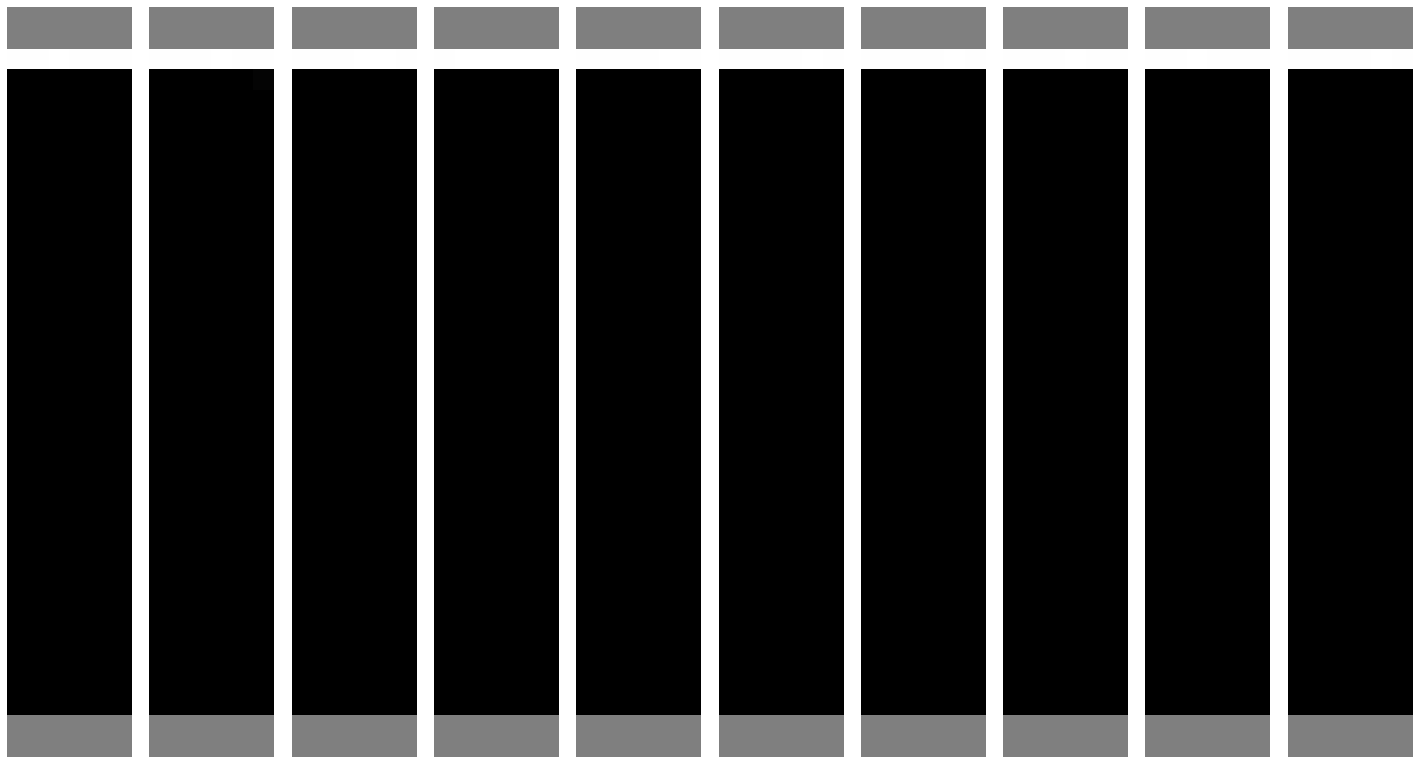

Epoch 119/200
8/8 - 1s - loss: 5.5672 - d_loss: 0.0036 - g_loss: 5.5636


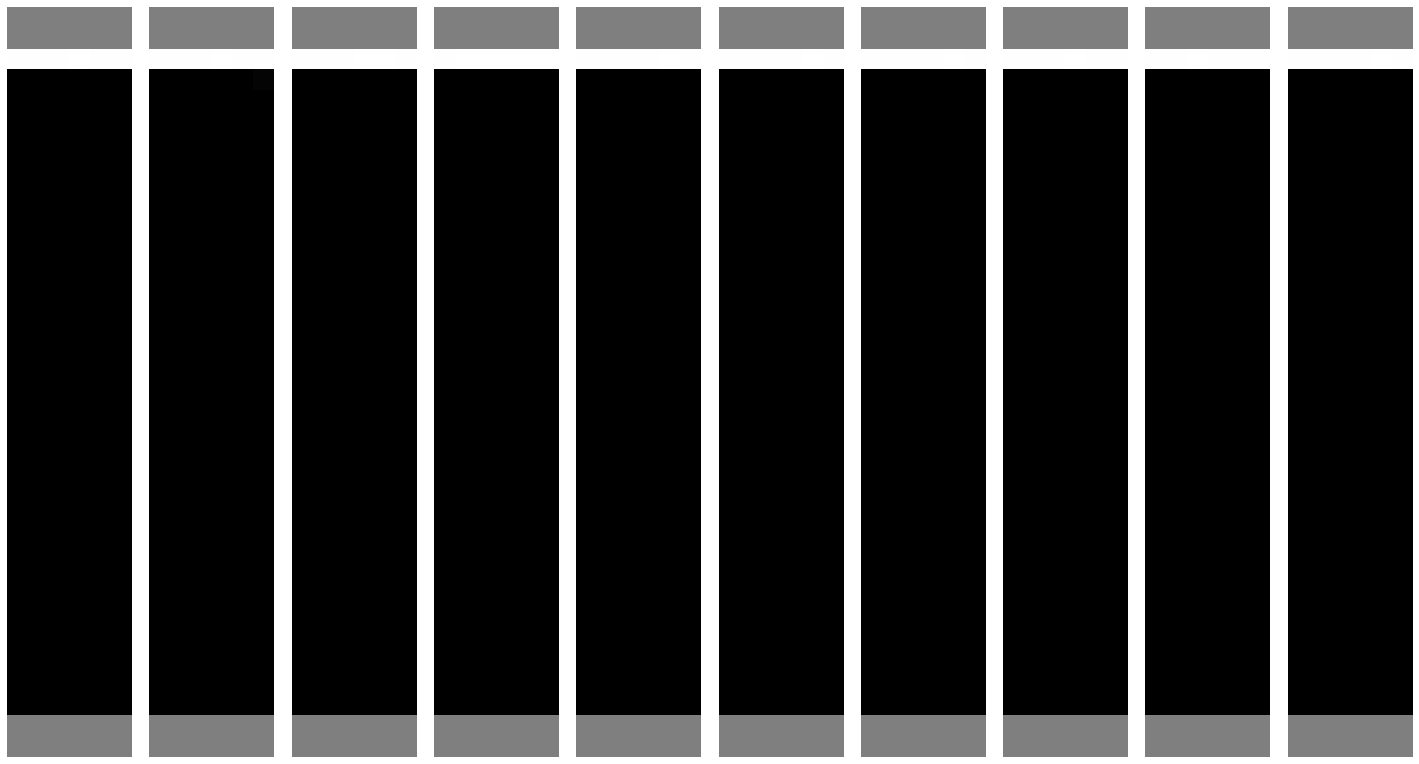

Epoch 120/200
8/8 - 1s - loss: 5.5860 - d_loss: 0.0034 - g_loss: 5.5826


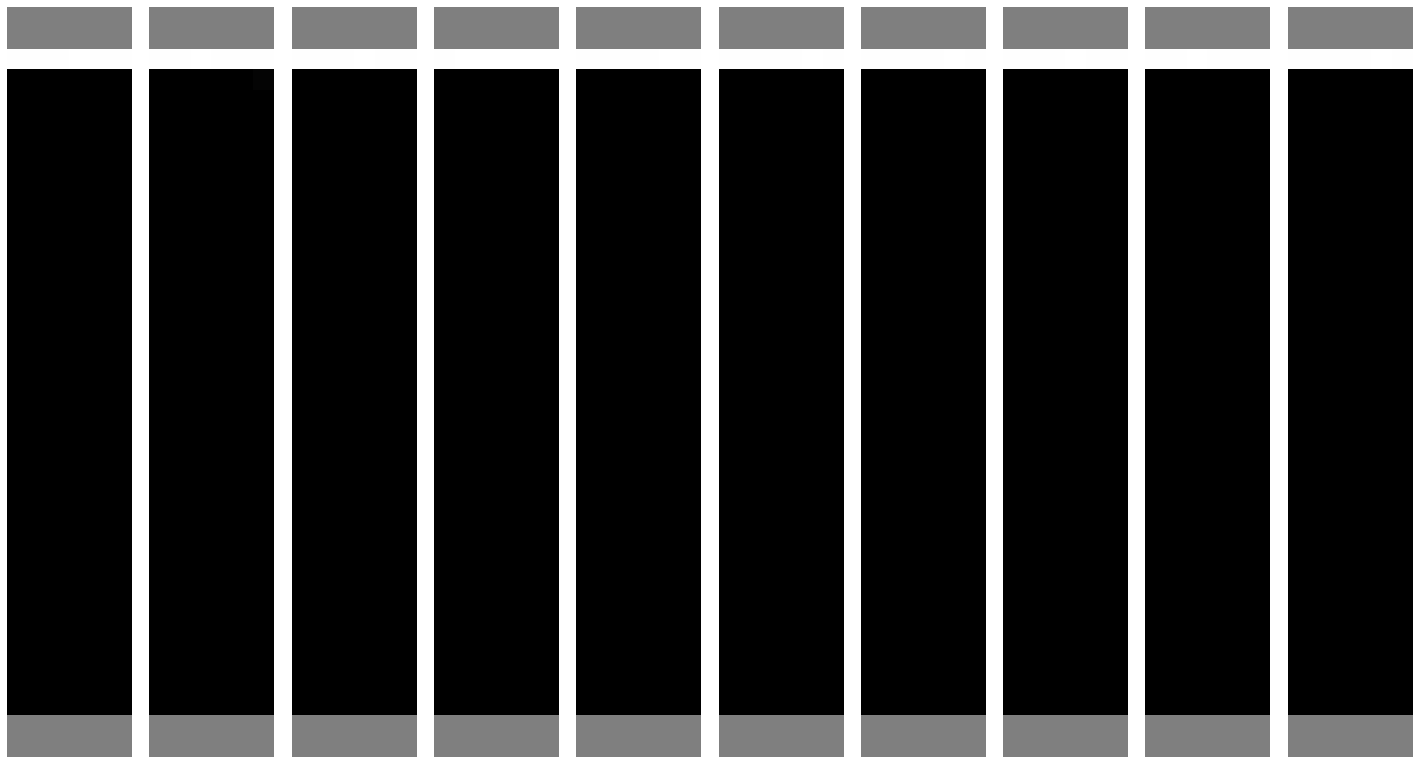

Epoch 121/200
8/8 - 1s - loss: 5.6079 - d_loss: 0.0033 - g_loss: 5.6046


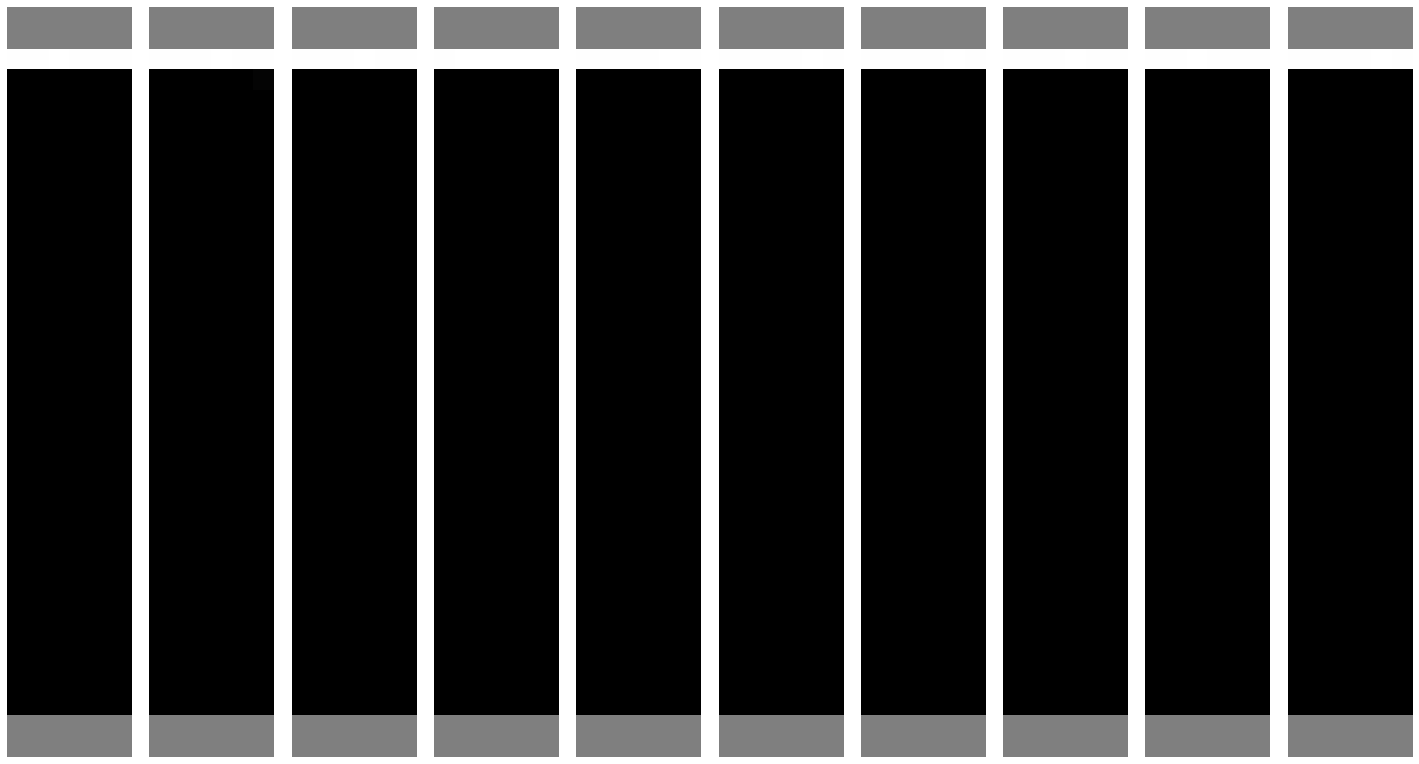

Epoch 122/200
8/8 - 1s - loss: 5.6323 - d_loss: 0.0032 - g_loss: 5.6291


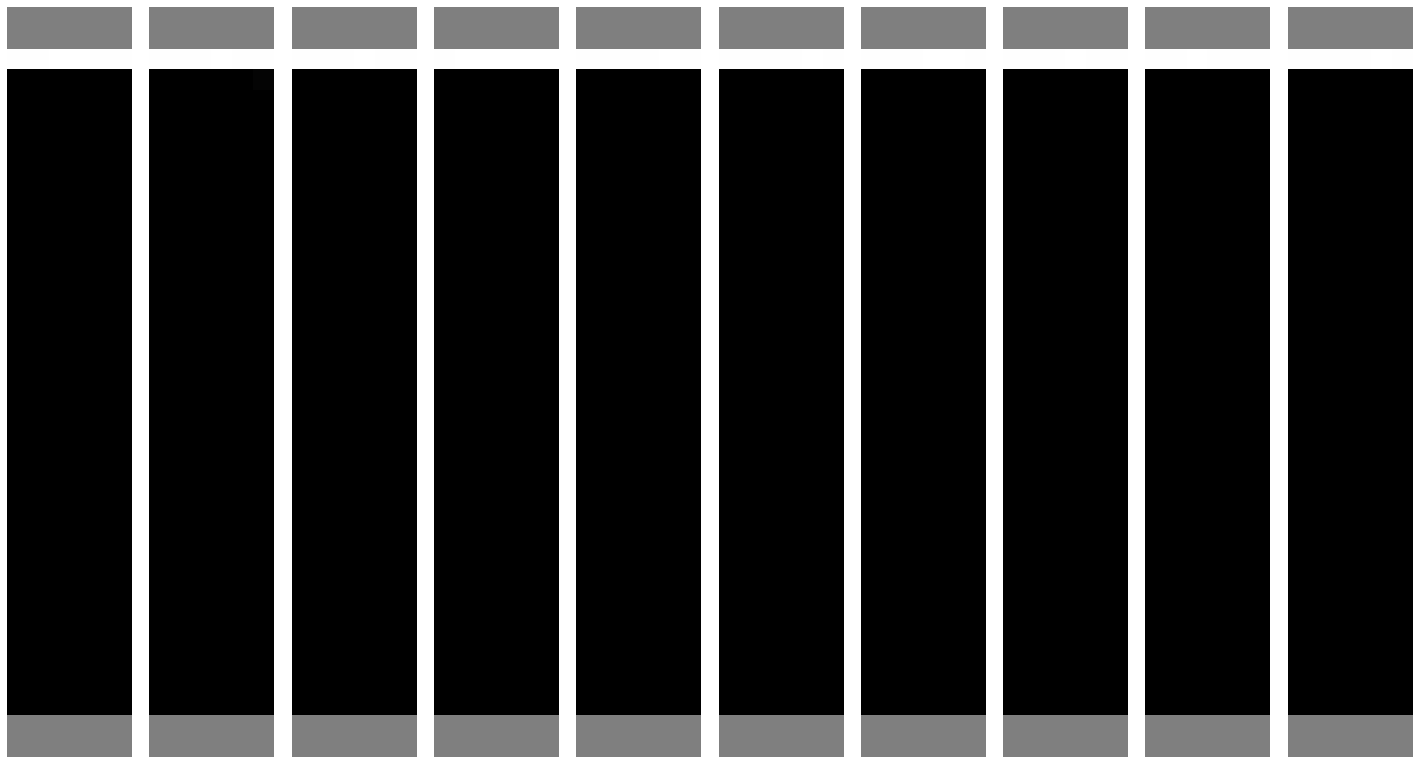

Epoch 123/200
8/8 - 1s - loss: 5.6607 - d_loss: 0.0031 - g_loss: 5.6576


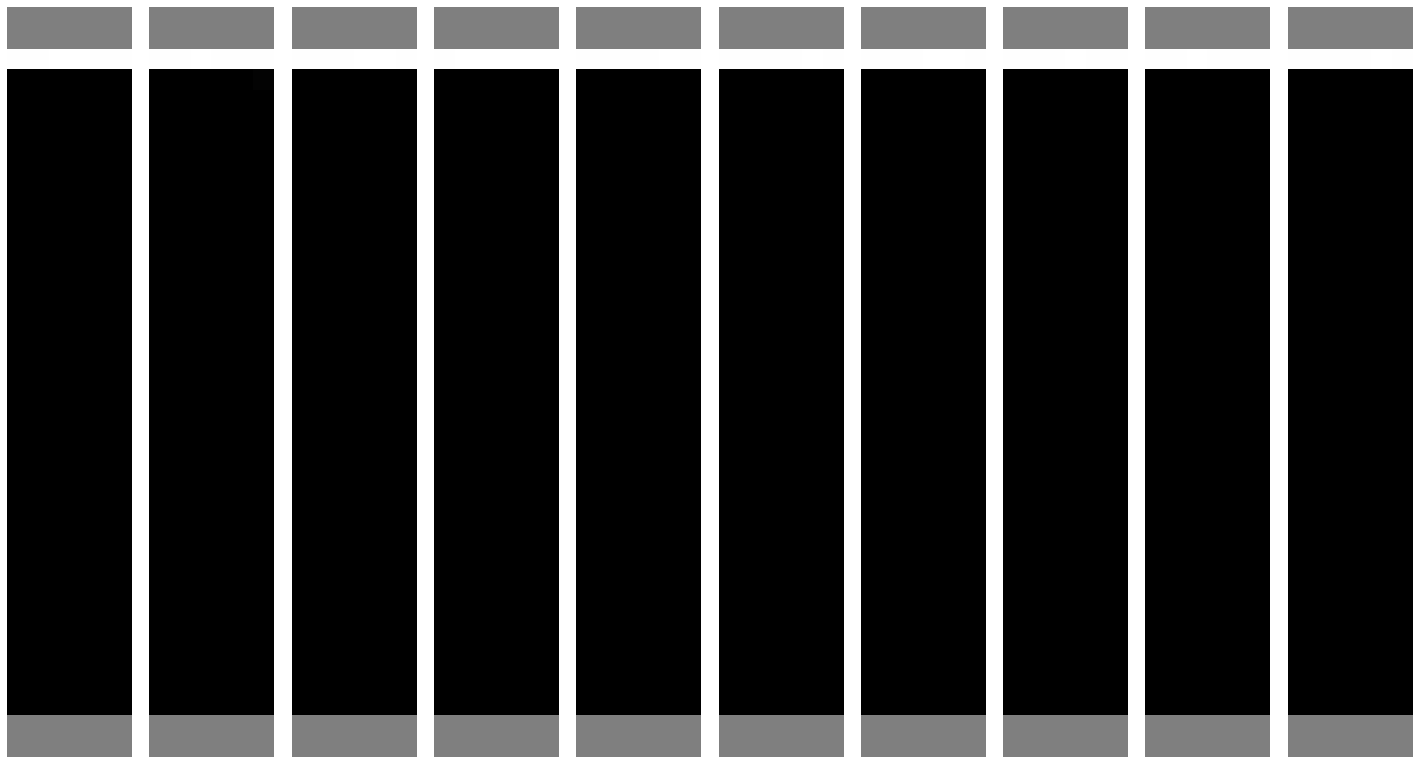

Epoch 124/200
8/8 - 1s - loss: 5.6883 - d_loss: 0.0031 - g_loss: 5.6852


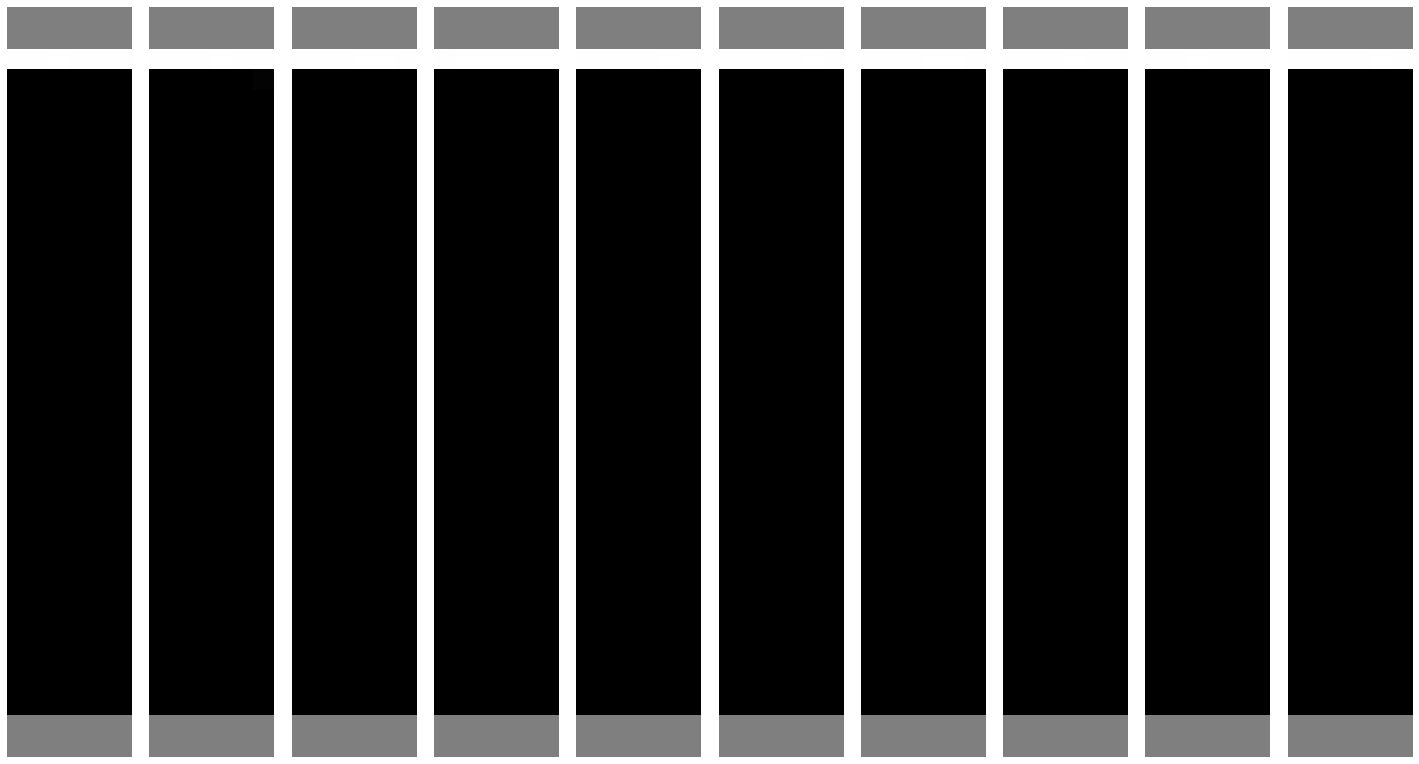

Epoch 125/200
8/8 - 1s - loss: 5.7143 - d_loss: 0.0030 - g_loss: 5.7114


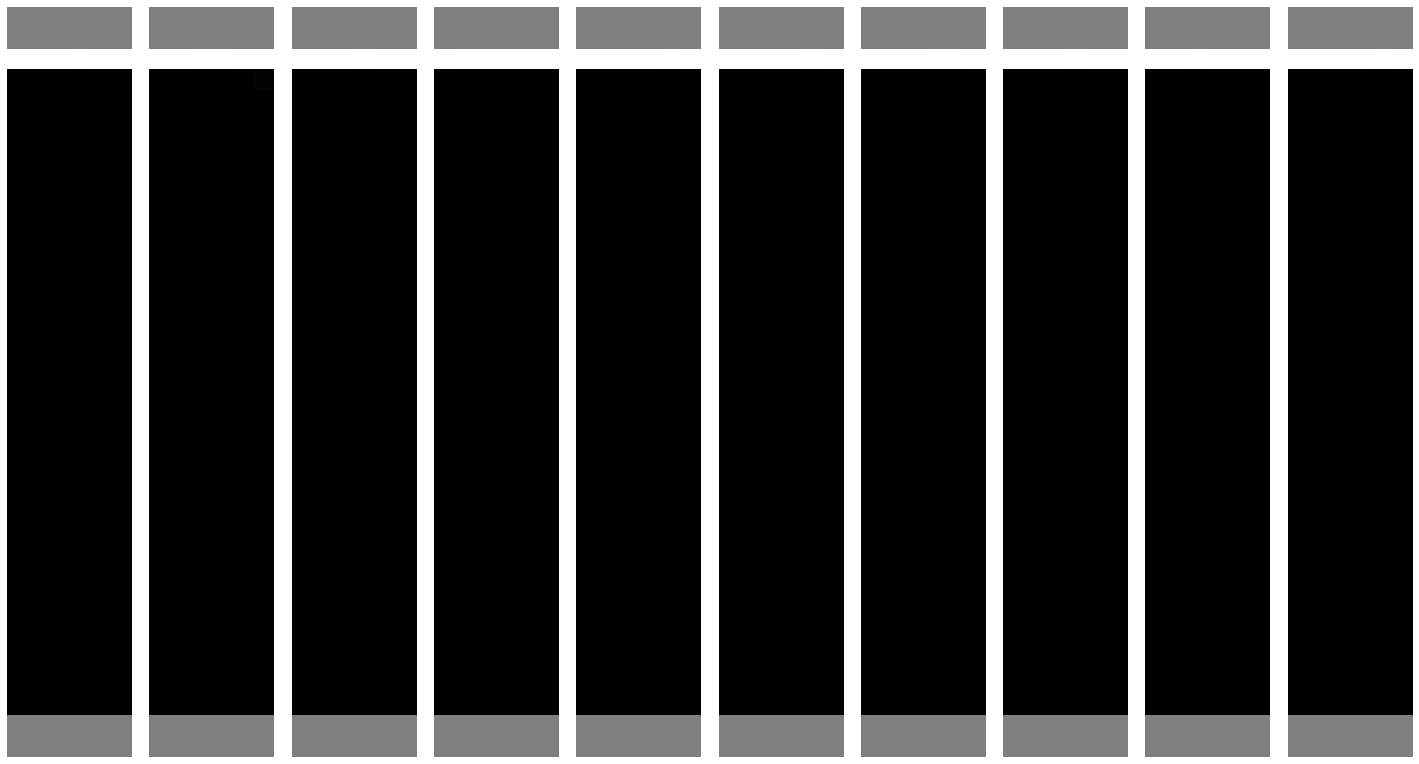

Epoch 126/200
8/8 - 1s - loss: 5.7464 - d_loss: 0.0029 - g_loss: 5.7435


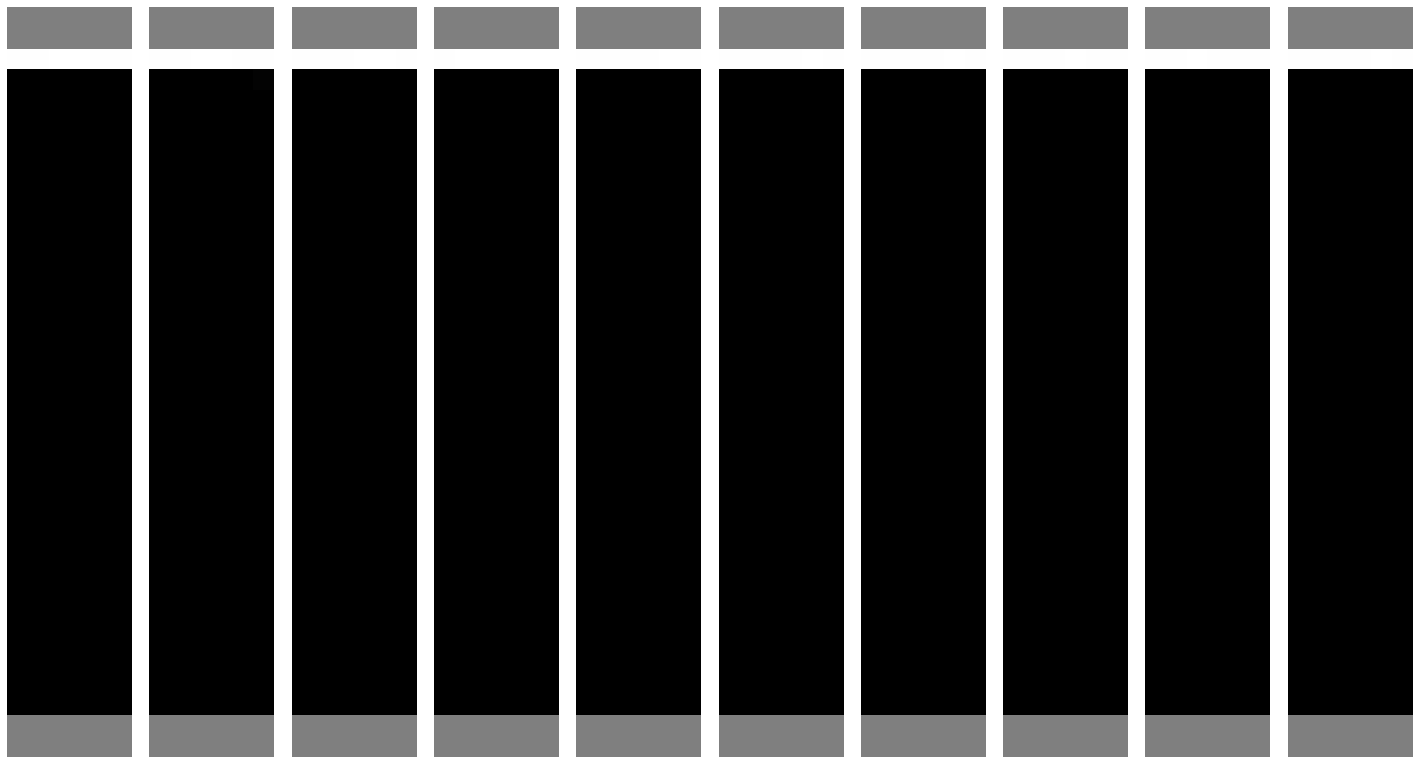

Epoch 127/200
8/8 - 1s - loss: 5.7722 - d_loss: 0.0028 - g_loss: 5.7694


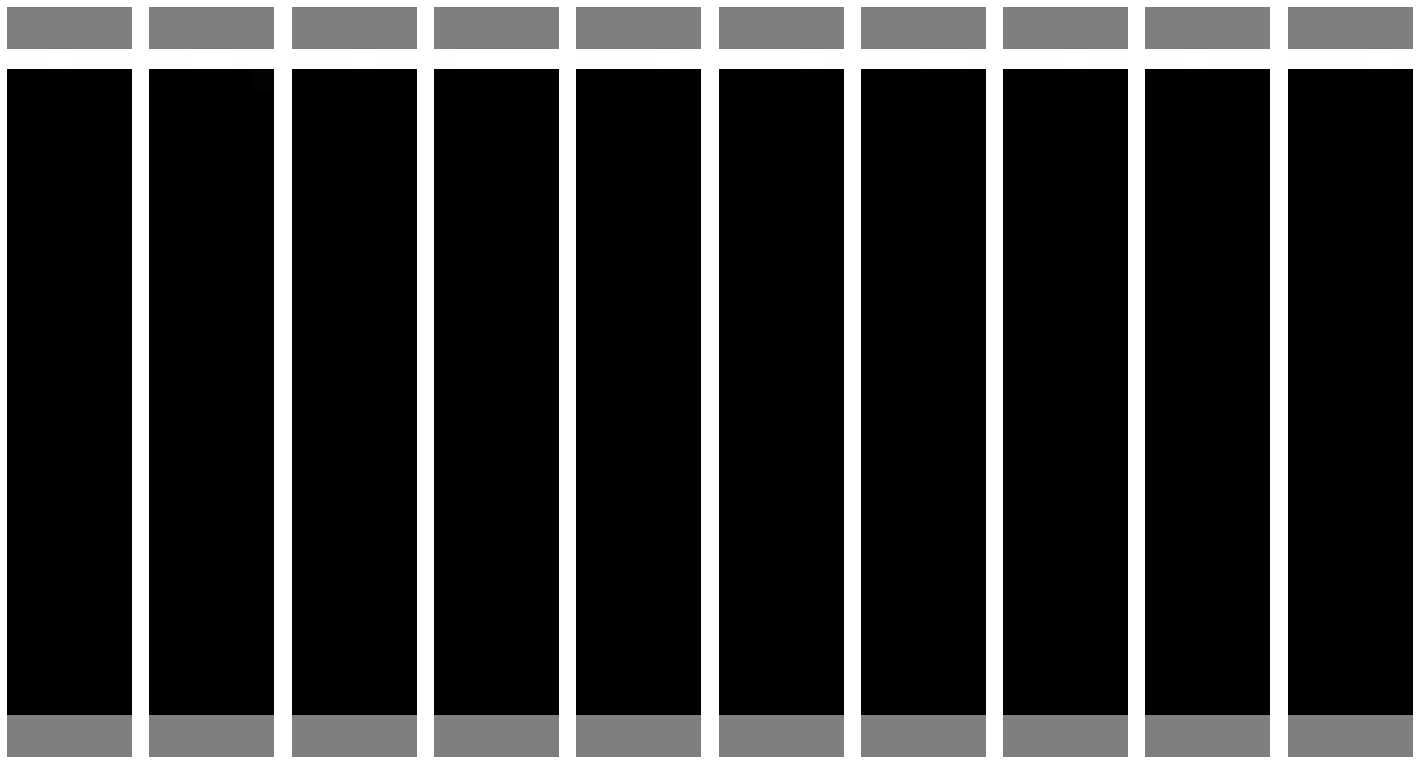

Epoch 128/200
8/8 - 1s - loss: 5.7943 - d_loss: 0.0027 - g_loss: 5.7915


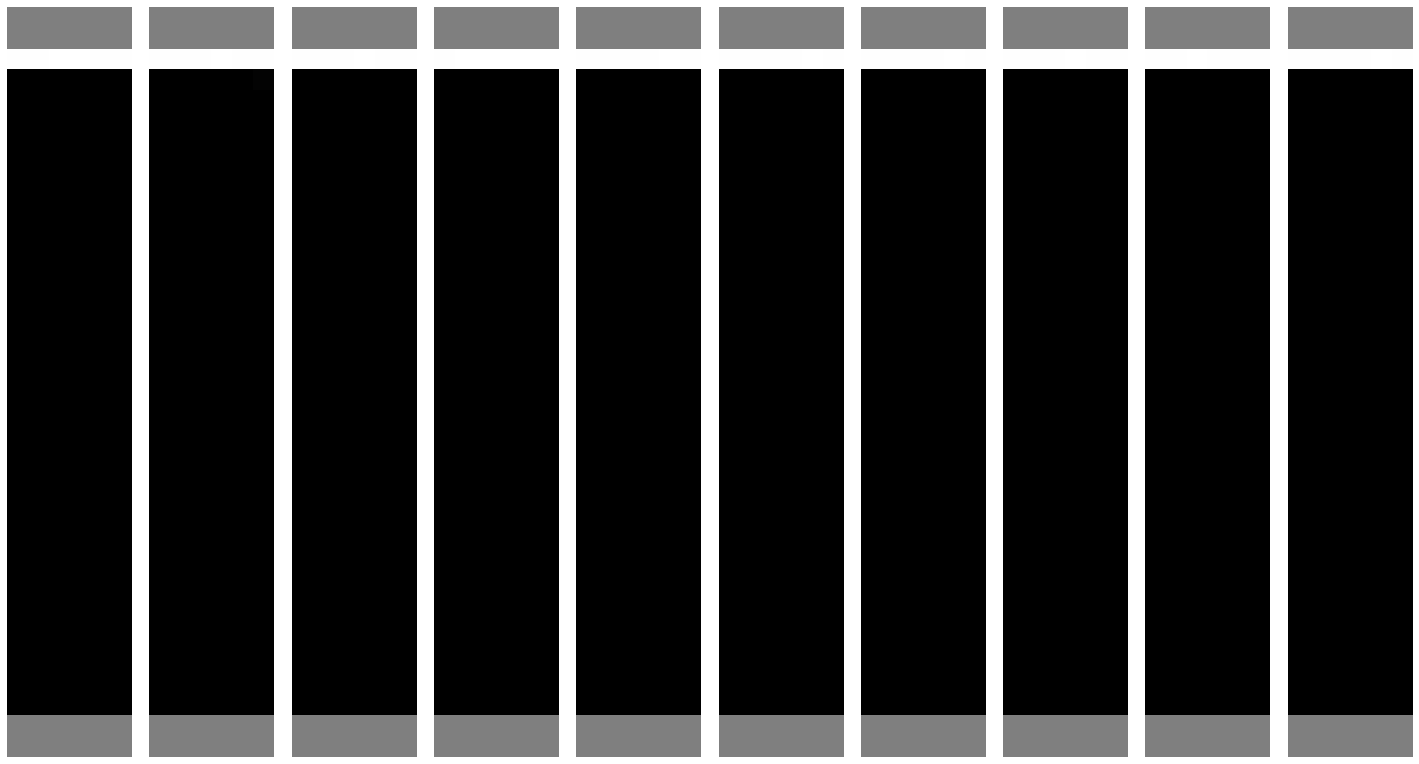

Epoch 129/200
8/8 - 1s - loss: 5.8159 - d_loss: 0.0027 - g_loss: 5.8132


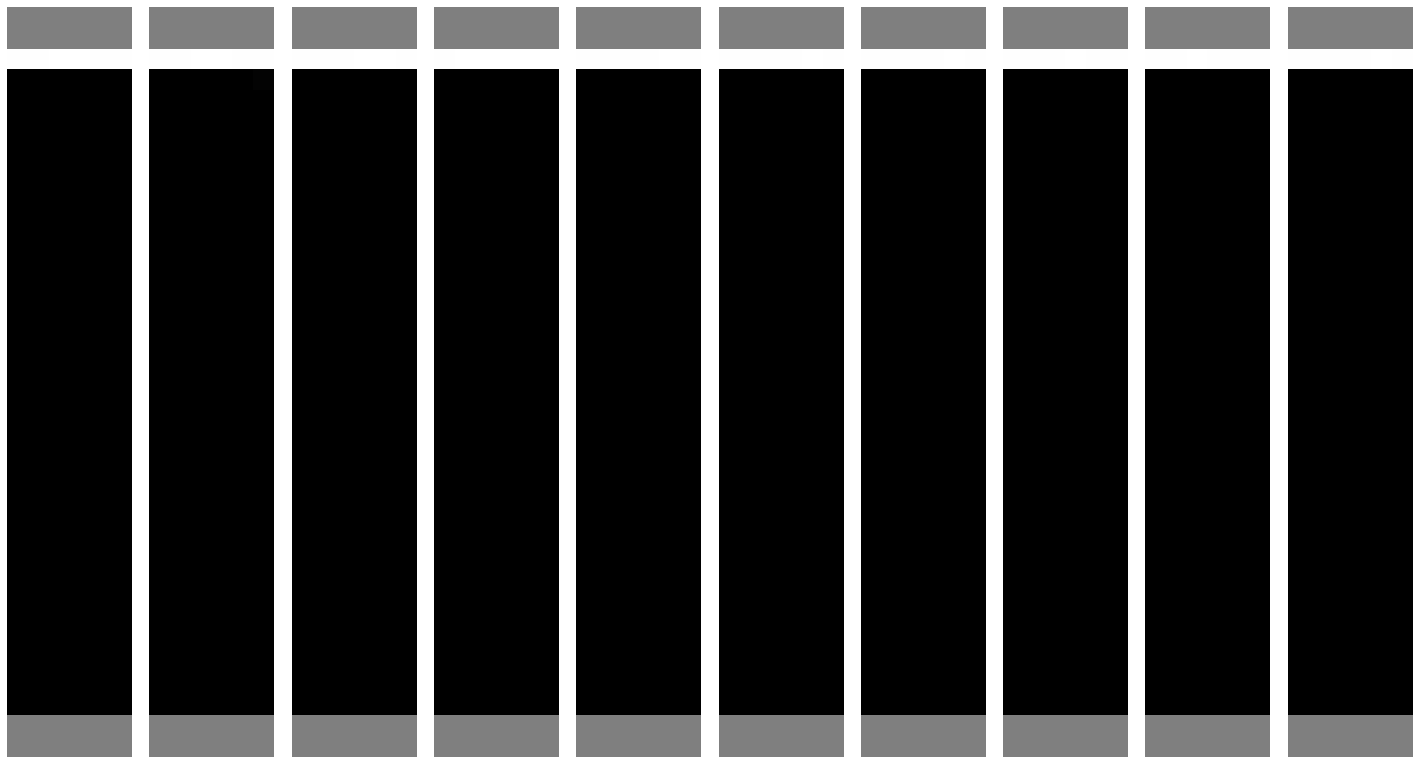

Epoch 130/200
8/8 - 1s - loss: 5.8386 - d_loss: 0.0027 - g_loss: 5.8359


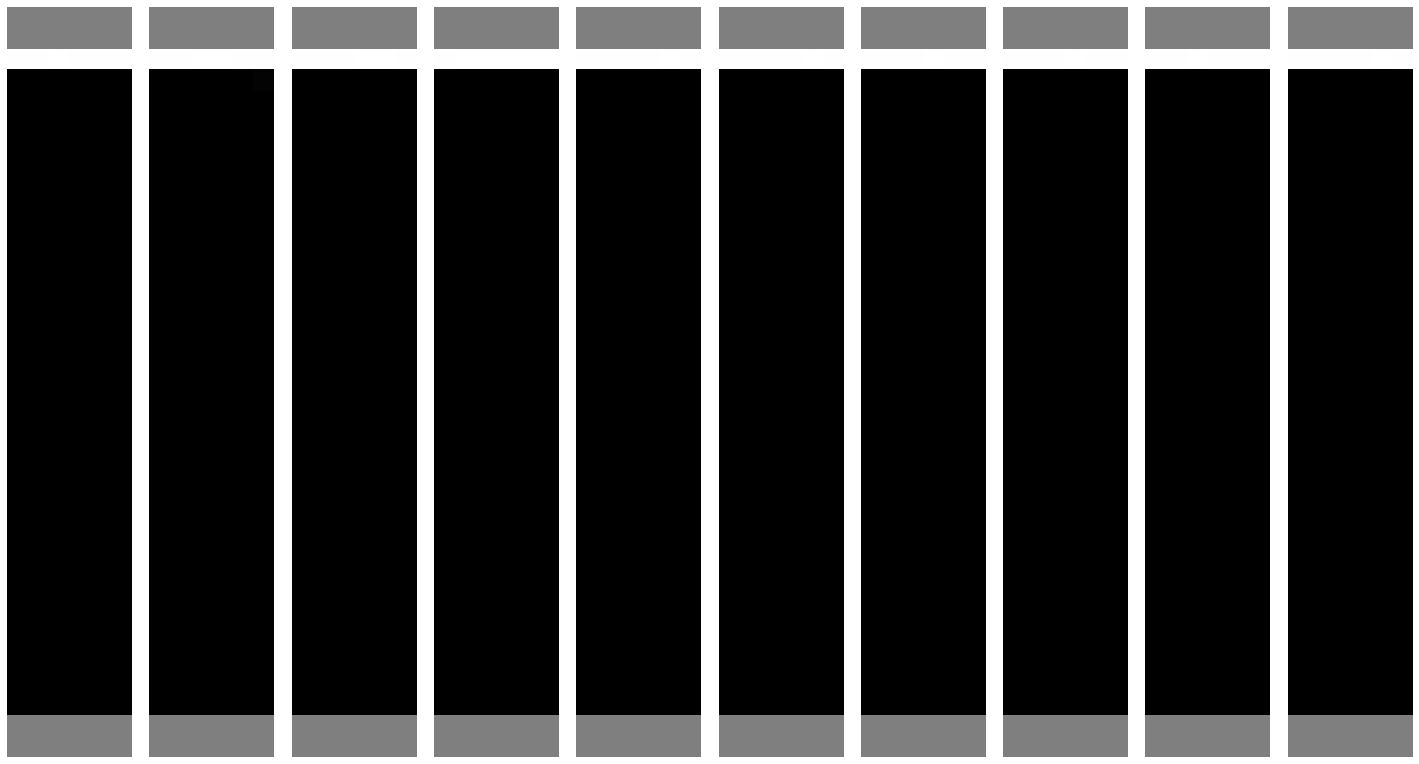

Epoch 131/200
8/8 - 1s - loss: 5.8643 - d_loss: 0.0026 - g_loss: 5.8616


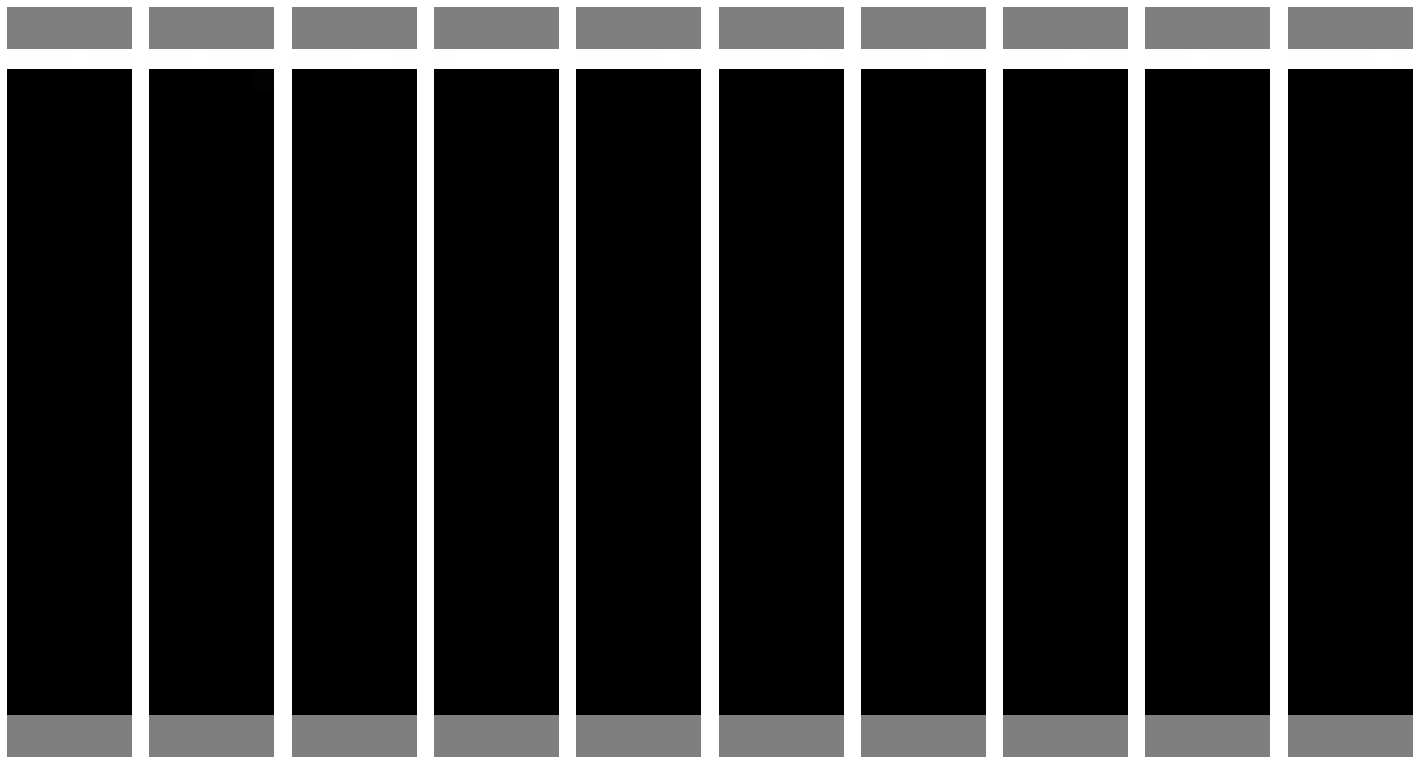

Epoch 132/200
8/8 - 1s - loss: 5.8890 - d_loss: 0.0026 - g_loss: 5.8865


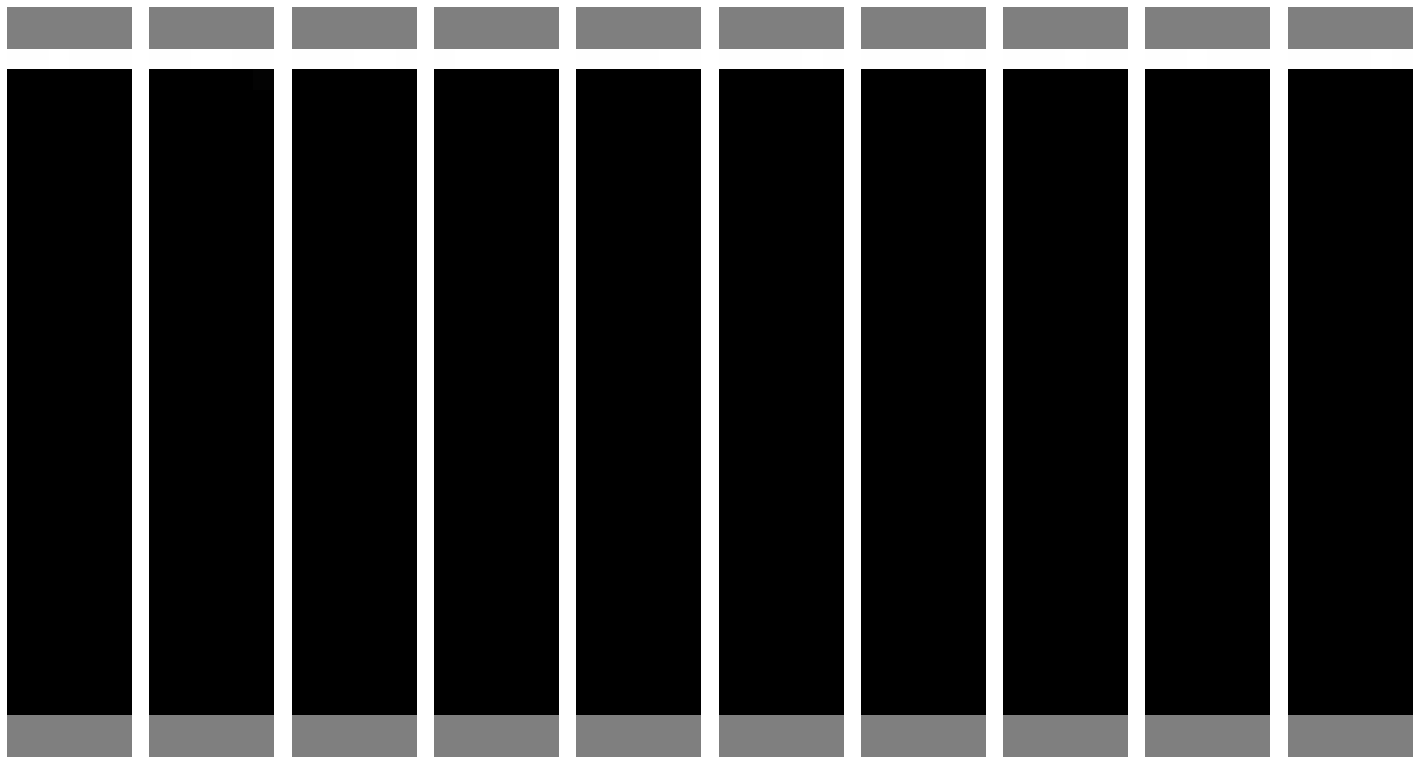

Epoch 133/200
8/8 - 1s - loss: 5.9099 - d_loss: 0.0025 - g_loss: 5.9074


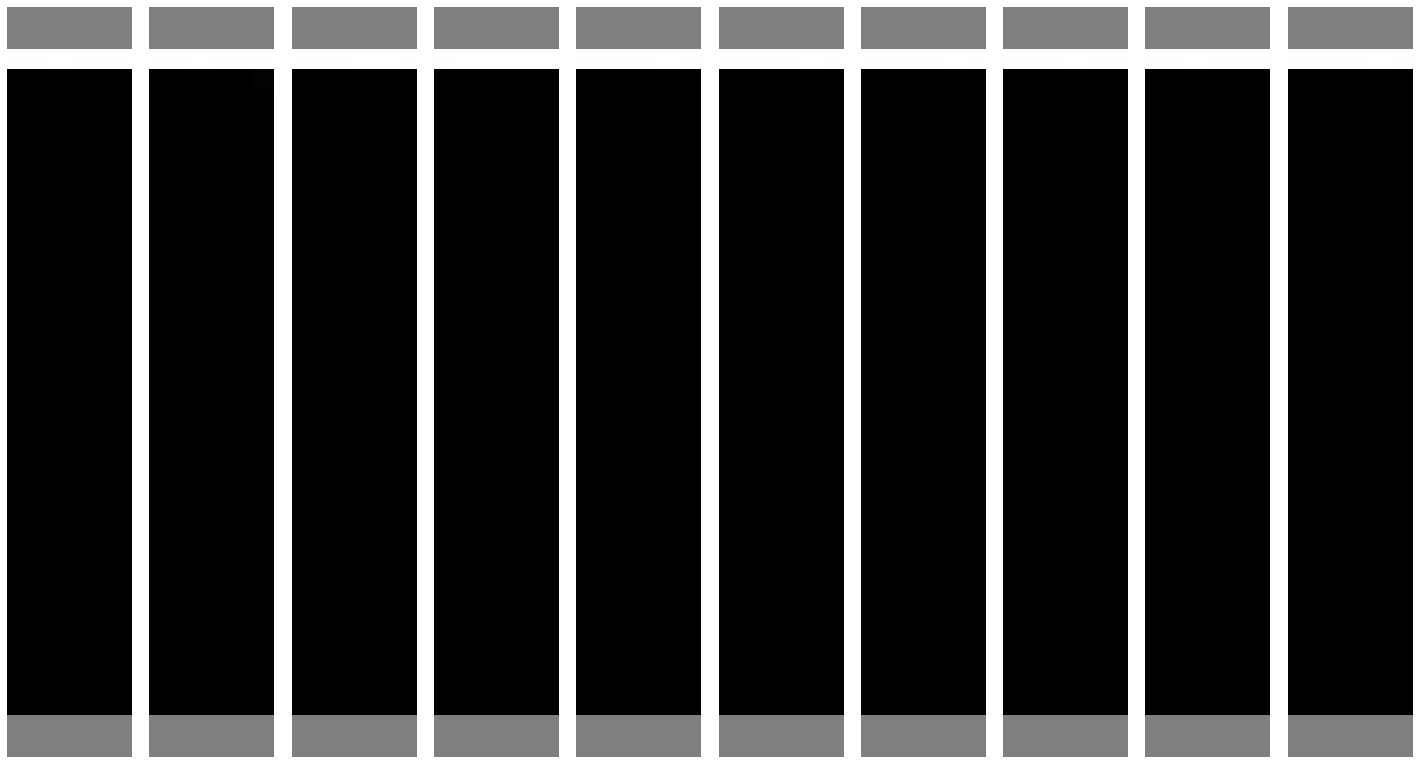

Epoch 134/200
8/8 - 1s - loss: 5.9277 - d_loss: 0.0024 - g_loss: 5.9253


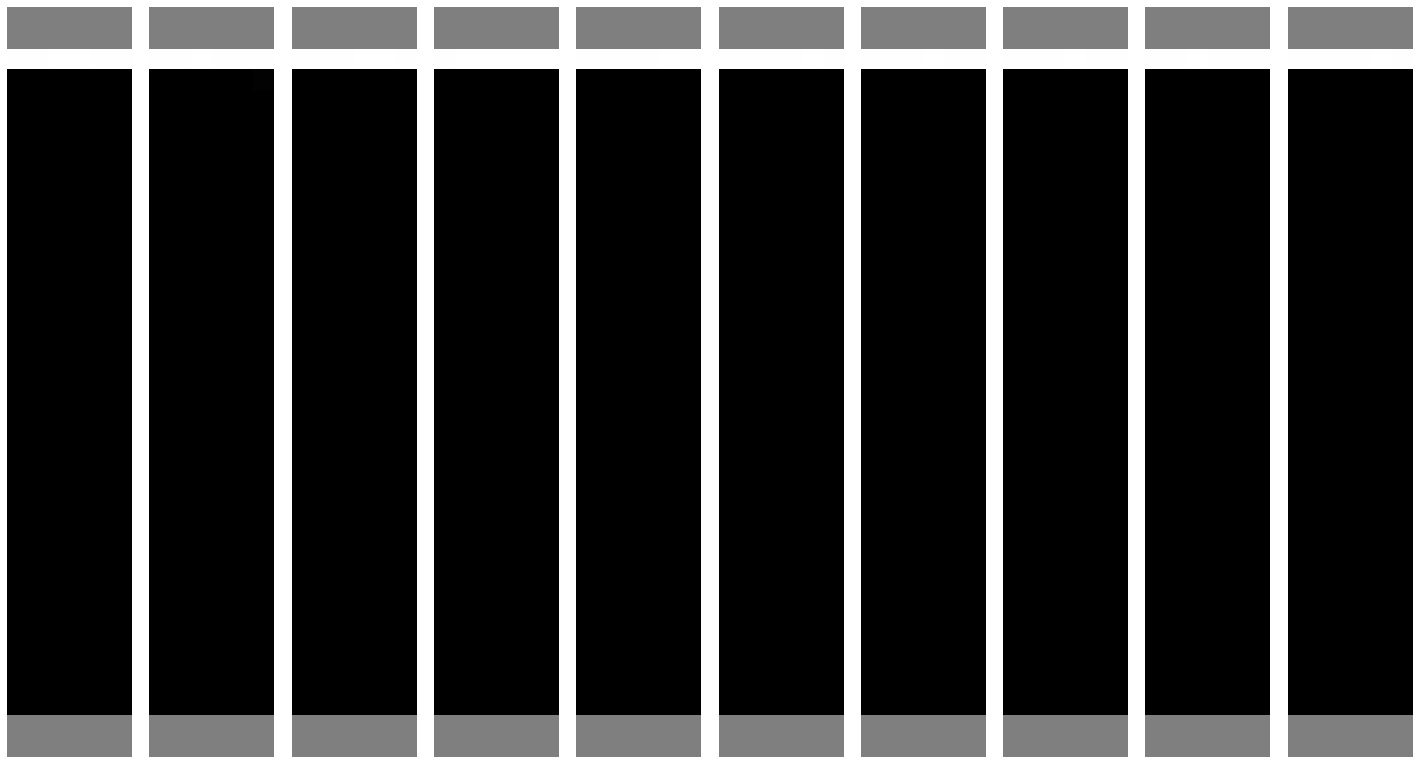

Epoch 135/200
8/8 - 1s - loss: 5.9447 - d_loss: 0.0024 - g_loss: 5.9423


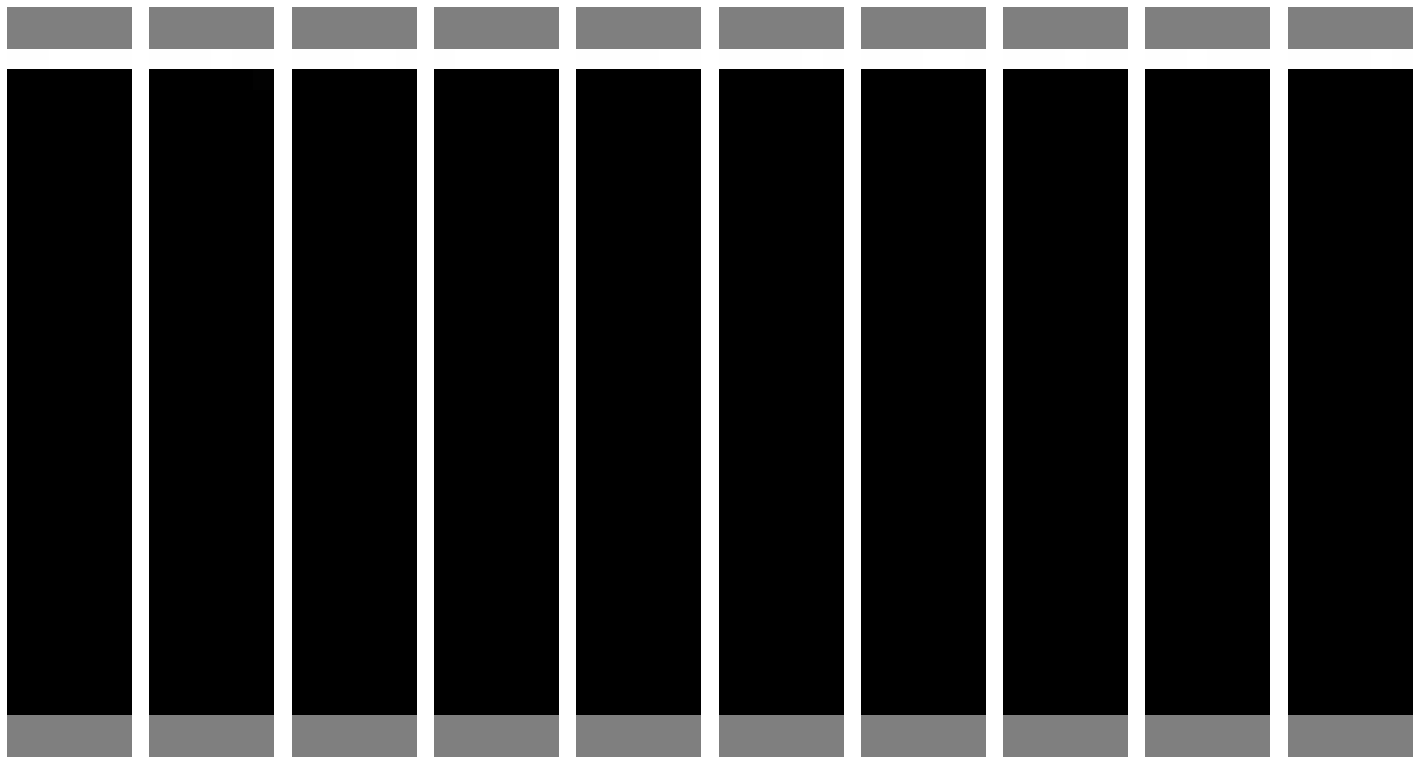

Epoch 136/200
8/8 - 1s - loss: 5.9680 - d_loss: 0.0023 - g_loss: 5.9657


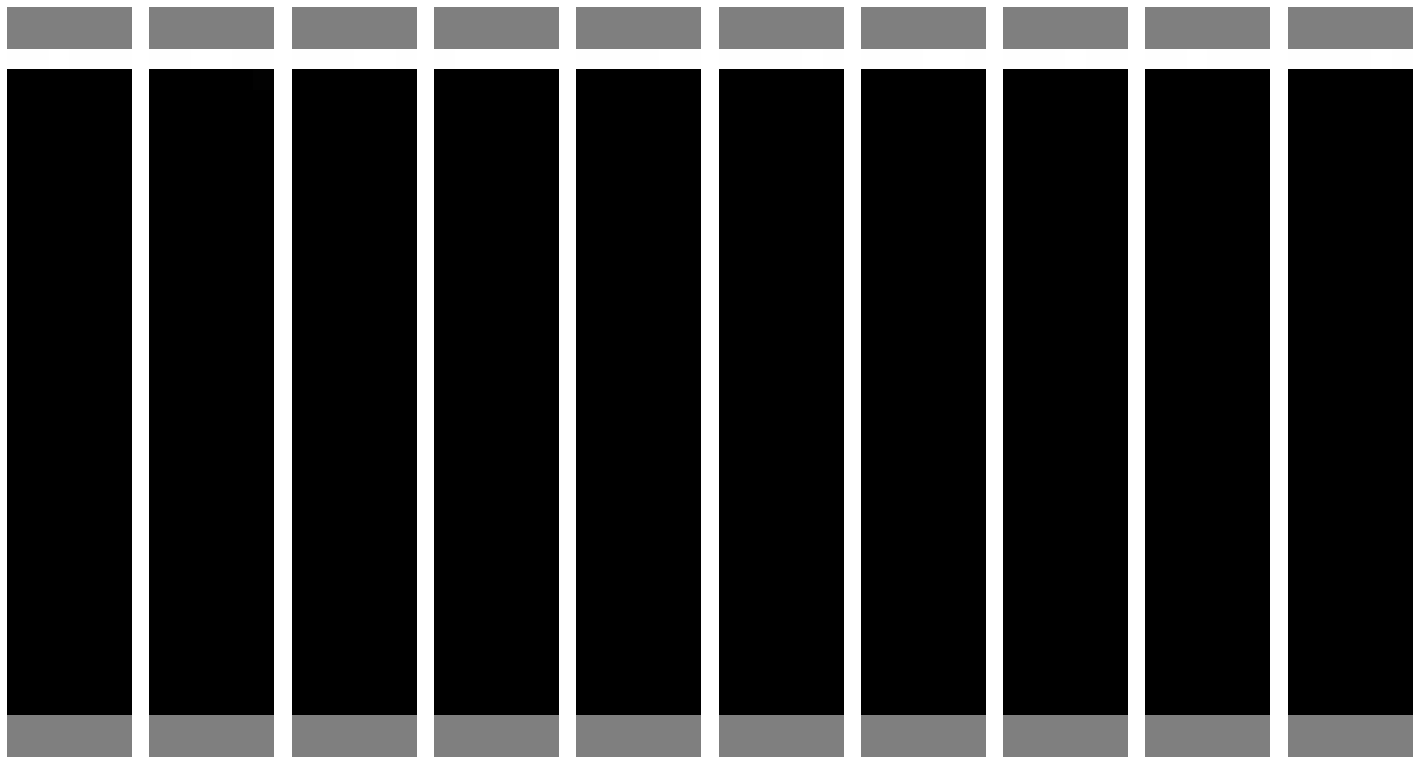

Epoch 137/200
8/8 - 1s - loss: 5.9897 - d_loss: 0.0023 - g_loss: 5.9874


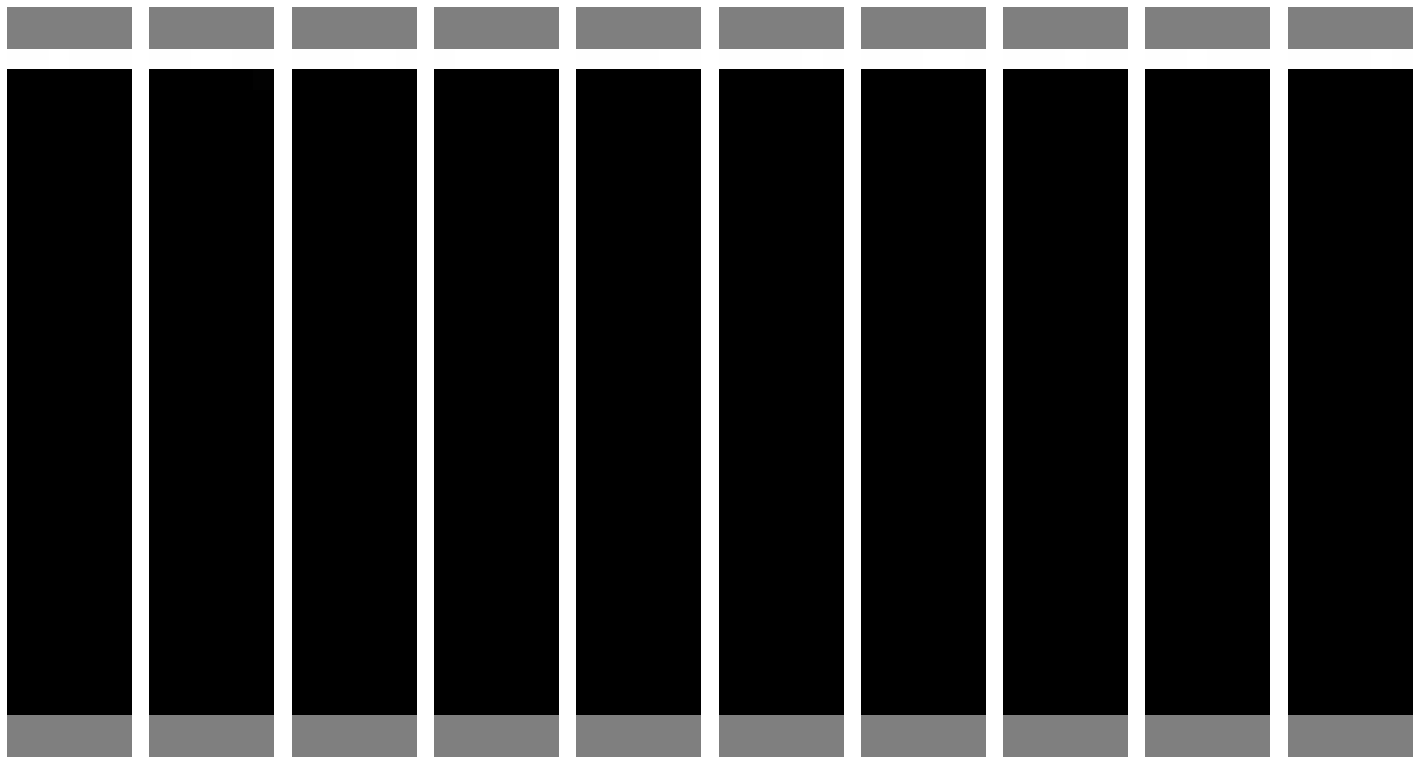

Epoch 138/200
8/8 - 1s - loss: 6.0206 - d_loss: 0.0022 - g_loss: 6.0184


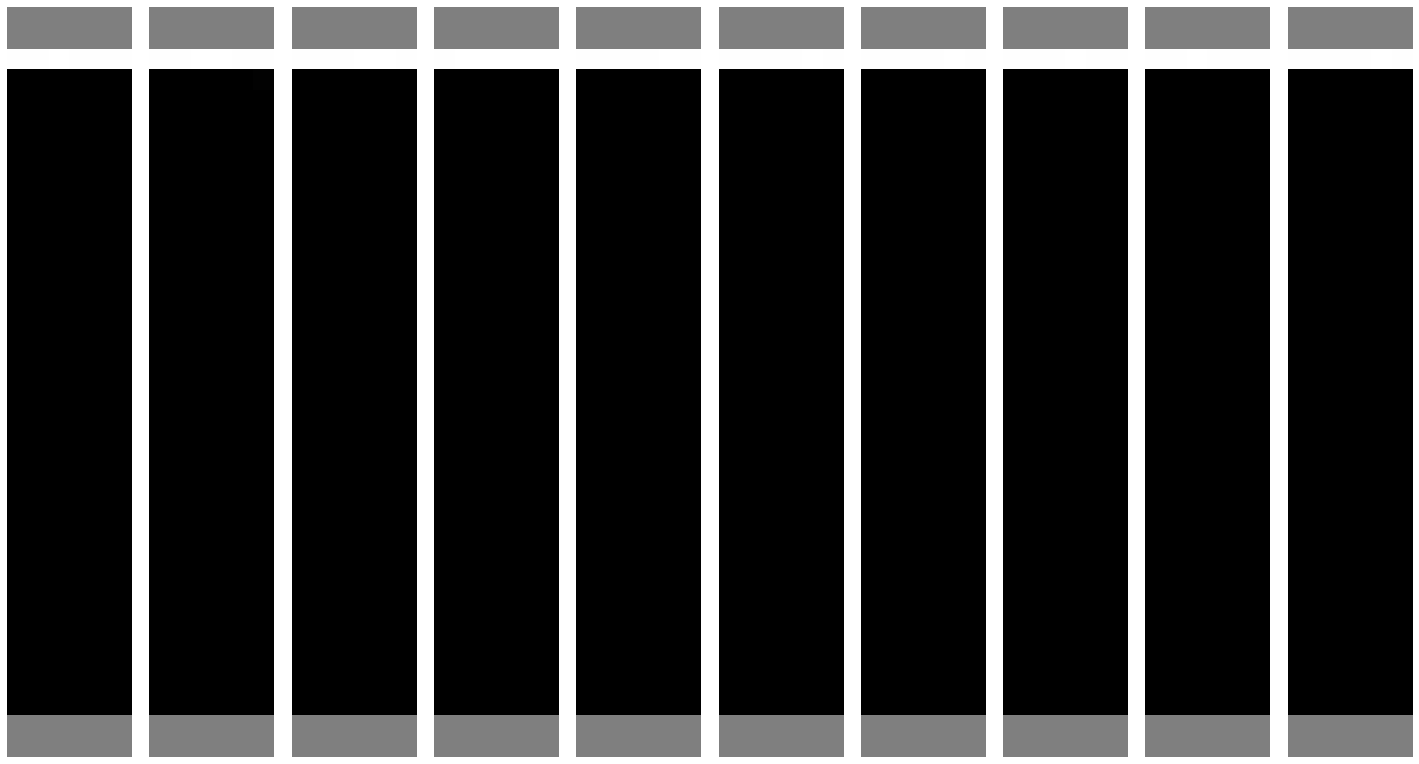

Epoch 139/200
8/8 - 1s - loss: 6.0466 - d_loss: 0.0021 - g_loss: 6.0445


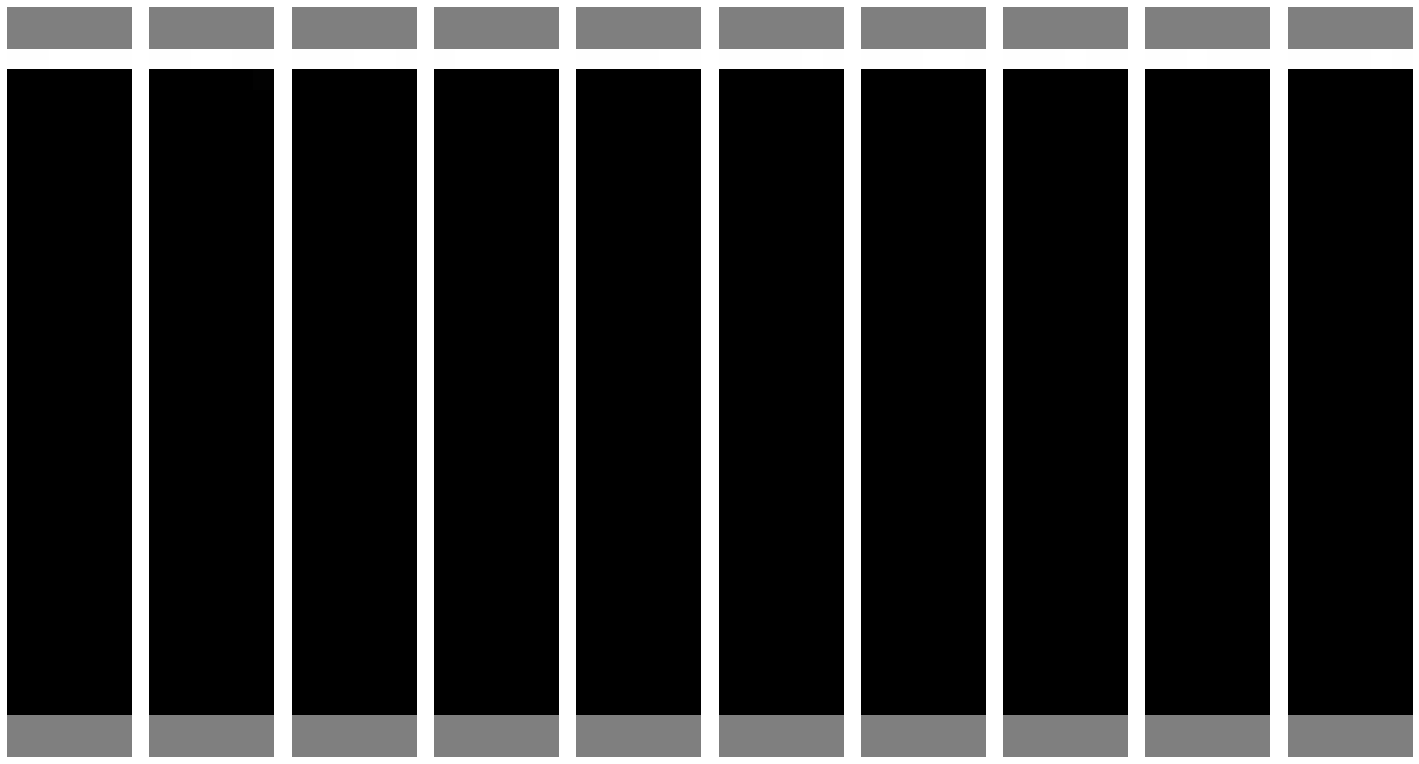

Epoch 140/200
8/8 - 1s - loss: 6.0656 - d_loss: 0.0021 - g_loss: 6.0635


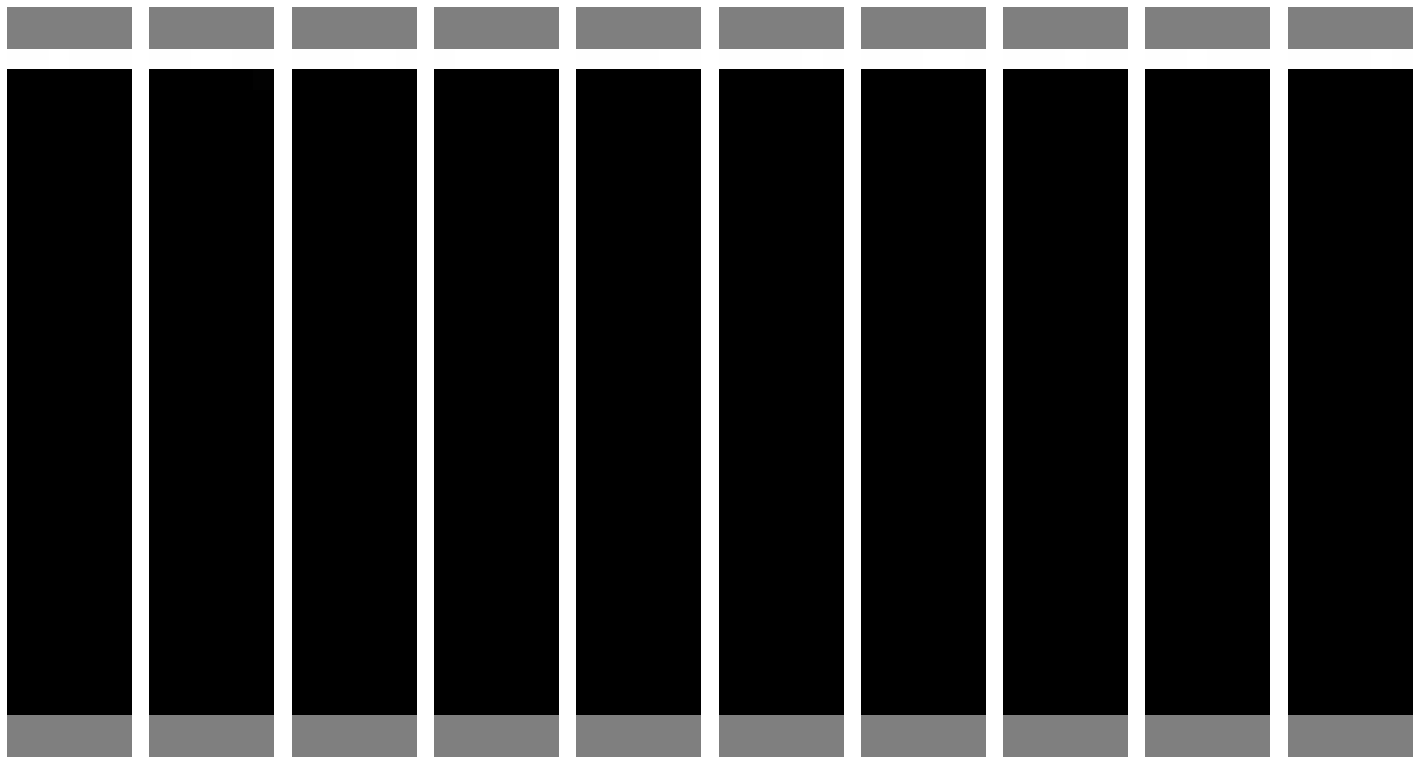

Epoch 141/200
8/8 - 1s - loss: 6.0922 - d_loss: 0.0020 - g_loss: 6.0901


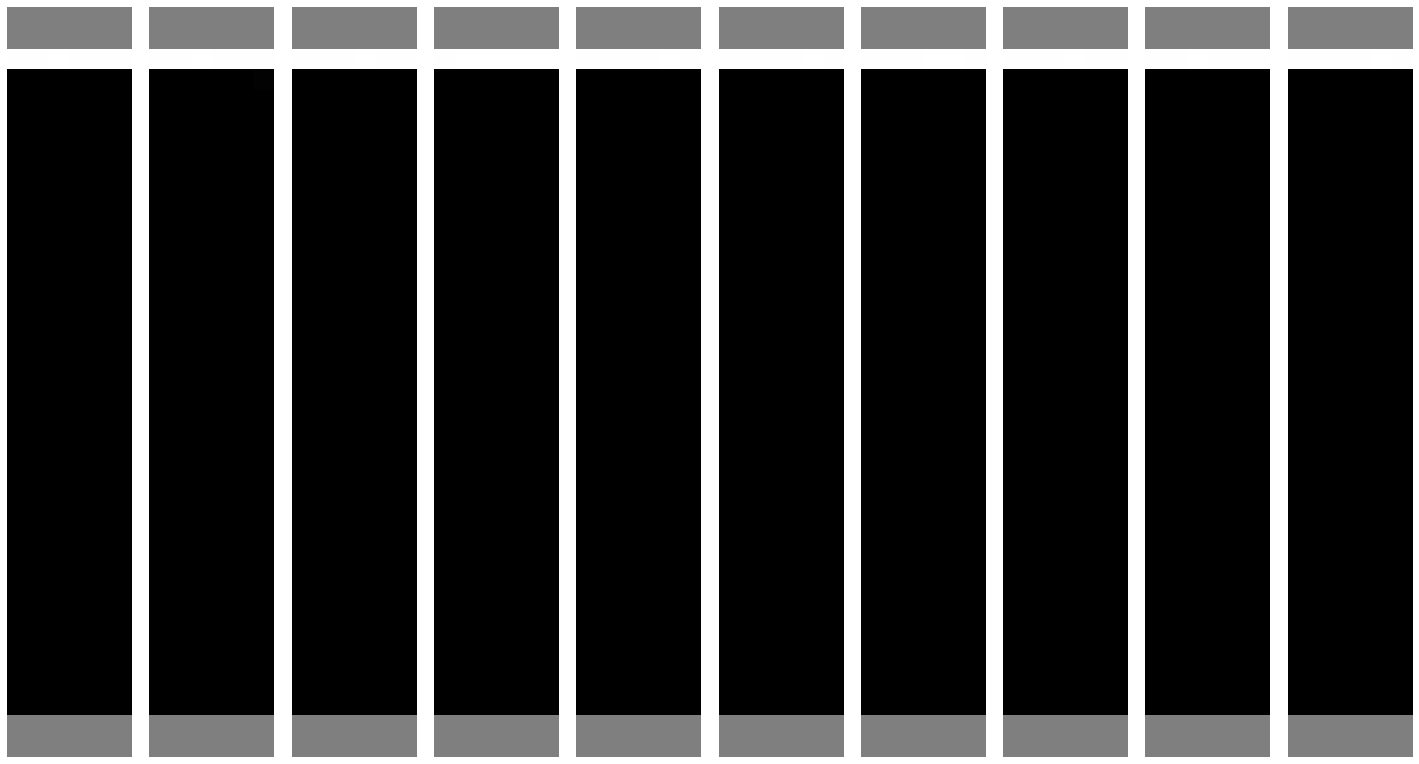

Epoch 142/200
8/8 - 1s - loss: 6.1102 - d_loss: 0.0020 - g_loss: 6.1082


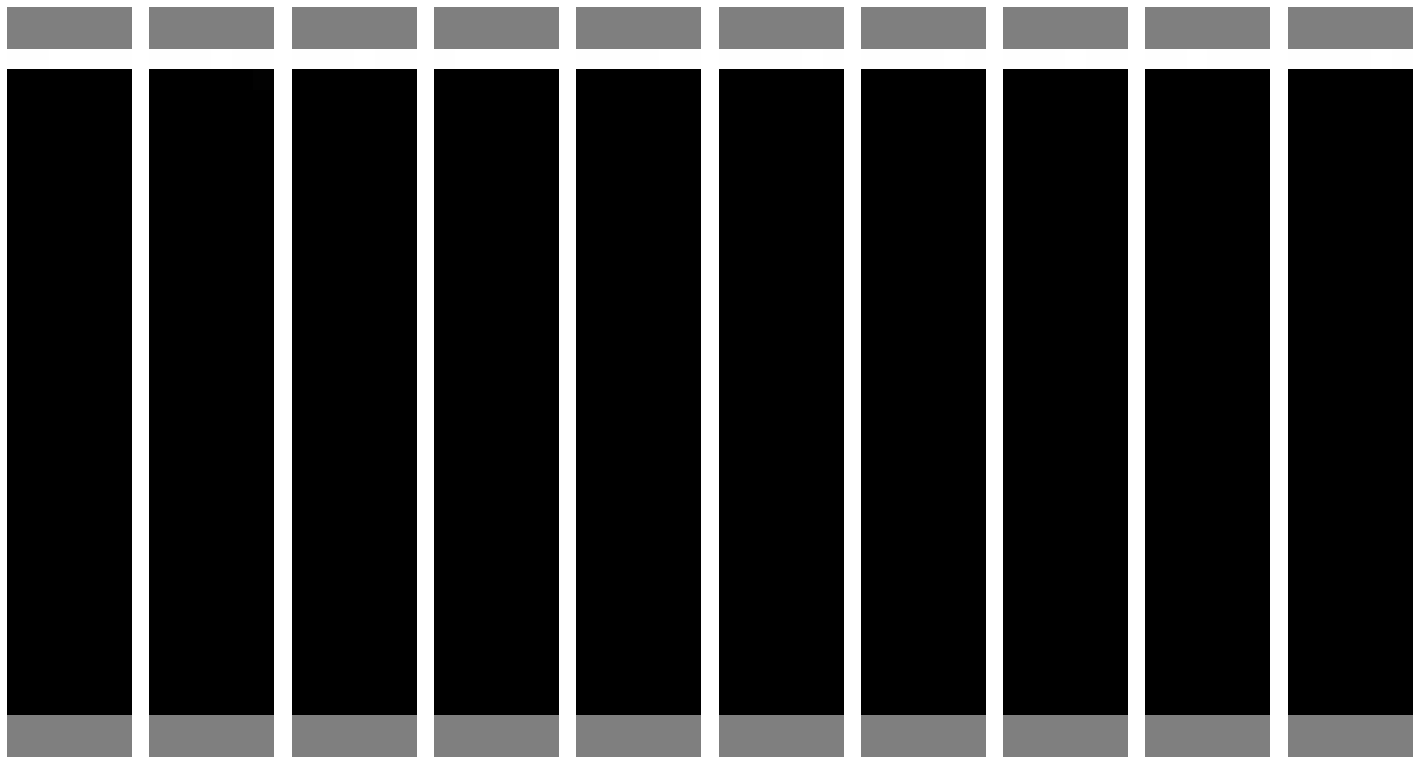

Epoch 143/200
8/8 - 1s - loss: 6.1274 - d_loss: 0.0020 - g_loss: 6.1254


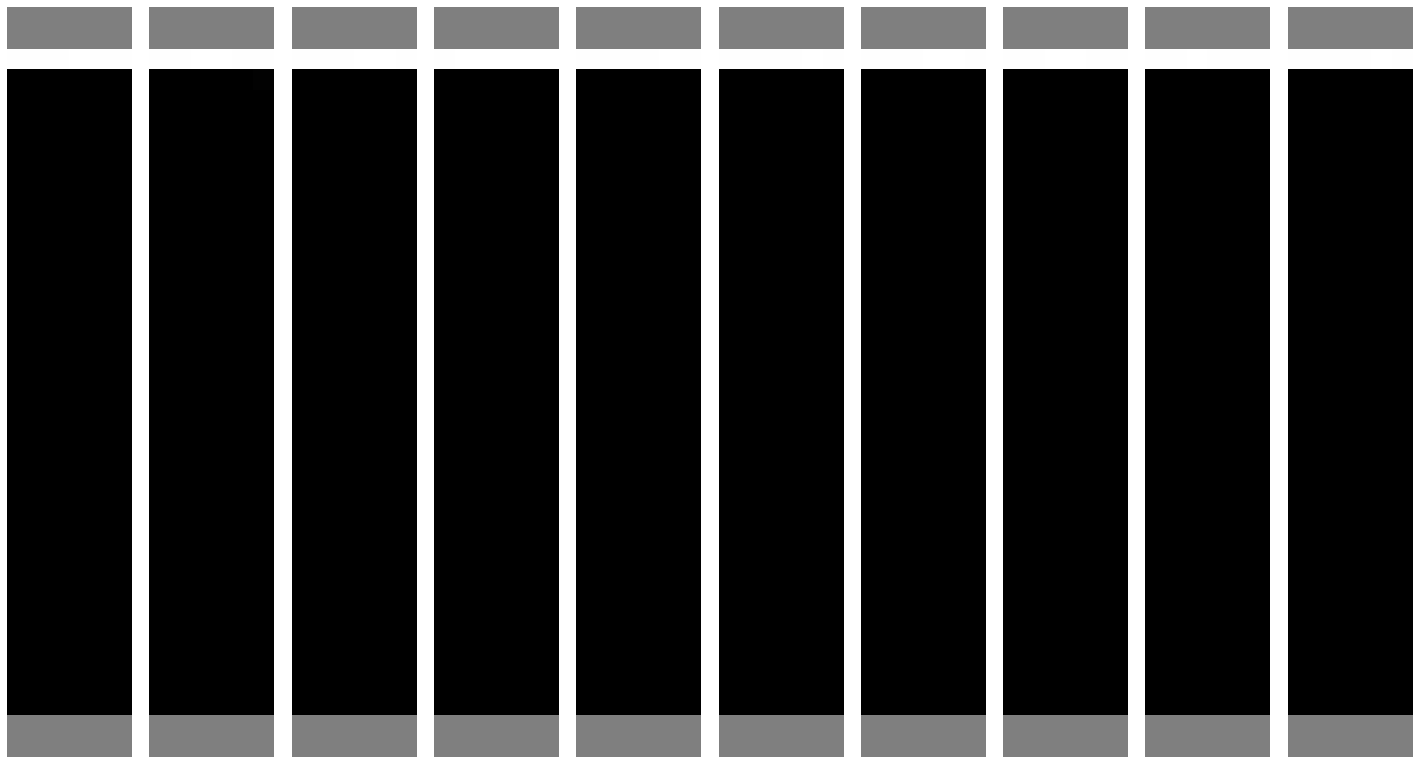

Epoch 144/200
8/8 - 1s - loss: 6.1545 - d_loss: 0.0019 - g_loss: 6.1525


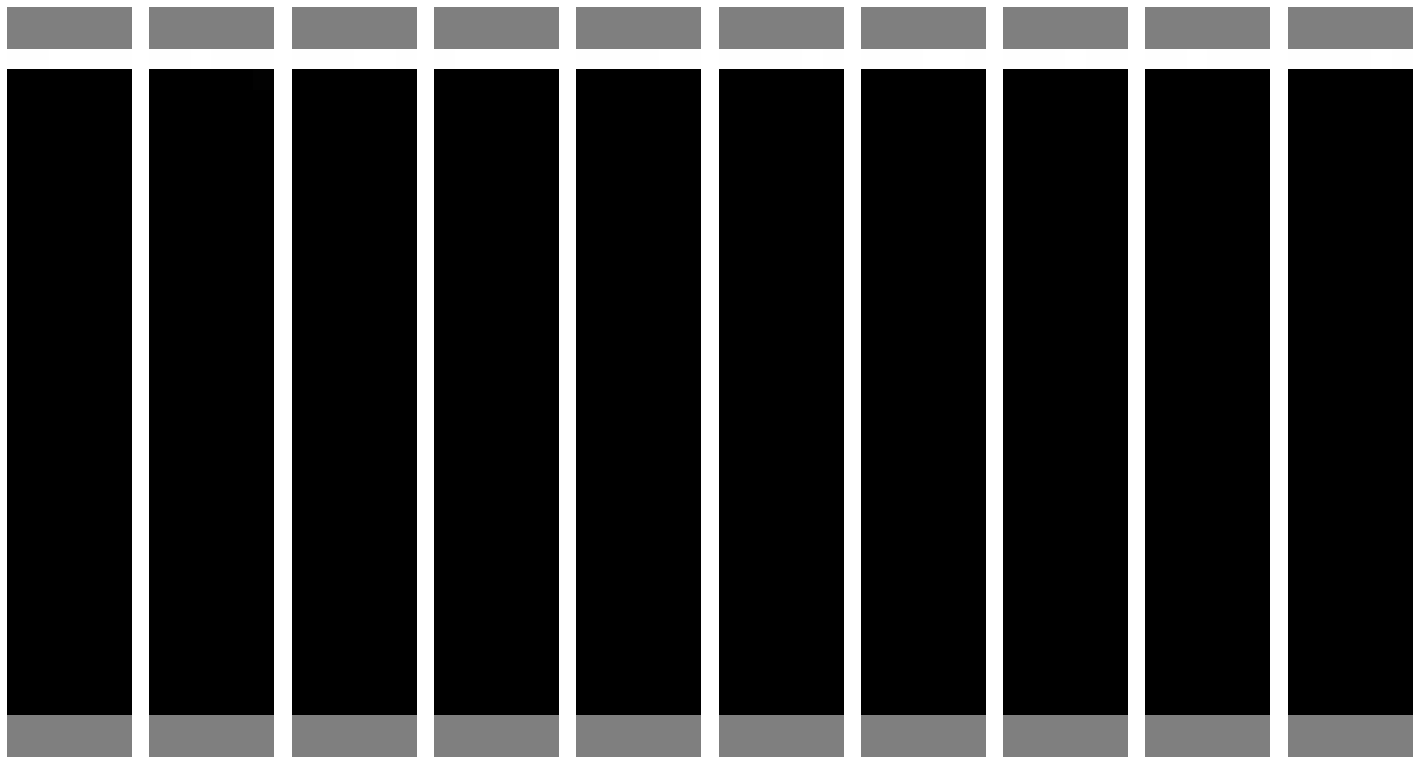

Epoch 145/200
8/8 - 1s - loss: 6.1763 - d_loss: 0.0019 - g_loss: 6.1745


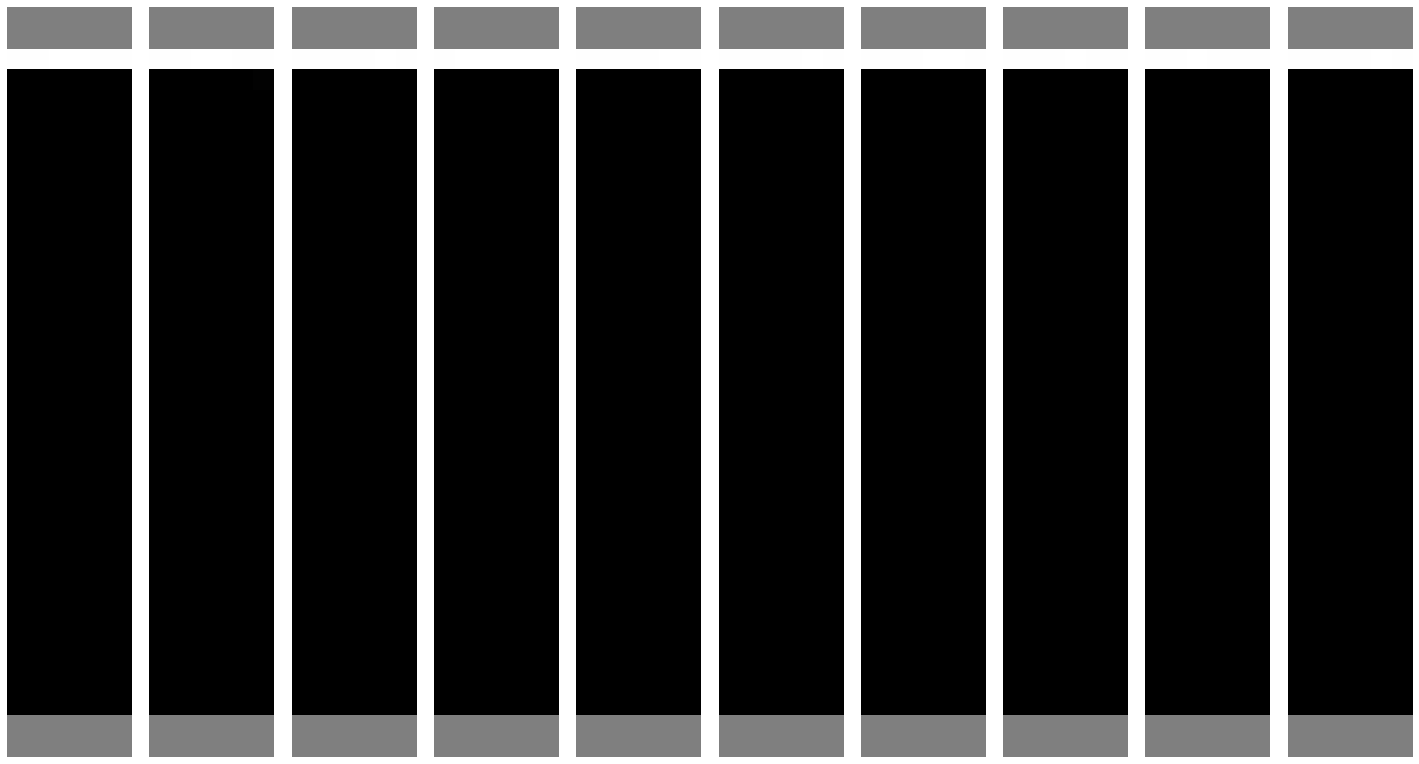

Epoch 146/200
8/8 - 1s - loss: 6.1955 - d_loss: 0.0019 - g_loss: 6.1937


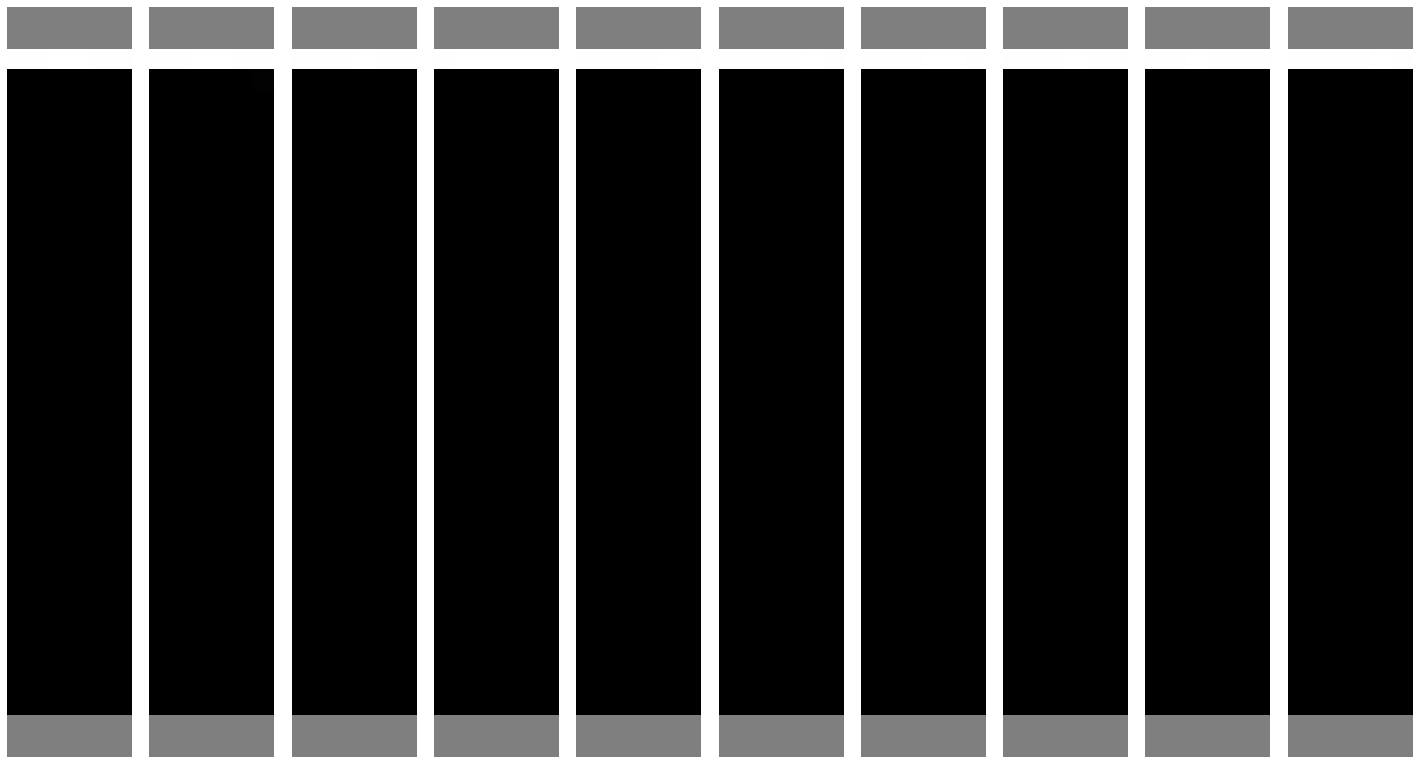

Epoch 147/200
8/8 - 1s - loss: 6.2164 - d_loss: 0.0018 - g_loss: 6.2146


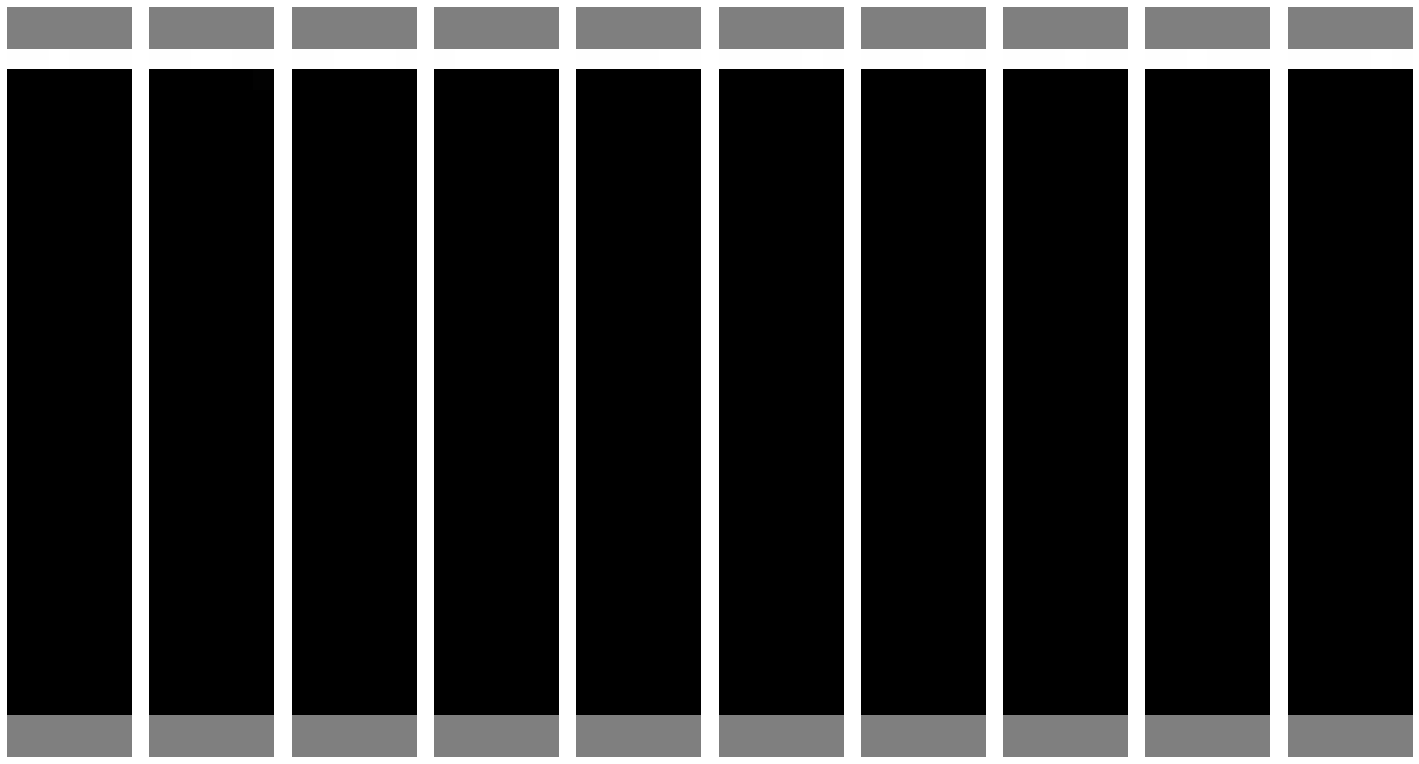

Epoch 148/200
8/8 - 1s - loss: 6.2372 - d_loss: 0.0018 - g_loss: 6.2354


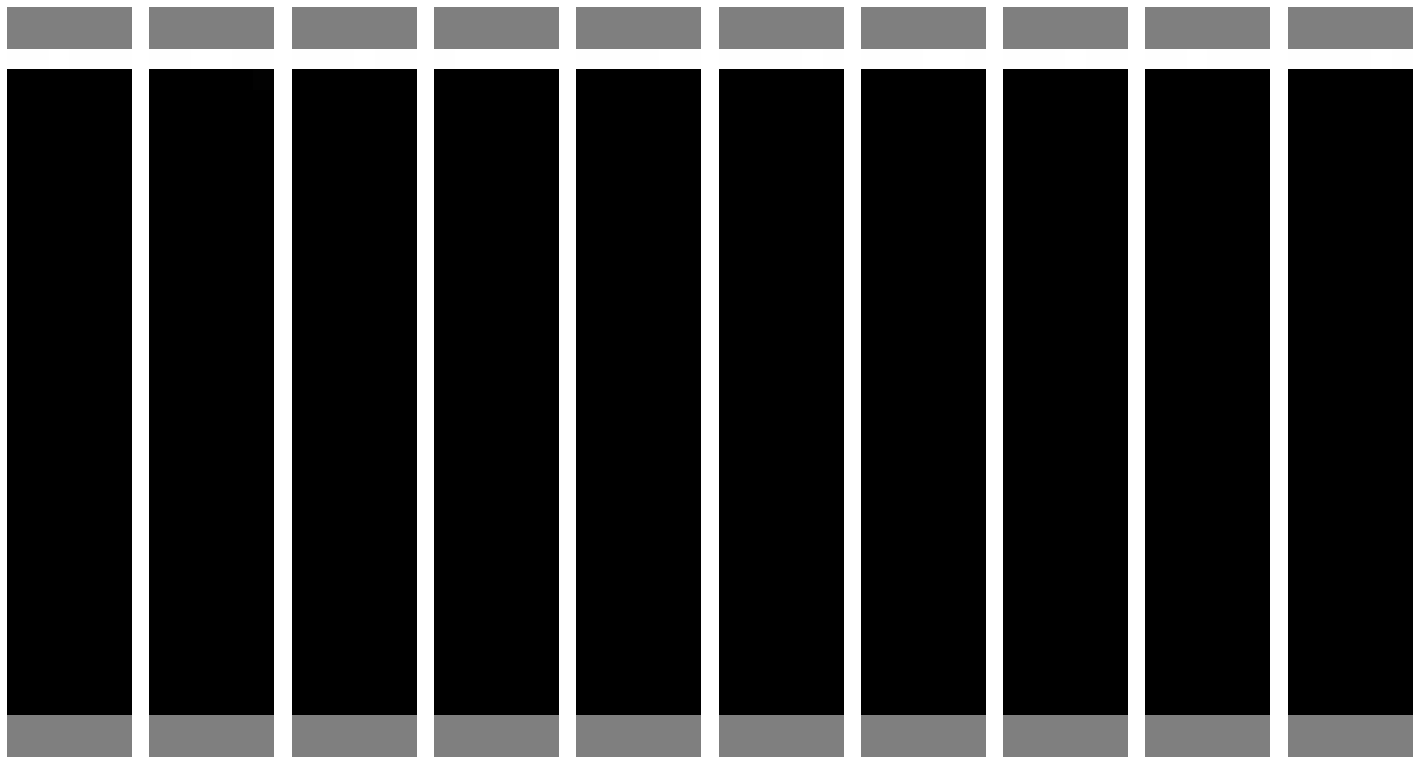

Epoch 149/200
8/8 - 1s - loss: 6.2623 - d_loss: 0.0017 - g_loss: 6.2605


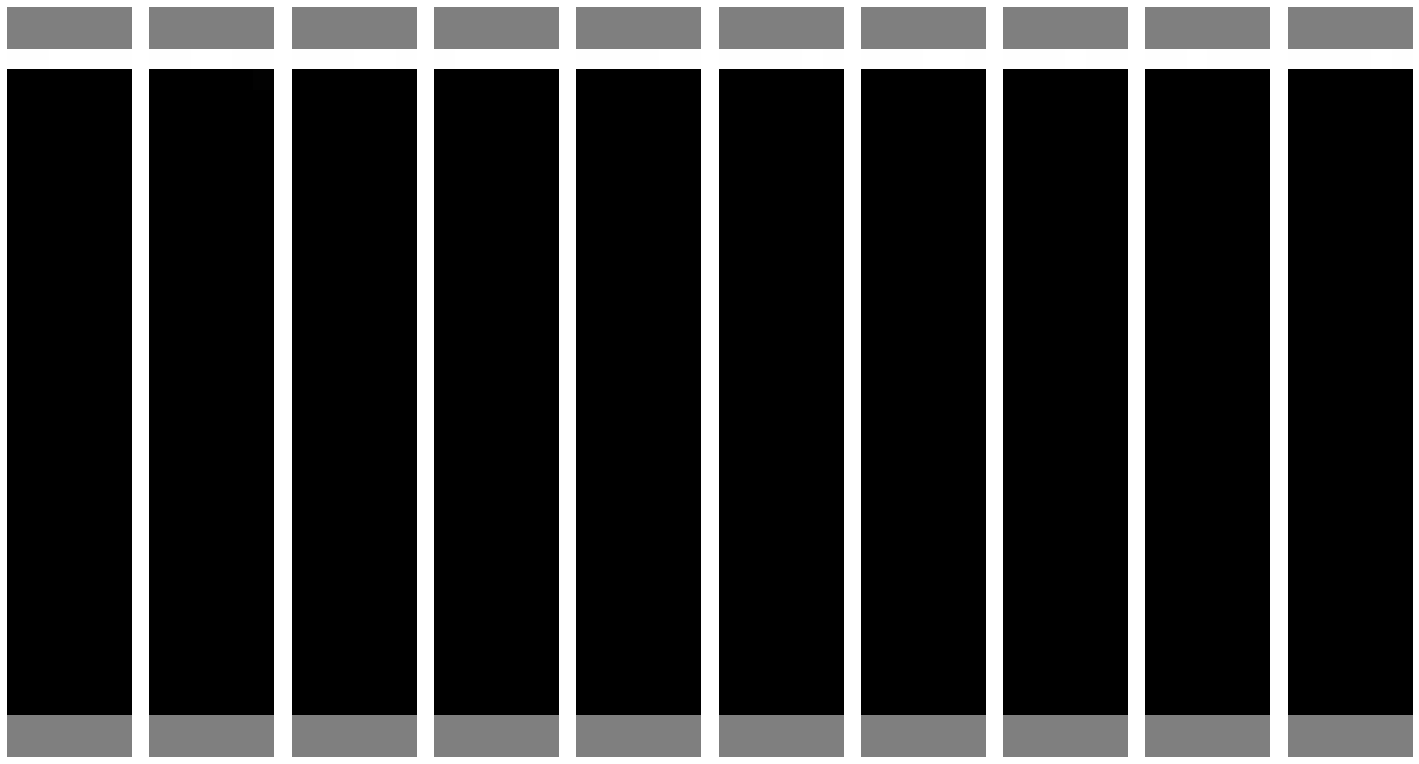

Epoch 150/200
8/8 - 1s - loss: 6.2819 - d_loss: 0.0017 - g_loss: 6.2802


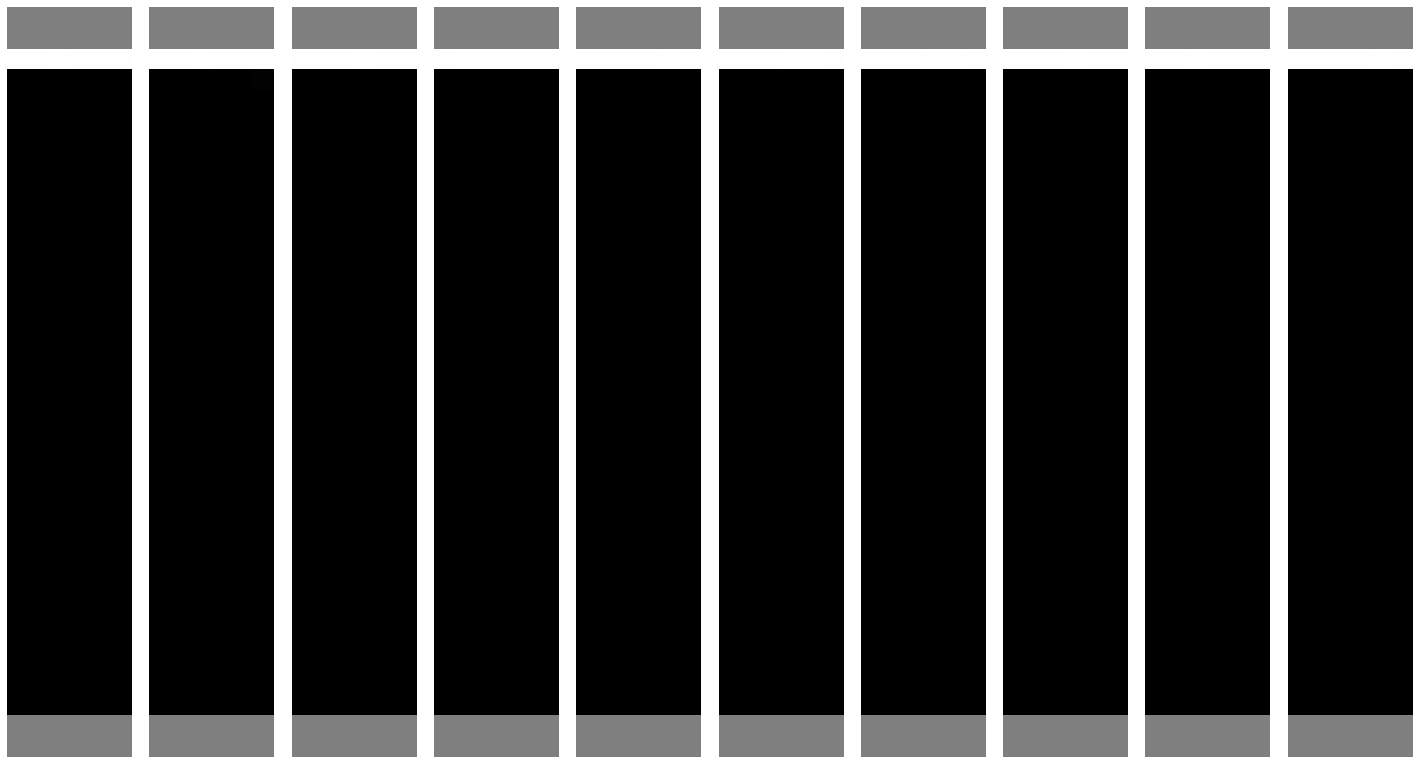

Epoch 151/200
8/8 - 1s - loss: 6.3040 - d_loss: 0.0017 - g_loss: 6.3023


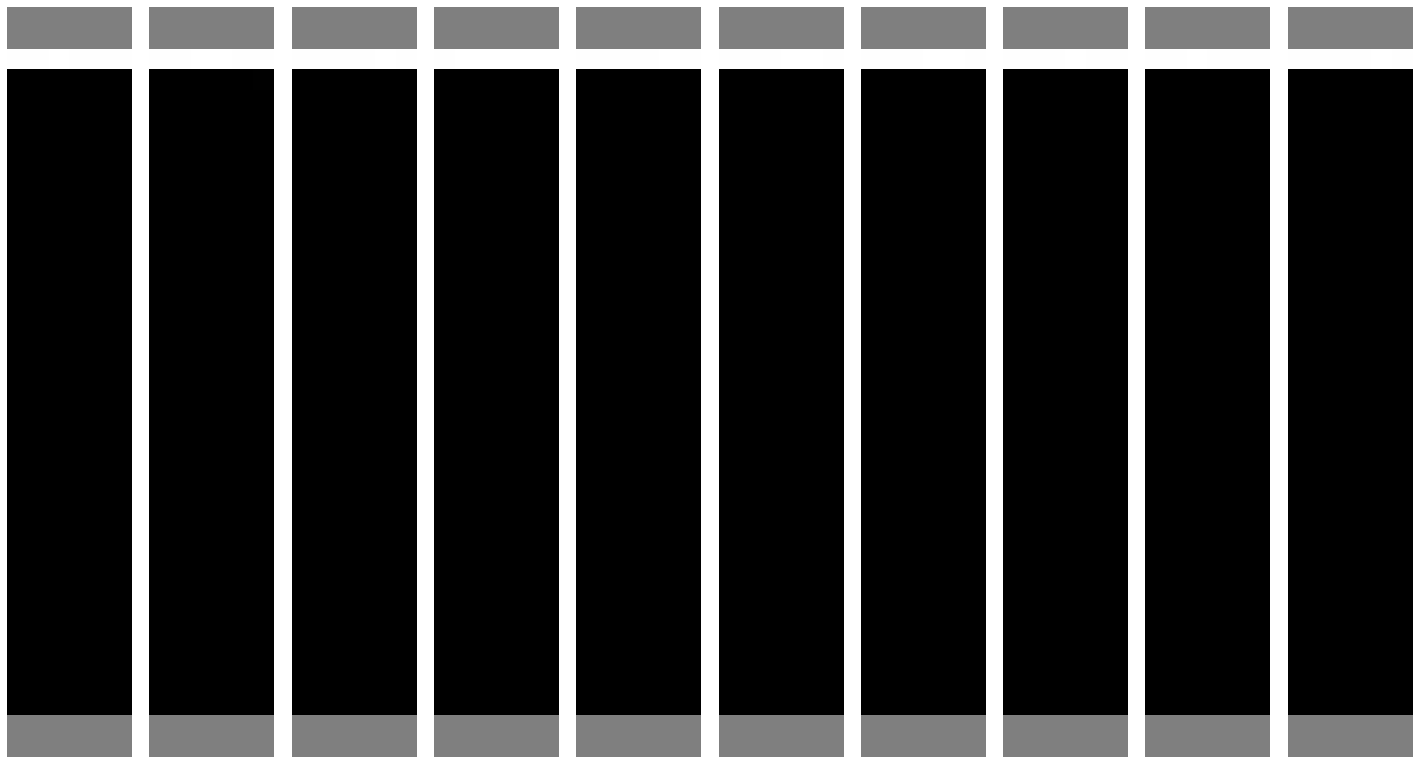

Epoch 152/200
8/8 - 1s - loss: 6.3272 - d_loss: 0.0016 - g_loss: 6.3255


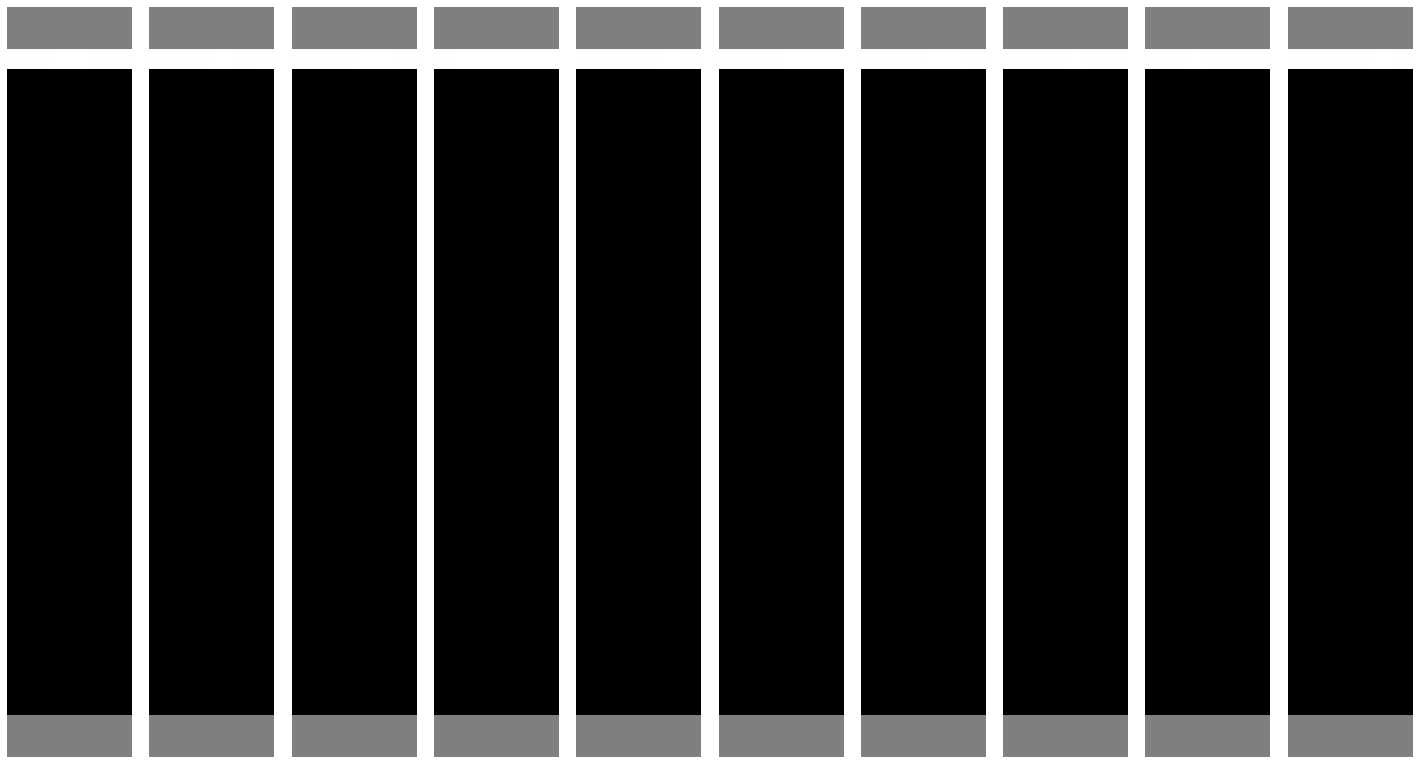

Epoch 153/200
8/8 - 1s - loss: 6.3473 - d_loss: 0.0016 - g_loss: 6.3457


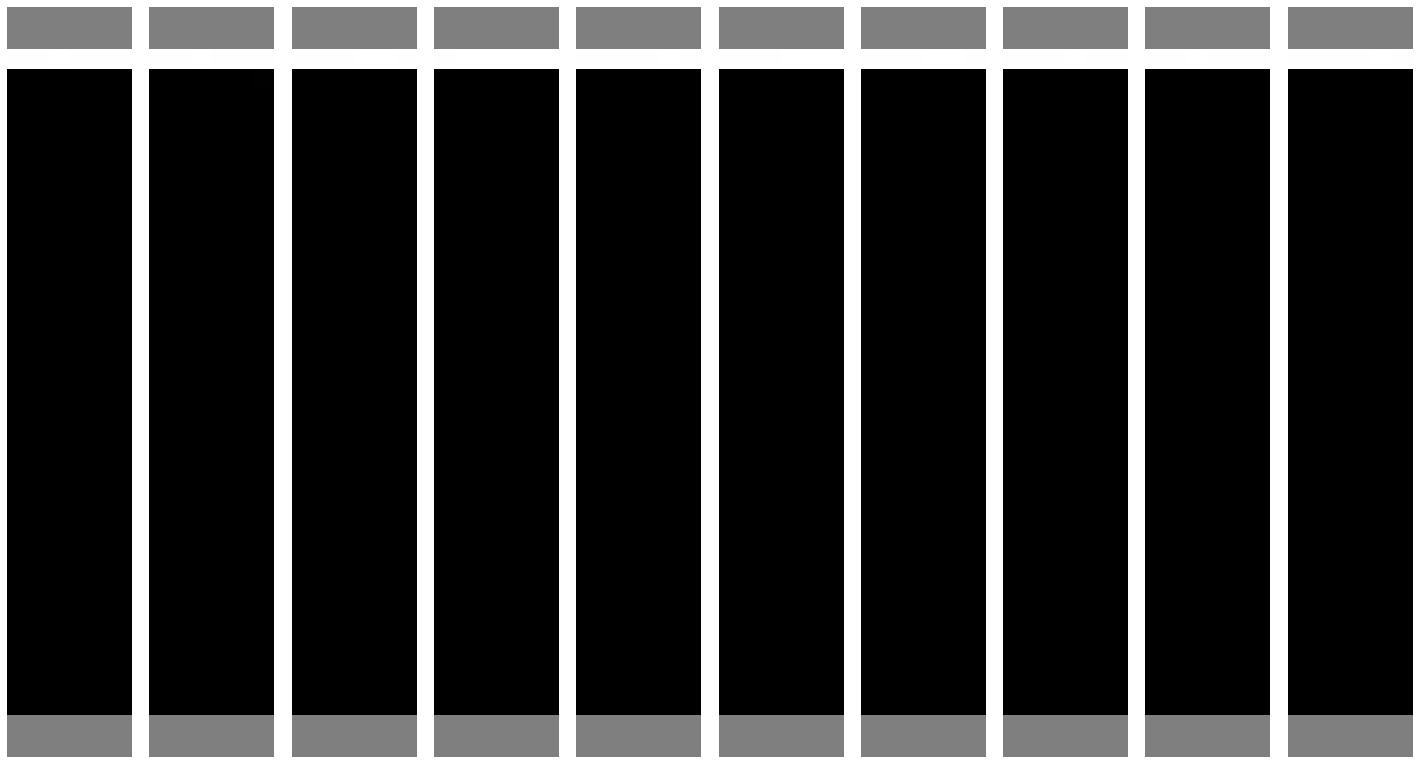

Epoch 154/200
8/8 - 1s - loss: 6.3643 - d_loss: 0.0016 - g_loss: 6.3627


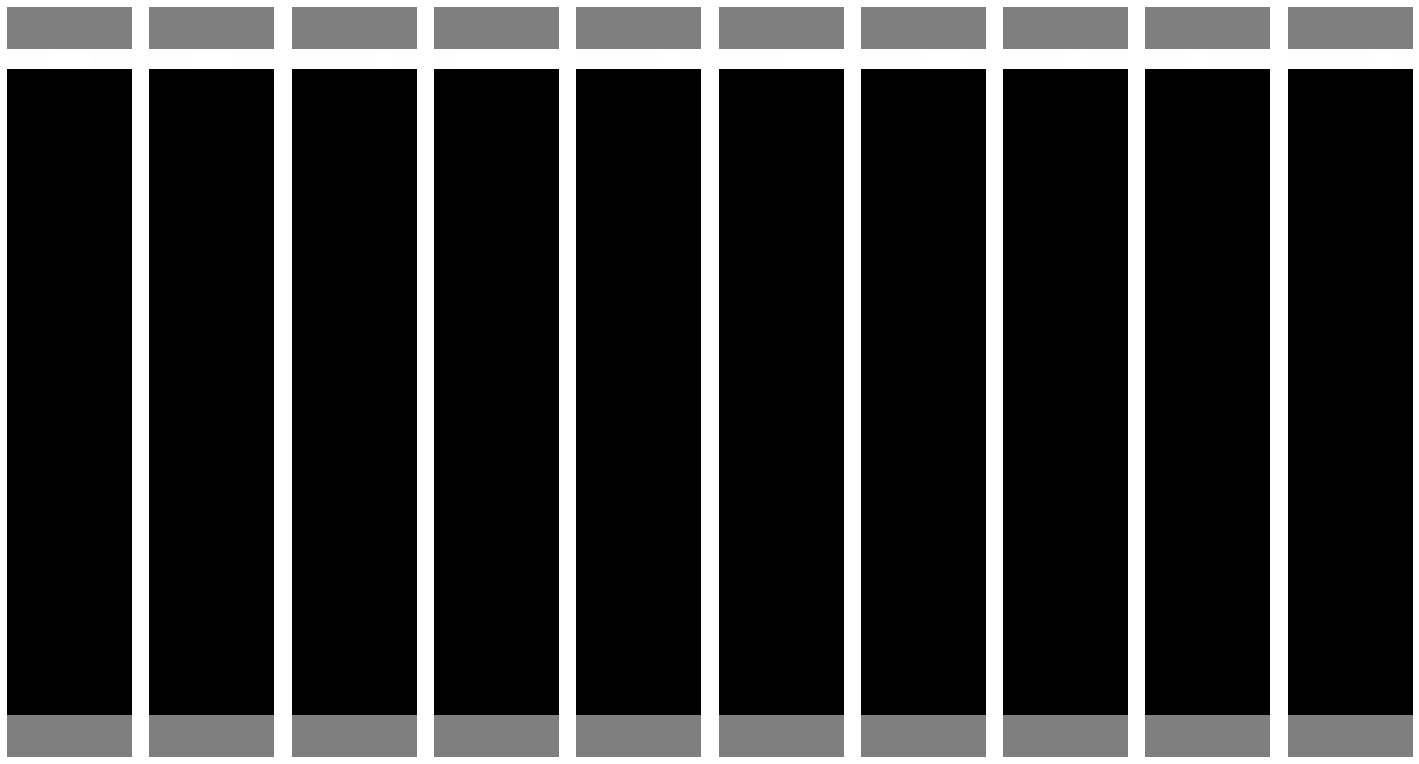

Epoch 155/200
8/8 - 1s - loss: 6.3830 - d_loss: 0.0015 - g_loss: 6.3815


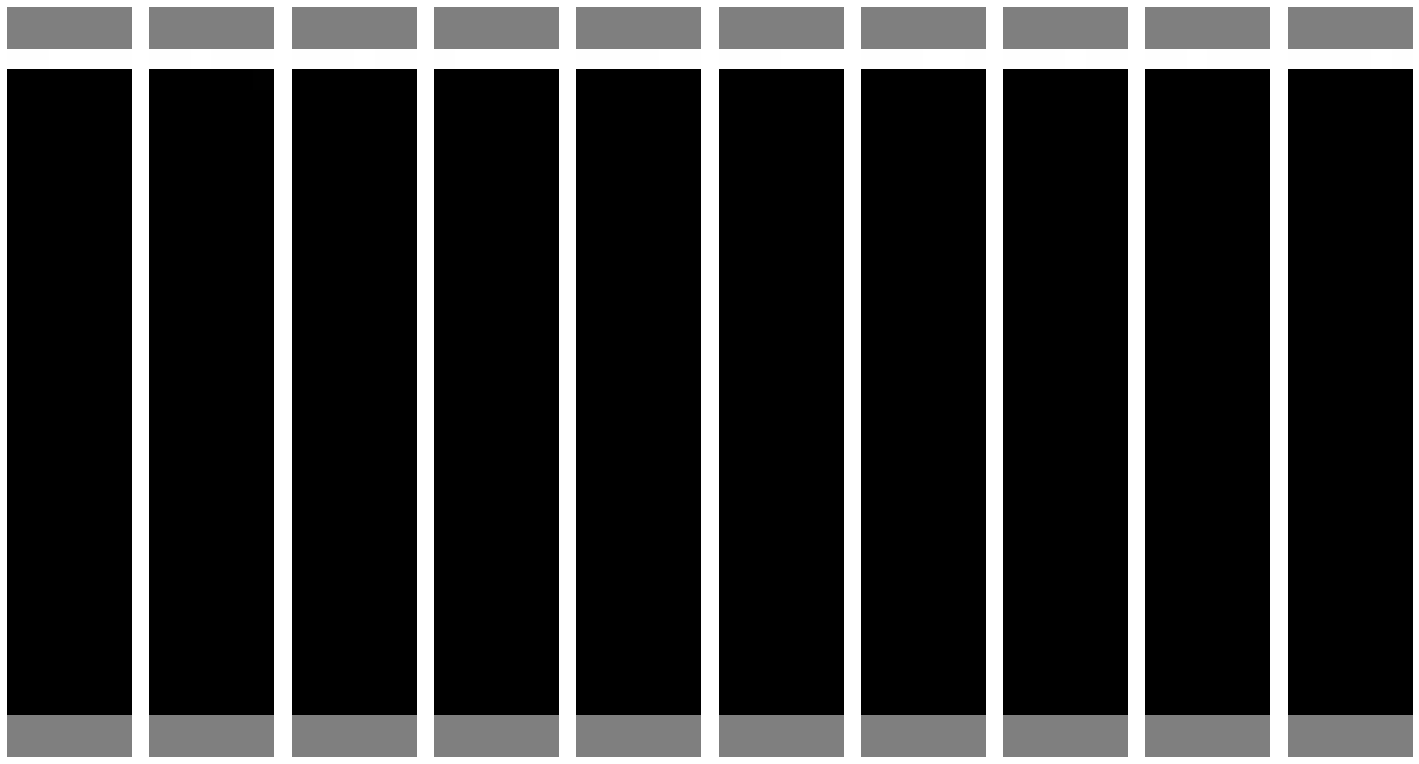

Epoch 156/200
8/8 - 1s - loss: 6.4038 - d_loss: 0.0015 - g_loss: 6.4023


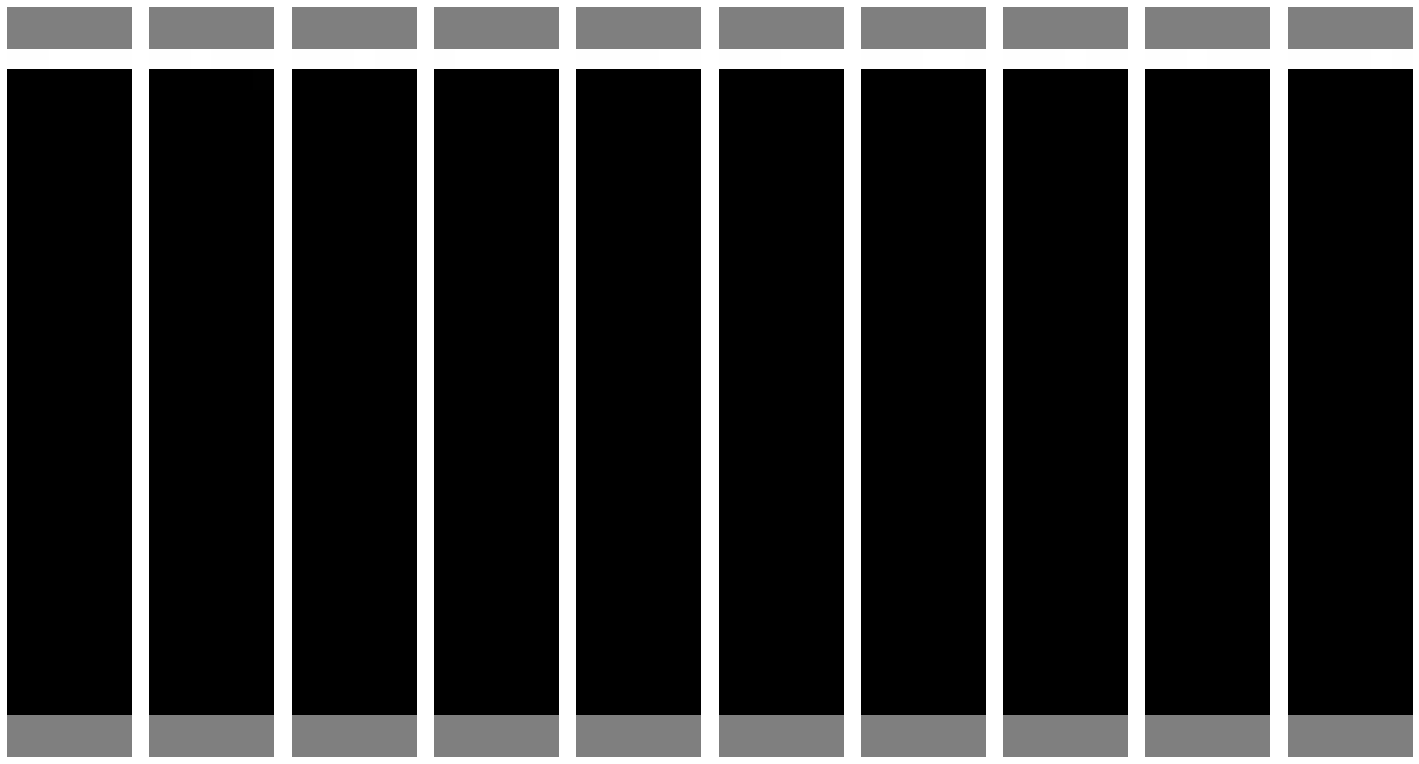

Epoch 157/200
8/8 - 1s - loss: 6.4257 - d_loss: 0.0015 - g_loss: 6.4242


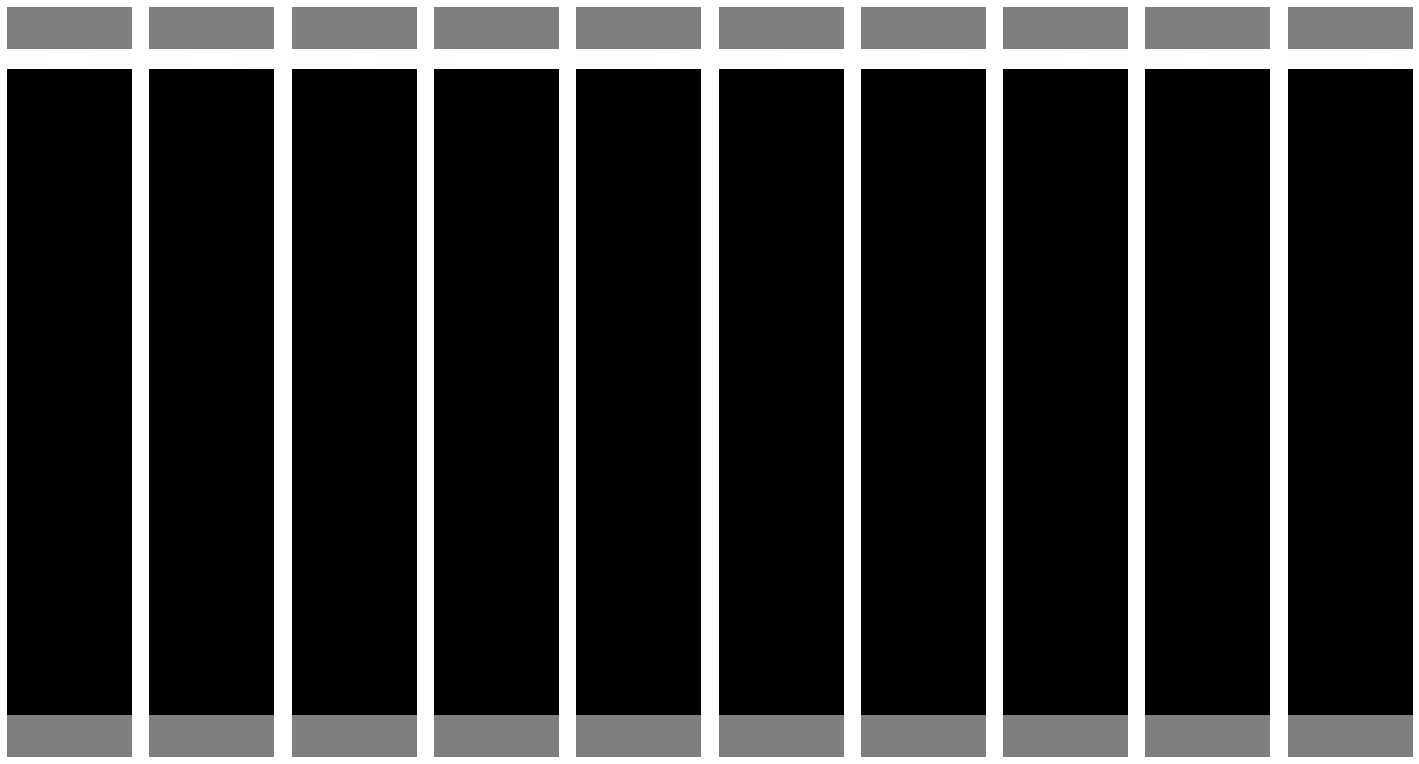

Epoch 158/200
8/8 - 1s - loss: 6.4445 - d_loss: 0.0015 - g_loss: 6.4430


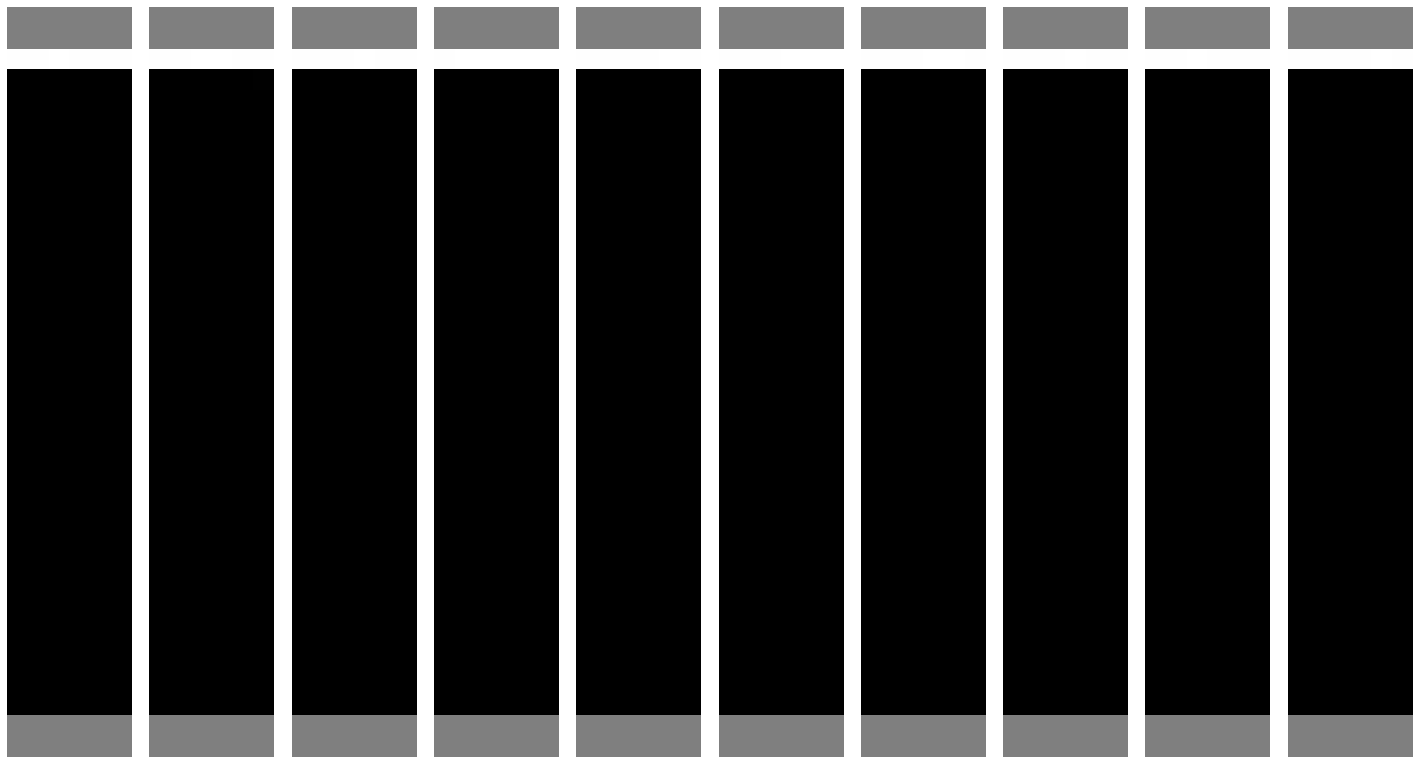

Epoch 159/200
8/8 - 1s - loss: 6.4562 - d_loss: 0.0014 - g_loss: 6.4548


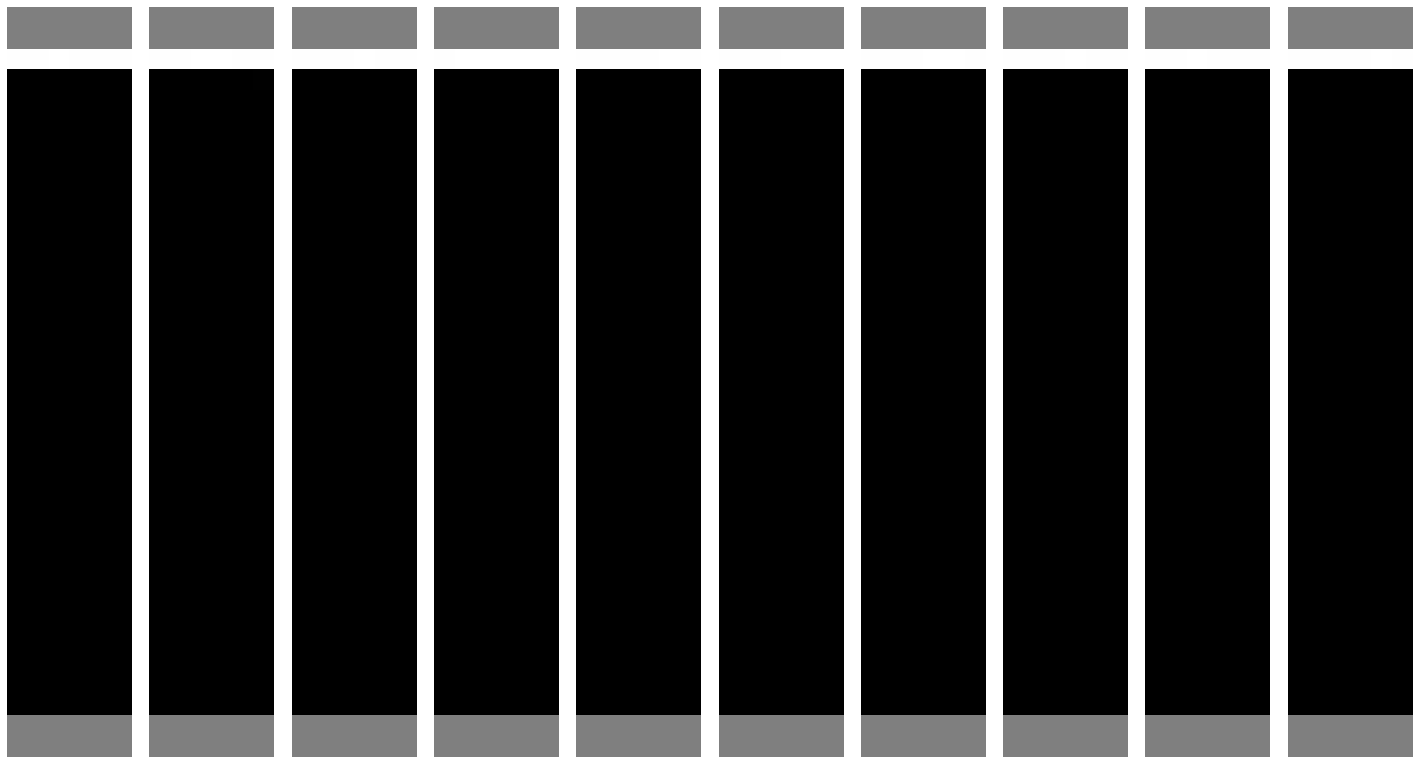

Epoch 160/200
8/8 - 1s - loss: 6.4731 - d_loss: 0.0014 - g_loss: 6.4717


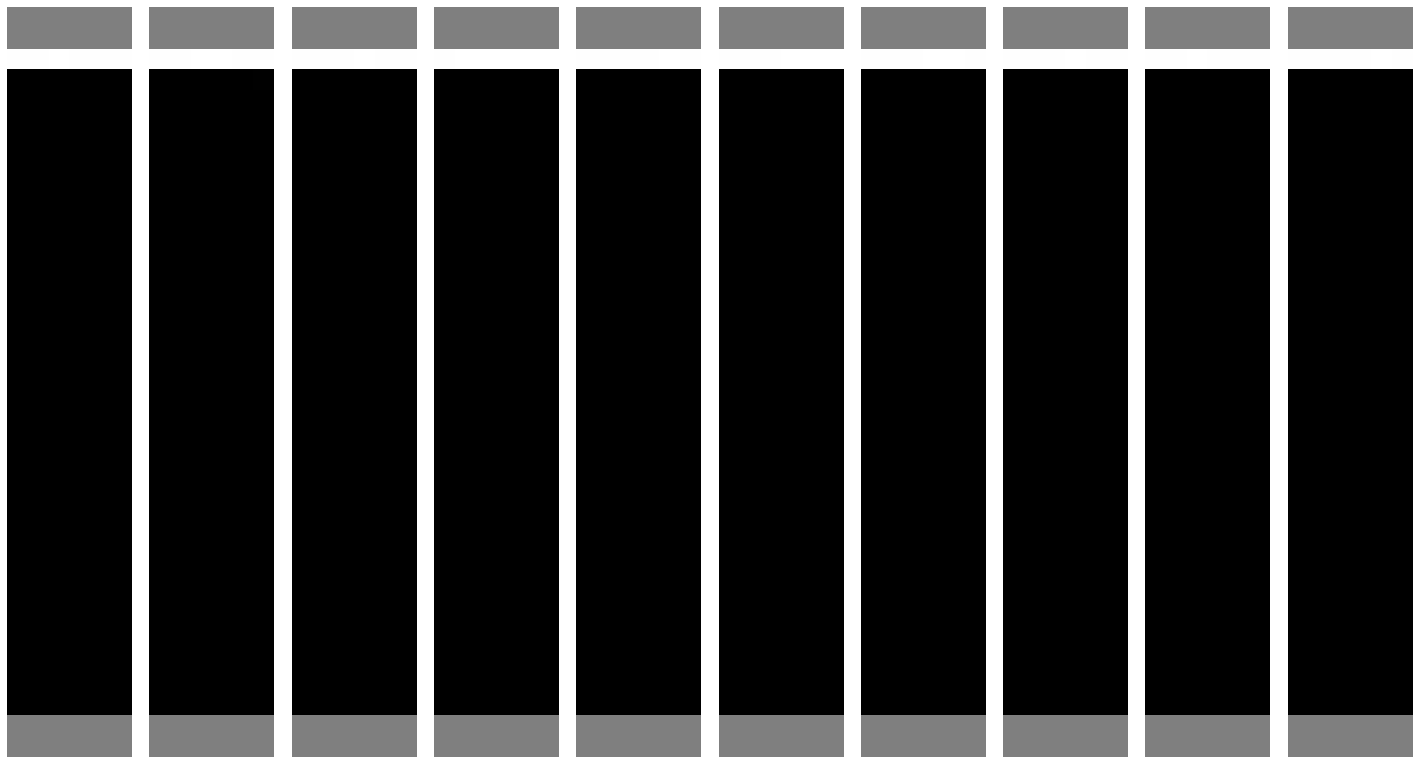

Epoch 161/200
8/8 - 1s - loss: 6.4949 - d_loss: 0.0014 - g_loss: 6.4935


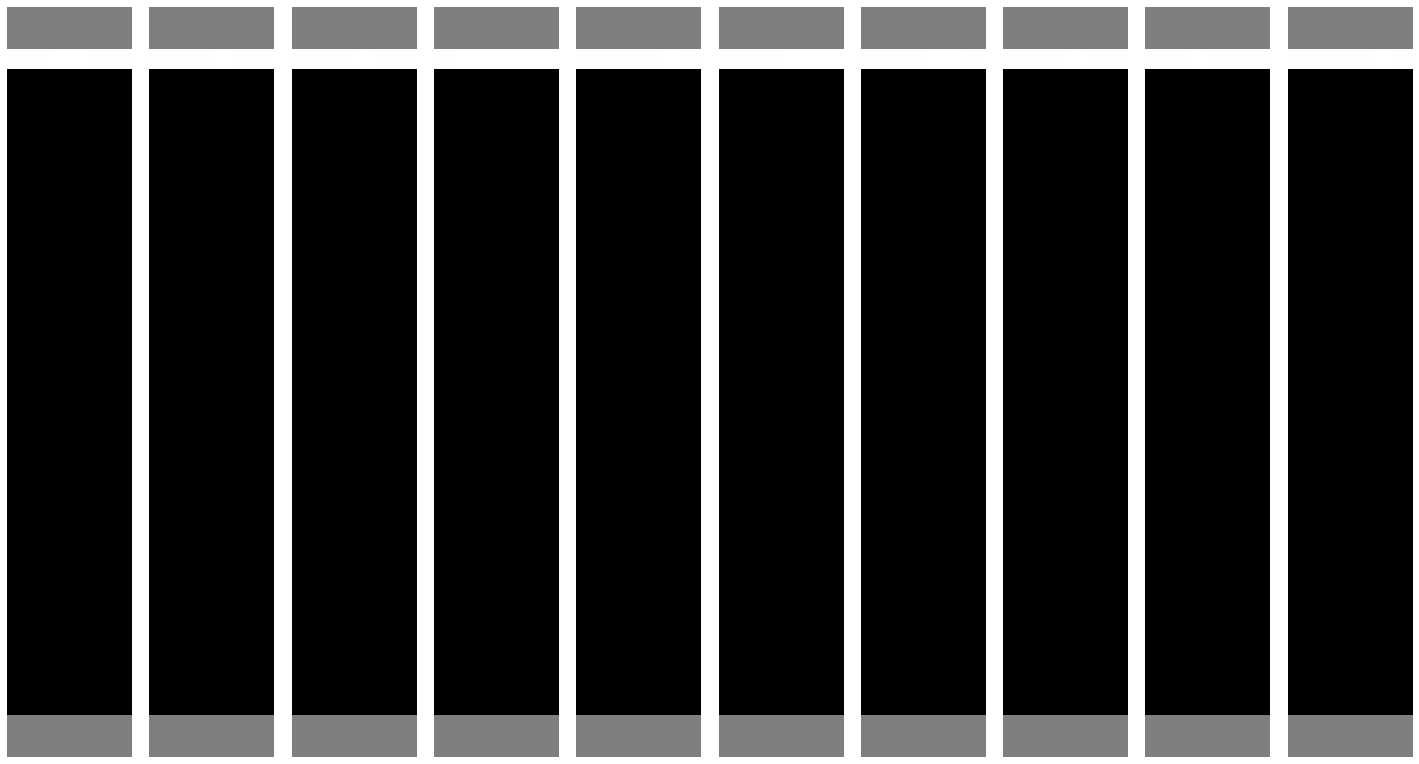

Epoch 162/200
8/8 - 1s - loss: 6.5120 - d_loss: 0.0014 - g_loss: 6.5106


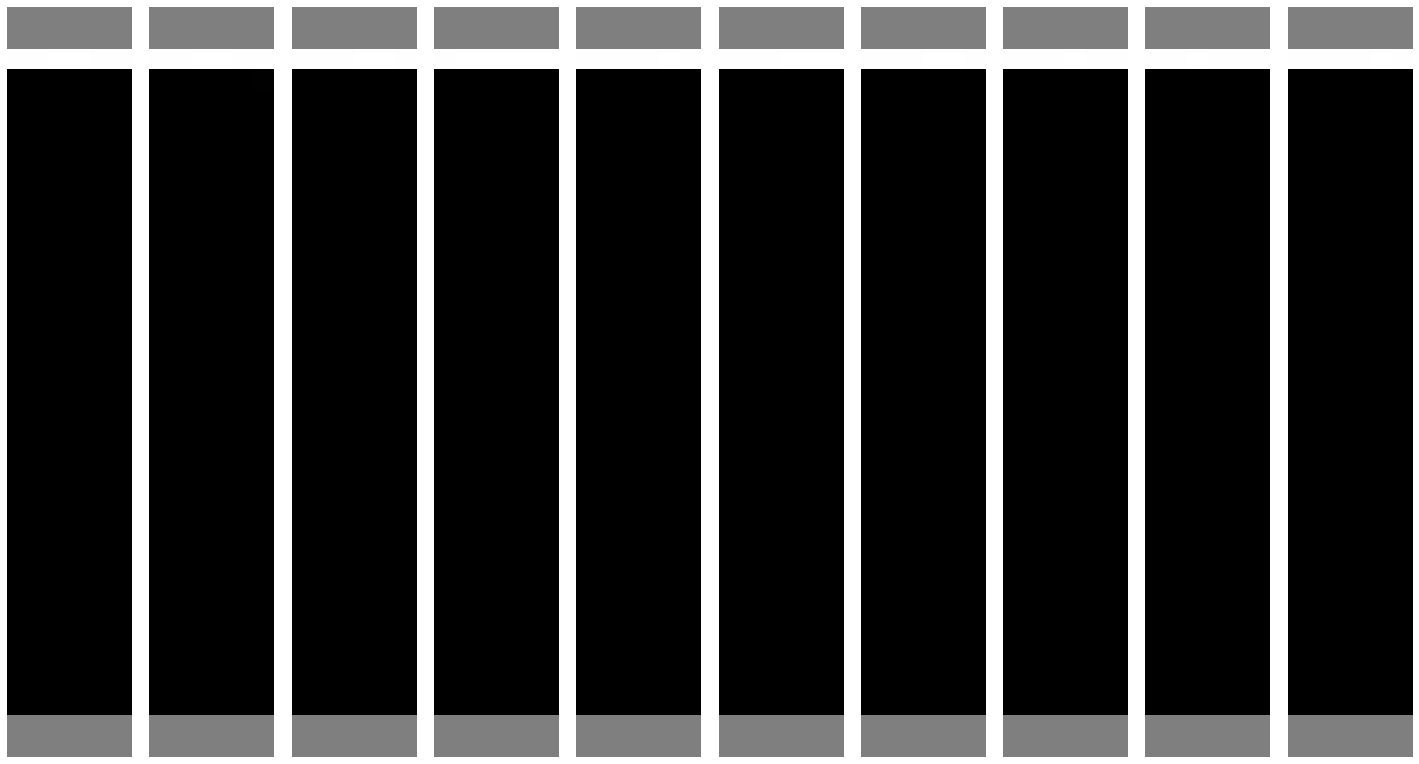

Epoch 163/200
8/8 - 1s - loss: 6.5293 - d_loss: 0.0013 - g_loss: 6.5280


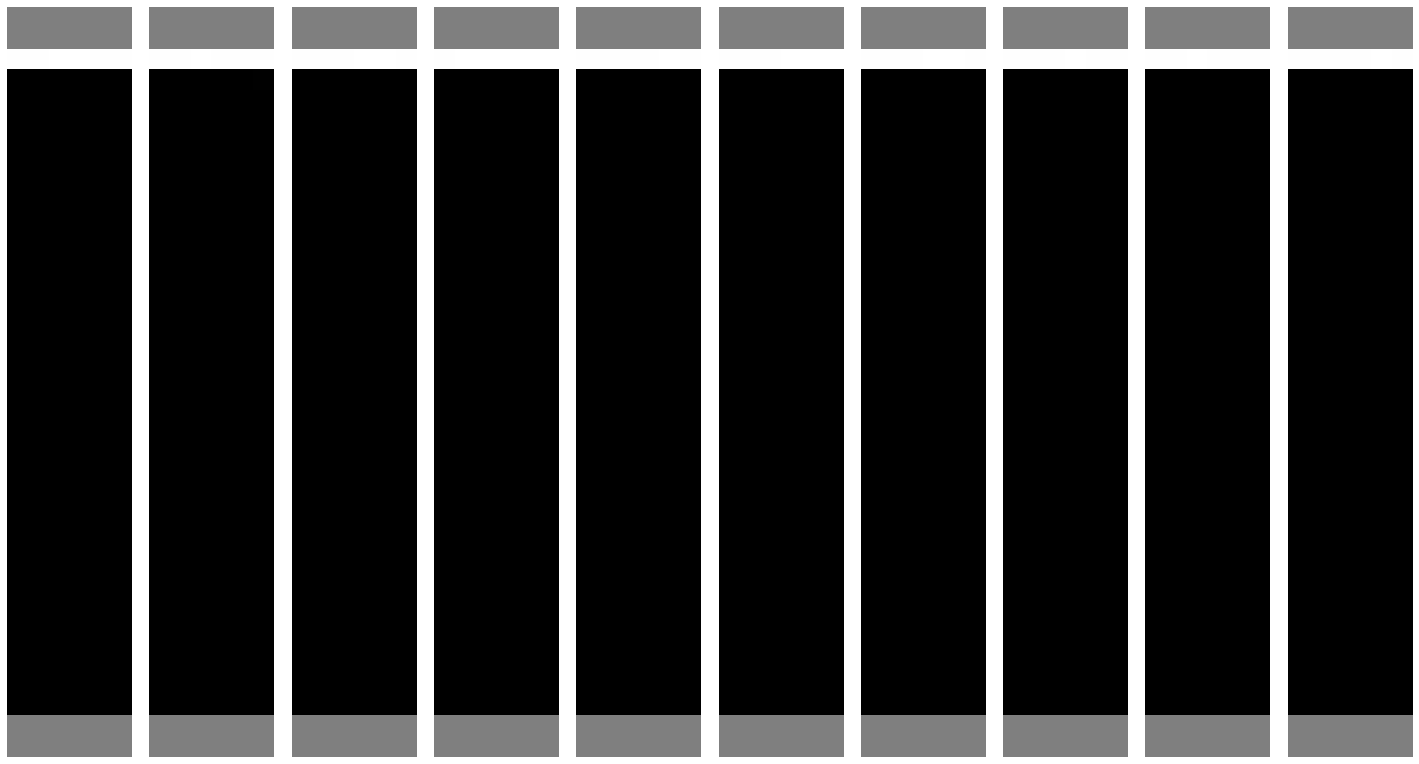

Epoch 164/200
8/8 - 1s - loss: 6.5539 - d_loss: 0.0013 - g_loss: 6.5526


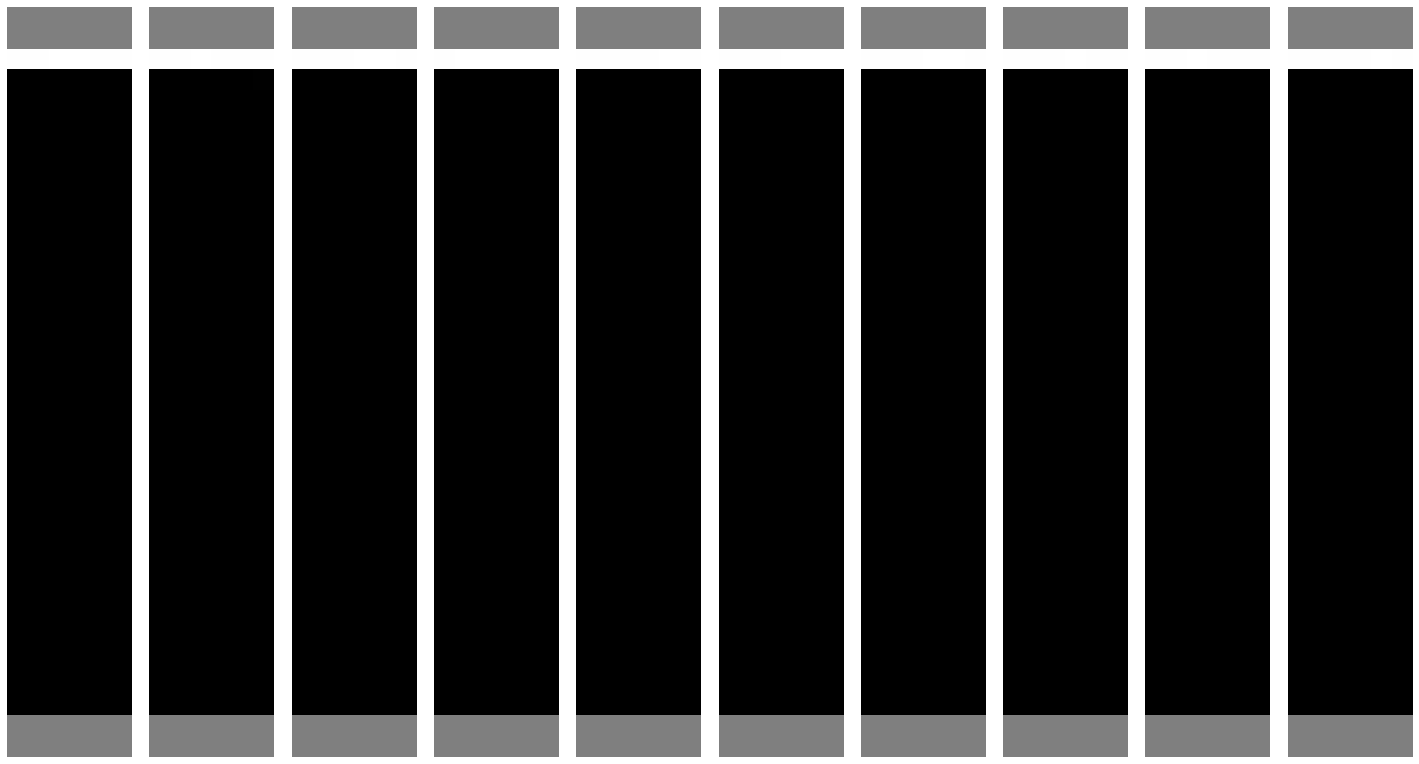

Epoch 165/200
8/8 - 1s - loss: 6.5683 - d_loss: 0.0013 - g_loss: 6.5670


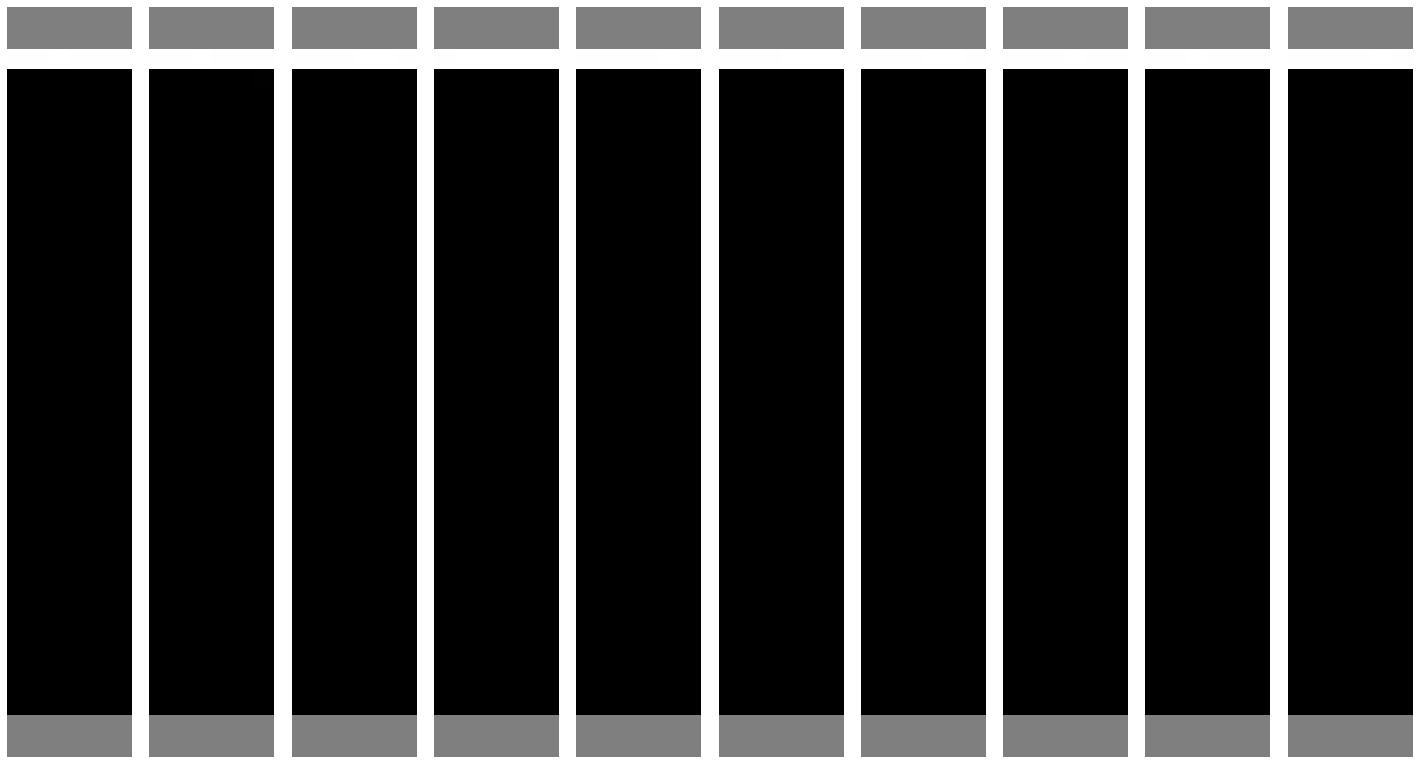

Epoch 166/200
8/8 - 1s - loss: 6.5891 - d_loss: 0.0013 - g_loss: 6.5878


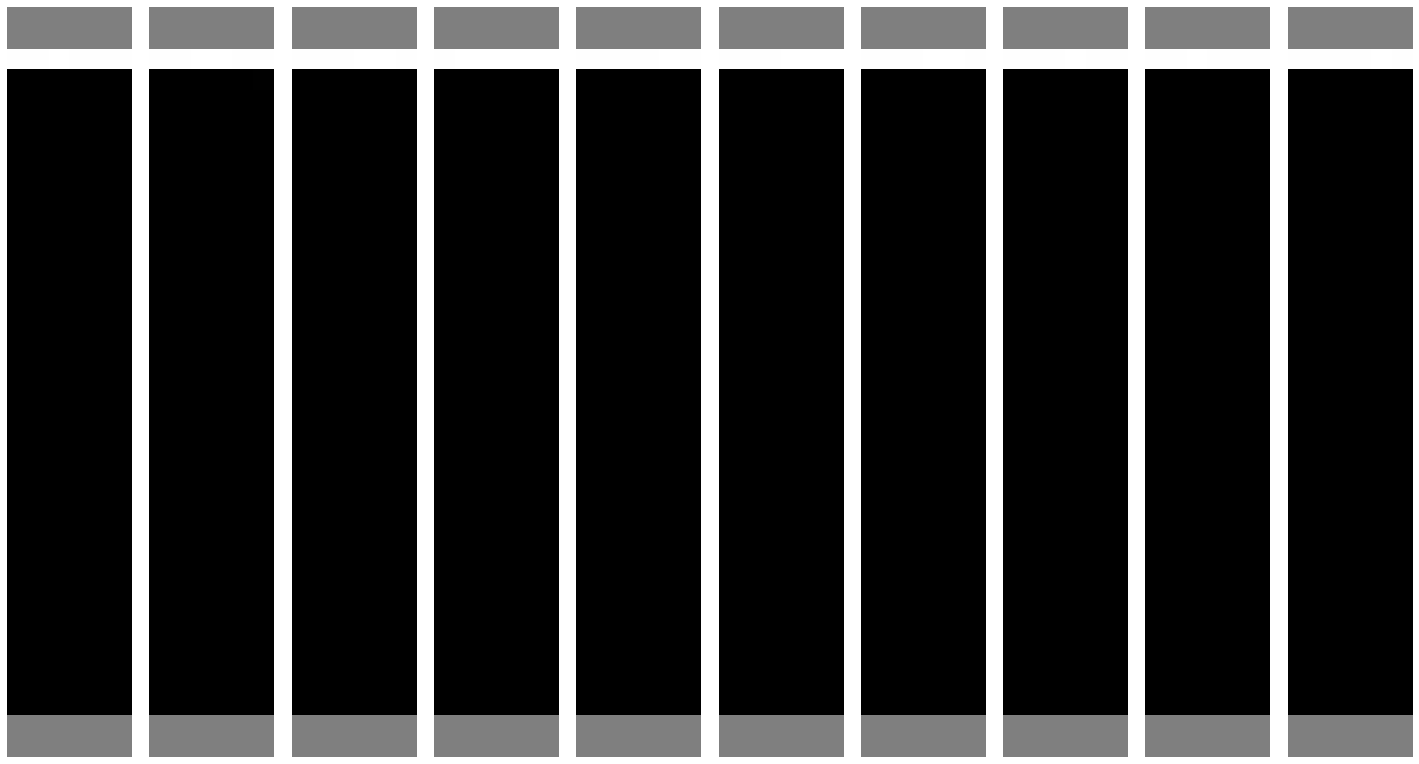

Epoch 167/200
8/8 - 1s - loss: 6.6100 - d_loss: 0.0012 - g_loss: 6.6088


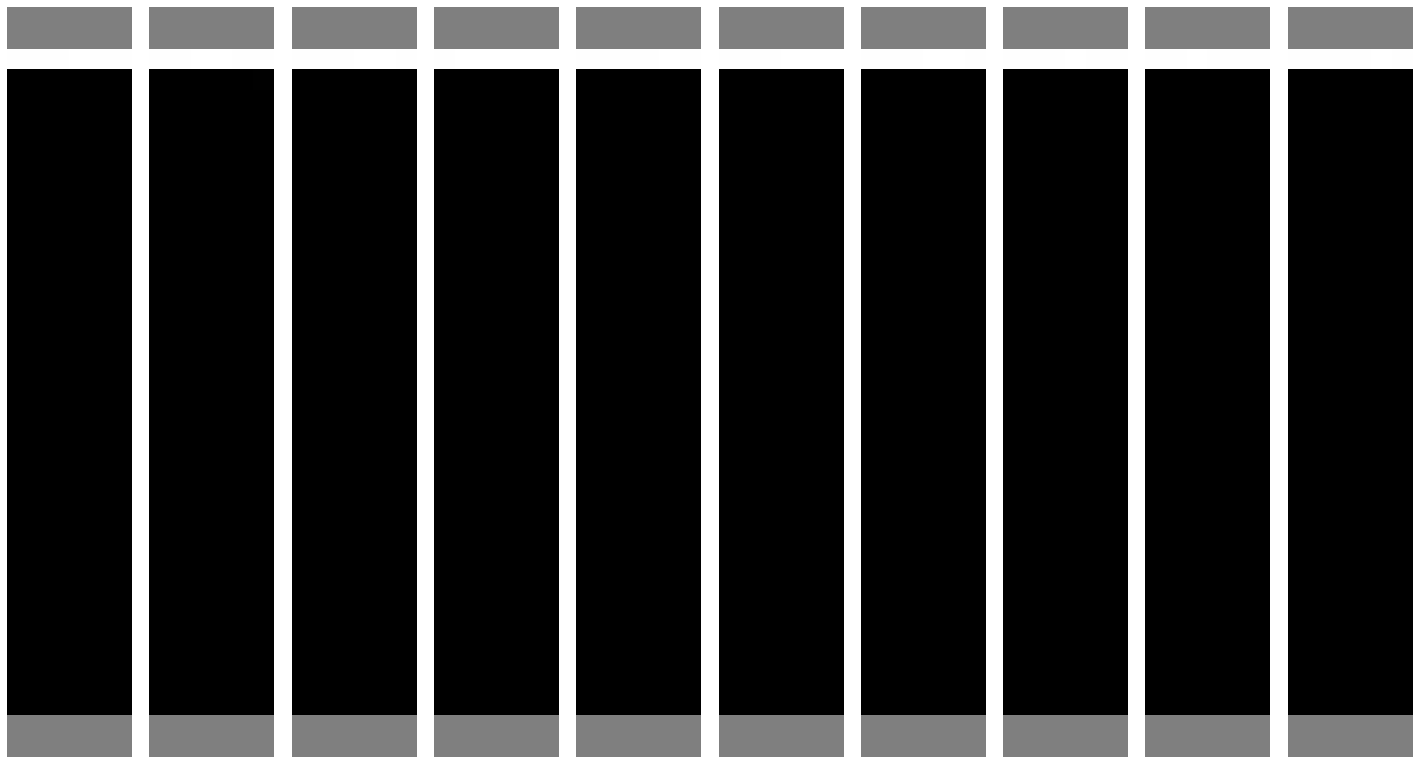

Epoch 168/200
8/8 - 1s - loss: 6.6242 - d_loss: 0.0012 - g_loss: 6.6229


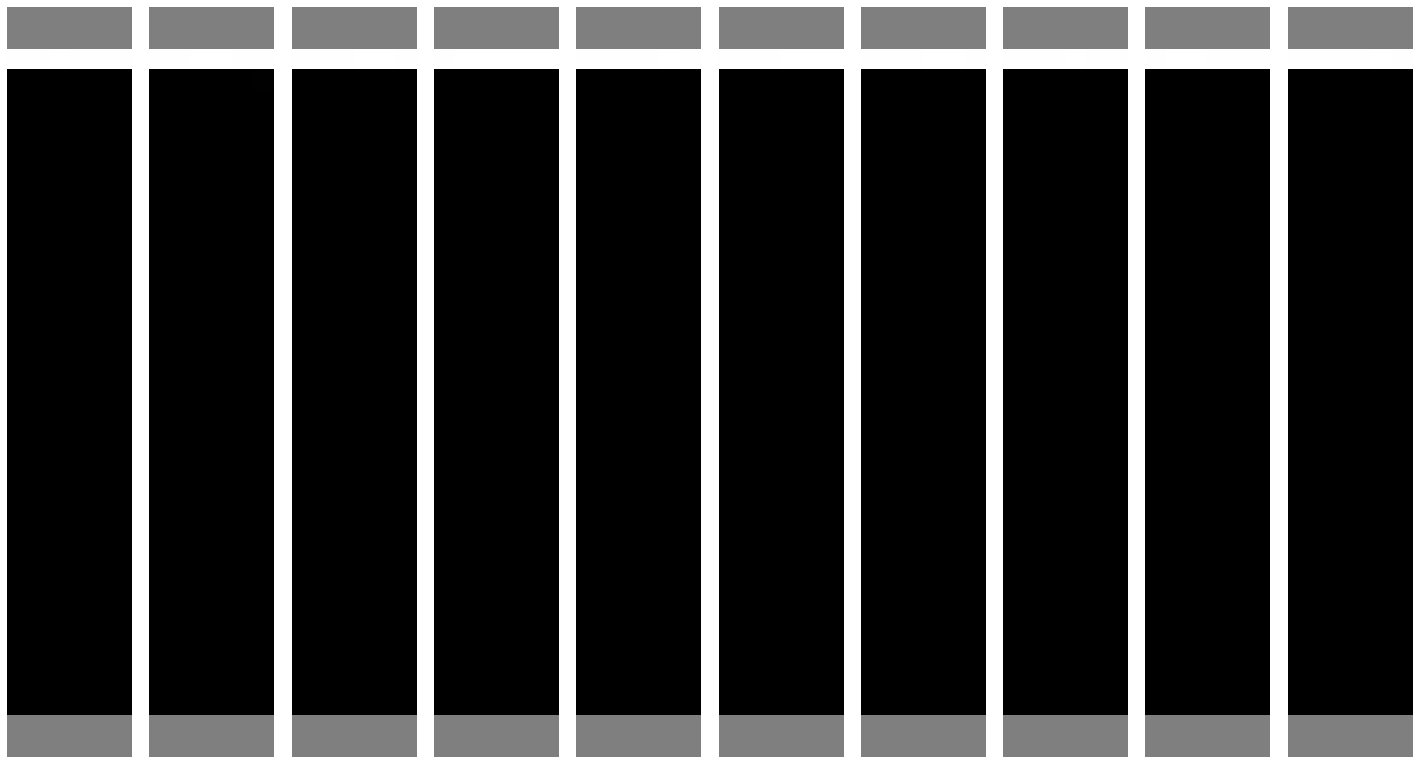

Epoch 169/200
8/8 - 1s - loss: 6.6399 - d_loss: 0.0012 - g_loss: 6.6387


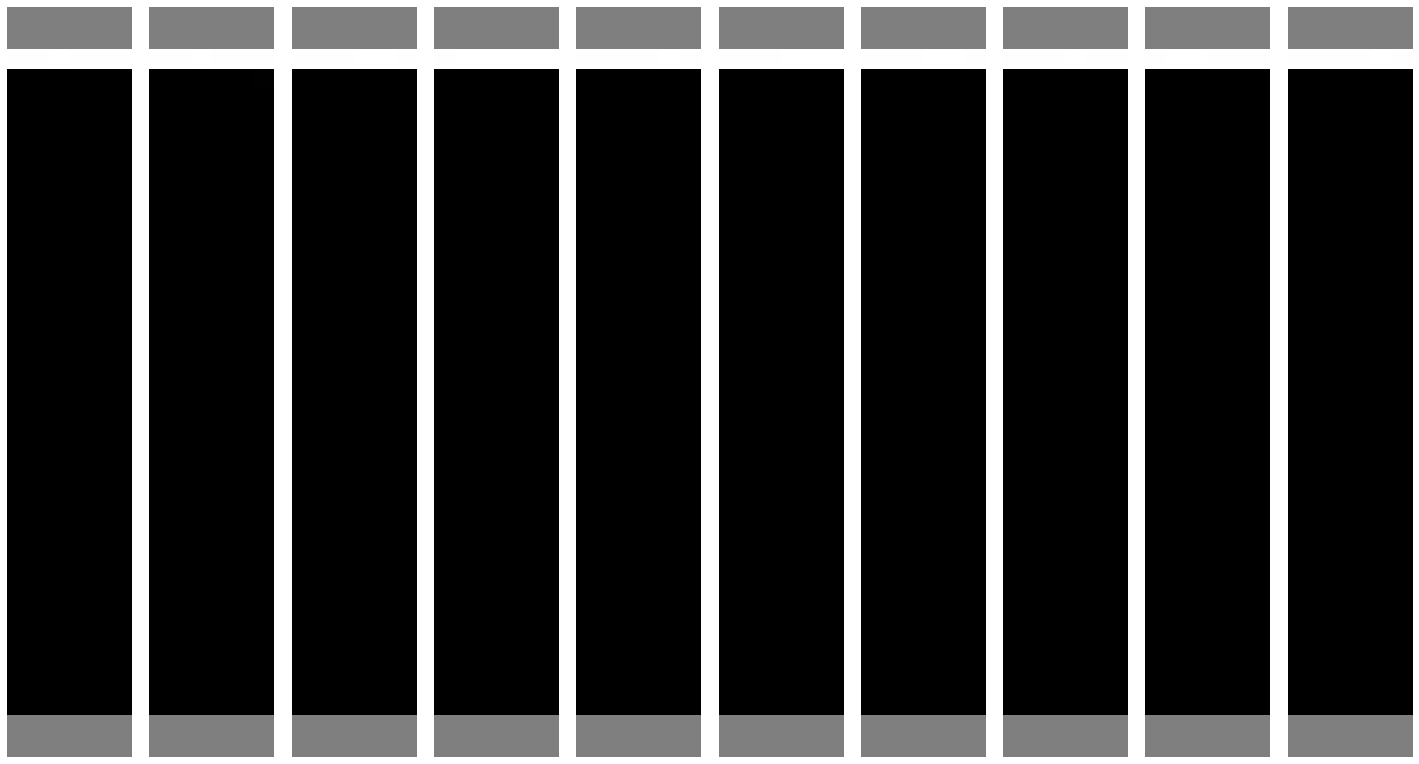

Epoch 170/200
8/8 - 1s - loss: 6.6552 - d_loss: 0.0012 - g_loss: 6.6540


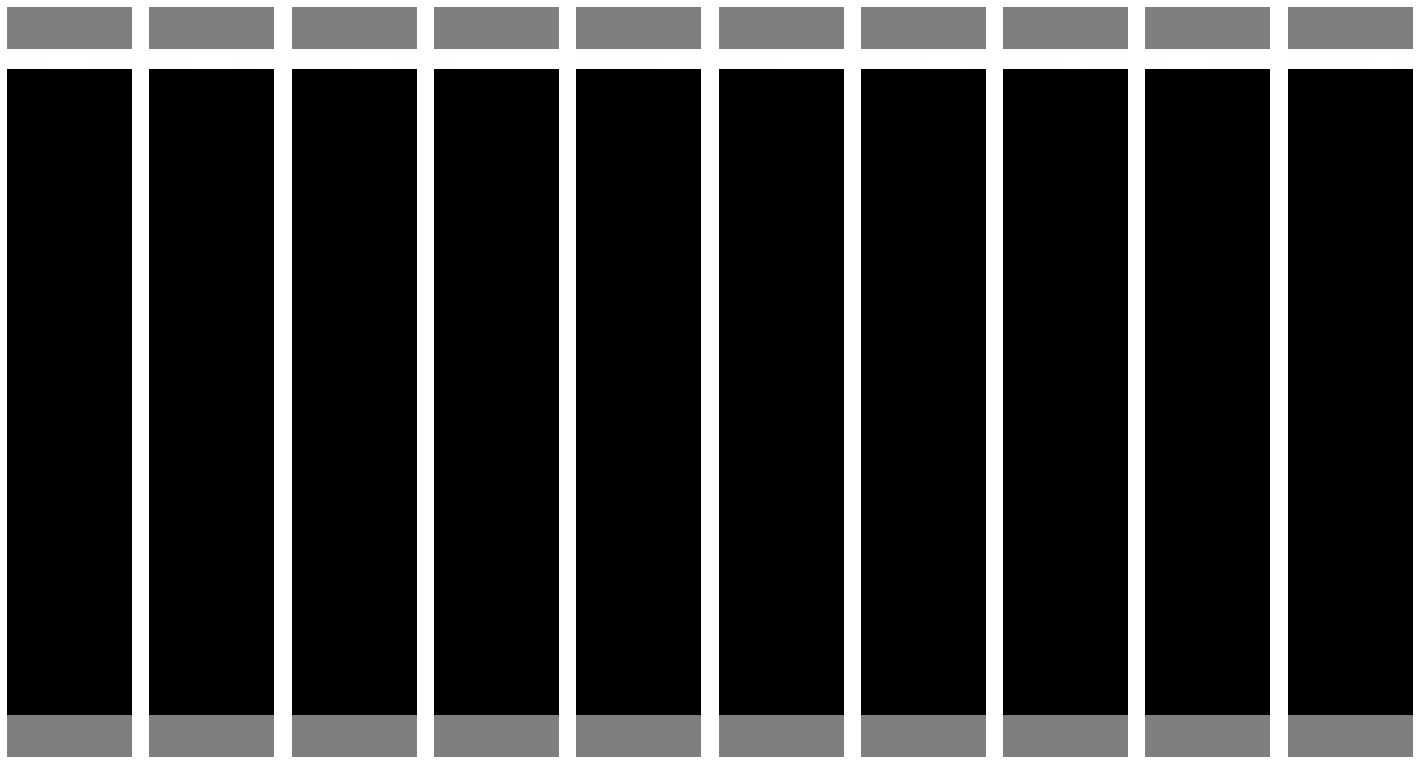

Epoch 171/200
8/8 - 1s - loss: 6.6707 - d_loss: 0.0012 - g_loss: 6.6695


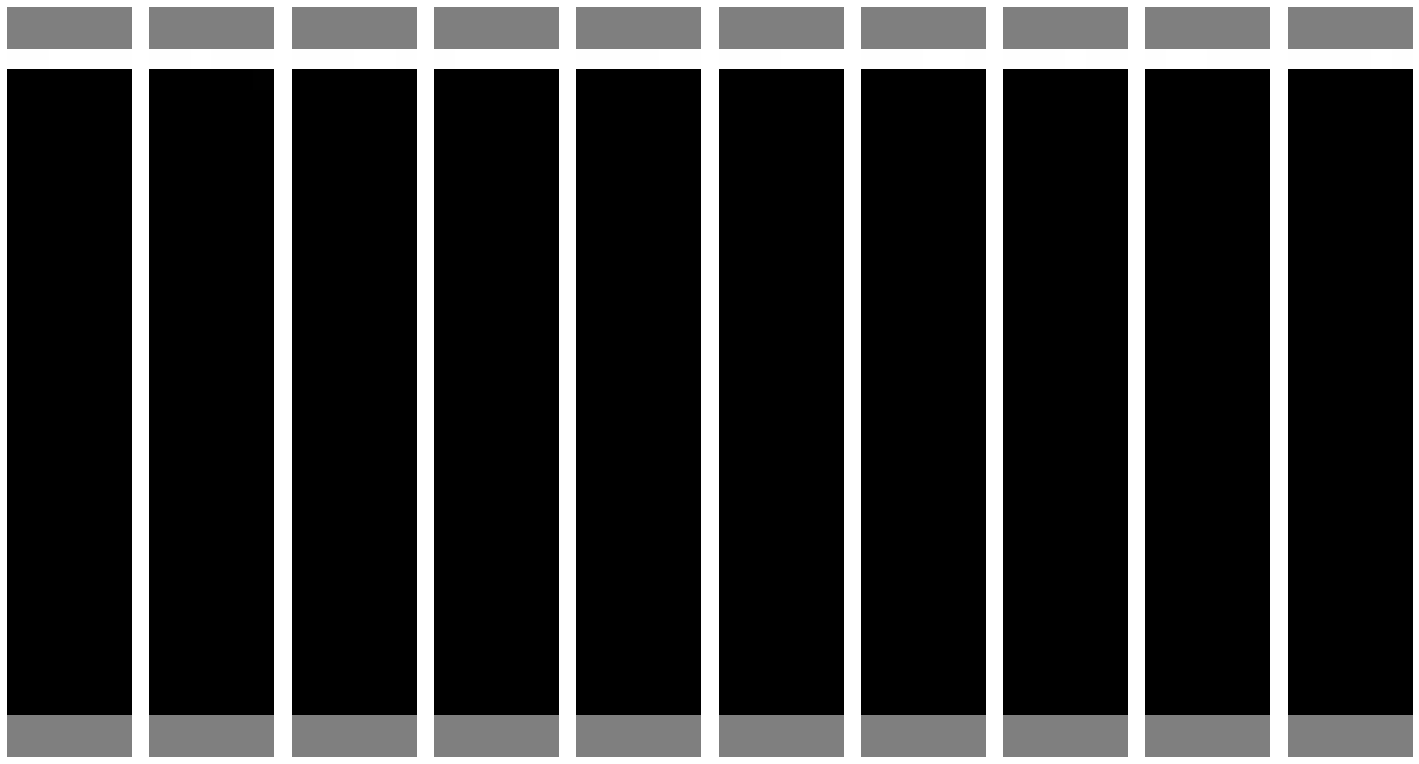

Epoch 172/200
8/8 - 1s - loss: 6.6816 - d_loss: 0.0011 - g_loss: 6.6804


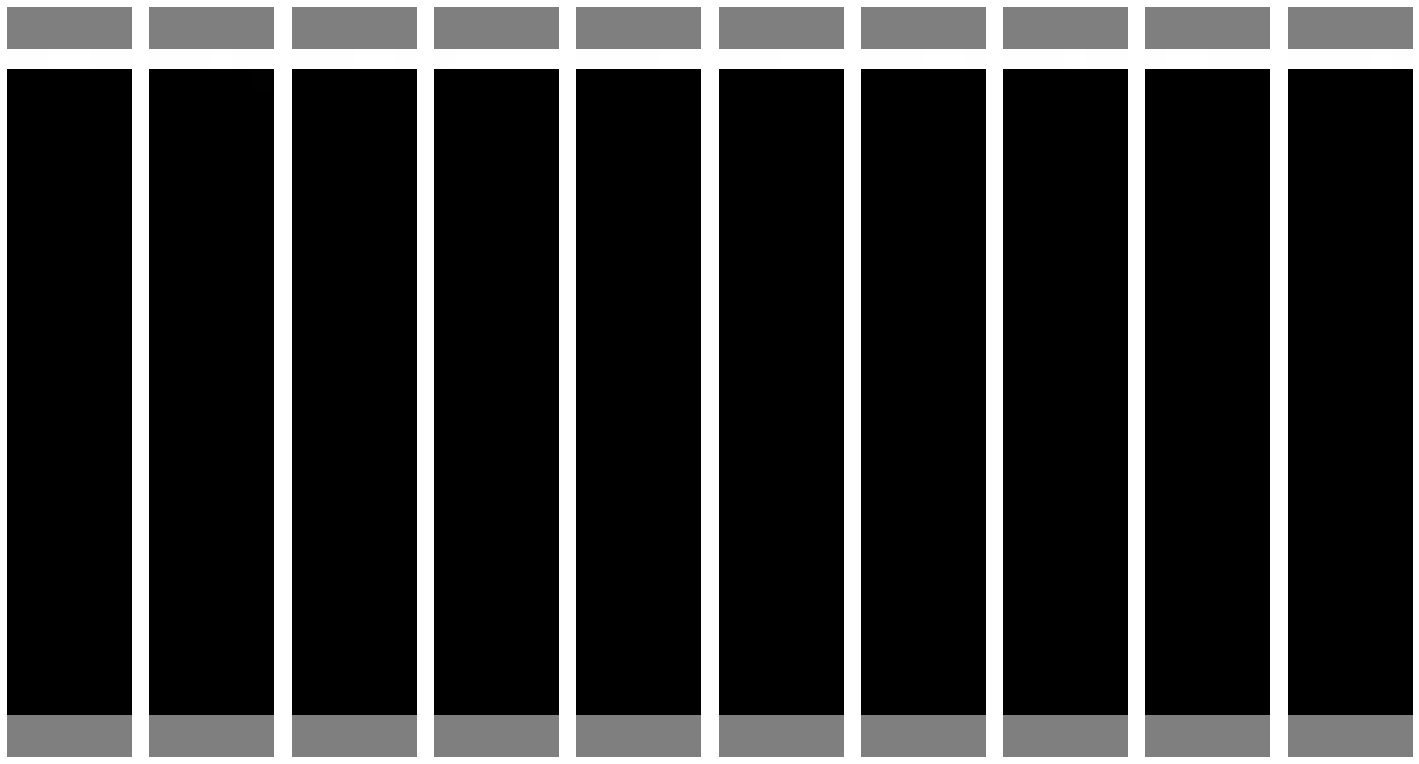

Epoch 173/200
8/8 - 1s - loss: 6.7053 - d_loss: 0.0011 - g_loss: 6.7042


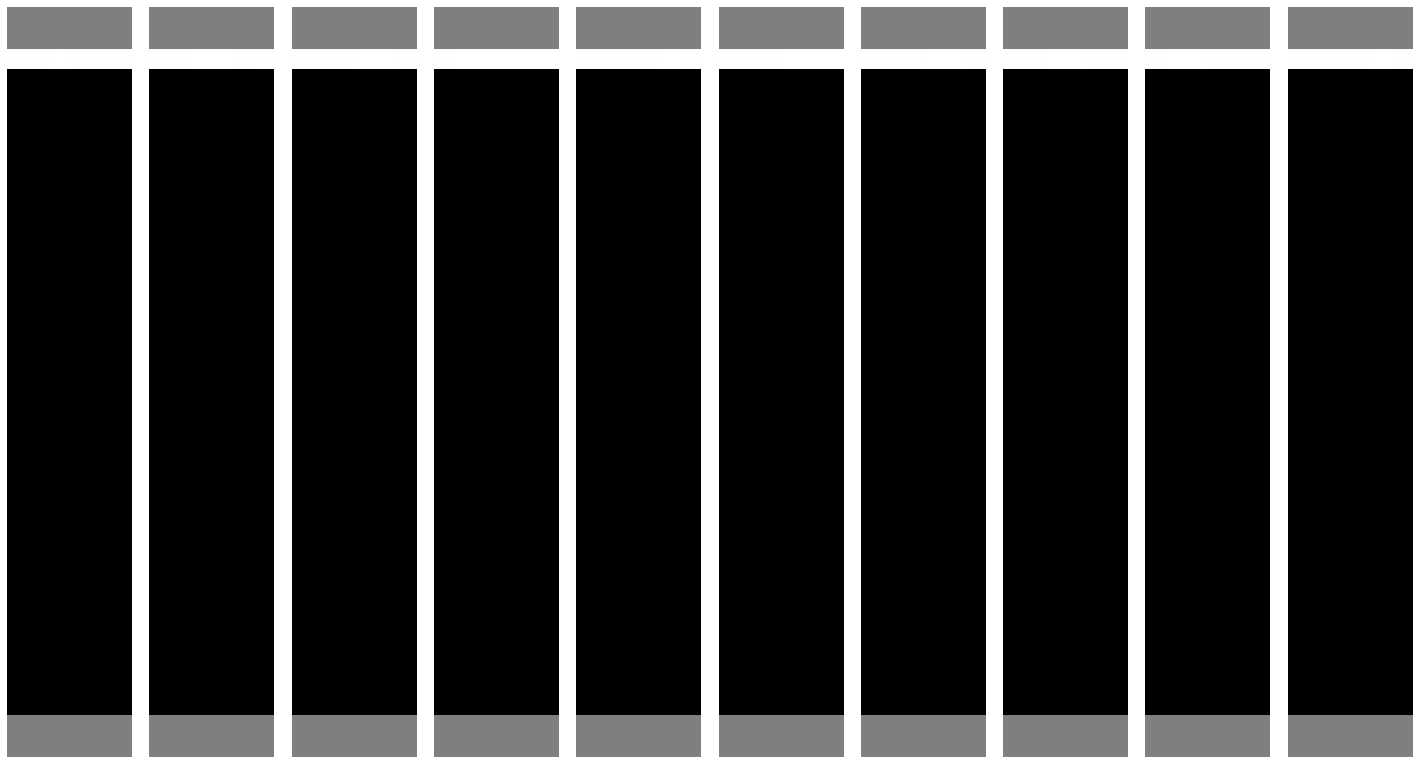

Epoch 174/200
8/8 - 1s - loss: 6.7246 - d_loss: 0.0011 - g_loss: 6.7235


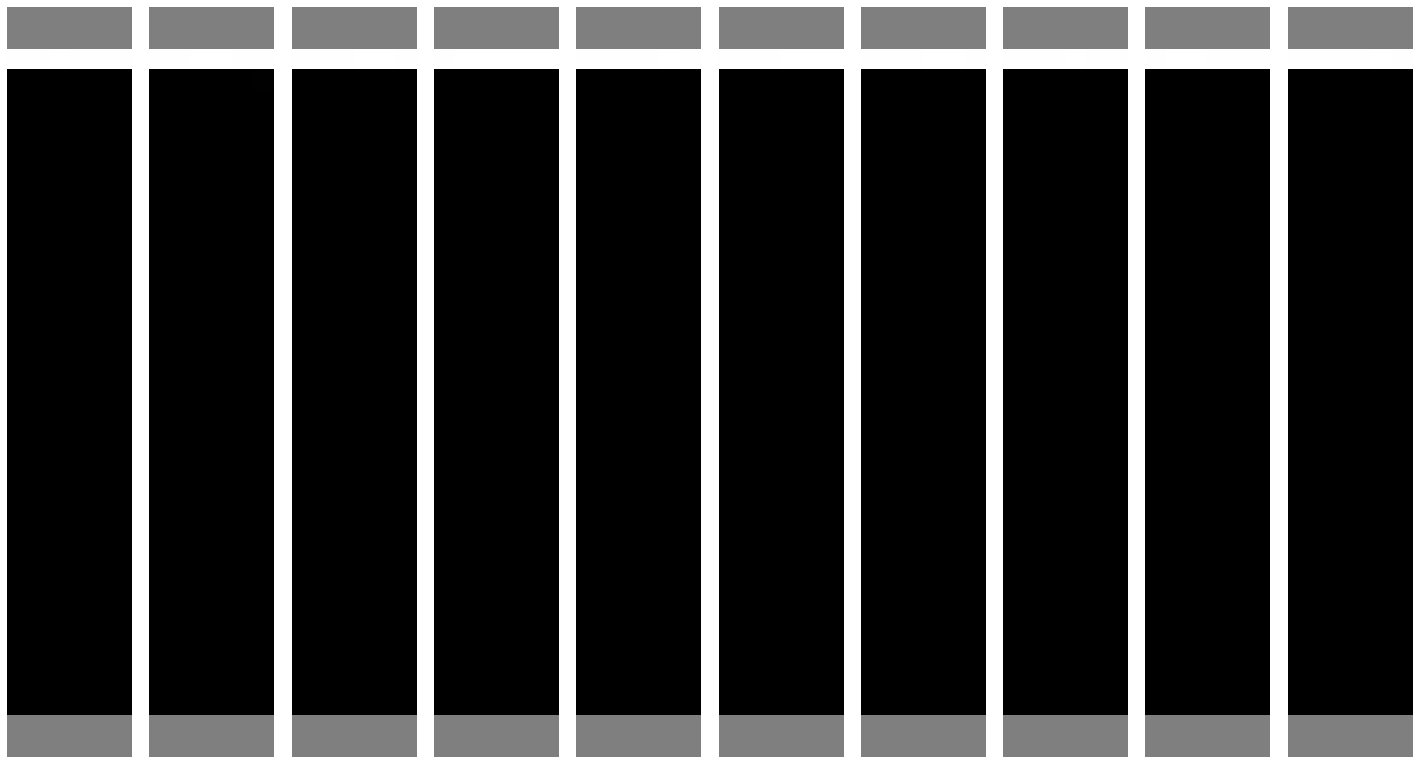

Epoch 175/200
8/8 - 1s - loss: 6.7429 - d_loss: 0.0011 - g_loss: 6.7419


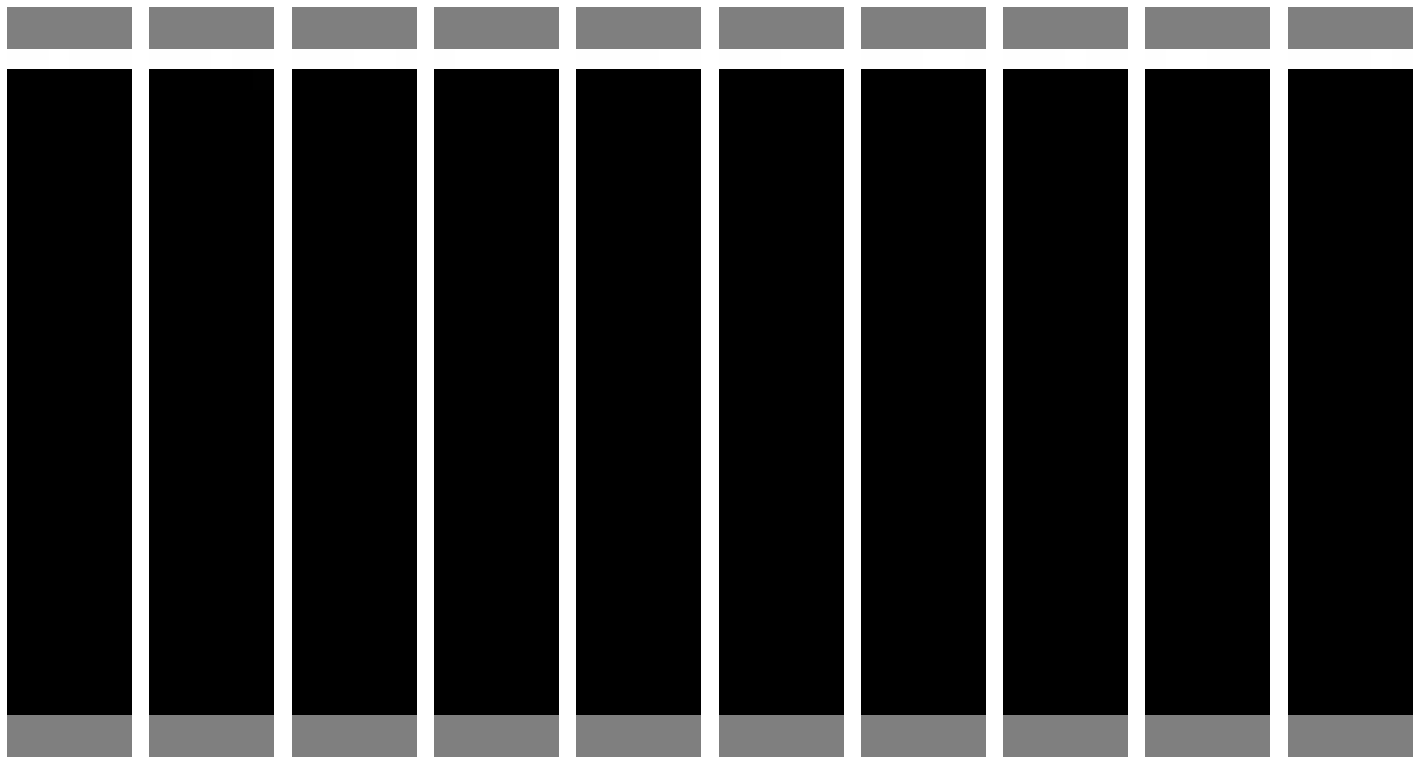

Epoch 176/200
8/8 - 1s - loss: 6.7595 - d_loss: 0.0011 - g_loss: 6.7584


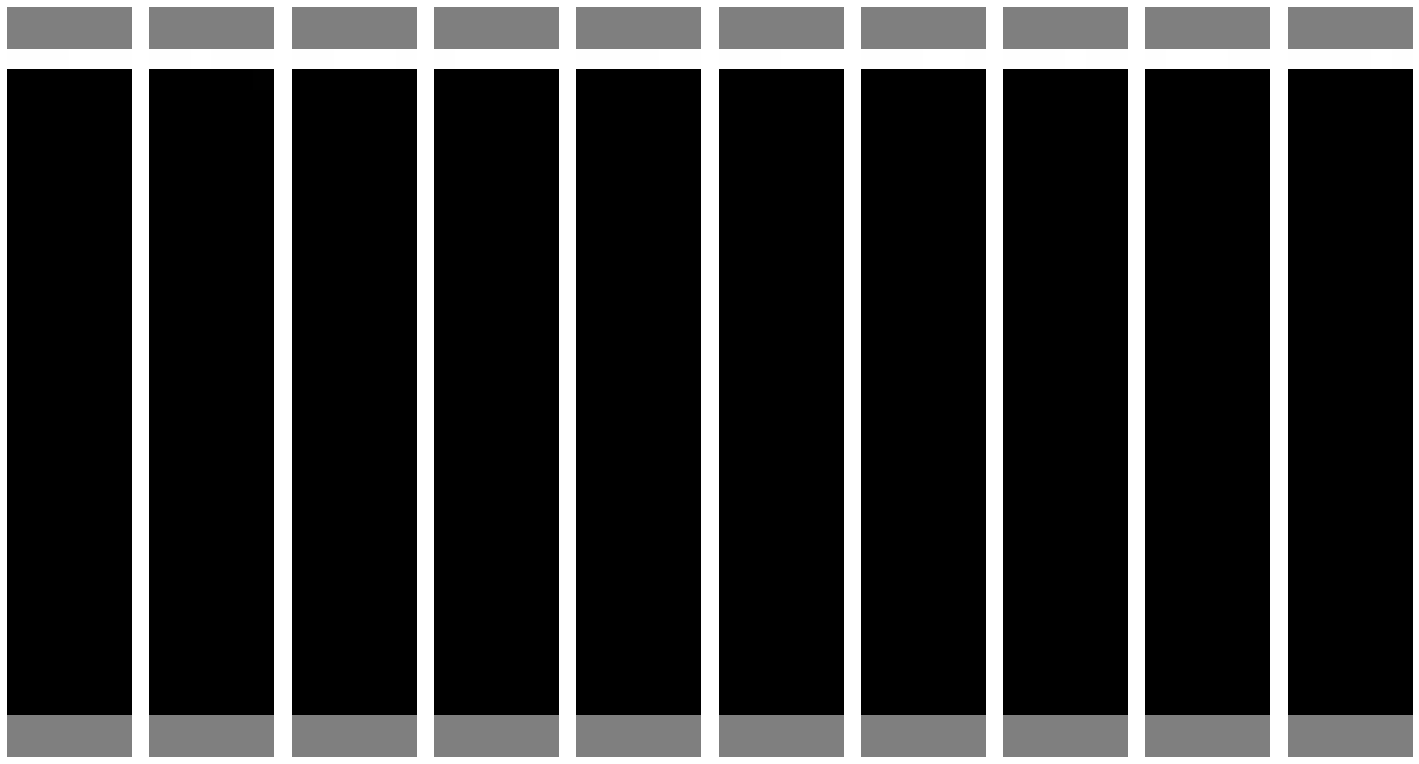

Epoch 177/200
8/8 - 1s - loss: 6.7853 - d_loss: 0.0011 - g_loss: 6.7843


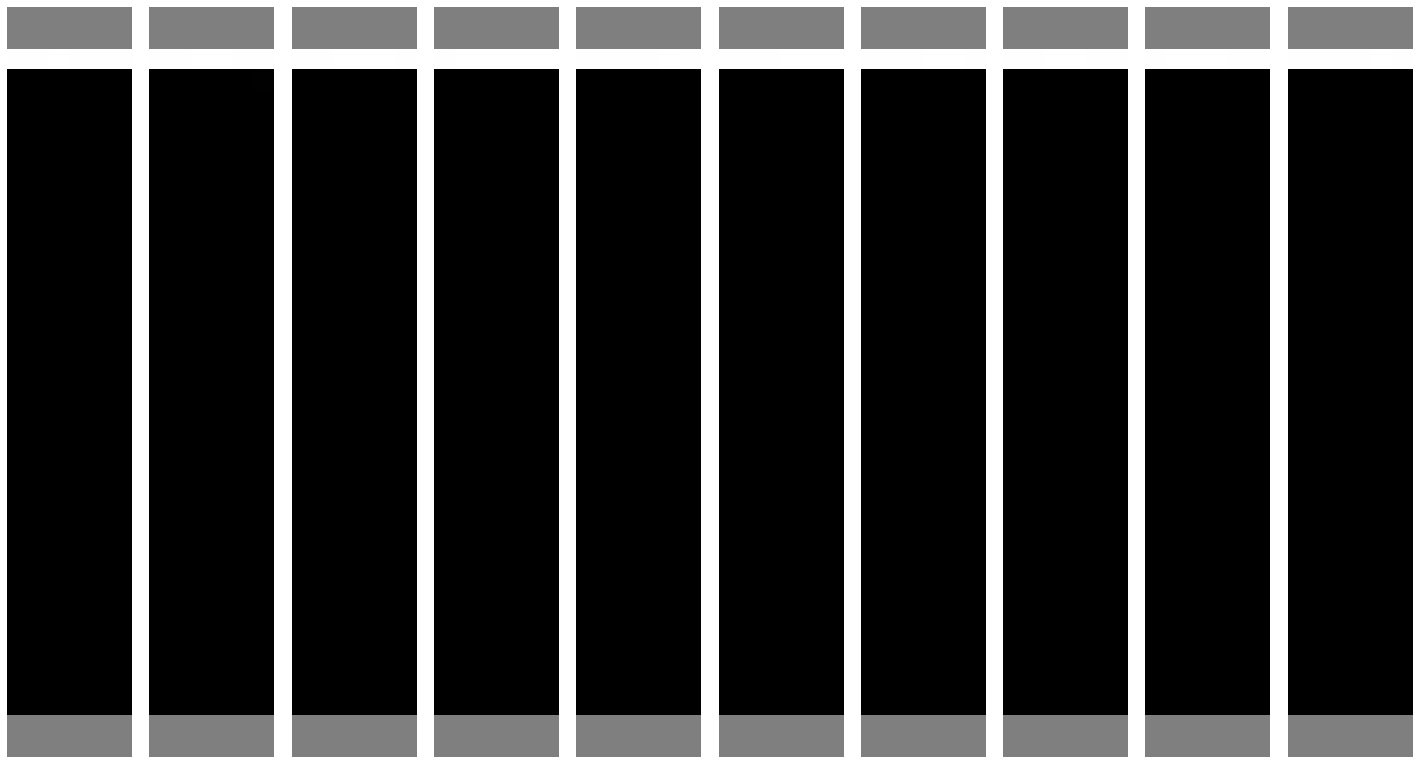

Epoch 178/200
8/8 - 1s - loss: 6.8018 - d_loss: 0.0010 - g_loss: 6.8008


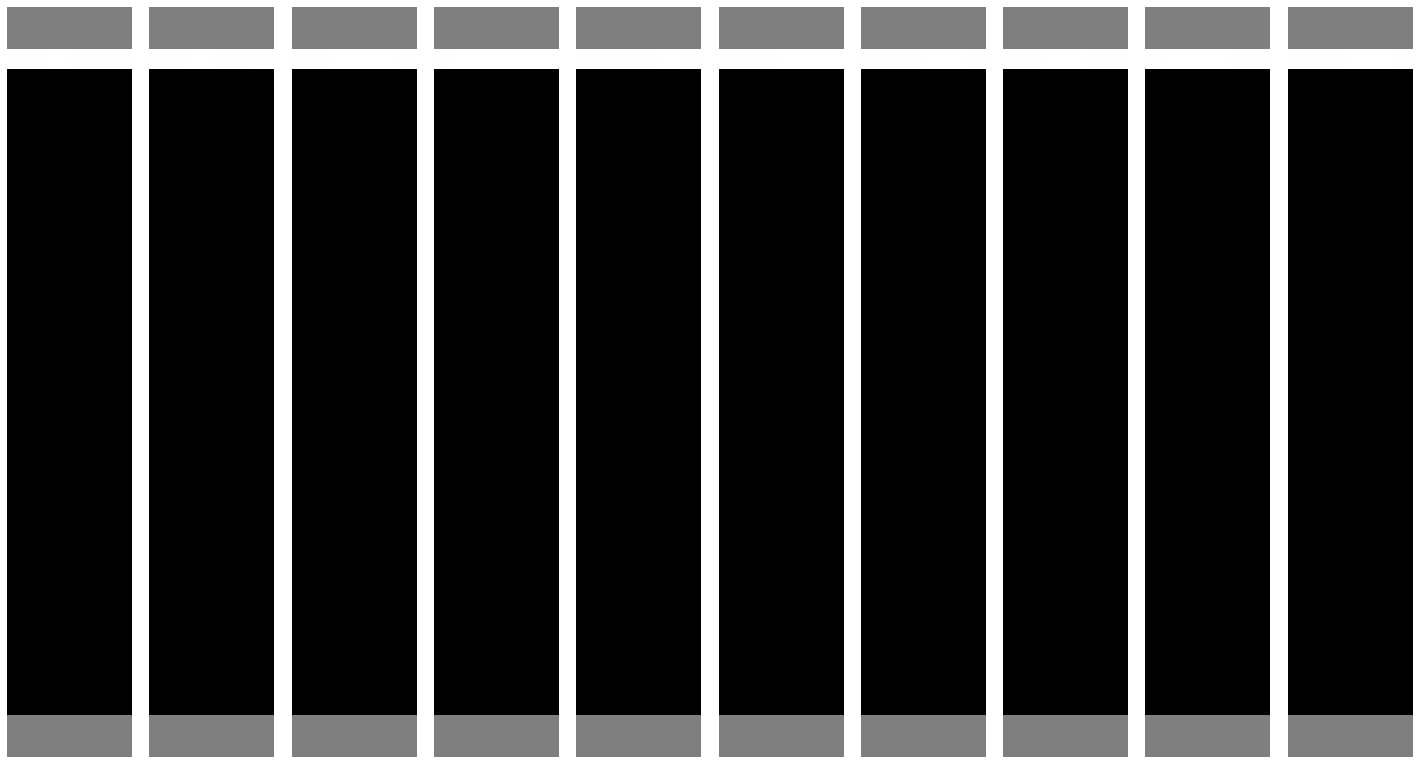

Epoch 179/200
8/8 - 1s - loss: 6.8126 - d_loss: 0.0010 - g_loss: 6.8116


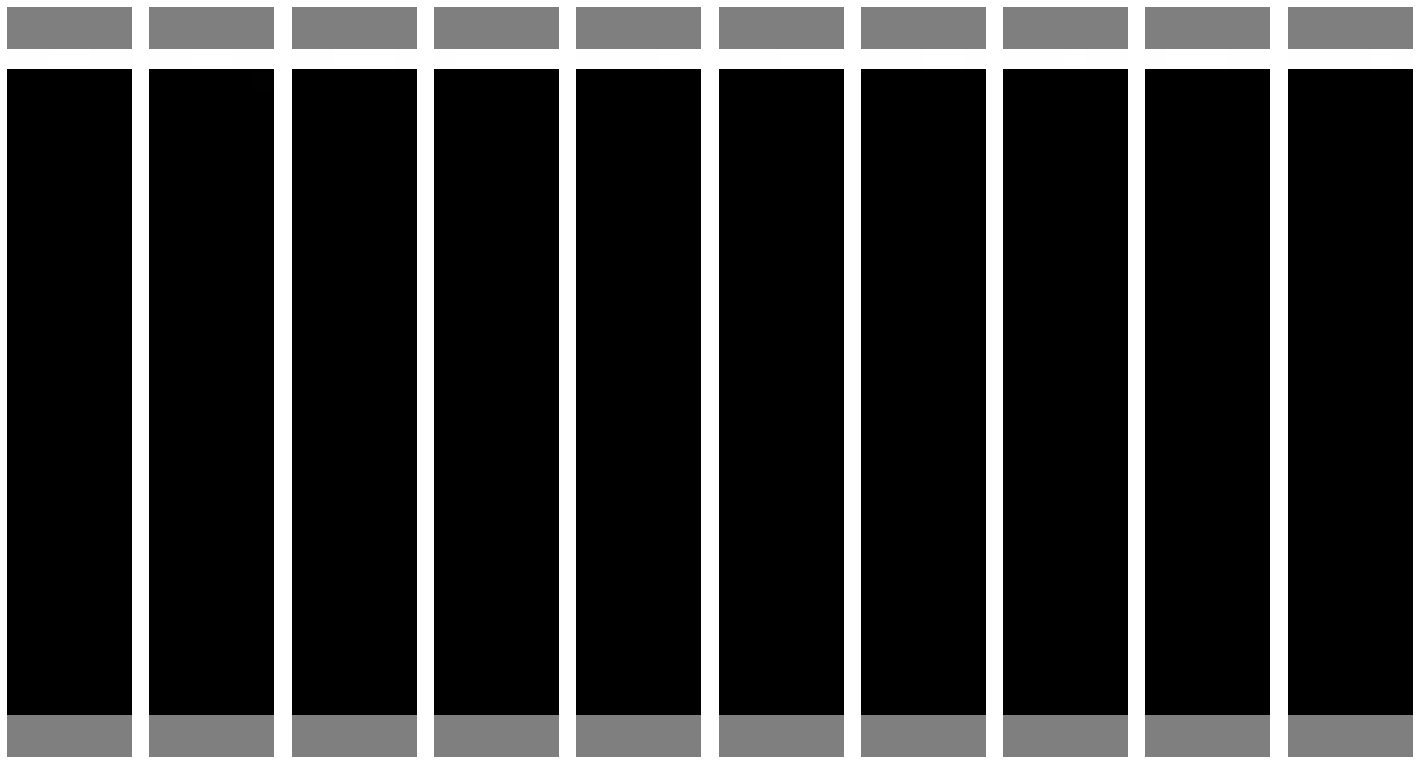

Epoch 180/200
8/8 - 1s - loss: 6.8291 - d_loss: 9.8281e-04 - g_loss: 6.8281


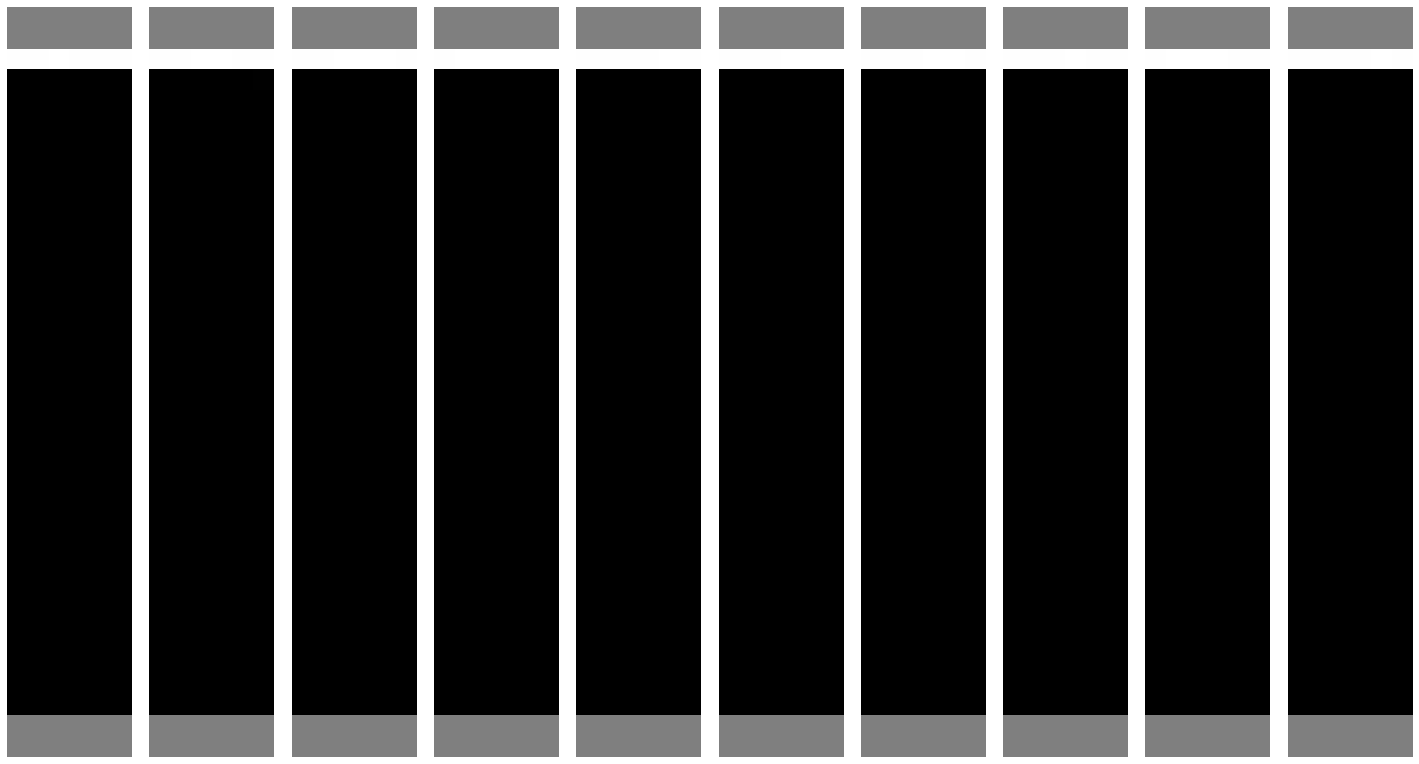

Epoch 181/200
8/8 - 1s - loss: 6.8435 - d_loss: 9.7019e-04 - g_loss: 6.8425


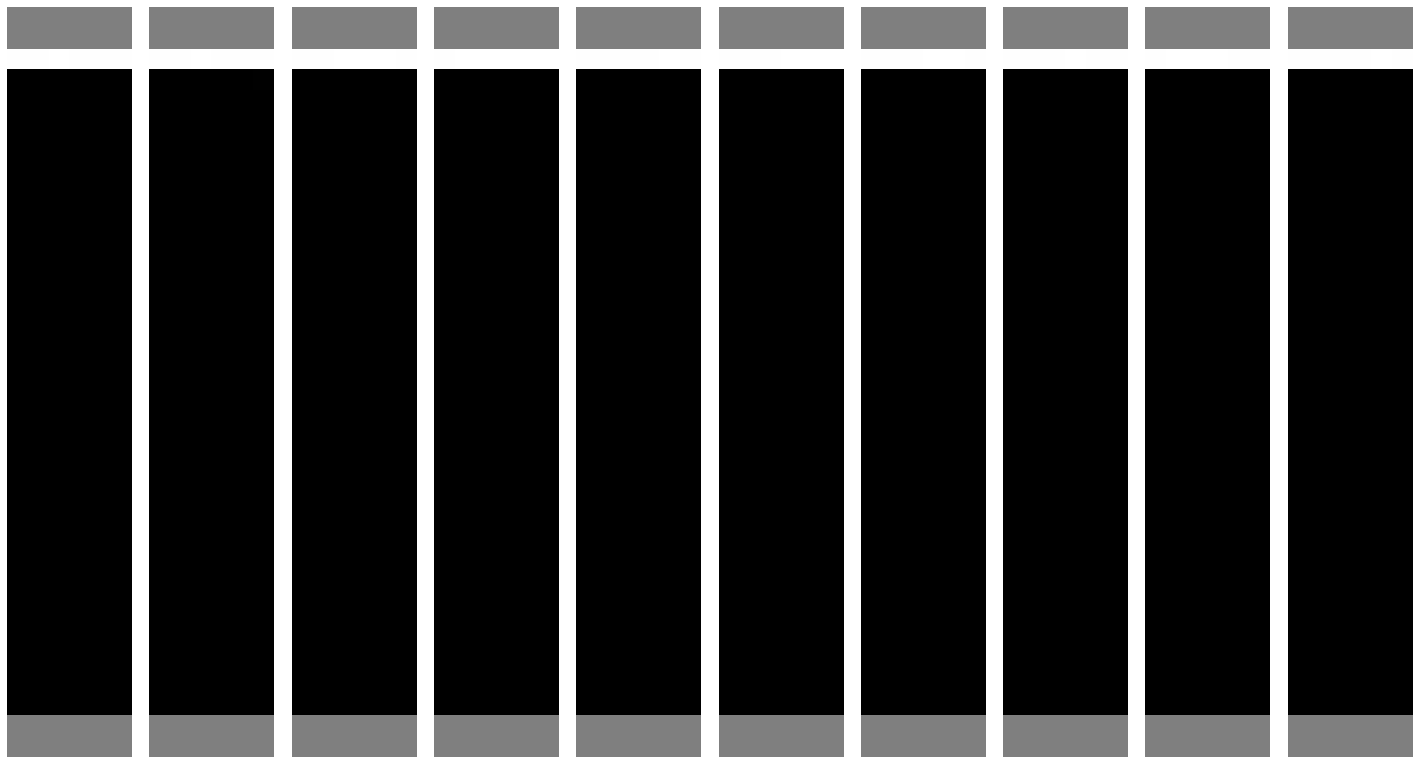

Epoch 182/200
8/8 - 1s - loss: 6.8633 - d_loss: 9.7265e-04 - g_loss: 6.8623


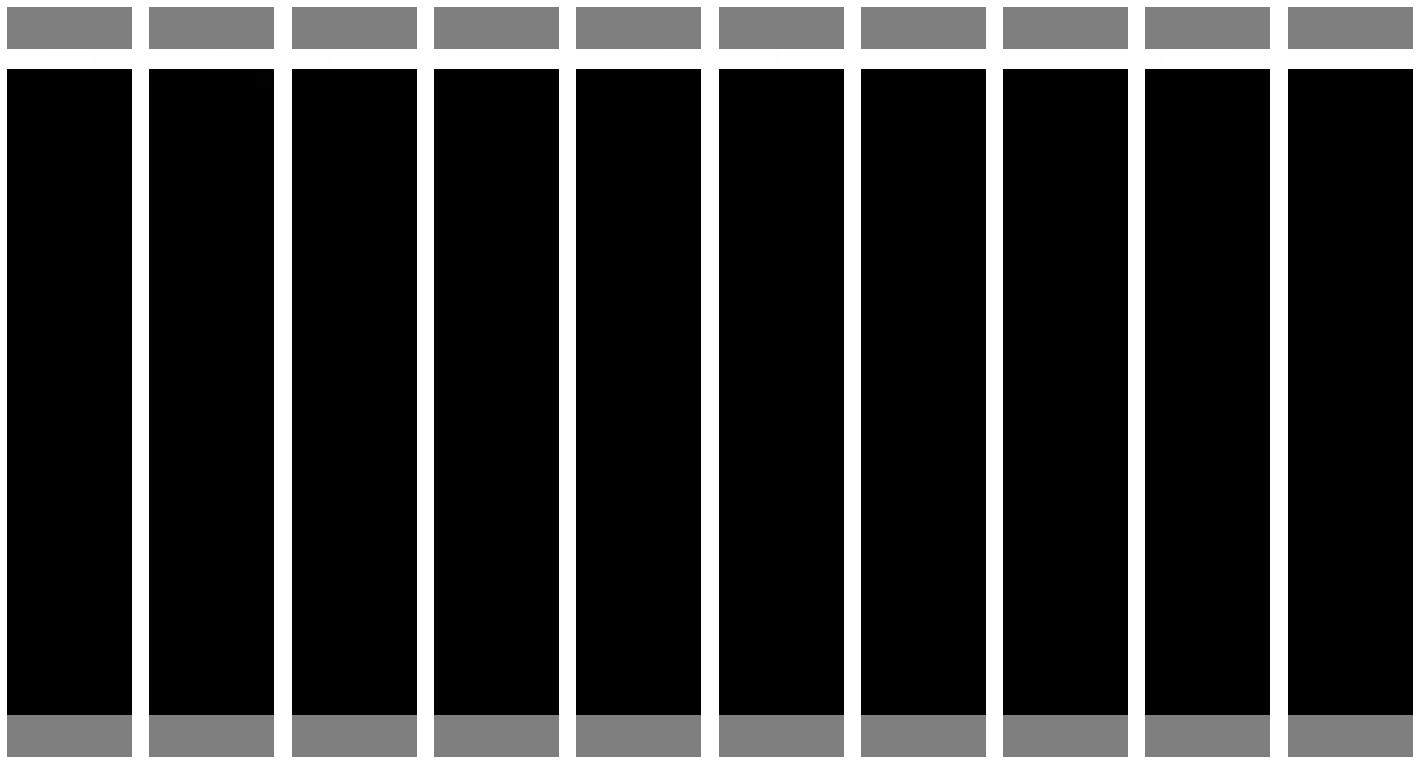

Epoch 183/200
8/8 - 1s - loss: 6.8815 - d_loss: 9.4638e-04 - g_loss: 6.8806


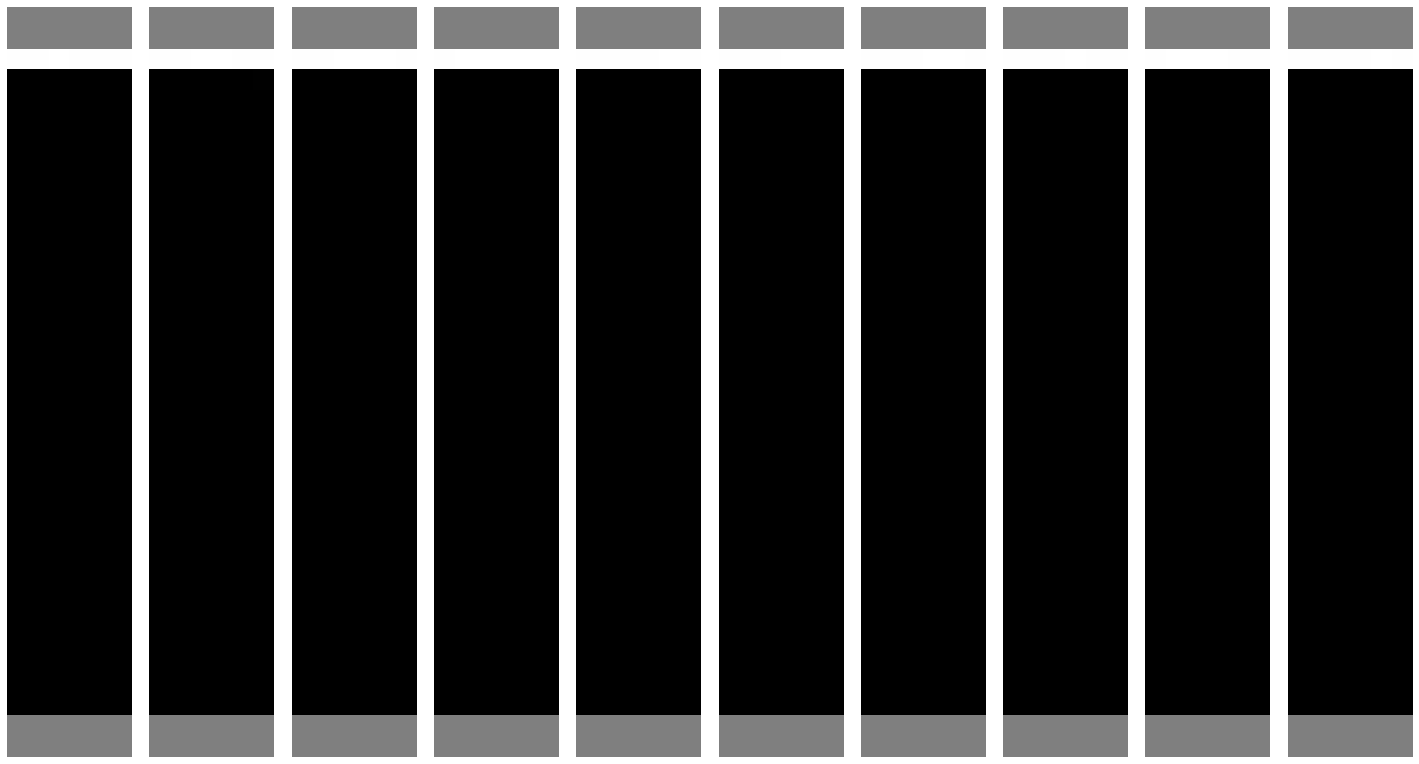

Epoch 184/200
8/8 - 1s - loss: 6.8962 - d_loss: 9.2245e-04 - g_loss: 6.8953


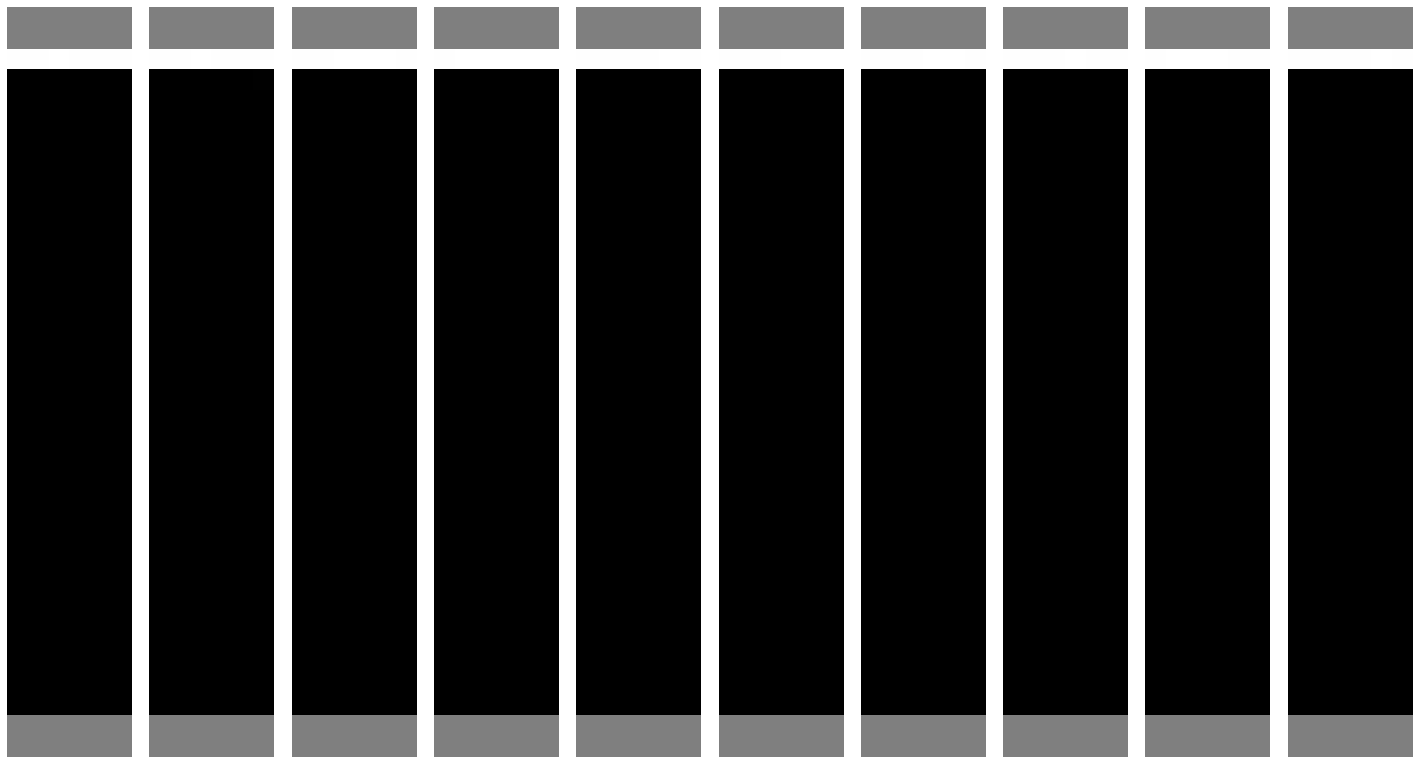

Epoch 185/200
8/8 - 1s - loss: 6.9118 - d_loss: 9.1236e-04 - g_loss: 6.9109


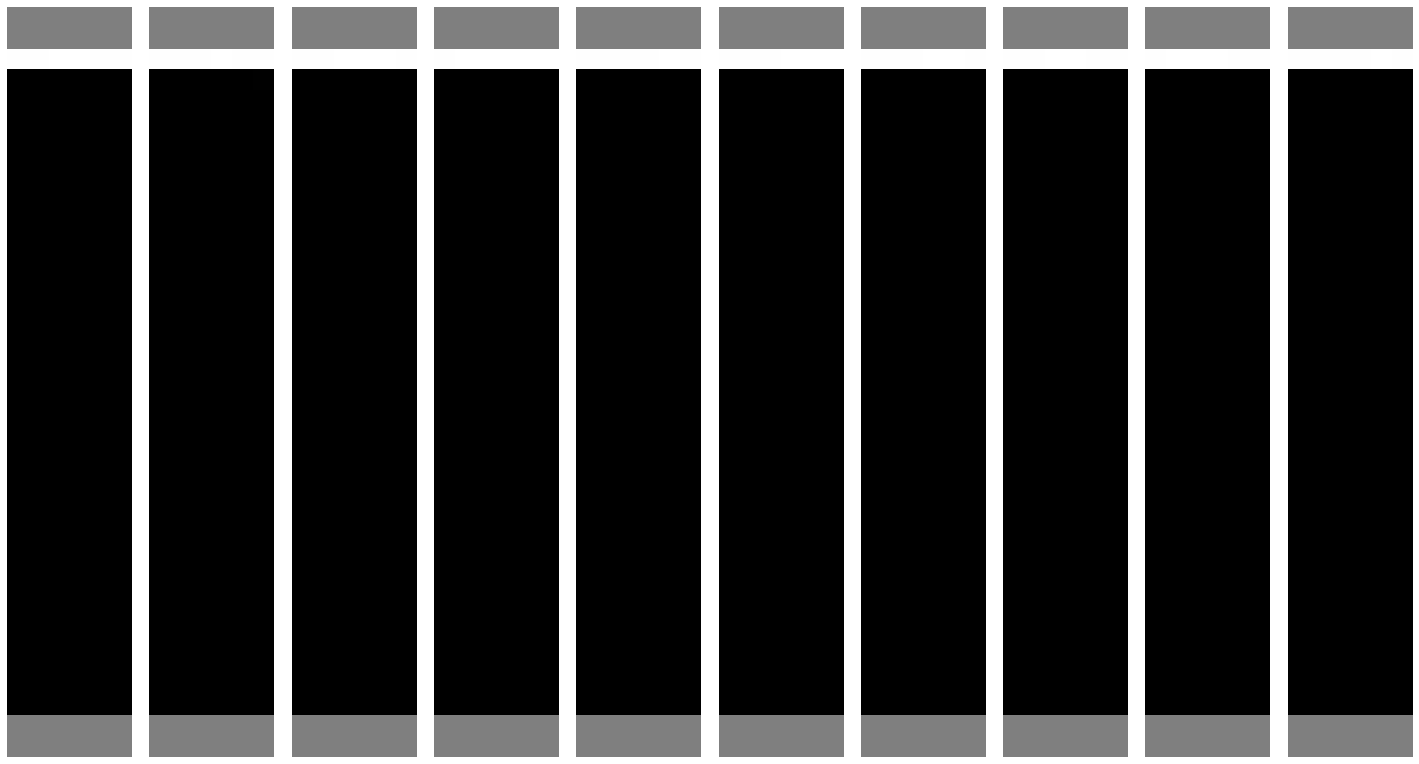

Epoch 186/200
8/8 - 1s - loss: 6.9253 - d_loss: 9.0567e-04 - g_loss: 6.9244


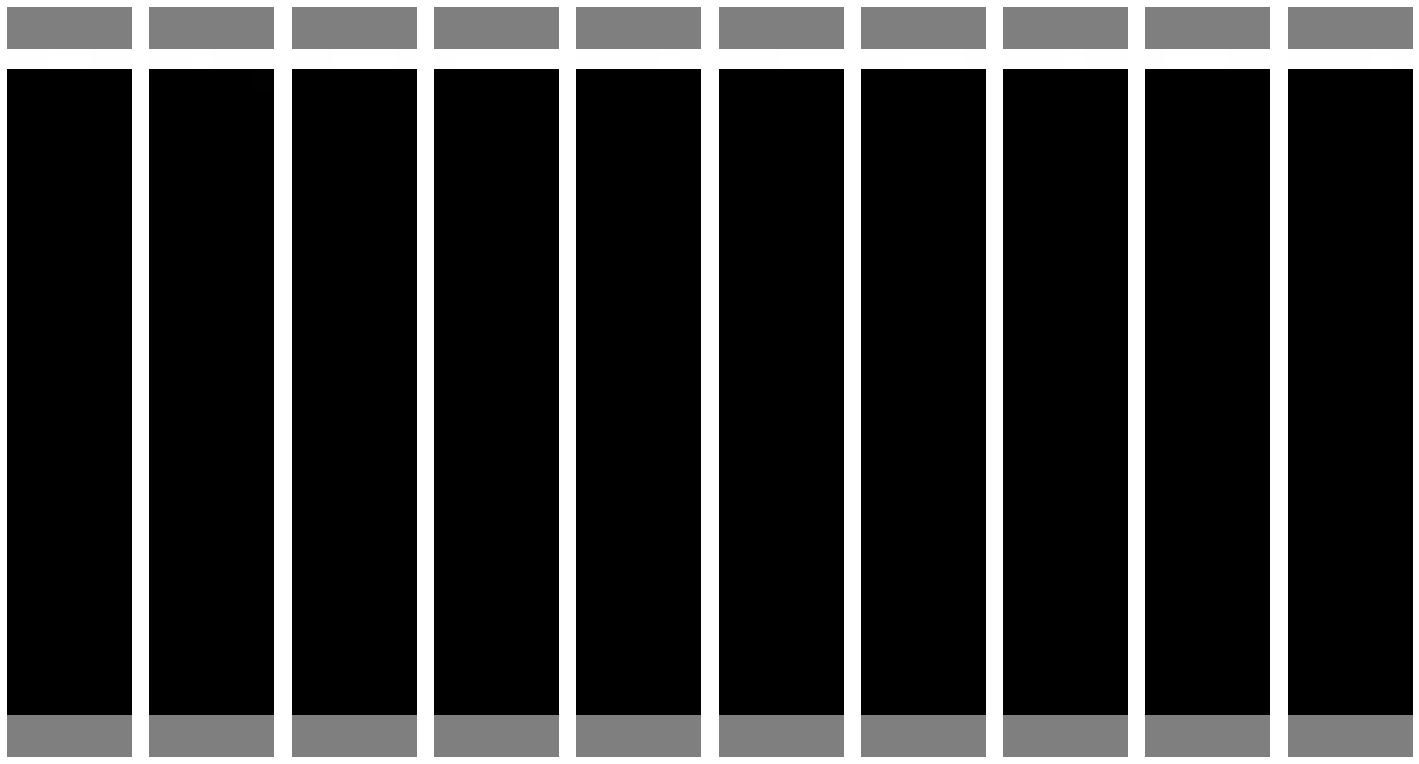

Epoch 187/200
8/8 - 1s - loss: 6.9454 - d_loss: 8.9863e-04 - g_loss: 6.9445


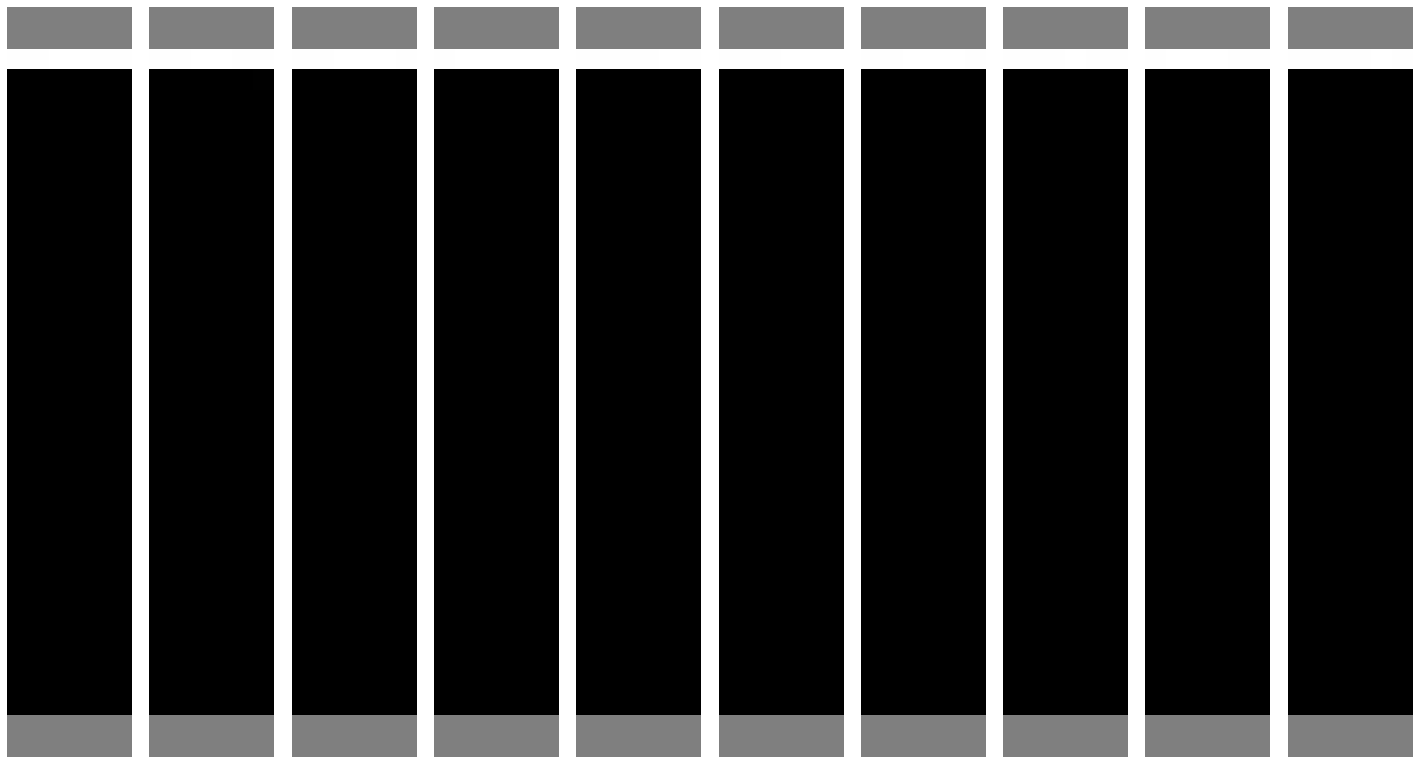

Epoch 188/200
8/8 - 1s - loss: 6.9572 - d_loss: 8.7468e-04 - g_loss: 6.9563


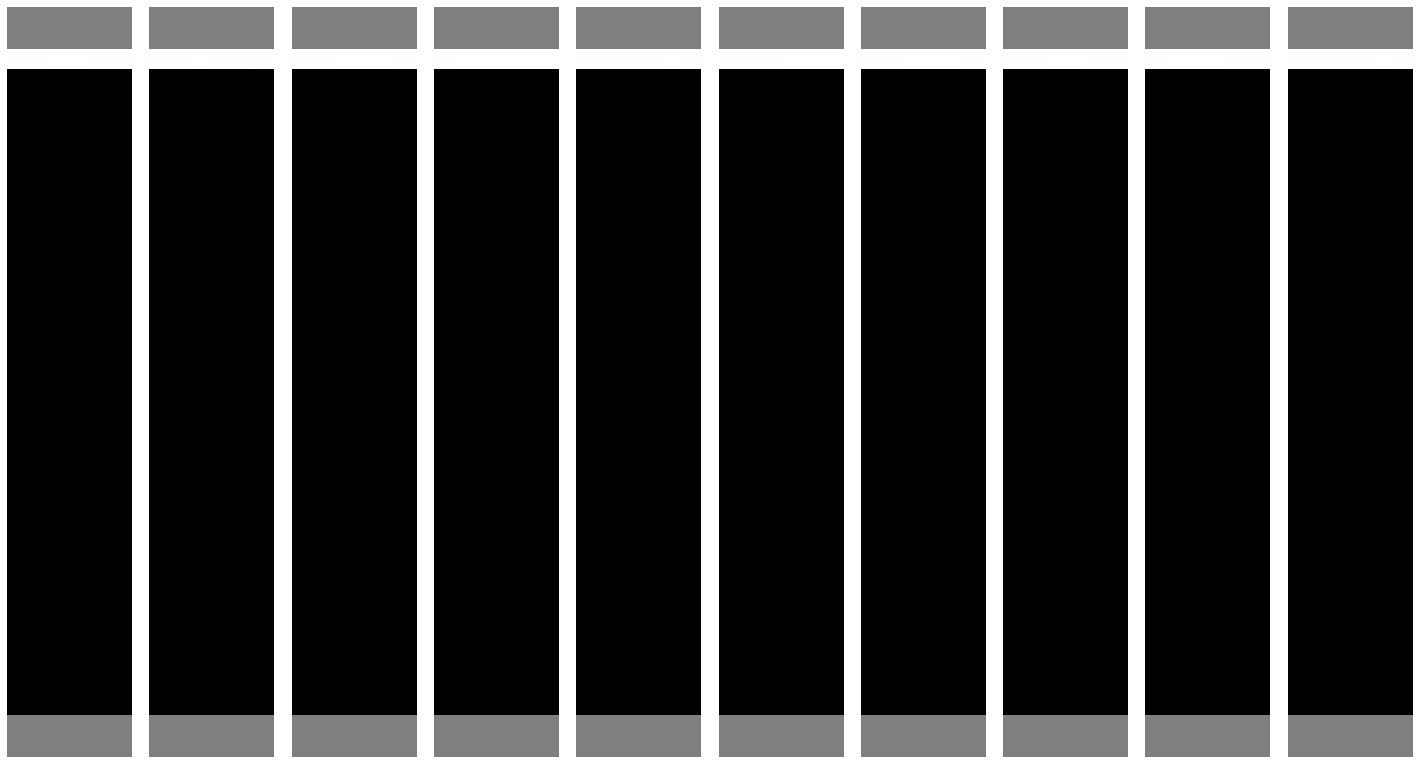

Epoch 189/200
8/8 - 1s - loss: 6.9764 - d_loss: 8.6086e-04 - g_loss: 6.9755


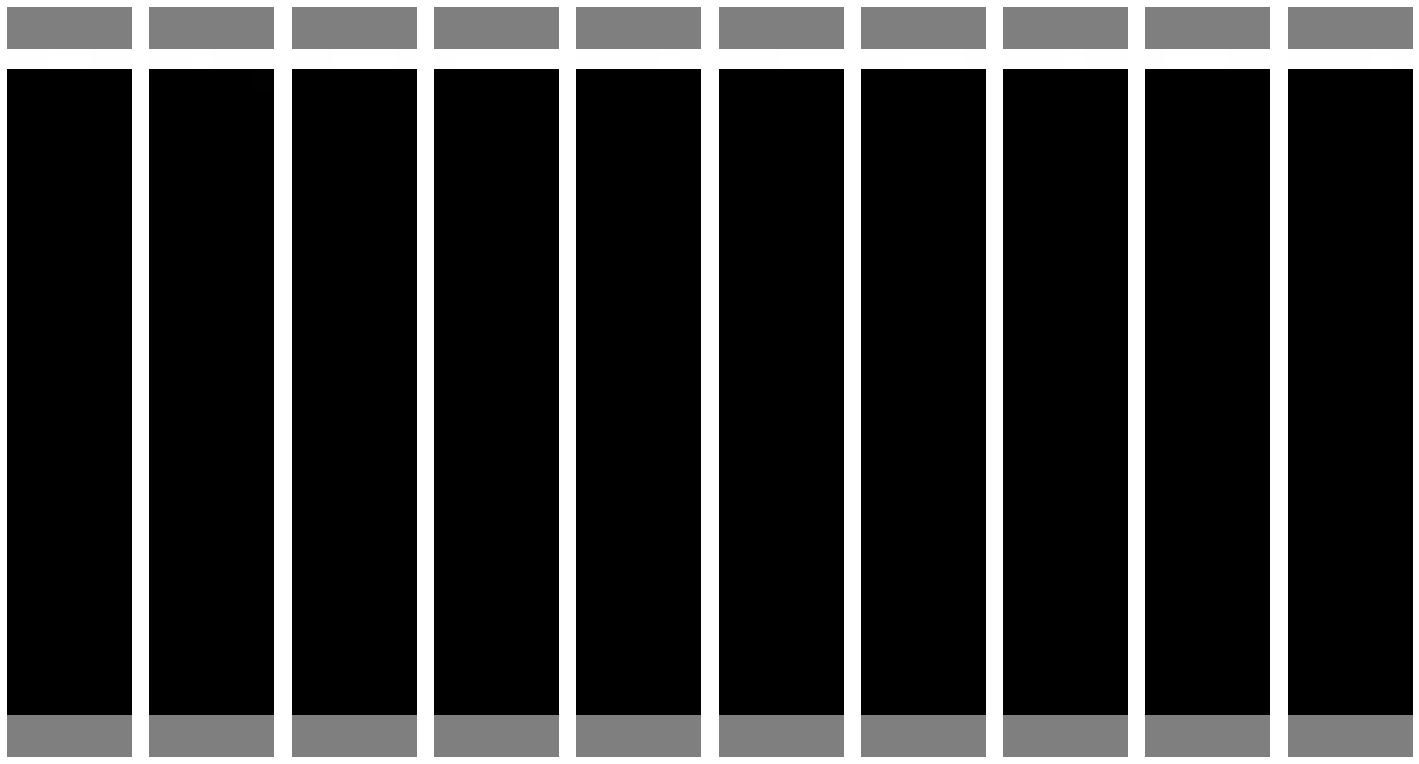

Epoch 190/200
8/8 - 1s - loss: 6.9918 - d_loss: 8.4520e-04 - g_loss: 6.9909


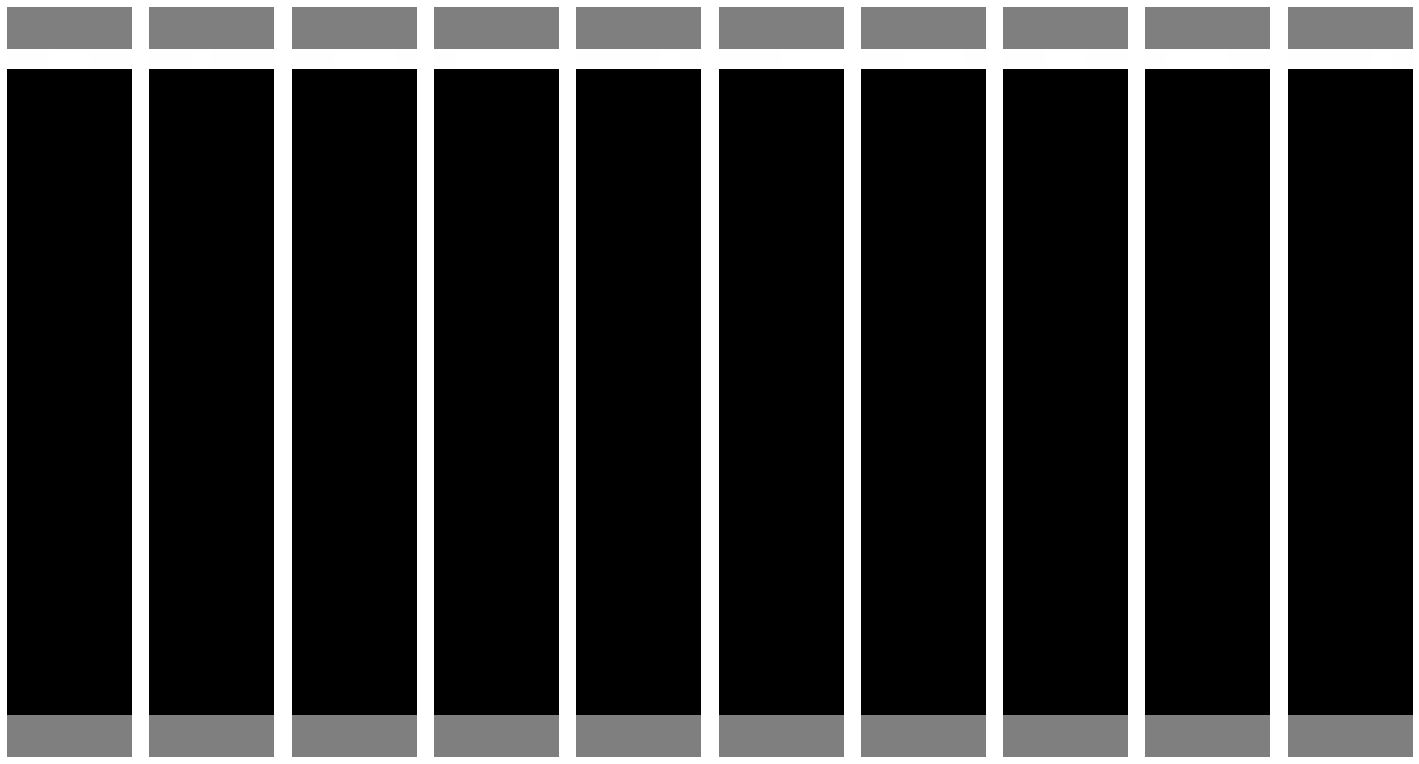

Epoch 191/200
8/8 - 1s - loss: 7.0114 - d_loss: 8.4675e-04 - g_loss: 7.0105


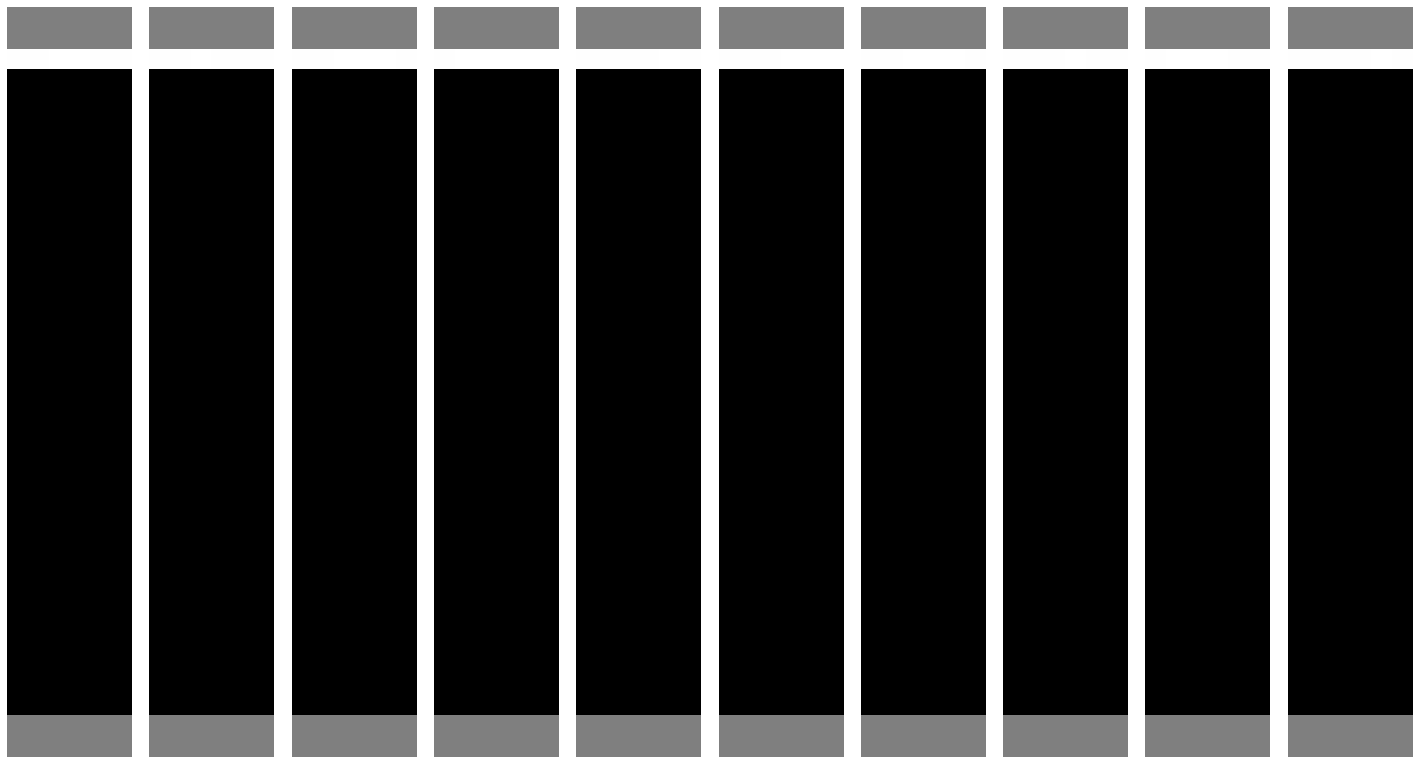

Epoch 192/200
8/8 - 1s - loss: 7.0248 - d_loss: 8.2594e-04 - g_loss: 7.0240


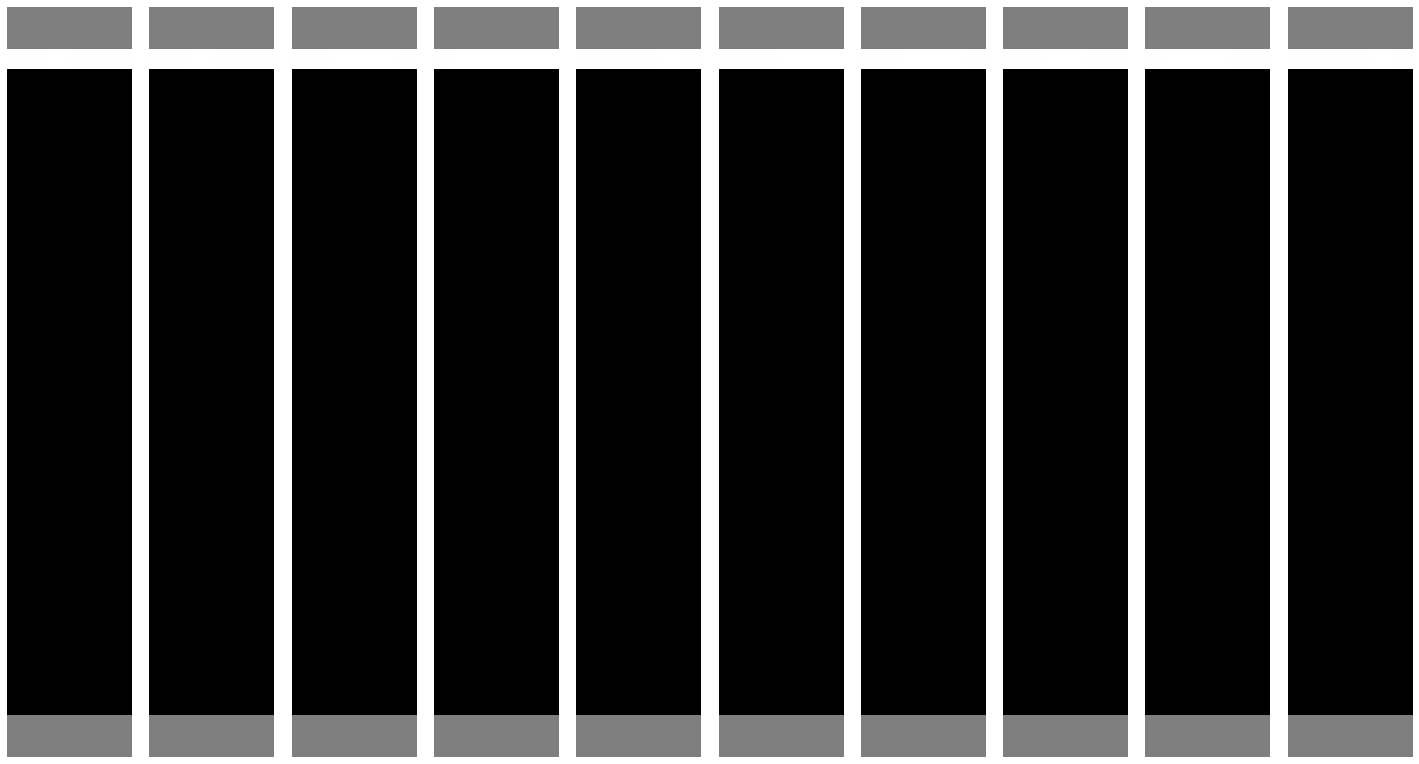

Epoch 193/200
8/8 - 1s - loss: 7.0358 - d_loss: 8.1321e-04 - g_loss: 7.0349


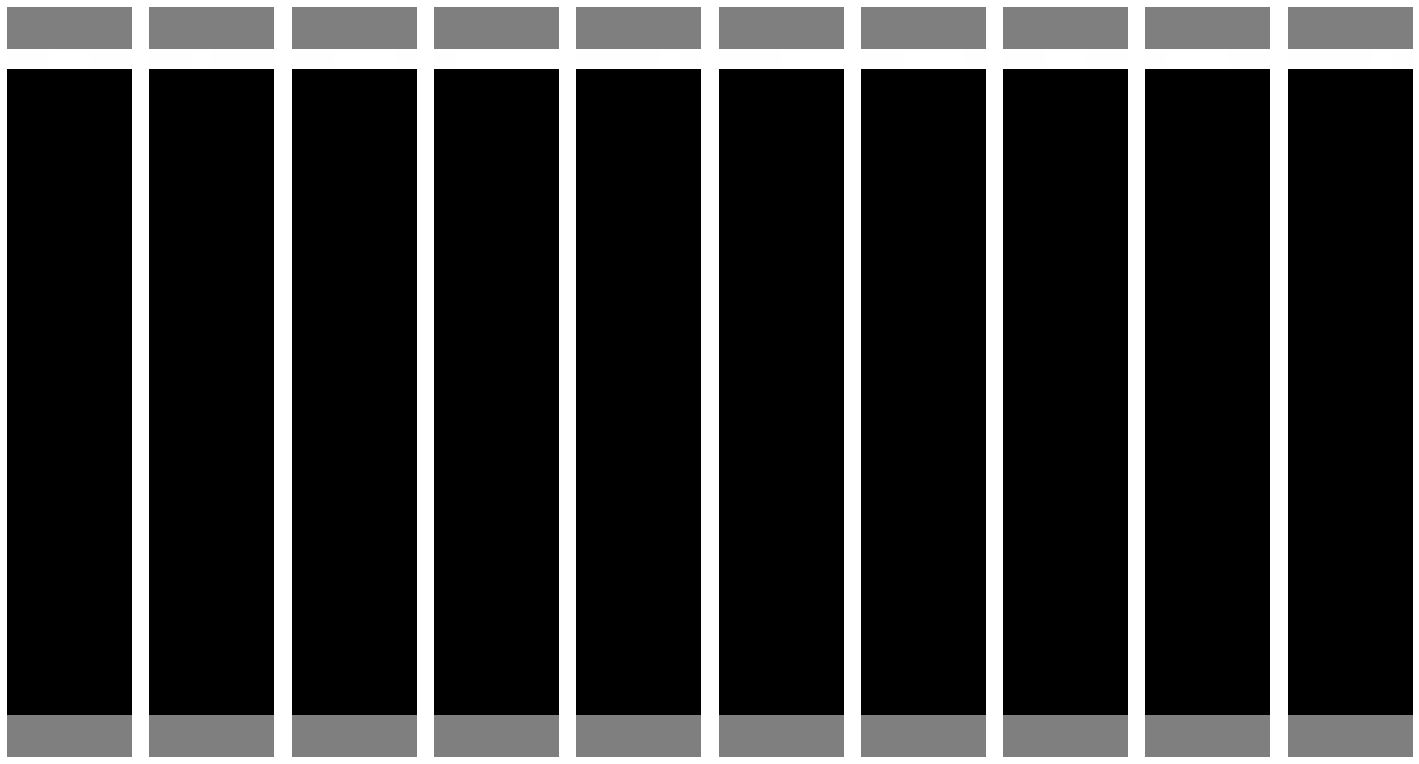

Epoch 194/200
8/8 - 1s - loss: 7.0489 - d_loss: 8.0162e-04 - g_loss: 7.0481


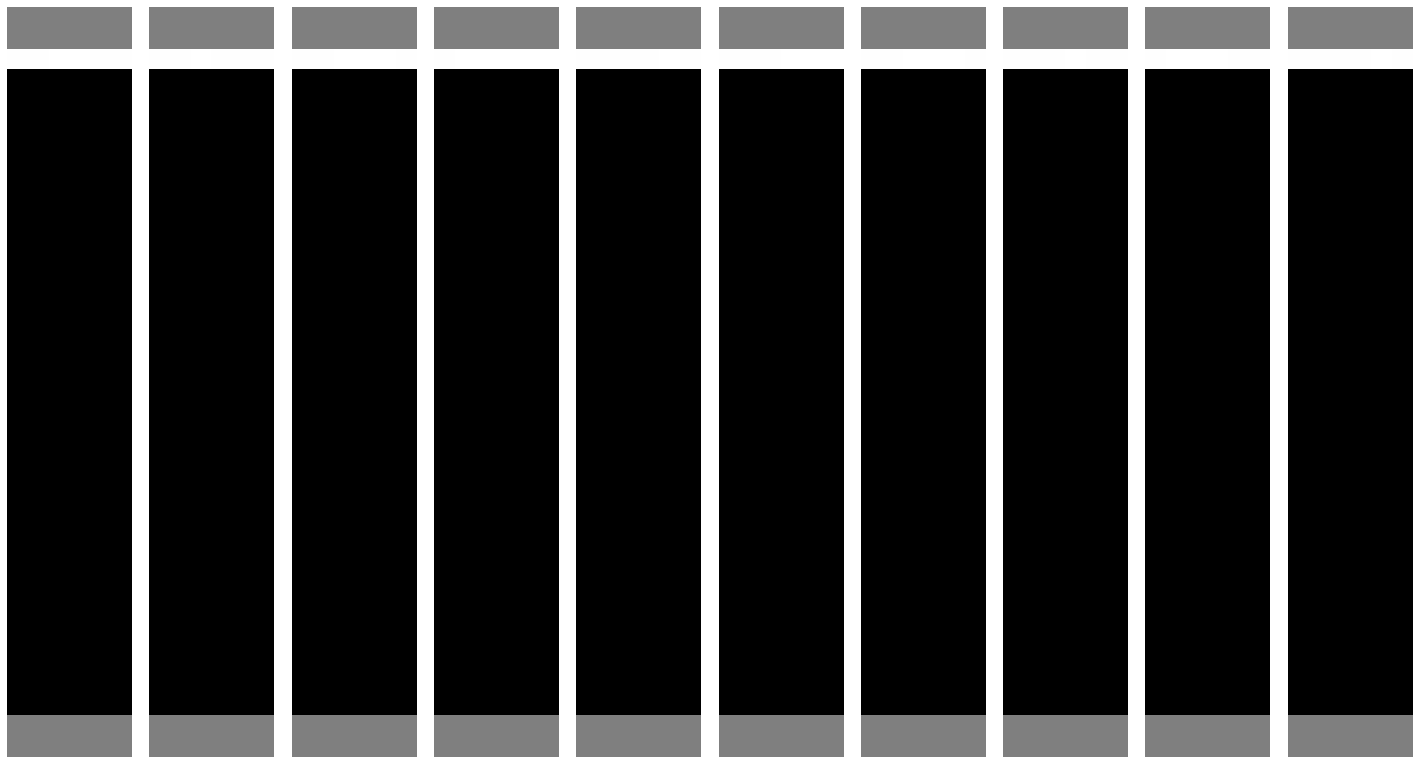

Epoch 195/200
8/8 - 1s - loss: 7.0635 - d_loss: 7.9235e-04 - g_loss: 7.0627


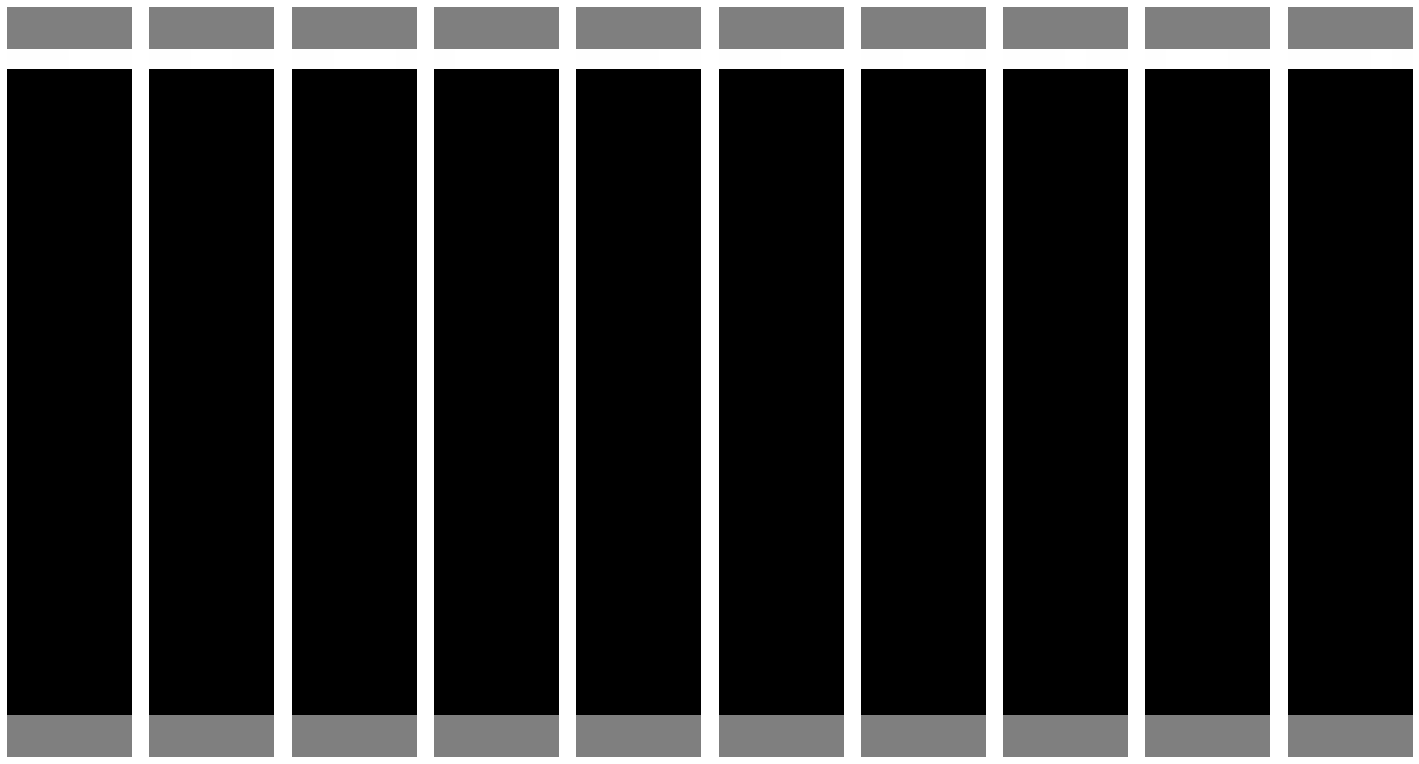

Epoch 196/200
8/8 - 1s - loss: 7.0815 - d_loss: 7.8374e-04 - g_loss: 7.0808


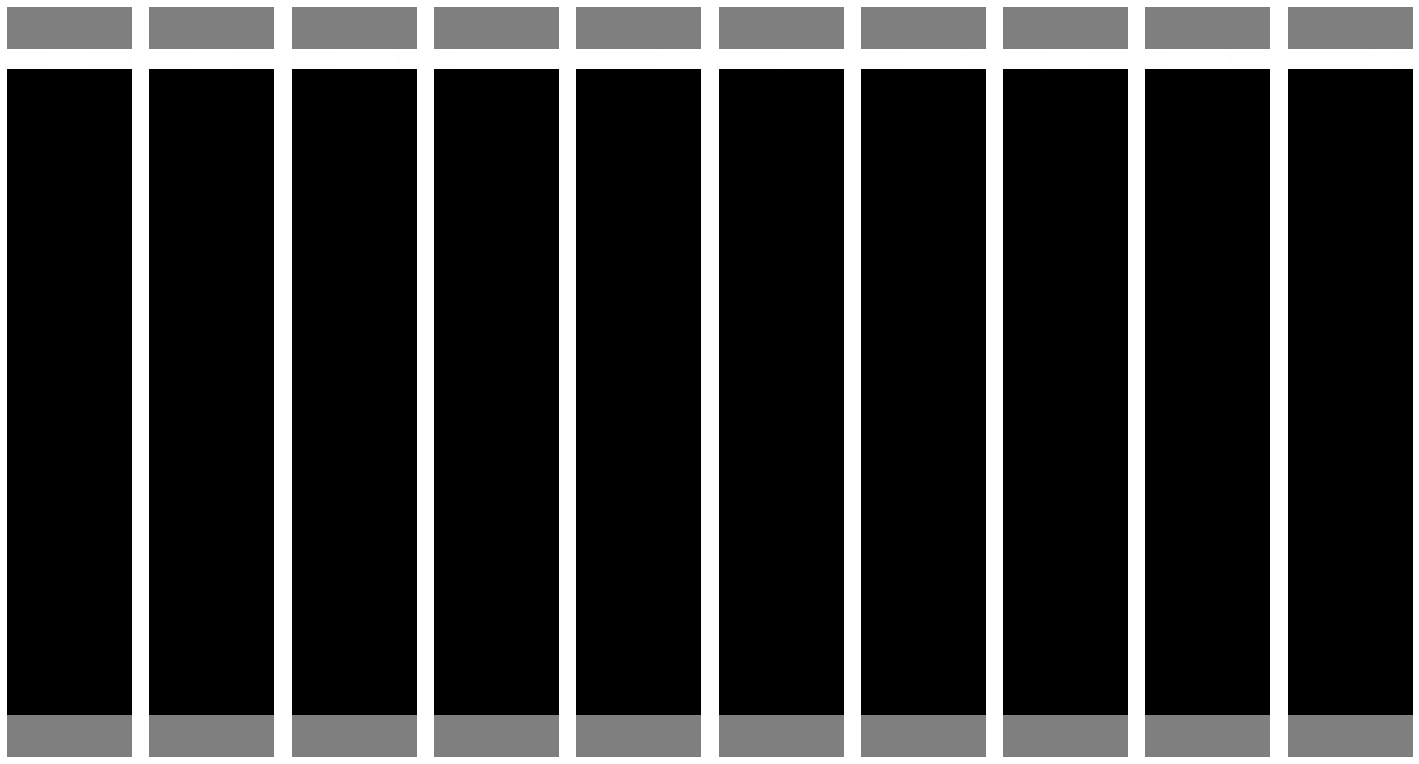

Epoch 197/200
8/8 - 1s - loss: 7.0971 - d_loss: 7.6224e-04 - g_loss: 7.0963


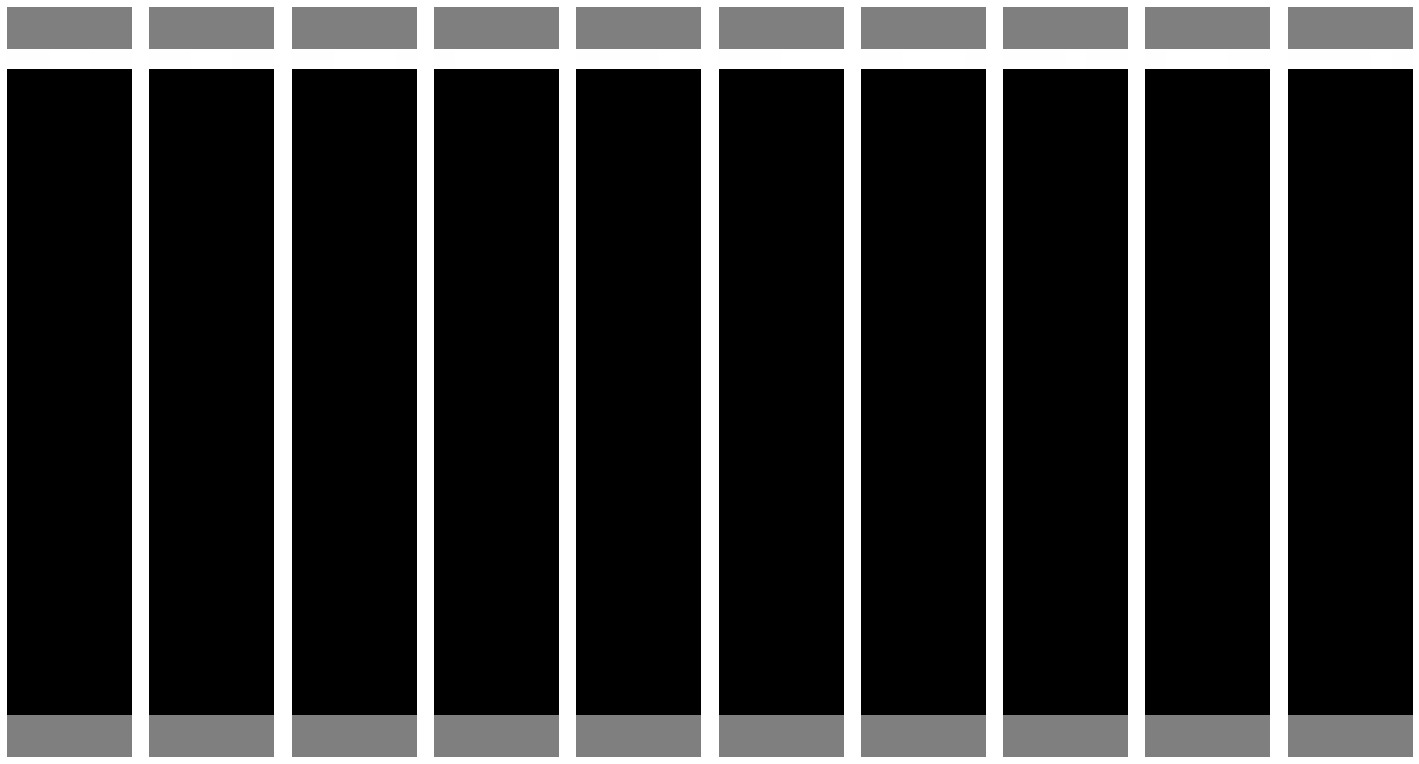

Epoch 198/200
8/8 - 1s - loss: 7.1098 - d_loss: 7.6280e-04 - g_loss: 7.1091


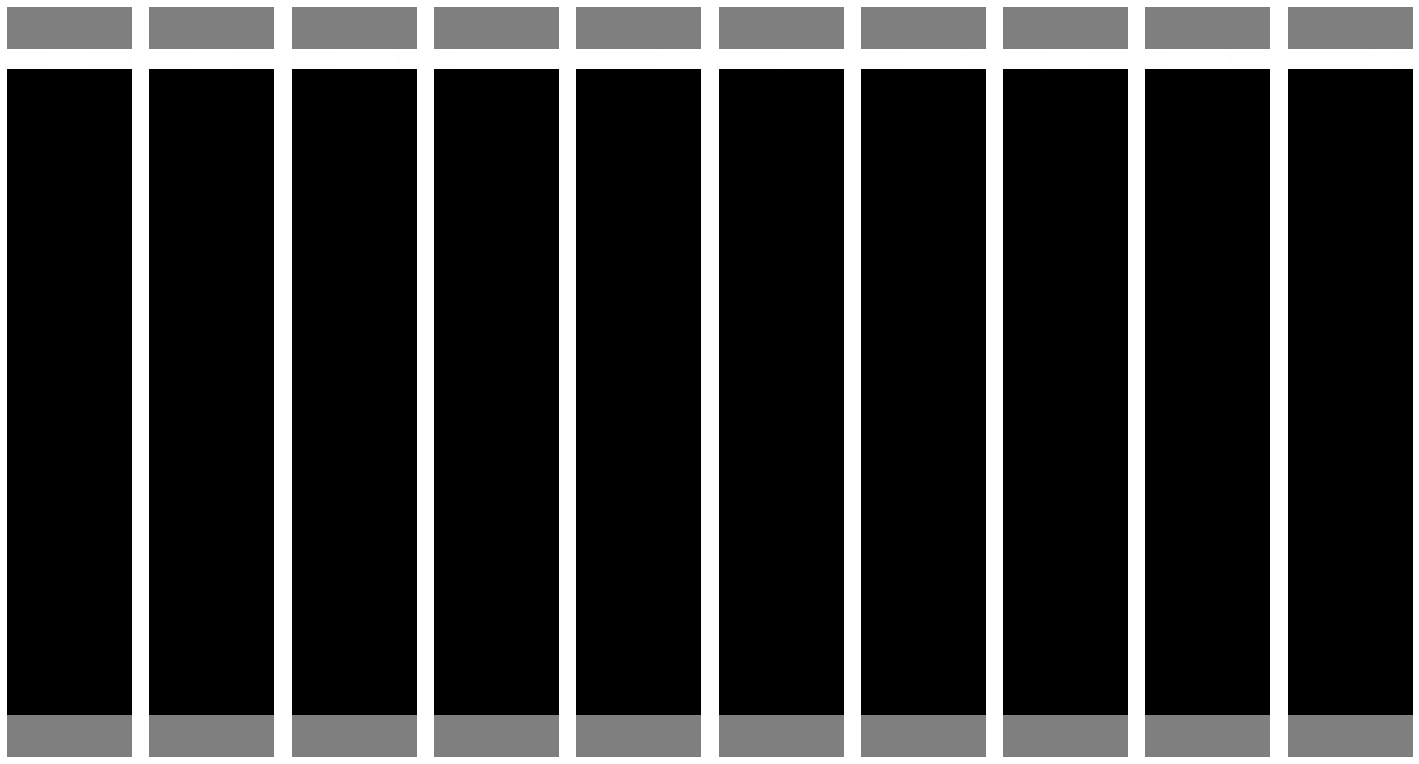

Epoch 199/200
8/8 - 1s - loss: 7.1278 - d_loss: 7.4574e-04 - g_loss: 7.1271


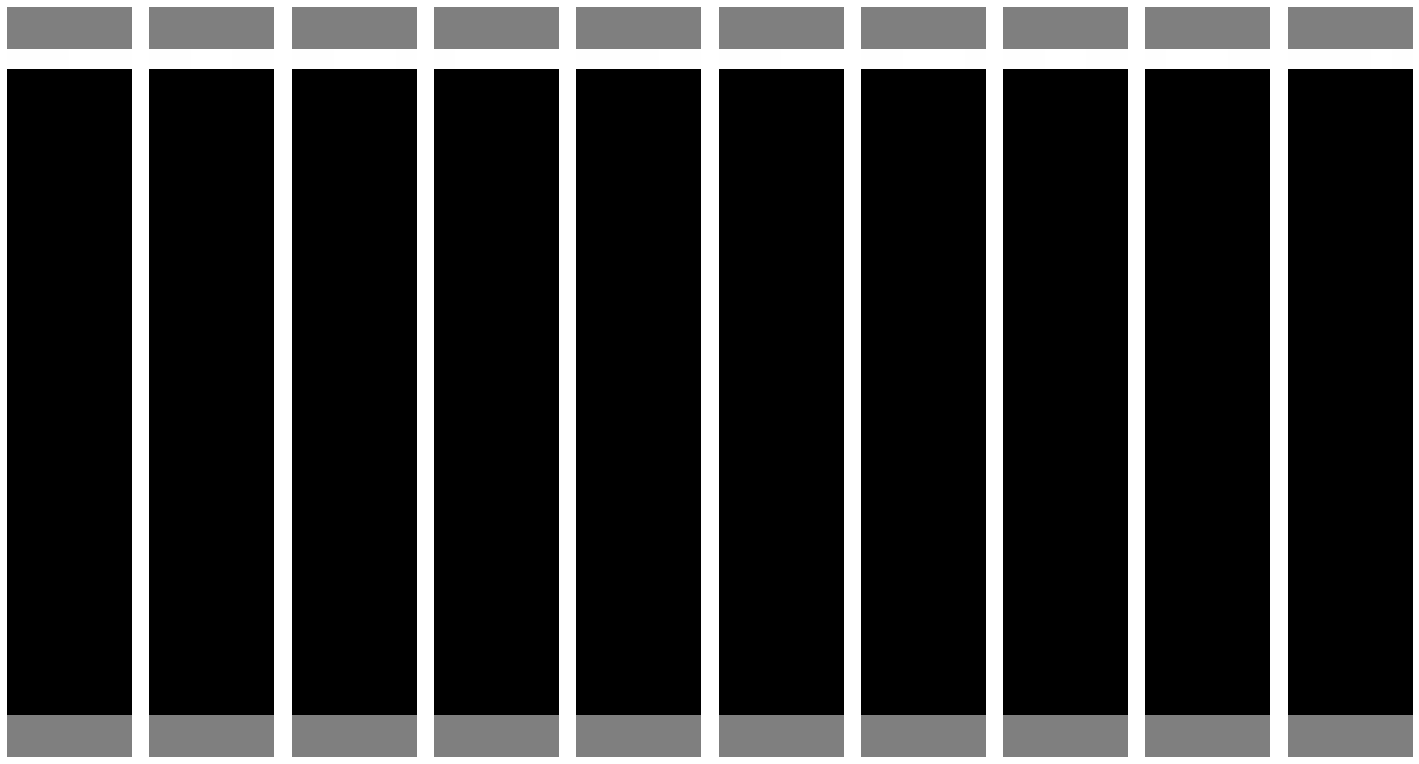

Epoch 200/200
8/8 - 1s - loss: 7.1377 - d_loss: 7.5401e-04 - g_loss: 7.1370


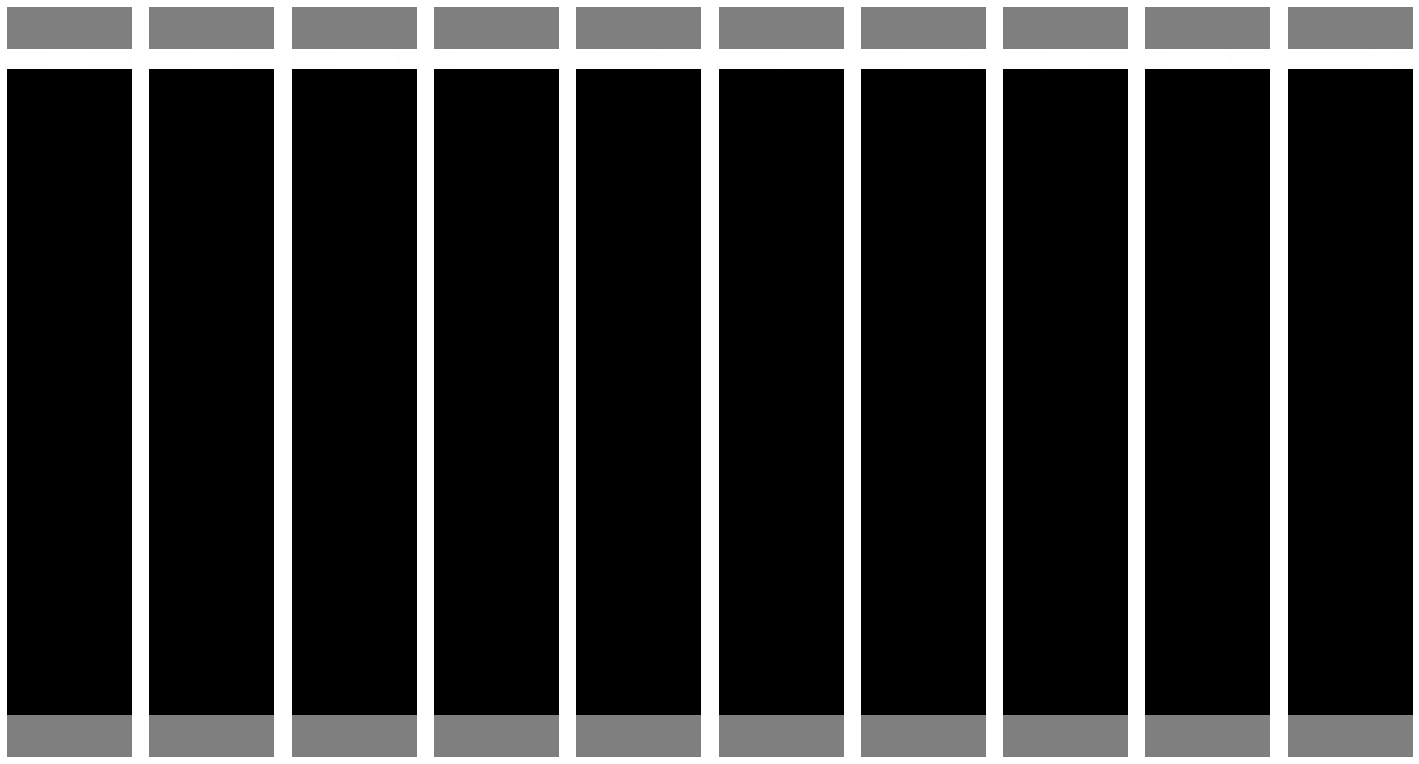

In [16]:
c_history = cgan.fit(
    dataset, 
    epochs = epochs, 
    callbacks = [ConditionalGANMonitor(name='conditional', gray=True)],
    verbose = 2
).history

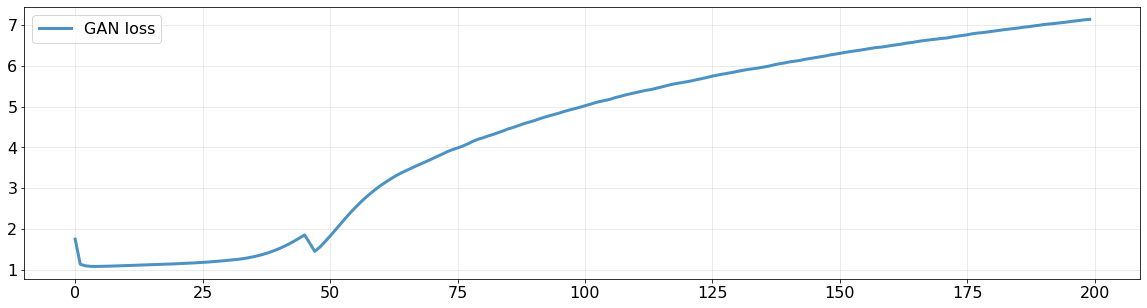

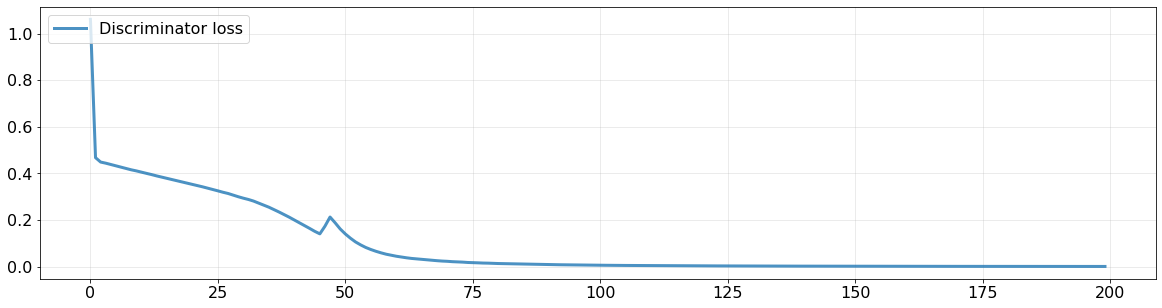

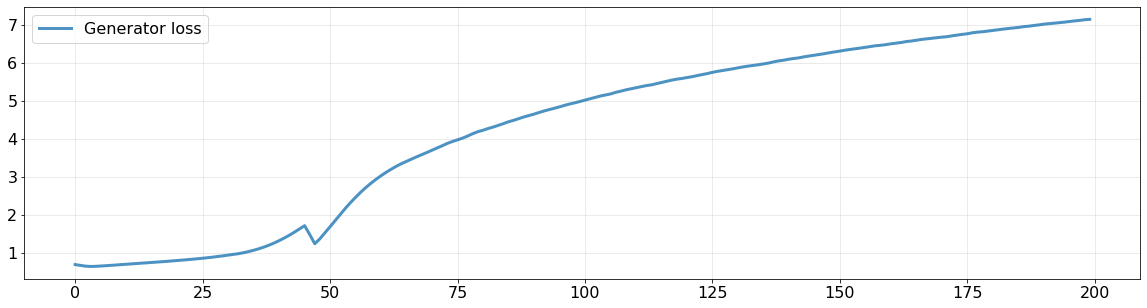

In [17]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(c_history['loss'], label='GAN loss', alpha=.8, linewidth=3)
plt.legend(loc='upper left')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(c_history['d_loss'], label='Discriminator loss', alpha=.8, linewidth=3)
plt.legend(loc='upper left')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(c_history['g_loss'], label='Generator loss', alpha=.8, linewidth=3)
plt.legend(loc='upper left')
plt.grid(alpha=.3)
plt.show()

In [18]:
cgan.generator.save('conditional_gan_generator01.h5')
conditional_gan_generator = tfk.models.load_model('conditional_gan_generator01.h5')

(216,) (216,)


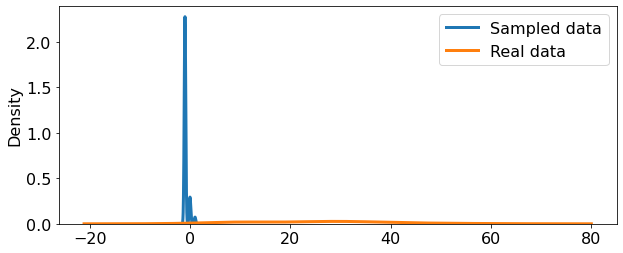

In [19]:
imgs = 2500
X_hat, y_hat = generate_conditional_dataset(conditional_gan_generator, imgs, latent_dim)
X_hat = np.reshape(X_hat, (X_hat.shape[0],X_hat.shape[1]*X_hat.shape[2]))
X_hat = np.mean(X_hat, axis=0)
y_hat = np.argmax(y_hat,axis=1)

X_temp = X[:imgs]
X_temp = np.reshape(X_temp, (X_temp.shape[0],X_temp.shape[1]*X_temp.shape[2]))
X_temp = np.mean(X_temp, axis=0)
y_temp = y[:imgs]

print(X_hat.shape, X_temp.shape)

plt.figure(figsize=(10,4))
sns.kdeplot(x=X_hat, label='Sampled data', linewidth=3)
sns.kdeplot(x=X_temp, label='Real data', linewidth=3)
plt.legend()
plt.show()

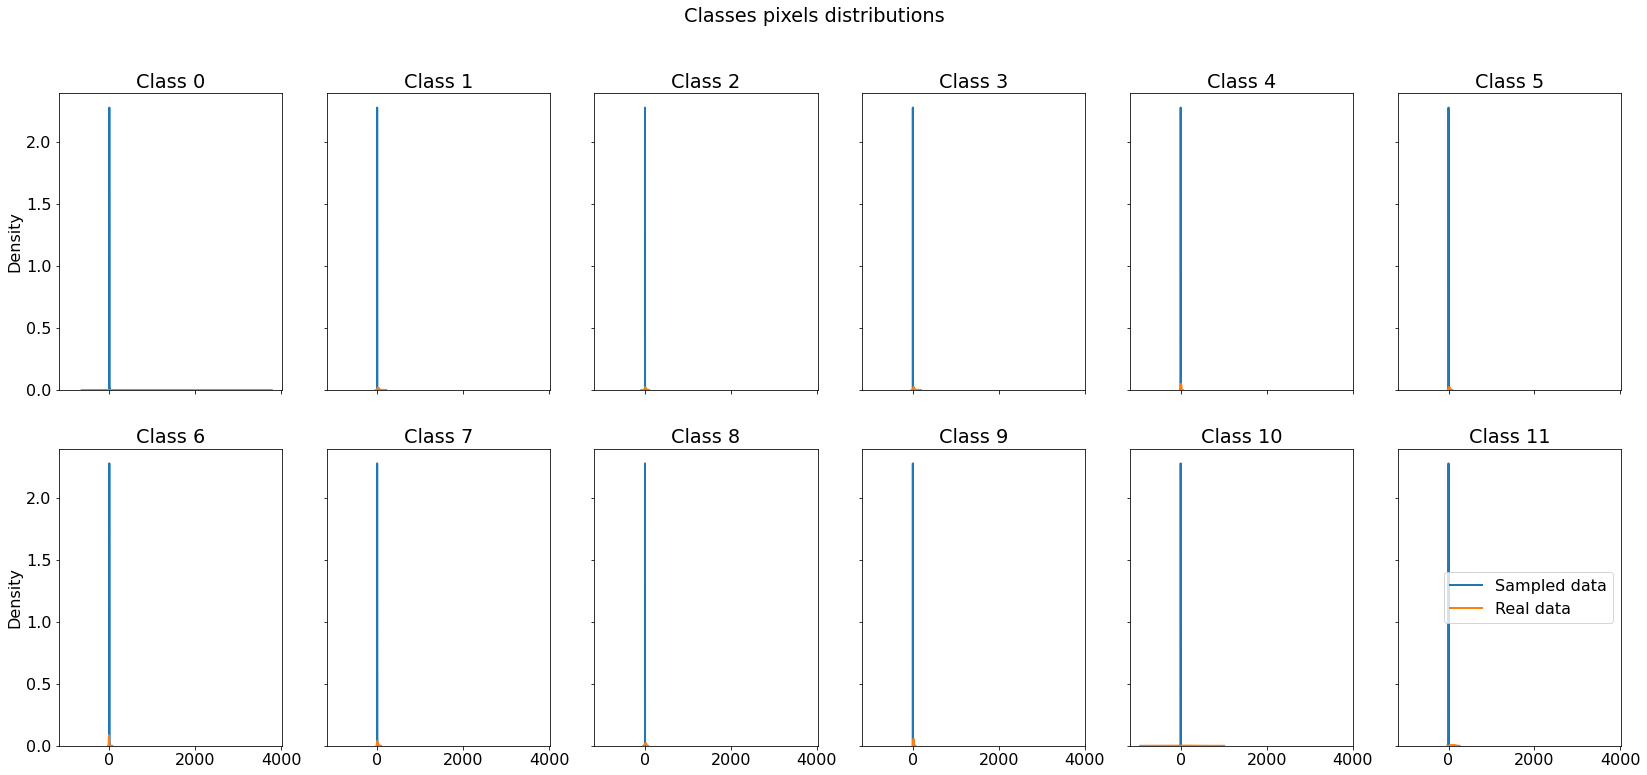

In [20]:
imgs = 1000
fig, axes = plt.subplots(2, 6, figsize=(28,12), sharey=True, sharex=True)
fig.suptitle('Classes pixels distributions')
for i in range(12):
    X_hat, y_hat = generate_conditional_dataset(conditional_gan_generator, imgs, latent_dim, label=i)
    X_hat = np.reshape(X_hat, (X_hat.shape[0],X_hat.shape[1]*X_hat.shape[2]))
    X_hat = np.mean(X_hat, axis=0)
    X_temp = X[y==i][:imgs]
    X_temp = np.reshape(X_temp, (X_temp.shape[0],X_temp.shape[1]*X_temp.shape[2]))
    X_temp = np.mean(X_temp, axis=0)
    axes[i//6, i%6].set_title(f'Class {i}')
    sns.kdeplot(ax=axes[i//6, i%6], x=X_hat, label='Sampled data', linewidth=2)
    sns.kdeplot(ax=axes[i//6, i%6], x=X_temp, label='Real data', linewidth=2)
plt.legend()
plt.show()

#### Generate new data via conditional_gan_generator

In [21]:
# Generate new images
generated_images= []
labels  = []
num_new_images = 1000
for i in range(num_classes):
    x, y  = conditional_sample(conditional_gan_generator, num_new_images, latent_dim, gray=True, fixed=False, label=i)
    generated_images.append(x)
    labels.append(np.argmax(y, axis=1))

new_data = np.array(generated_images).reshape(12, 1000, 36, 6)
new_labels = np.array(labels)

In [22]:
# Reload Data
X_train = np.load('/kaggle/working/X_train.npy')
y_train = np.load('/kaggle/working/y_train.npy')
X_val = np.load('/kaggle/working/X_val.npy')
y_val = np.load('/kaggle/working/y_val.npy')
print(X_train.shape)
print(y_train.shape)  

(1967, 36, 6)
(1967,)


In [23]:
to_add = [166,77,0,0,138,47,0,132,80,0,123,149]
#[743,654,507,396,715,624,464,709,657,0,700,726]

for i in range(12):
    for j in range(to_add[i]):
        X_train = np.vstack((X_train, new_data[i,j][None]))
        y_train = np.append(y_train, new_labels[i,j])
print(X_train.shape)
print(y_train.shape)  

(2879, 36, 6)
(2879,)


In [24]:
with open('./x_train_aug200_01c.npy', 'wb') as f:

    np.save(f, X_train)
    
with open('./y_train_aug200_01c.npy', 'wb') as f:

    np.save(f, y_train)

In [25]:
number_of_hidden_units = 128
n_timesteps = 36
n_features = 6
input_shape=(n_timesteps, n_features)

classes = 12
batch_size = 128
epochs = 200

print(input_shape)
print(classes)

(36, 6)
12


In [26]:
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(2879, 36, 6)
(2879, 12)
(219, 36, 6)
(219, 12)


In [29]:
from tensorflow import keras

def res_block(input_layer, after_first):
    n_feature_maps = 64

    if after_first:
        n_feature_maps = 128

    conv_1 = keras.layers.Conv1D(
        filters=n_feature_maps,
        kernel_size = 8,
        padding ='same'
    )(input_layer)
    conv_1 = keras.layers.BatchNormalization()(conv_1)
    conv_1 = keras.layers.Activation('relu')(conv_1)

    conv_2 = keras.layers.Conv1D(
        filters=n_feature_maps,
        kernel_size = 5,
        padding='same'
    )(conv_1)
    conv_2 = keras.layers.BatchNormalization()(conv_2)
    conv_2 = keras.layers.Activation('relu')(conv_2)

    conv_3 = keras.layers.Conv1D(
        filters=n_feature_maps,
        kernel_size = 3,
        padding = 'same'
    )(conv_2)
    conv_3 = keras.layers.BatchNormalization()(conv_3)

    shortcut_2 = keras.layers.Conv1D(
        filters=n_feature_maps,
        kernel_size = 1,
        padding='same'
    )(input_layer)
    shortcut_2 = keras.layers.BatchNormalization()(shortcut_2)

    output_1 = keras.layers.add([shortcut_2, conv_3])
    output_1 = keras.layers.Activation('relu')(output_1)

    return output_1

def build_1DResNet(input_shape, classes):
    input_layer = keras.layers.Input(input_shape)

    block_1 = res_block(input_layer,False)
    block_2 = res_block(block_1,True)
    block_3 = res_block(block_2,True)
#    block_4 = res_block(block_3, True)

    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(block_3)
    #dropout = tfkl.Dropout(.5, seed=seed)(bilstm)

    #final

    gap = keras.layers.GlobalAveragePooling1D()(bilstm)
    out = keras.layers.Dense(
        classes,
        activation = 'softmax'
    )(gap)

    model = keras.models.Model(
        inputs=input_layer,
        outputs = out,
        name = 'resnet1D'
    )

    model.compile(
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.Adam(),
        metrics='accuracy'
    )

    return model


In [30]:
model = build_1DResNet(input_shape, classes)
model.summary()

Model: "resnet1D"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 36, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 36, 64)       3136        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 36, 64)       256         conv1d_12[0][0]                  
__________________________________________________________________________________________________
activation_9 (Activation)       (None, 36, 64)       0           batch_normalization_12[0][0]     
___________________________________________________________________________________________

In [31]:
# # Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    #validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
23/23 [==============================] - 8s 79ms/step - loss: 2.0482 - accuracy: 0.3011 - val_loss: 2.2018 - val_accuracy: 0.3562
Epoch 2/200
23/23 [==============================] - 1s 24ms/step - loss: 1.8174 - accuracy: 0.3435 - val_loss: 2.6394 - val_accuracy: 0.1644
Epoch 3/200
23/23 [==============================] - 1s 23ms/step - loss: 1.7647 - accuracy: 0.3685 - val_loss: 2.5565 - val_accuracy: 0.2329
Epoch 4/200
23/23 [==============================] - 1s 23ms/step - loss: 1.6443 - accuracy: 0.3991 - val_loss: 2.3035 - val_accuracy: 0.3151
Epoch 5/200
23/23 [==============================] - 1s 23ms/step - loss: 1.5405 - accuracy: 0.4224 - val_loss: 1.7780 - val_accuracy: 0.5205
Epoch 6/200
23/23 [==============================] - 1s 24ms/step - loss: 1.4703 - accuracy: 0.4654 - val_loss: 1.8790 - val_accuracy: 0.4338
Epoch 7/200
23/23 [==============================] - 1s 24ms/step - loss: 1.4382 - accuracy: 0.4658 - val_loss: 1.7648 - val_accuracy: 0.5205
Epoch 

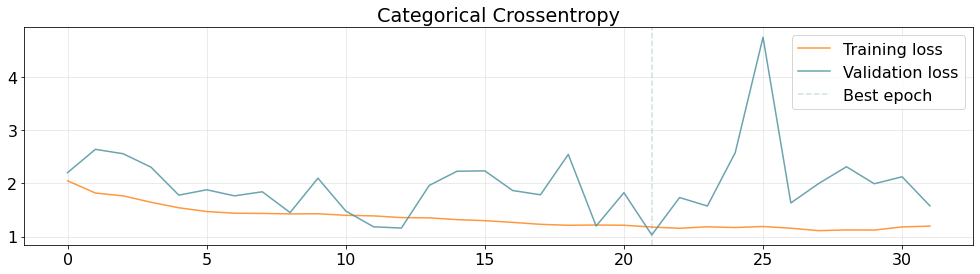

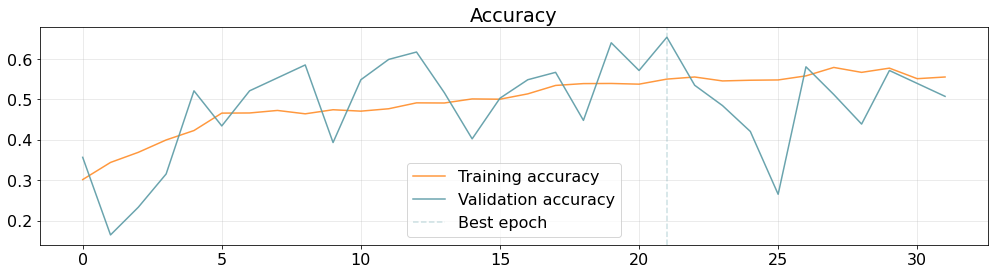

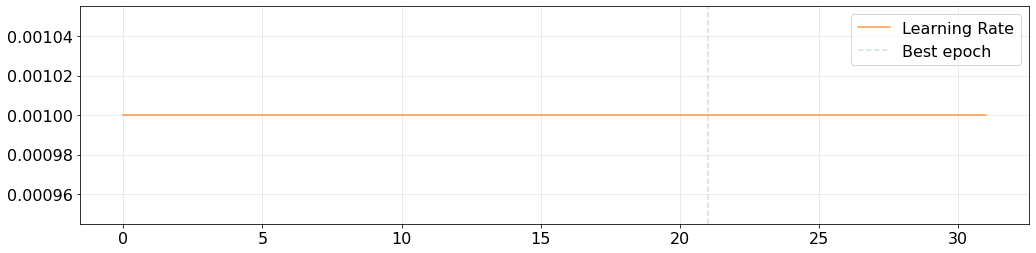

In [32]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

Accuracy: 0.6831
Precision: 0.6729
Recall: 0.5083
F1: 0.5382


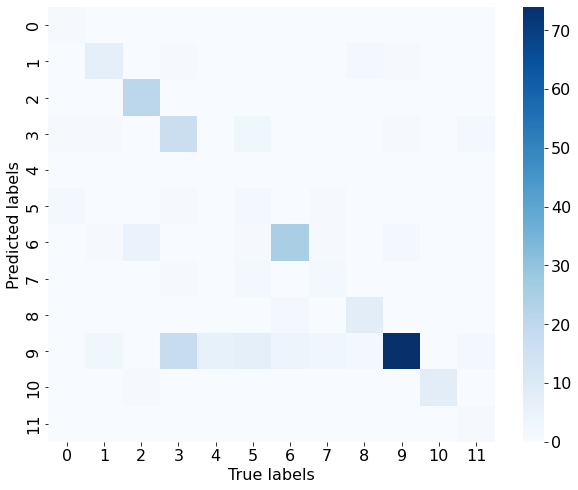

In [33]:
model.save('resNet_plusBiLSTM_GAN_all15.h5')
# model = tfk.models.load_model('LSTM')

# Predict the test set with the resNetGan
predictions = model.predict(X_test)
predictions.shape

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues')#, xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [34]:
import keras
model = keras.models.load_model('resNet_plusBiLSTM_GAN_all15.h5')
model.save('resNet_plusBiLSTM_GAN_all20')